In [8]:
# PyTorch imports
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

# Image files imports
import json
import os
import PIL
from glob import glob

# Utils imports 
import utils
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# SuperNet 
from alternatives import ConvBNRelu, DepthwiseSeparableConv
from LocalDNAS import SuperNet, SuperRegularizer

In [9]:
# Seed for experiments
SEED = 42

# 1 - Dataset: ImageNet100

In [10]:
class ImageNet100(Dataset):

    """
    PyTorch torch.utils.Dataset for ImageNet100 classification dataset.
    ------
    IMPORTANT: Uses lazy loading in order to prevent RAM saturation.
    """

    def __init__(self, images, labels, class_to_idx, transform):
        
        # Samples
        self.image_files = images
        self.transform = transform

        # Targets        
        self.class_to_idx = class_to_idx
        self.target = [self.class_to_idx[k] for k in labels]
        self.class_names = list(self.class_to_idx.keys())

    
    def __len__(self):
        return len(self.target)
    
    
    def __getitem__(self, idx):
        # Lazy loading: loading images only when queried
        image = PIL.Image.open(self.image_files[idx])
        
        # Convert all images to RGB
        if not image.mode == 'RGB':
            image = image.convert('RGB')

        # Apply transformations    
        img_tensor = self.transform(image)
        label = self.target[idx]
        
        return img_tensor, label

In [11]:
labels = None
with open('./ImageNet/Labels.json', 'r') as f:
    labels = json.load(f)

labels

{'n01968897': 'chambered nautilus, pearly nautilus, nautilus',
 'n01770081': 'harvestman, daddy longlegs, Phalangium opilio',
 'n01818515': 'macaw',
 'n02011460': 'bittern',
 'n01496331': 'electric ray, crampfish, numbfish, torpedo',
 'n01847000': 'drake',
 'n01687978': 'agama',
 'n01740131': 'night snake, Hypsiglena torquata',
 'n01537544': 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 'n01491361': 'tiger shark, Galeocerdo cuvieri',
 'n02007558': 'flamingo',
 'n01735189': 'garter snake, grass snake',
 'n01630670': 'common newt, Triturus vulgaris',
 'n01440764': 'tench, Tinca tinca',
 'n01819313': 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita',
 'n02002556': 'white stork, Ciconia ciconia',
 'n01667778': 'terrapin',
 'n01755581': 'diamondback, diamondback rattlesnake, Crotalus adamanteus',
 'n01924916': 'flatworm, platyhelminth',
 'n01751748': 'sea snake',
 'n01984695': 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
 'n01729

In [12]:
train_images, train_labels = [], []
test_images, test_labels = [], []

# Build class to index for consistency between train and test
idx = 0
class_to_idx = {}

for folder in glob('./ImageNet/*'):

    # Skip file Labels.json
    if not os.path.isdir(folder): 
        continue

    # Type of folder 
    mode = folder.split('/')[-1].split('.')[0]
    
    # Divide images
    for class_folder in glob(f'{folder}/*'):
        # Class label
        key = class_folder.split('/')[-1]
        if key not in class_to_idx.keys():
            class_to_idx[key] = idx
            idx += 1 
        
        # Images
        image_files = glob(f'{class_folder}/*')
        
        for im in image_files:
            if mode == 'train':
                train_images.append(im)
                train_labels.append(key)
            else:
                test_images.append(im)
                test_labels.append(key)


In [13]:
# Pre-processing for training images
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize([232,232]),
    v2.CenterCrop([224,224]),
    v2.TrivialAugmentWide(),
    v2.RandomErasing(p=0.1),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Pre-processing for validation/test images
val_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize([232,232]),
    v2.CenterCrop([224,224]),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Save pickle files of Dataset objects
if not os.path.exists('./ImageNet/train_dataset.pkl'):
    train_dataset = ImageNet100(train_images, train_labels, class_to_idx, train_transforms)
    with open('./ImageNet/train_dataset.pkl', 'wb') as f:
        pickle.dump(train_dataset, f, pickle.HIGHEST_PROTOCOL)
else:
    with open('./ImageNet/train_dataset.pkl', 'rb') as f:
        train_dataset = pickle.load(f)

if not os.path.exists('./ImageNet/test_dataset.pkl'):
    test_dataset = ImageNet100(test_images, test_labels, class_to_idx, val_transforms)
    with open('./ImageNet/test_dataset.pkl', 'wb') as f:
        pickle.dump(test_dataset, f, pickle.HIGHEST_PROTOCOL)
else:
    with open('./ImageNet/test_dataset.pkl', 'rb') as f:
        test_dataset = pickle.load(f)


In [7]:
# Check for labeling consistency between train and test dataset
conflicts = 0
for k in train_dataset.class_to_idx.keys():    
    if train_dataset.class_to_idx[k] != test_dataset.class_to_idx[k]: 
        conflicts += 1
        print(f'Non matching keys - {k}: train {train_dataset.class_to_idx[k]} | test {test_dataset.class_to_idx[k]}')

if conflicts == 0: print('All keys matching!')

All keys matching!


In [8]:
# Train DataLoader 
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=14,
    pin_memory=True
)

# Test DataLoader
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=14,
    pin_memory=True
)

print(f'Created {len(train_dataloader)} training batches of 16 samples.')
print(f'Created {len(test_dataloader)} test batches of 16 samples.')

Created 8125 training batches of 16 samples.
Created 313 test batches of 16 samples.


# 2 - Baseline model: MobileNetV3

In [9]:
torch.manual_seed(SEED)

# Load the target model
baseline = torchvision.models.mobilenet_v3_large()
baseline

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [10]:
# Modify the classifier's structure in order to fit the dataset ImageNet100
baseline.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=len(train_dataset.class_names))
baseline

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [11]:
# Save the initialization for common starting point
if not os.path.exists(f'./main_models/MobileNetV3_init_seed{SEED}.pt'):
    torch.save(baseline, f'./main_models/MobileNetV3_init_seed{SEED}.pt')
else:
    baseline = torch.load(f'./main_models/MobileNetV3_init_seed{SEED}.pt', weights_only=False)

## 2.1 - Training

We want a solid baseline to make comparisons with further architectures. The baseline training pipeline will be:
* 100 epochs of _Stochastic Gradient Descent_, in which the learning rate is subject to;
    * 5 epochs of **linear warmup**;
    * 95 epochs of **Cosine decay**;
* minimization of _CrossEntropy_ with **L2 regularization**.

**_REMARK_**: the values of the hyperparameters have been tuned empirically, following the recipe provided by PyTorch: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/ 

In [12]:
# Baseline experiments settings
settings = {
    'epochs': 100,
    'lr': 0.2,
    'loss': 'L2-CrossEntropy',
    'label_smoothing': 0.1,
    'momentum': 0.9,
    'weight_decay': 2e-5,
}

In [13]:
# Set the target device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [14]:
# Loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=settings['label_smoothing'])
baseline_optimizer = torch.optim.SGD(params=baseline.parameters(), lr=settings['lr'], momentum=settings['momentum'], weight_decay=settings['weight_decay'])

# Learning rate scheduler 
baseline_main_shceduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=baseline_optimizer, T_max=settings['epochs'])
baseline_warmup = torch.optim.lr_scheduler.LinearLR(optimizer=baseline_optimizer, start_factor=0.01, total_iters=5) # Linear warmup
baseline_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=baseline_optimizer, schedulers=[baseline_warmup, baseline_main_shceduler], milestones=[5])


In [15]:
# Train the model
loss_h, acc_h, val_loss_h, val_acc_h = utils.train_model(
    model=baseline,
    device=device,
    data_loader=train_dataloader,
    loss_fn=loss_fn,
    optimizer=baseline_optimizer,
    lr_scheduler=baseline_scheduler,
    val_dataloader=test_dataloader,
    seed=SEED
)

*********************
EPOCH 0 on cuda - Current learning rate: 0.0020



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 4.57062 | Avg Accuracy: 1.63%
Computed 1999/8125 batches - Avg Loss: 4.51154 | Avg Accuracy: 2.22%
Computed 2999/8125 batches - Avg Loss: 4.45645 | Avg Accuracy: 2.79%
Computed 3999/8125 batches - Avg Loss: 4.40947 | Avg Accuracy: 3.36%
Computed 4999/8125 batches - Avg Loss: 4.36306 | Avg Accuracy: 4.04%
Computed 5999/8125 batches - Avg Loss: 4.31533 | Avg Accuracy: 4.78%
Computed 6999/8125 batches - Avg Loss: 4.27015 | Avg Accuracy: 5.52%
Computed 7999/8125 batches - Avg Loss: 4.22617 | Avg Accuracy: 6.25%

End of EPOCH 0 - Avg Loss: 4.22040 | Avg Accuracy: 6.34%
Training time: 309.207 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 15.18%
*********************
EPOCH 1 on cuda - Current learning rate: 0.0416



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 4.40788 | Avg Accuracy: 3.86%
Computed 1999/8125 batches - Avg Loss: 4.27487 | Avg Accuracy: 5.77%
Computed 2999/8125 batches - Avg Loss: 4.18801 | Avg Accuracy: 7.17%
Computed 3999/8125 batches - Avg Loss: 4.11446 | Avg Accuracy: 8.51%
Computed 4999/8125 batches - Avg Loss: 4.04899 | Avg Accuracy: 9.77%
Computed 5999/8125 batches - Avg Loss: 3.99232 | Avg Accuracy: 10.97%
Computed 6999/8125 batches - Avg Loss: 3.94103 | Avg Accuracy: 11.99%
Computed 7999/8125 batches - Avg Loss: 3.89351 | Avg Accuracy: 13.06%

End of EPOCH 1 - Avg Loss: 3.88671 | Avg Accuracy: 13.21%
Training time: 309.505 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 18.99%
*********************
EPOCH 2 on cuda - Current learning rate: 0.0812



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.68677 | Avg Accuracy: 17.82%
Computed 1999/8125 batches - Avg Loss: 3.63347 | Avg Accuracy: 19.02%
Computed 2999/8125 batches - Avg Loss: 3.59378 | Avg Accuracy: 19.88%
Computed 3999/8125 batches - Avg Loss: 3.56362 | Avg Accuracy: 20.76%
Computed 4999/8125 batches - Avg Loss: 3.53103 | Avg Accuracy: 21.55%
Computed 5999/8125 batches - Avg Loss: 3.50271 | Avg Accuracy: 22.20%
Computed 6999/8125 batches - Avg Loss: 3.47513 | Avg Accuracy: 22.83%
Computed 7999/8125 batches - Avg Loss: 3.44899 | Avg Accuracy: 23.48%

End of EPOCH 2 - Avg Loss: 3.44632 | Avg Accuracy: 23.54%
Training time: 309.146 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 31.95%
*********************
EPOCH 3 on cuda - Current learning rate: 0.1208



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.43861 | Avg Accuracy: 23.86%
Computed 1999/8125 batches - Avg Loss: 3.41660 | Avg Accuracy: 24.58%
Computed 2999/8125 batches - Avg Loss: 3.40206 | Avg Accuracy: 24.96%
Computed 3999/8125 batches - Avg Loss: 3.38686 | Avg Accuracy: 25.47%
Computed 4999/8125 batches - Avg Loss: 3.37161 | Avg Accuracy: 25.87%
Computed 5999/8125 batches - Avg Loss: 3.35397 | Avg Accuracy: 26.32%
Computed 6999/8125 batches - Avg Loss: 3.34048 | Avg Accuracy: 26.63%
Computed 7999/8125 batches - Avg Loss: 3.32842 | Avg Accuracy: 26.90%

End of EPOCH 3 - Avg Loss: 3.32615 | Avg Accuracy: 26.97%
Training time: 309.205 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 31.47%
*********************
EPOCH 4 on cuda - Current learning rate: 0.1604



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.41431 | Avg Accuracy: 26.52%
Computed 1999/8125 batches - Avg Loss: 3.39757 | Avg Accuracy: 26.34%
Computed 2999/8125 batches - Avg Loss: 3.38707 | Avg Accuracy: 26.51%
Computed 3999/8125 batches - Avg Loss: 3.38327 | Avg Accuracy: 26.58%
Computed 4999/8125 batches - Avg Loss: 3.36730 | Avg Accuracy: 26.93%
Computed 5999/8125 batches - Avg Loss: 3.35653 | Avg Accuracy: 27.25%
Computed 6999/8125 batches - Avg Loss: 3.34266 | Avg Accuracy: 27.59%
Computed 7999/8125 batches - Avg Loss: 3.33230 | Avg Accuracy: 27.85%

End of EPOCH 4 - Avg Loss: 3.32999 | Avg Accuracy: 27.89%
Training time: 309.395 seconds.

VALIDATION...


/home/tiziano-tezze/ProgramFiles/miniconda3/envs/cv-project/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 34.52%
*********************
EPOCH 5 on cuda - Current learning rate: 0.2000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.41065 | Avg Accuracy: 26.53%
Computed 1999/8125 batches - Avg Loss: 3.43259 | Avg Accuracy: 26.04%
Computed 2999/8125 batches - Avg Loss: 3.43550 | Avg Accuracy: 26.06%
Computed 3999/8125 batches - Avg Loss: 3.42723 | Avg Accuracy: 26.40%
Computed 4999/8125 batches - Avg Loss: 3.42397 | Avg Accuracy: 26.53%
Computed 5999/8125 batches - Avg Loss: 3.42039 | Avg Accuracy: 26.67%
Computed 6999/8125 batches - Avg Loss: 3.41304 | Avg Accuracy: 26.83%
Computed 7999/8125 batches - Avg Loss: 3.40797 | Avg Accuracy: 27.00%

End of EPOCH 5 - Avg Loss: 3.40682 | Avg Accuracy: 27.01%
Training time: 308.748 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 29.89%
*********************
EPOCH 6 on cuda - Current learning rate: 0.2000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.31514 | Avg Accuracy: 29.39%
Computed 1999/8125 batches - Avg Loss: 3.29813 | Avg Accuracy: 29.70%
Computed 2999/8125 batches - Avg Loss: 3.30256 | Avg Accuracy: 29.52%
Computed 3999/8125 batches - Avg Loss: 3.29059 | Avg Accuracy: 29.84%
Computed 4999/8125 batches - Avg Loss: 3.28062 | Avg Accuracy: 30.05%
Computed 5999/8125 batches - Avg Loss: 3.27251 | Avg Accuracy: 30.24%
Computed 6999/8125 batches - Avg Loss: 3.27001 | Avg Accuracy: 30.25%
Computed 7999/8125 batches - Avg Loss: 3.26570 | Avg Accuracy: 30.30%

End of EPOCH 6 - Avg Loss: 3.26434 | Avg Accuracy: 30.32%
Training time: 309.333 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 33.97%
*********************
EPOCH 7 on cuda - Current learning rate: 0.1998



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.19861 | Avg Accuracy: 32.34%
Computed 1999/8125 batches - Avg Loss: 3.18436 | Avg Accuracy: 32.31%
Computed 2999/8125 batches - Avg Loss: 3.18220 | Avg Accuracy: 32.24%
Computed 3999/8125 batches - Avg Loss: 3.17691 | Avg Accuracy: 32.33%
Computed 4999/8125 batches - Avg Loss: 3.17328 | Avg Accuracy: 32.37%
Computed 5999/8125 batches - Avg Loss: 3.17094 | Avg Accuracy: 32.48%
Computed 6999/8125 batches - Avg Loss: 3.16523 | Avg Accuracy: 32.62%
Computed 7999/8125 batches - Avg Loss: 3.15965 | Avg Accuracy: 32.74%

End of EPOCH 7 - Avg Loss: 3.15889 | Avg Accuracy: 32.76%
Training time: 309.399 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 34.42%
*********************
EPOCH 8 on cuda - Current learning rate: 0.1996



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.09090 | Avg Accuracy: 35.04%
Computed 1999/8125 batches - Avg Loss: 3.08744 | Avg Accuracy: 34.75%
Computed 2999/8125 batches - Avg Loss: 3.08890 | Avg Accuracy: 34.79%
Computed 3999/8125 batches - Avg Loss: 3.08111 | Avg Accuracy: 34.95%
Computed 4999/8125 batches - Avg Loss: 3.07850 | Avg Accuracy: 35.01%
Computed 5999/8125 batches - Avg Loss: 3.07958 | Avg Accuracy: 34.96%
Computed 6999/8125 batches - Avg Loss: 3.07769 | Avg Accuracy: 34.93%
Computed 7999/8125 batches - Avg Loss: 3.07359 | Avg Accuracy: 34.94%

End of EPOCH 8 - Avg Loss: 3.07220 | Avg Accuracy: 34.96%
Training time: 309.999 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 35.84%
*********************
EPOCH 9 on cuda - Current learning rate: 0.1992



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.02519 | Avg Accuracy: 36.18%
Computed 1999/8125 batches - Avg Loss: 3.01701 | Avg Accuracy: 36.26%
Computed 2999/8125 batches - Avg Loss: 3.01842 | Avg Accuracy: 36.17%
Computed 3999/8125 batches - Avg Loss: 3.01318 | Avg Accuracy: 36.32%
Computed 4999/8125 batches - Avg Loss: 3.00927 | Avg Accuracy: 36.34%
Computed 5999/8125 batches - Avg Loss: 3.00893 | Avg Accuracy: 36.40%
Computed 6999/8125 batches - Avg Loss: 3.00550 | Avg Accuracy: 36.55%
Computed 7999/8125 batches - Avg Loss: 3.00405 | Avg Accuracy: 36.57%

End of EPOCH 9 - Avg Loss: 3.00406 | Avg Accuracy: 36.54%
Training time: 308.595 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 40.14%
*********************
EPOCH 10 on cuda - Current learning rate: 0.1988



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.94404 | Avg Accuracy: 37.69%
Computed 1999/8125 batches - Avg Loss: 2.97533 | Avg Accuracy: 37.12%
Computed 2999/8125 batches - Avg Loss: 2.97104 | Avg Accuracy: 37.20%
Computed 3999/8125 batches - Avg Loss: 2.96204 | Avg Accuracy: 37.43%
Computed 4999/8125 batches - Avg Loss: 2.95813 | Avg Accuracy: 37.54%
Computed 5999/8125 batches - Avg Loss: 2.95149 | Avg Accuracy: 37.73%
Computed 6999/8125 batches - Avg Loss: 2.94878 | Avg Accuracy: 37.86%
Computed 7999/8125 batches - Avg Loss: 2.94634 | Avg Accuracy: 37.93%

End of EPOCH 10 - Avg Loss: 2.94546 | Avg Accuracy: 37.94%
Training time: 309.301 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 39.58%
*********************
EPOCH 11 on cuda - Current learning rate: 0.1982



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.90506 | Avg Accuracy: 39.04%
Computed 1999/8125 batches - Avg Loss: 2.90059 | Avg Accuracy: 39.21%
Computed 2999/8125 batches - Avg Loss: 2.90289 | Avg Accuracy: 39.00%
Computed 3999/8125 batches - Avg Loss: 2.90261 | Avg Accuracy: 38.98%
Computed 4999/8125 batches - Avg Loss: 2.90159 | Avg Accuracy: 38.97%
Computed 5999/8125 batches - Avg Loss: 2.90094 | Avg Accuracy: 39.04%
Computed 6999/8125 batches - Avg Loss: 2.89831 | Avg Accuracy: 39.10%
Computed 7999/8125 batches - Avg Loss: 2.89700 | Avg Accuracy: 39.19%

End of EPOCH 11 - Avg Loss: 2.89674 | Avg Accuracy: 39.18%
Training time: 309.509 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 38.54%
*********************
EPOCH 12 on cuda - Current learning rate: 0.1976



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.86405 | Avg Accuracy: 40.10%
Computed 1999/8125 batches - Avg Loss: 2.85700 | Avg Accuracy: 40.44%
Computed 2999/8125 batches - Avg Loss: 2.85307 | Avg Accuracy: 40.42%
Computed 3999/8125 batches - Avg Loss: 2.84971 | Avg Accuracy: 40.48%
Computed 4999/8125 batches - Avg Loss: 2.84969 | Avg Accuracy: 40.46%
Computed 5999/8125 batches - Avg Loss: 2.85132 | Avg Accuracy: 40.43%
Computed 6999/8125 batches - Avg Loss: 2.85448 | Avg Accuracy: 40.30%
Computed 7999/8125 batches - Avg Loss: 2.85417 | Avg Accuracy: 40.33%

End of EPOCH 12 - Avg Loss: 2.85331 | Avg Accuracy: 40.32%
Training time: 310.020 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 39.10%
*********************
EPOCH 13 on cuda - Current learning rate: 0.1969



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.82335 | Avg Accuracy: 40.88%
Computed 1999/8125 batches - Avg Loss: 2.82577 | Avg Accuracy: 40.80%
Computed 2999/8125 batches - Avg Loss: 2.83237 | Avg Accuracy: 40.80%
Computed 3999/8125 batches - Avg Loss: 2.83192 | Avg Accuracy: 40.80%
Computed 4999/8125 batches - Avg Loss: 2.82488 | Avg Accuracy: 41.04%
Computed 5999/8125 batches - Avg Loss: 2.82174 | Avg Accuracy: 41.07%
Computed 6999/8125 batches - Avg Loss: 2.82243 | Avg Accuracy: 41.09%
Computed 7999/8125 batches - Avg Loss: 2.82225 | Avg Accuracy: 41.11%

End of EPOCH 13 - Avg Loss: 2.82239 | Avg Accuracy: 41.10%
Training time: 309.137 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 42.93%
*********************
EPOCH 14 on cuda - Current learning rate: 0.1960



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.79240 | Avg Accuracy: 41.94%
Computed 1999/8125 batches - Avg Loss: 2.78238 | Avg Accuracy: 42.12%
Computed 2999/8125 batches - Avg Loss: 2.78975 | Avg Accuracy: 41.90%
Computed 3999/8125 batches - Avg Loss: 2.79308 | Avg Accuracy: 41.77%
Computed 4999/8125 batches - Avg Loss: 2.79674 | Avg Accuracy: 41.69%
Computed 5999/8125 batches - Avg Loss: 2.79455 | Avg Accuracy: 41.76%
Computed 6999/8125 batches - Avg Loss: 2.79305 | Avg Accuracy: 41.88%
Computed 7999/8125 batches - Avg Loss: 2.79298 | Avg Accuracy: 41.90%

End of EPOCH 14 - Avg Loss: 2.79172 | Avg Accuracy: 41.94%
Training time: 309.350 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 42.53%
*********************
EPOCH 15 on cuda - Current learning rate: 0.1951



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.77931 | Avg Accuracy: 42.44%
Computed 1999/8125 batches - Avg Loss: 2.78443 | Avg Accuracy: 42.12%
Computed 2999/8125 batches - Avg Loss: 2.77592 | Avg Accuracy: 42.24%
Computed 3999/8125 batches - Avg Loss: 2.77409 | Avg Accuracy: 42.28%
Computed 4999/8125 batches - Avg Loss: 2.77157 | Avg Accuracy: 42.29%
Computed 5999/8125 batches - Avg Loss: 2.76856 | Avg Accuracy: 42.53%
Computed 6999/8125 batches - Avg Loss: 2.76480 | Avg Accuracy: 42.69%
Computed 7999/8125 batches - Avg Loss: 2.76234 | Avg Accuracy: 42.75%

End of EPOCH 15 - Avg Loss: 2.76256 | Avg Accuracy: 42.74%
Training time: 309.810 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 43.83%
*********************
EPOCH 16 on cuda - Current learning rate: 0.1941



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.74449 | Avg Accuracy: 43.47%
Computed 1999/8125 batches - Avg Loss: 2.73136 | Avg Accuracy: 43.67%
Computed 2999/8125 batches - Avg Loss: 2.73292 | Avg Accuracy: 43.63%
Computed 3999/8125 batches - Avg Loss: 2.73374 | Avg Accuracy: 43.50%
Computed 4999/8125 batches - Avg Loss: 2.72770 | Avg Accuracy: 43.67%
Computed 5999/8125 batches - Avg Loss: 2.72804 | Avg Accuracy: 43.64%
Computed 6999/8125 batches - Avg Loss: 2.72791 | Avg Accuracy: 43.63%
Computed 7999/8125 batches - Avg Loss: 2.72694 | Avg Accuracy: 43.66%

End of EPOCH 16 - Avg Loss: 2.72639 | Avg Accuracy: 43.65%
Training time: 310.330 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 42.49%
*********************
EPOCH 17 on cuda - Current learning rate: 0.1930



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.67332 | Avg Accuracy: 45.15%
Computed 1999/8125 batches - Avg Loss: 2.69068 | Avg Accuracy: 44.83%
Computed 2999/8125 batches - Avg Loss: 2.69906 | Avg Accuracy: 44.65%
Computed 3999/8125 batches - Avg Loss: 2.70194 | Avg Accuracy: 44.50%
Computed 4999/8125 batches - Avg Loss: 2.70248 | Avg Accuracy: 44.41%
Computed 5999/8125 batches - Avg Loss: 2.70377 | Avg Accuracy: 44.36%
Computed 6999/8125 batches - Avg Loss: 2.70566 | Avg Accuracy: 44.24%
Computed 7999/8125 batches - Avg Loss: 2.70452 | Avg Accuracy: 44.24%

End of EPOCH 17 - Avg Loss: 2.70481 | Avg Accuracy: 44.22%
Training time: 309.880 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 44.83%
*********************
EPOCH 18 on cuda - Current learning rate: 0.1918



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.64883 | Avg Accuracy: 45.75%
Computed 1999/8125 batches - Avg Loss: 2.66354 | Avg Accuracy: 45.27%
Computed 2999/8125 batches - Avg Loss: 2.66097 | Avg Accuracy: 45.19%
Computed 3999/8125 batches - Avg Loss: 2.66717 | Avg Accuracy: 45.16%
Computed 4999/8125 batches - Avg Loss: 2.66982 | Avg Accuracy: 45.08%
Computed 5999/8125 batches - Avg Loss: 2.66840 | Avg Accuracy: 45.09%
Computed 6999/8125 batches - Avg Loss: 2.67270 | Avg Accuracy: 44.95%
Computed 7999/8125 batches - Avg Loss: 2.67414 | Avg Accuracy: 44.89%

End of EPOCH 18 - Avg Loss: 2.67380 | Avg Accuracy: 44.89%
Training time: 308.575 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 42.33%
*********************
EPOCH 19 on cuda - Current learning rate: 0.1905



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.63076 | Avg Accuracy: 46.01%
Computed 1999/8125 batches - Avg Loss: 2.64506 | Avg Accuracy: 45.59%
Computed 2999/8125 batches - Avg Loss: 2.64291 | Avg Accuracy: 45.78%
Computed 3999/8125 batches - Avg Loss: 2.64535 | Avg Accuracy: 45.68%
Computed 4999/8125 batches - Avg Loss: 2.64981 | Avg Accuracy: 45.54%
Computed 5999/8125 batches - Avg Loss: 2.65660 | Avg Accuracy: 45.36%
Computed 6999/8125 batches - Avg Loss: 2.65894 | Avg Accuracy: 45.29%
Computed 7999/8125 batches - Avg Loss: 2.65738 | Avg Accuracy: 45.35%

End of EPOCH 19 - Avg Loss: 2.65669 | Avg Accuracy: 45.36%
Training time: 309.106 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 46.65%
*********************
EPOCH 20 on cuda - Current learning rate: 0.1891



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.62856 | Avg Accuracy: 46.05%
Computed 1999/8125 batches - Avg Loss: 2.62636 | Avg Accuracy: 46.37%
Computed 2999/8125 batches - Avg Loss: 2.62865 | Avg Accuracy: 46.22%
Computed 3999/8125 batches - Avg Loss: 2.63085 | Avg Accuracy: 46.04%
Computed 4999/8125 batches - Avg Loss: 2.63114 | Avg Accuracy: 46.01%
Computed 5999/8125 batches - Avg Loss: 2.63463 | Avg Accuracy: 45.93%
Computed 6999/8125 batches - Avg Loss: 2.63736 | Avg Accuracy: 45.92%
Computed 7999/8125 batches - Avg Loss: 2.63690 | Avg Accuracy: 45.96%

End of EPOCH 20 - Avg Loss: 2.63736 | Avg Accuracy: 45.94%
Training time: 309.801 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 46.33%
*********************
EPOCH 21 on cuda - Current learning rate: 0.1876



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.61090 | Avg Accuracy: 46.98%
Computed 1999/8125 batches - Avg Loss: 2.60876 | Avg Accuracy: 46.60%
Computed 2999/8125 batches - Avg Loss: 2.60773 | Avg Accuracy: 46.65%
Computed 3999/8125 batches - Avg Loss: 2.61222 | Avg Accuracy: 46.59%
Computed 4999/8125 batches - Avg Loss: 2.61045 | Avg Accuracy: 46.61%
Computed 5999/8125 batches - Avg Loss: 2.61408 | Avg Accuracy: 46.47%
Computed 6999/8125 batches - Avg Loss: 2.61291 | Avg Accuracy: 46.51%
Computed 7999/8125 batches - Avg Loss: 2.61477 | Avg Accuracy: 46.52%

End of EPOCH 21 - Avg Loss: 2.61503 | Avg Accuracy: 46.51%
Training time: 309.190 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 47.60%
*********************
EPOCH 22 on cuda - Current learning rate: 0.1861



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.58709 | Avg Accuracy: 47.47%
Computed 1999/8125 batches - Avg Loss: 2.58707 | Avg Accuracy: 47.29%
Computed 2999/8125 batches - Avg Loss: 2.59718 | Avg Accuracy: 46.88%
Computed 3999/8125 batches - Avg Loss: 2.59667 | Avg Accuracy: 46.79%
Computed 4999/8125 batches - Avg Loss: 2.59866 | Avg Accuracy: 46.83%
Computed 5999/8125 batches - Avg Loss: 2.59700 | Avg Accuracy: 46.87%
Computed 6999/8125 batches - Avg Loss: 2.59692 | Avg Accuracy: 46.91%
Computed 7999/8125 batches - Avg Loss: 2.59889 | Avg Accuracy: 46.90%

End of EPOCH 22 - Avg Loss: 2.59853 | Avg Accuracy: 46.89%
Training time: 309.748 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 47.26%
*********************
EPOCH 23 on cuda - Current learning rate: 0.1844



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.54894 | Avg Accuracy: 48.25%
Computed 1999/8125 batches - Avg Loss: 2.56080 | Avg Accuracy: 48.02%
Computed 2999/8125 batches - Avg Loss: 2.56171 | Avg Accuracy: 47.95%
Computed 3999/8125 batches - Avg Loss: 2.56718 | Avg Accuracy: 47.87%
Computed 4999/8125 batches - Avg Loss: 2.57189 | Avg Accuracy: 47.72%
Computed 5999/8125 batches - Avg Loss: 2.57445 | Avg Accuracy: 47.64%
Computed 6999/8125 batches - Avg Loss: 2.57732 | Avg Accuracy: 47.54%
Computed 7999/8125 batches - Avg Loss: 2.57882 | Avg Accuracy: 47.51%

End of EPOCH 23 - Avg Loss: 2.57888 | Avg Accuracy: 47.49%
Training time: 309.762 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 47.26%
*********************
EPOCH 24 on cuda - Current learning rate: 0.1827



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.54535 | Avg Accuracy: 48.10%
Computed 1999/8125 batches - Avg Loss: 2.54410 | Avg Accuracy: 48.21%
Computed 2999/8125 batches - Avg Loss: 2.54857 | Avg Accuracy: 48.15%
Computed 3999/8125 batches - Avg Loss: 2.55176 | Avg Accuracy: 48.12%
Computed 4999/8125 batches - Avg Loss: 2.55745 | Avg Accuracy: 47.97%
Computed 5999/8125 batches - Avg Loss: 2.56194 | Avg Accuracy: 47.89%
Computed 6999/8125 batches - Avg Loss: 2.56081 | Avg Accuracy: 47.88%
Computed 7999/8125 batches - Avg Loss: 2.56173 | Avg Accuracy: 47.90%

End of EPOCH 24 - Avg Loss: 2.56092 | Avg Accuracy: 47.90%
Training time: 309.366 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 41.51%
*********************
EPOCH 25 on cuda - Current learning rate: 0.1809



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.51911 | Avg Accuracy: 48.76%
Computed 1999/8125 batches - Avg Loss: 2.52661 | Avg Accuracy: 48.95%
Computed 2999/8125 batches - Avg Loss: 2.53389 | Avg Accuracy: 48.74%
Computed 3999/8125 batches - Avg Loss: 2.53498 | Avg Accuracy: 48.66%
Computed 4999/8125 batches - Avg Loss: 2.53582 | Avg Accuracy: 48.66%
Computed 5999/8125 batches - Avg Loss: 2.53648 | Avg Accuracy: 48.60%
Computed 6999/8125 batches - Avg Loss: 2.53729 | Avg Accuracy: 48.61%
Computed 7999/8125 batches - Avg Loss: 2.53842 | Avg Accuracy: 48.54%

End of EPOCH 25 - Avg Loss: 2.53907 | Avg Accuracy: 48.52%
Training time: 310.216 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 46.92%
*********************
EPOCH 26 on cuda - Current learning rate: 0.1790



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.51765 | Avg Accuracy: 49.26%
Computed 1999/8125 batches - Avg Loss: 2.50221 | Avg Accuracy: 49.34%
Computed 2999/8125 batches - Avg Loss: 2.50203 | Avg Accuracy: 49.39%
Computed 3999/8125 batches - Avg Loss: 2.50676 | Avg Accuracy: 49.18%
Computed 4999/8125 batches - Avg Loss: 2.50673 | Avg Accuracy: 49.18%
Computed 5999/8125 batches - Avg Loss: 2.50949 | Avg Accuracy: 49.11%
Computed 6999/8125 batches - Avg Loss: 2.50997 | Avg Accuracy: 49.07%
Computed 7999/8125 batches - Avg Loss: 2.51332 | Avg Accuracy: 49.00%

End of EPOCH 26 - Avg Loss: 2.51362 | Avg Accuracy: 48.97%
Training time: 308.742 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 47.24%
*********************
EPOCH 27 on cuda - Current learning rate: 0.1771



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.48864 | Avg Accuracy: 49.70%
Computed 1999/8125 batches - Avg Loss: 2.49063 | Avg Accuracy: 49.70%
Computed 2999/8125 batches - Avg Loss: 2.49393 | Avg Accuracy: 49.65%
Computed 3999/8125 batches - Avg Loss: 2.49386 | Avg Accuracy: 49.59%
Computed 4999/8125 batches - Avg Loss: 2.49468 | Avg Accuracy: 49.65%
Computed 5999/8125 batches - Avg Loss: 2.49669 | Avg Accuracy: 49.59%
Computed 6999/8125 batches - Avg Loss: 2.49548 | Avg Accuracy: 49.64%
Computed 7999/8125 batches - Avg Loss: 2.49576 | Avg Accuracy: 49.60%

End of EPOCH 27 - Avg Loss: 2.49535 | Avg Accuracy: 49.57%
Training time: 309.841 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.30%
*********************
EPOCH 28 on cuda - Current learning rate: 0.1750



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.45115 | Avg Accuracy: 51.03%
Computed 1999/8125 batches - Avg Loss: 2.46427 | Avg Accuracy: 50.44%
Computed 2999/8125 batches - Avg Loss: 2.47177 | Avg Accuracy: 50.13%
Computed 3999/8125 batches - Avg Loss: 2.47126 | Avg Accuracy: 50.18%
Computed 4999/8125 batches - Avg Loss: 2.47121 | Avg Accuracy: 50.15%
Computed 5999/8125 batches - Avg Loss: 2.47402 | Avg Accuracy: 50.08%
Computed 6999/8125 batches - Avg Loss: 2.47525 | Avg Accuracy: 50.06%
Computed 7999/8125 batches - Avg Loss: 2.47616 | Avg Accuracy: 50.04%

End of EPOCH 28 - Avg Loss: 2.47633 | Avg Accuracy: 50.02%
Training time: 310.315 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.96%
*********************
EPOCH 29 on cuda - Current learning rate: 0.1729



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.41894 | Avg Accuracy: 51.87%
Computed 1999/8125 batches - Avg Loss: 2.43099 | Avg Accuracy: 51.33%
Computed 2999/8125 batches - Avg Loss: 2.44449 | Avg Accuracy: 51.14%
Computed 3999/8125 batches - Avg Loss: 2.45644 | Avg Accuracy: 50.76%
Computed 4999/8125 batches - Avg Loss: 2.45658 | Avg Accuracy: 50.71%
Computed 5999/8125 batches - Avg Loss: 2.46015 | Avg Accuracy: 50.59%
Computed 6999/8125 batches - Avg Loss: 2.46197 | Avg Accuracy: 50.53%
Computed 7999/8125 batches - Avg Loss: 2.46382 | Avg Accuracy: 50.50%

End of EPOCH 29 - Avg Loss: 2.46352 | Avg Accuracy: 50.51%
Training time: 310.154 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 46.05%
*********************
EPOCH 30 on cuda - Current learning rate: 0.1707



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.40043 | Avg Accuracy: 52.10%
Computed 1999/8125 batches - Avg Loss: 2.41244 | Avg Accuracy: 51.69%
Computed 2999/8125 batches - Avg Loss: 2.41697 | Avg Accuracy: 51.68%
Computed 3999/8125 batches - Avg Loss: 2.41762 | Avg Accuracy: 51.76%
Computed 4999/8125 batches - Avg Loss: 2.42364 | Avg Accuracy: 51.60%
Computed 5999/8125 batches - Avg Loss: 2.42971 | Avg Accuracy: 51.39%
Computed 6999/8125 batches - Avg Loss: 2.43362 | Avg Accuracy: 51.36%
Computed 7999/8125 batches - Avg Loss: 2.43797 | Avg Accuracy: 51.17%

End of EPOCH 30 - Avg Loss: 2.43680 | Avg Accuracy: 51.18%
Training time: 309.666 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.08%
*********************
EPOCH 31 on cuda - Current learning rate: 0.1685



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.38264 | Avg Accuracy: 52.71%
Computed 1999/8125 batches - Avg Loss: 2.38841 | Avg Accuracy: 52.46%
Computed 2999/8125 batches - Avg Loss: 2.39583 | Avg Accuracy: 52.20%
Computed 3999/8125 batches - Avg Loss: 2.40485 | Avg Accuracy: 51.86%
Computed 4999/8125 batches - Avg Loss: 2.41065 | Avg Accuracy: 51.74%
Computed 5999/8125 batches - Avg Loss: 2.41615 | Avg Accuracy: 51.62%
Computed 6999/8125 batches - Avg Loss: 2.41914 | Avg Accuracy: 51.54%
Computed 7999/8125 batches - Avg Loss: 2.41953 | Avg Accuracy: 51.53%

End of EPOCH 31 - Avg Loss: 2.41870 | Avg Accuracy: 51.55%
Training time: 309.616 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.31%
*********************
EPOCH 32 on cuda - Current learning rate: 0.1661



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.40494 | Avg Accuracy: 52.17%
Computed 1999/8125 batches - Avg Loss: 2.40470 | Avg Accuracy: 52.01%
Computed 2999/8125 batches - Avg Loss: 2.40567 | Avg Accuracy: 52.05%
Computed 3999/8125 batches - Avg Loss: 2.39893 | Avg Accuracy: 52.19%
Computed 4999/8125 batches - Avg Loss: 2.39703 | Avg Accuracy: 52.24%
Computed 5999/8125 batches - Avg Loss: 2.39786 | Avg Accuracy: 52.14%
Computed 6999/8125 batches - Avg Loss: 2.40040 | Avg Accuracy: 52.07%
Computed 7999/8125 batches - Avg Loss: 2.40036 | Avg Accuracy: 52.05%

End of EPOCH 32 - Avg Loss: 2.39981 | Avg Accuracy: 52.06%
Training time: 309.609 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 51.74%
*********************
EPOCH 33 on cuda - Current learning rate: 0.1637



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.37366 | Avg Accuracy: 52.59%
Computed 1999/8125 batches - Avg Loss: 2.37706 | Avg Accuracy: 52.70%
Computed 2999/8125 batches - Avg Loss: 2.37137 | Avg Accuracy: 52.88%
Computed 3999/8125 batches - Avg Loss: 2.37217 | Avg Accuracy: 52.86%
Computed 4999/8125 batches - Avg Loss: 2.37908 | Avg Accuracy: 52.68%
Computed 5999/8125 batches - Avg Loss: 2.38011 | Avg Accuracy: 52.66%
Computed 6999/8125 batches - Avg Loss: 2.37970 | Avg Accuracy: 52.61%
Computed 7999/8125 batches - Avg Loss: 2.38046 | Avg Accuracy: 52.58%

End of EPOCH 33 - Avg Loss: 2.38103 | Avg Accuracy: 52.55%
Training time: 310.114 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.34%
*********************
EPOCH 34 on cuda - Current learning rate: 0.1613



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.35419 | Avg Accuracy: 53.38%
Computed 1999/8125 batches - Avg Loss: 2.35435 | Avg Accuracy: 53.45%
Computed 2999/8125 batches - Avg Loss: 2.36098 | Avg Accuracy: 53.13%
Computed 3999/8125 batches - Avg Loss: 2.36394 | Avg Accuracy: 53.06%
Computed 4999/8125 batches - Avg Loss: 2.36619 | Avg Accuracy: 52.97%
Computed 5999/8125 batches - Avg Loss: 2.36949 | Avg Accuracy: 52.87%
Computed 6999/8125 batches - Avg Loss: 2.36985 | Avg Accuracy: 52.88%
Computed 7999/8125 batches - Avg Loss: 2.37077 | Avg Accuracy: 52.79%

End of EPOCH 34 - Avg Loss: 2.37060 | Avg Accuracy: 52.78%
Training time: 309.634 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 55.01%
*********************
EPOCH 35 on cuda - Current learning rate: 0.1588



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.31721 | Avg Accuracy: 54.51%
Computed 1999/8125 batches - Avg Loss: 2.32761 | Avg Accuracy: 54.03%
Computed 2999/8125 batches - Avg Loss: 2.33232 | Avg Accuracy: 53.80%
Computed 3999/8125 batches - Avg Loss: 2.33721 | Avg Accuracy: 53.77%
Computed 4999/8125 batches - Avg Loss: 2.33811 | Avg Accuracy: 53.78%
Computed 5999/8125 batches - Avg Loss: 2.34307 | Avg Accuracy: 53.67%
Computed 6999/8125 batches - Avg Loss: 2.34496 | Avg Accuracy: 53.58%
Computed 7999/8125 batches - Avg Loss: 2.34861 | Avg Accuracy: 53.48%

End of EPOCH 35 - Avg Loss: 2.34810 | Avg Accuracy: 53.51%
Training time: 309.574 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 54.97%
*********************
EPOCH 36 on cuda - Current learning rate: 0.1562



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.31524 | Avg Accuracy: 54.40%
Computed 1999/8125 batches - Avg Loss: 2.32218 | Avg Accuracy: 54.14%
Computed 2999/8125 batches - Avg Loss: 2.31601 | Avg Accuracy: 54.40%
Computed 3999/8125 batches - Avg Loss: 2.31759 | Avg Accuracy: 54.33%
Computed 4999/8125 batches - Avg Loss: 2.32271 | Avg Accuracy: 54.19%
Computed 5999/8125 batches - Avg Loss: 2.32395 | Avg Accuracy: 54.17%
Computed 6999/8125 batches - Avg Loss: 2.32415 | Avg Accuracy: 54.18%
Computed 7999/8125 batches - Avg Loss: 2.32689 | Avg Accuracy: 54.10%

End of EPOCH 36 - Avg Loss: 2.32654 | Avg Accuracy: 54.08%
Training time: 309.799 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.15%
*********************
EPOCH 37 on cuda - Current learning rate: 0.1536



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.30217 | Avg Accuracy: 54.76%
Computed 1999/8125 batches - Avg Loss: 2.30469 | Avg Accuracy: 54.65%
Computed 2999/8125 batches - Avg Loss: 2.30640 | Avg Accuracy: 54.49%
Computed 3999/8125 batches - Avg Loss: 2.30890 | Avg Accuracy: 54.43%
Computed 4999/8125 batches - Avg Loss: 2.30910 | Avg Accuracy: 54.40%
Computed 5999/8125 batches - Avg Loss: 2.31336 | Avg Accuracy: 54.33%
Computed 6999/8125 batches - Avg Loss: 2.31270 | Avg Accuracy: 54.38%
Computed 7999/8125 batches - Avg Loss: 2.31124 | Avg Accuracy: 54.43%

End of EPOCH 37 - Avg Loss: 2.31048 | Avg Accuracy: 54.41%
Training time: 309.383 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 57.27%
*********************
EPOCH 38 on cuda - Current learning rate: 0.1509



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.25731 | Avg Accuracy: 55.87%
Computed 1999/8125 batches - Avg Loss: 2.26903 | Avg Accuracy: 55.53%
Computed 2999/8125 batches - Avg Loss: 2.27402 | Avg Accuracy: 55.31%
Computed 3999/8125 batches - Avg Loss: 2.27589 | Avg Accuracy: 55.28%
Computed 4999/8125 batches - Avg Loss: 2.28189 | Avg Accuracy: 55.14%
Computed 5999/8125 batches - Avg Loss: 2.28960 | Avg Accuracy: 54.97%
Computed 6999/8125 batches - Avg Loss: 2.29053 | Avg Accuracy: 54.95%
Computed 7999/8125 batches - Avg Loss: 2.28831 | Avg Accuracy: 55.05%

End of EPOCH 38 - Avg Loss: 2.28835 | Avg Accuracy: 55.03%
Training time: 309.666 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 51.06%
*********************
EPOCH 39 on cuda - Current learning rate: 0.1482



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.23842 | Avg Accuracy: 56.47%
Computed 1999/8125 batches - Avg Loss: 2.24910 | Avg Accuracy: 56.06%
Computed 2999/8125 batches - Avg Loss: 2.26382 | Avg Accuracy: 55.80%
Computed 3999/8125 batches - Avg Loss: 2.26636 | Avg Accuracy: 55.66%
Computed 4999/8125 batches - Avg Loss: 2.27020 | Avg Accuracy: 55.64%
Computed 5999/8125 batches - Avg Loss: 2.27542 | Avg Accuracy: 55.48%
Computed 6999/8125 batches - Avg Loss: 2.27867 | Avg Accuracy: 55.40%
Computed 7999/8125 batches - Avg Loss: 2.27888 | Avg Accuracy: 55.36%

End of EPOCH 39 - Avg Loss: 2.27828 | Avg Accuracy: 55.37%
Training time: 308.853 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 54.19%
*********************
EPOCH 40 on cuda - Current learning rate: 0.1454



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.22213 | Avg Accuracy: 57.08%
Computed 1999/8125 batches - Avg Loss: 2.23309 | Avg Accuracy: 56.78%
Computed 2999/8125 batches - Avg Loss: 2.23704 | Avg Accuracy: 56.80%
Computed 3999/8125 batches - Avg Loss: 2.24493 | Avg Accuracy: 56.46%
Computed 4999/8125 batches - Avg Loss: 2.24937 | Avg Accuracy: 56.24%
Computed 5999/8125 batches - Avg Loss: 2.25103 | Avg Accuracy: 56.16%
Computed 6999/8125 batches - Avg Loss: 2.25285 | Avg Accuracy: 56.06%
Computed 7999/8125 batches - Avg Loss: 2.25553 | Avg Accuracy: 56.00%

End of EPOCH 40 - Avg Loss: 2.25596 | Avg Accuracy: 55.97%
Training time: 309.806 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 56.59%
*********************
EPOCH 41 on cuda - Current learning rate: 0.1426



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.19605 | Avg Accuracy: 57.69%
Computed 1999/8125 batches - Avg Loss: 2.20541 | Avg Accuracy: 57.35%
Computed 2999/8125 batches - Avg Loss: 2.21917 | Avg Accuracy: 56.92%
Computed 3999/8125 batches - Avg Loss: 2.22592 | Avg Accuracy: 56.71%
Computed 4999/8125 batches - Avg Loss: 2.22863 | Avg Accuracy: 56.68%
Computed 5999/8125 batches - Avg Loss: 2.23105 | Avg Accuracy: 56.62%
Computed 6999/8125 batches - Avg Loss: 2.23333 | Avg Accuracy: 56.52%
Computed 7999/8125 batches - Avg Loss: 2.23557 | Avg Accuracy: 56.46%

End of EPOCH 41 - Avg Loss: 2.23579 | Avg Accuracy: 56.42%
Training time: 310.049 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.20%
*********************
EPOCH 42 on cuda - Current learning rate: 0.1397



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.19929 | Avg Accuracy: 58.00%
Computed 1999/8125 batches - Avg Loss: 2.20699 | Avg Accuracy: 57.24%
Computed 2999/8125 batches - Avg Loss: 2.21151 | Avg Accuracy: 57.12%
Computed 3999/8125 batches - Avg Loss: 2.21308 | Avg Accuracy: 56.99%
Computed 4999/8125 batches - Avg Loss: 2.21783 | Avg Accuracy: 56.83%
Computed 5999/8125 batches - Avg Loss: 2.21533 | Avg Accuracy: 56.92%
Computed 6999/8125 batches - Avg Loss: 2.21684 | Avg Accuracy: 56.89%
Computed 7999/8125 batches - Avg Loss: 2.21766 | Avg Accuracy: 56.87%

End of EPOCH 42 - Avg Loss: 2.21673 | Avg Accuracy: 56.87%
Training time: 309.690 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 55.51%
*********************
EPOCH 43 on cuda - Current learning rate: 0.1368



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.17770 | Avg Accuracy: 58.15%
Computed 1999/8125 batches - Avg Loss: 2.18864 | Avg Accuracy: 57.89%
Computed 2999/8125 batches - Avg Loss: 2.19209 | Avg Accuracy: 57.62%
Computed 3999/8125 batches - Avg Loss: 2.18916 | Avg Accuracy: 57.66%
Computed 4999/8125 batches - Avg Loss: 2.19130 | Avg Accuracy: 57.62%
Computed 5999/8125 batches - Avg Loss: 2.19552 | Avg Accuracy: 57.50%
Computed 6999/8125 batches - Avg Loss: 2.19759 | Avg Accuracy: 57.45%
Computed 7999/8125 batches - Avg Loss: 2.19784 | Avg Accuracy: 57.38%

End of EPOCH 43 - Avg Loss: 2.19853 | Avg Accuracy: 57.33%
Training time: 309.502 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.25%
*********************
EPOCH 44 on cuda - Current learning rate: 0.1339



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.17099 | Avg Accuracy: 58.05%
Computed 1999/8125 batches - Avg Loss: 2.17952 | Avg Accuracy: 57.89%
Computed 2999/8125 batches - Avg Loss: 2.17711 | Avg Accuracy: 57.90%
Computed 3999/8125 batches - Avg Loss: 2.17698 | Avg Accuracy: 57.90%
Computed 4999/8125 batches - Avg Loss: 2.17860 | Avg Accuracy: 57.90%
Computed 5999/8125 batches - Avg Loss: 2.17948 | Avg Accuracy: 57.88%
Computed 6999/8125 batches - Avg Loss: 2.18172 | Avg Accuracy: 57.86%
Computed 7999/8125 batches - Avg Loss: 2.18421 | Avg Accuracy: 57.77%

End of EPOCH 44 - Avg Loss: 2.18403 | Avg Accuracy: 57.77%
Training time: 309.831 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 59.37%
*********************
EPOCH 45 on cuda - Current learning rate: 0.1309



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.14827 | Avg Accuracy: 58.41%
Computed 1999/8125 batches - Avg Loss: 2.13941 | Avg Accuracy: 59.01%
Computed 2999/8125 batches - Avg Loss: 2.14777 | Avg Accuracy: 58.90%
Computed 3999/8125 batches - Avg Loss: 2.15140 | Avg Accuracy: 58.81%
Computed 4999/8125 batches - Avg Loss: 2.15488 | Avg Accuracy: 58.77%
Computed 5999/8125 batches - Avg Loss: 2.15606 | Avg Accuracy: 58.69%
Computed 6999/8125 batches - Avg Loss: 2.15923 | Avg Accuracy: 58.57%
Computed 7999/8125 batches - Avg Loss: 2.16035 | Avg Accuracy: 58.51%

End of EPOCH 45 - Avg Loss: 2.16085 | Avg Accuracy: 58.48%
Training time: 310.293 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 55.61%
*********************
EPOCH 46 on cuda - Current learning rate: 0.1279



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.10309 | Avg Accuracy: 59.92%
Computed 1999/8125 batches - Avg Loss: 2.12435 | Avg Accuracy: 59.29%
Computed 2999/8125 batches - Avg Loss: 2.12724 | Avg Accuracy: 59.33%
Computed 3999/8125 batches - Avg Loss: 2.13324 | Avg Accuracy: 59.16%
Computed 4999/8125 batches - Avg Loss: 2.13627 | Avg Accuracy: 59.06%
Computed 5999/8125 batches - Avg Loss: 2.14108 | Avg Accuracy: 58.94%
Computed 6999/8125 batches - Avg Loss: 2.14417 | Avg Accuracy: 58.87%
Computed 7999/8125 batches - Avg Loss: 2.14595 | Avg Accuracy: 58.83%

End of EPOCH 46 - Avg Loss: 2.14607 | Avg Accuracy: 58.81%
Training time: 308.721 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 59.38%
*********************
EPOCH 47 on cuda - Current learning rate: 0.1249



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.10490 | Avg Accuracy: 59.63%
Computed 1999/8125 batches - Avg Loss: 2.11495 | Avg Accuracy: 59.40%
Computed 2999/8125 batches - Avg Loss: 2.12152 | Avg Accuracy: 59.23%
Computed 3999/8125 batches - Avg Loss: 2.12288 | Avg Accuracy: 59.28%
Computed 4999/8125 batches - Avg Loss: 2.12404 | Avg Accuracy: 59.23%
Computed 5999/8125 batches - Avg Loss: 2.12584 | Avg Accuracy: 59.24%
Computed 6999/8125 batches - Avg Loss: 2.12597 | Avg Accuracy: 59.21%
Computed 7999/8125 batches - Avg Loss: 2.12592 | Avg Accuracy: 59.22%

End of EPOCH 47 - Avg Loss: 2.12496 | Avg Accuracy: 59.24%
Training time: 310.135 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 60.10%
*********************
EPOCH 48 on cuda - Current learning rate: 0.1218



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.06874 | Avg Accuracy: 61.05%
Computed 1999/8125 batches - Avg Loss: 2.07406 | Avg Accuracy: 60.94%
Computed 2999/8125 batches - Avg Loss: 2.07841 | Avg Accuracy: 60.78%
Computed 3999/8125 batches - Avg Loss: 2.08690 | Avg Accuracy: 60.49%
Computed 4999/8125 batches - Avg Loss: 2.09482 | Avg Accuracy: 60.23%
Computed 5999/8125 batches - Avg Loss: 2.09931 | Avg Accuracy: 60.06%
Computed 6999/8125 batches - Avg Loss: 2.10179 | Avg Accuracy: 60.02%
Computed 7999/8125 batches - Avg Loss: 2.10550 | Avg Accuracy: 59.93%

End of EPOCH 48 - Avg Loss: 2.10634 | Avg Accuracy: 59.88%
Training time: 309.951 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 61.46%
*********************
EPOCH 49 on cuda - Current learning rate: 0.1187



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.05402 | Avg Accuracy: 61.51%
Computed 1999/8125 batches - Avg Loss: 2.06537 | Avg Accuracy: 61.21%
Computed 2999/8125 batches - Avg Loss: 2.06895 | Avg Accuracy: 61.12%
Computed 3999/8125 batches - Avg Loss: 2.07359 | Avg Accuracy: 60.97%
Computed 4999/8125 batches - Avg Loss: 2.07365 | Avg Accuracy: 60.98%
Computed 5999/8125 batches - Avg Loss: 2.07705 | Avg Accuracy: 60.84%
Computed 6999/8125 batches - Avg Loss: 2.07758 | Avg Accuracy: 60.76%
Computed 7999/8125 batches - Avg Loss: 2.08000 | Avg Accuracy: 60.66%

End of EPOCH 49 - Avg Loss: 2.08042 | Avg Accuracy: 60.65%
Training time: 309.744 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 61.54%
*********************
EPOCH 50 on cuda - Current learning rate: 0.1156



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.02451 | Avg Accuracy: 62.28%
Computed 1999/8125 batches - Avg Loss: 2.04583 | Avg Accuracy: 61.42%
Computed 2999/8125 batches - Avg Loss: 2.04927 | Avg Accuracy: 61.36%
Computed 3999/8125 batches - Avg Loss: 2.05504 | Avg Accuracy: 61.21%
Computed 4999/8125 batches - Avg Loss: 2.05886 | Avg Accuracy: 61.11%
Computed 5999/8125 batches - Avg Loss: 2.05838 | Avg Accuracy: 61.08%
Computed 6999/8125 batches - Avg Loss: 2.06133 | Avg Accuracy: 61.05%
Computed 7999/8125 batches - Avg Loss: 2.06382 | Avg Accuracy: 61.01%

End of EPOCH 50 - Avg Loss: 2.06377 | Avg Accuracy: 60.98%
Training time: 309.781 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 59.40%
*********************
EPOCH 51 on cuda - Current learning rate: 0.1125



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.02798 | Avg Accuracy: 61.77%
Computed 1999/8125 batches - Avg Loss: 2.02667 | Avg Accuracy: 61.94%
Computed 2999/8125 batches - Avg Loss: 2.02968 | Avg Accuracy: 61.90%
Computed 3999/8125 batches - Avg Loss: 2.03609 | Avg Accuracy: 61.75%
Computed 4999/8125 batches - Avg Loss: 2.04550 | Avg Accuracy: 61.45%
Computed 5999/8125 batches - Avg Loss: 2.04381 | Avg Accuracy: 61.54%
Computed 6999/8125 batches - Avg Loss: 2.04658 | Avg Accuracy: 61.46%
Computed 7999/8125 batches - Avg Loss: 2.04794 | Avg Accuracy: 61.42%

End of EPOCH 51 - Avg Loss: 2.04743 | Avg Accuracy: 61.43%
Training time: 309.645 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 56.71%
*********************
EPOCH 52 on cuda - Current learning rate: 0.1094



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.99889 | Avg Accuracy: 62.89%
Computed 1999/8125 batches - Avg Loss: 1.99962 | Avg Accuracy: 62.89%
Computed 2999/8125 batches - Avg Loss: 2.00965 | Avg Accuracy: 62.64%
Computed 3999/8125 batches - Avg Loss: 2.01597 | Avg Accuracy: 62.46%
Computed 4999/8125 batches - Avg Loss: 2.02320 | Avg Accuracy: 62.19%
Computed 5999/8125 batches - Avg Loss: 2.02554 | Avg Accuracy: 62.18%
Computed 6999/8125 batches - Avg Loss: 2.02597 | Avg Accuracy: 62.21%
Computed 7999/8125 batches - Avg Loss: 2.02786 | Avg Accuracy: 62.13%

End of EPOCH 52 - Avg Loss: 2.02774 | Avg Accuracy: 62.13%
Training time: 309.583 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 63.64%
*********************
EPOCH 53 on cuda - Current learning rate: 0.1063



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.97645 | Avg Accuracy: 63.36%
Computed 1999/8125 batches - Avg Loss: 1.98255 | Avg Accuracy: 63.25%
Computed 2999/8125 batches - Avg Loss: 1.98330 | Avg Accuracy: 63.33%
Computed 3999/8125 batches - Avg Loss: 1.99328 | Avg Accuracy: 62.97%
Computed 4999/8125 batches - Avg Loss: 1.99864 | Avg Accuracy: 62.87%
Computed 5999/8125 batches - Avg Loss: 2.00178 | Avg Accuracy: 62.77%
Computed 6999/8125 batches - Avg Loss: 2.00653 | Avg Accuracy: 62.66%
Computed 7999/8125 batches - Avg Loss: 2.00708 | Avg Accuracy: 62.60%

End of EPOCH 53 - Avg Loss: 2.00770 | Avg Accuracy: 62.57%
Training time: 309.705 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 62.76%
*********************
EPOCH 54 on cuda - Current learning rate: 0.1031



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.96053 | Avg Accuracy: 64.16%
Computed 1999/8125 batches - Avg Loss: 1.96462 | Avg Accuracy: 64.00%
Computed 2999/8125 batches - Avg Loss: 1.96413 | Avg Accuracy: 64.04%
Computed 3999/8125 batches - Avg Loss: 1.96357 | Avg Accuracy: 64.03%
Computed 4999/8125 batches - Avg Loss: 1.97046 | Avg Accuracy: 63.83%
Computed 5999/8125 batches - Avg Loss: 1.97705 | Avg Accuracy: 63.57%
Computed 6999/8125 batches - Avg Loss: 1.98001 | Avg Accuracy: 63.43%
Computed 7999/8125 batches - Avg Loss: 1.98244 | Avg Accuracy: 63.38%

End of EPOCH 54 - Avg Loss: 1.98283 | Avg Accuracy: 63.34%
Training time: 310.055 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 63.76%
*********************
EPOCH 55 on cuda - Current learning rate: 0.1000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.94090 | Avg Accuracy: 64.29%
Computed 1999/8125 batches - Avg Loss: 1.95402 | Avg Accuracy: 63.94%
Computed 2999/8125 batches - Avg Loss: 1.95327 | Avg Accuracy: 64.00%
Computed 3999/8125 batches - Avg Loss: 1.95878 | Avg Accuracy: 63.93%
Computed 4999/8125 batches - Avg Loss: 1.96007 | Avg Accuracy: 63.89%
Computed 5999/8125 batches - Avg Loss: 1.96180 | Avg Accuracy: 63.81%
Computed 6999/8125 batches - Avg Loss: 1.96383 | Avg Accuracy: 63.76%
Computed 7999/8125 batches - Avg Loss: 1.96674 | Avg Accuracy: 63.68%

End of EPOCH 55 - Avg Loss: 1.96696 | Avg Accuracy: 63.67%
Training time: 309.715 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 64.58%
*********************
EPOCH 56 on cuda - Current learning rate: 0.0969



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.92049 | Avg Accuracy: 65.12%
Computed 1999/8125 batches - Avg Loss: 1.92250 | Avg Accuracy: 64.88%
Computed 2999/8125 batches - Avg Loss: 1.92926 | Avg Accuracy: 64.71%
Computed 3999/8125 batches - Avg Loss: 1.92959 | Avg Accuracy: 64.74%
Computed 4999/8125 batches - Avg Loss: 1.93621 | Avg Accuracy: 64.60%
Computed 5999/8125 batches - Avg Loss: 1.93875 | Avg Accuracy: 64.47%
Computed 6999/8125 batches - Avg Loss: 1.94130 | Avg Accuracy: 64.40%
Computed 7999/8125 batches - Avg Loss: 1.94547 | Avg Accuracy: 64.25%

End of EPOCH 56 - Avg Loss: 1.94626 | Avg Accuracy: 64.23%
Training time: 309.801 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 62.60%
*********************
EPOCH 57 on cuda - Current learning rate: 0.0937



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.89217 | Avg Accuracy: 66.07%
Computed 1999/8125 batches - Avg Loss: 1.89630 | Avg Accuracy: 66.05%
Computed 2999/8125 batches - Avg Loss: 1.90443 | Avg Accuracy: 65.77%
Computed 3999/8125 batches - Avg Loss: 1.91061 | Avg Accuracy: 65.44%
Computed 4999/8125 batches - Avg Loss: 1.91940 | Avg Accuracy: 65.10%
Computed 5999/8125 batches - Avg Loss: 1.92164 | Avg Accuracy: 64.98%
Computed 6999/8125 batches - Avg Loss: 1.92422 | Avg Accuracy: 64.91%
Computed 7999/8125 batches - Avg Loss: 1.92556 | Avg Accuracy: 64.86%

End of EPOCH 57 - Avg Loss: 1.92461 | Avg Accuracy: 64.86%
Training time: 309.974 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 66.19%
*********************
EPOCH 58 on cuda - Current learning rate: 0.0906



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.88276 | Avg Accuracy: 65.70%
Computed 1999/8125 batches - Avg Loss: 1.88258 | Avg Accuracy: 65.98%
Computed 2999/8125 batches - Avg Loss: 1.88677 | Avg Accuracy: 65.87%
Computed 3999/8125 batches - Avg Loss: 1.89333 | Avg Accuracy: 65.78%
Computed 4999/8125 batches - Avg Loss: 1.89383 | Avg Accuracy: 65.84%
Computed 5999/8125 batches - Avg Loss: 1.89760 | Avg Accuracy: 65.68%
Computed 6999/8125 batches - Avg Loss: 1.90020 | Avg Accuracy: 65.64%
Computed 7999/8125 batches - Avg Loss: 1.90037 | Avg Accuracy: 65.65%

End of EPOCH 58 - Avg Loss: 1.90019 | Avg Accuracy: 65.63%
Training time: 309.783 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 64.14%
*********************
EPOCH 59 on cuda - Current learning rate: 0.0875



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.86083 | Avg Accuracy: 66.82%
Computed 1999/8125 batches - Avg Loss: 1.85537 | Avg Accuracy: 66.89%
Computed 2999/8125 batches - Avg Loss: 1.86118 | Avg Accuracy: 66.69%
Computed 3999/8125 batches - Avg Loss: 1.87028 | Avg Accuracy: 66.37%
Computed 4999/8125 batches - Avg Loss: 1.87527 | Avg Accuracy: 66.27%
Computed 5999/8125 batches - Avg Loss: 1.88029 | Avg Accuracy: 66.14%
Computed 6999/8125 batches - Avg Loss: 1.88197 | Avg Accuracy: 66.00%
Computed 7999/8125 batches - Avg Loss: 1.88587 | Avg Accuracy: 65.87%

End of EPOCH 59 - Avg Loss: 1.88514 | Avg Accuracy: 65.86%
Training time: 310.654 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 67.11%
*********************
EPOCH 60 on cuda - Current learning rate: 0.0844



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.81772 | Avg Accuracy: 68.17%
Computed 1999/8125 batches - Avg Loss: 1.83786 | Avg Accuracy: 67.41%
Computed 2999/8125 batches - Avg Loss: 1.84831 | Avg Accuracy: 67.02%
Computed 3999/8125 batches - Avg Loss: 1.84734 | Avg Accuracy: 66.99%
Computed 4999/8125 batches - Avg Loss: 1.85428 | Avg Accuracy: 66.86%
Computed 5999/8125 batches - Avg Loss: 1.85889 | Avg Accuracy: 66.80%
Computed 6999/8125 batches - Avg Loss: 1.86227 | Avg Accuracy: 66.67%
Computed 7999/8125 batches - Avg Loss: 1.86543 | Avg Accuracy: 66.60%

End of EPOCH 60 - Avg Loss: 1.86522 | Avg Accuracy: 66.60%
Training time: 310.315 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 66.07%
*********************
EPOCH 61 on cuda - Current learning rate: 0.0813



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.82643 | Avg Accuracy: 67.70%
Computed 1999/8125 batches - Avg Loss: 1.83121 | Avg Accuracy: 67.53%
Computed 2999/8125 batches - Avg Loss: 1.83281 | Avg Accuracy: 67.46%
Computed 3999/8125 batches - Avg Loss: 1.83166 | Avg Accuracy: 67.53%
Computed 4999/8125 batches - Avg Loss: 1.83813 | Avg Accuracy: 67.32%
Computed 5999/8125 batches - Avg Loss: 1.83653 | Avg Accuracy: 67.39%
Computed 6999/8125 batches - Avg Loss: 1.84102 | Avg Accuracy: 67.24%
Computed 7999/8125 batches - Avg Loss: 1.84354 | Avg Accuracy: 67.18%

End of EPOCH 61 - Avg Loss: 1.84359 | Avg Accuracy: 67.17%
Training time: 308.236 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 66.15%
*********************
EPOCH 62 on cuda - Current learning rate: 0.0782



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.79741 | Avg Accuracy: 68.32%
Computed 1999/8125 batches - Avg Loss: 1.80174 | Avg Accuracy: 68.27%
Computed 2999/8125 batches - Avg Loss: 1.80489 | Avg Accuracy: 68.24%
Computed 3999/8125 batches - Avg Loss: 1.81082 | Avg Accuracy: 68.02%
Computed 4999/8125 batches - Avg Loss: 1.81550 | Avg Accuracy: 67.88%
Computed 5999/8125 batches - Avg Loss: 1.81888 | Avg Accuracy: 67.78%
Computed 6999/8125 batches - Avg Loss: 1.81909 | Avg Accuracy: 67.77%
Computed 7999/8125 batches - Avg Loss: 1.82190 | Avg Accuracy: 67.67%

End of EPOCH 62 - Avg Loss: 1.82162 | Avg Accuracy: 67.67%
Training time: 309.788 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 68.51%
*********************
EPOCH 63 on cuda - Current learning rate: 0.0751



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.77063 | Avg Accuracy: 69.37%
Computed 1999/8125 batches - Avg Loss: 1.77720 | Avg Accuracy: 69.22%
Computed 2999/8125 batches - Avg Loss: 1.78101 | Avg Accuracy: 68.99%
Computed 3999/8125 batches - Avg Loss: 1.78511 | Avg Accuracy: 68.84%
Computed 4999/8125 batches - Avg Loss: 1.79159 | Avg Accuracy: 68.60%
Computed 5999/8125 batches - Avg Loss: 1.79510 | Avg Accuracy: 68.47%
Computed 6999/8125 batches - Avg Loss: 1.79764 | Avg Accuracy: 68.40%
Computed 7999/8125 batches - Avg Loss: 1.79901 | Avg Accuracy: 68.37%

End of EPOCH 63 - Avg Loss: 1.79933 | Avg Accuracy: 68.34%
Training time: 310.245 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 66.71%
*********************
EPOCH 64 on cuda - Current learning rate: 0.0721



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.75037 | Avg Accuracy: 70.10%
Computed 1999/8125 batches - Avg Loss: 1.75220 | Avg Accuracy: 69.88%
Computed 2999/8125 batches - Avg Loss: 1.76272 | Avg Accuracy: 69.55%
Computed 3999/8125 batches - Avg Loss: 1.76542 | Avg Accuracy: 69.49%
Computed 4999/8125 batches - Avg Loss: 1.76910 | Avg Accuracy: 69.37%
Computed 5999/8125 batches - Avg Loss: 1.77242 | Avg Accuracy: 69.27%
Computed 6999/8125 batches - Avg Loss: 1.77181 | Avg Accuracy: 69.26%
Computed 7999/8125 batches - Avg Loss: 1.77388 | Avg Accuracy: 69.13%

End of EPOCH 64 - Avg Loss: 1.77331 | Avg Accuracy: 69.13%
Training time: 311.095 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.97%
*********************
EPOCH 65 on cuda - Current learning rate: 0.0691



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.72847 | Avg Accuracy: 70.34%
Computed 1999/8125 batches - Avg Loss: 1.72751 | Avg Accuracy: 70.46%
Computed 2999/8125 batches - Avg Loss: 1.73588 | Avg Accuracy: 70.30%
Computed 3999/8125 batches - Avg Loss: 1.74112 | Avg Accuracy: 70.06%
Computed 4999/8125 batches - Avg Loss: 1.75011 | Avg Accuracy: 69.77%
Computed 5999/8125 batches - Avg Loss: 1.75469 | Avg Accuracy: 69.66%
Computed 6999/8125 batches - Avg Loss: 1.75773 | Avg Accuracy: 69.53%
Computed 7999/8125 batches - Avg Loss: 1.75924 | Avg Accuracy: 69.47%

End of EPOCH 65 - Avg Loss: 1.75912 | Avg Accuracy: 69.47%
Training time: 310.181 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.23%
*********************
EPOCH 66 on cuda - Current learning rate: 0.0661



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.72741 | Avg Accuracy: 70.81%
Computed 1999/8125 batches - Avg Loss: 1.72527 | Avg Accuracy: 70.61%
Computed 2999/8125 batches - Avg Loss: 1.72707 | Avg Accuracy: 70.52%
Computed 3999/8125 batches - Avg Loss: 1.73101 | Avg Accuracy: 70.40%
Computed 4999/8125 batches - Avg Loss: 1.73091 | Avg Accuracy: 70.34%
Computed 5999/8125 batches - Avg Loss: 1.73275 | Avg Accuracy: 70.32%
Computed 6999/8125 batches - Avg Loss: 1.73587 | Avg Accuracy: 70.22%
Computed 7999/8125 batches - Avg Loss: 1.73938 | Avg Accuracy: 70.12%

End of EPOCH 66 - Avg Loss: 1.73943 | Avg Accuracy: 70.11%
Training time: 310.576 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.85%
*********************
EPOCH 67 on cuda - Current learning rate: 0.0632



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.70722 | Avg Accuracy: 71.21%
Computed 1999/8125 batches - Avg Loss: 1.70621 | Avg Accuracy: 71.01%
Computed 2999/8125 batches - Avg Loss: 1.70388 | Avg Accuracy: 71.13%
Computed 3999/8125 batches - Avg Loss: 1.69986 | Avg Accuracy: 71.21%
Computed 4999/8125 batches - Avg Loss: 1.70675 | Avg Accuracy: 71.09%
Computed 5999/8125 batches - Avg Loss: 1.71152 | Avg Accuracy: 70.91%
Computed 6999/8125 batches - Avg Loss: 1.71163 | Avg Accuracy: 70.93%
Computed 7999/8125 batches - Avg Loss: 1.71452 | Avg Accuracy: 70.86%

End of EPOCH 67 - Avg Loss: 1.71459 | Avg Accuracy: 70.85%
Training time: 310.485 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 68.95%
*********************
EPOCH 68 on cuda - Current learning rate: 0.0603



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.66143 | Avg Accuracy: 72.21%
Computed 1999/8125 batches - Avg Loss: 1.67050 | Avg Accuracy: 72.08%
Computed 2999/8125 batches - Avg Loss: 1.67396 | Avg Accuracy: 71.97%
Computed 3999/8125 batches - Avg Loss: 1.67793 | Avg Accuracy: 71.92%
Computed 4999/8125 batches - Avg Loss: 1.68626 | Avg Accuracy: 71.62%
Computed 5999/8125 batches - Avg Loss: 1.68798 | Avg Accuracy: 71.53%
Computed 6999/8125 batches - Avg Loss: 1.69006 | Avg Accuracy: 71.51%
Computed 7999/8125 batches - Avg Loss: 1.69186 | Avg Accuracy: 71.44%

End of EPOCH 68 - Avg Loss: 1.69297 | Avg Accuracy: 71.37%
Training time: 310.886 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.51%
*********************
EPOCH 69 on cuda - Current learning rate: 0.0574



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.67055 | Avg Accuracy: 72.33%
Computed 1999/8125 batches - Avg Loss: 1.65900 | Avg Accuracy: 72.58%
Computed 2999/8125 batches - Avg Loss: 1.65846 | Avg Accuracy: 72.51%
Computed 3999/8125 batches - Avg Loss: 1.66215 | Avg Accuracy: 72.39%
Computed 4999/8125 batches - Avg Loss: 1.66230 | Avg Accuracy: 72.38%
Computed 5999/8125 batches - Avg Loss: 1.66678 | Avg Accuracy: 72.21%
Computed 6999/8125 batches - Avg Loss: 1.66782 | Avg Accuracy: 72.20%
Computed 7999/8125 batches - Avg Loss: 1.66927 | Avg Accuracy: 72.19%

End of EPOCH 69 - Avg Loss: 1.66960 | Avg Accuracy: 72.18%
Training time: 310.741 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.61%
*********************
EPOCH 70 on cuda - Current learning rate: 0.0546



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.62288 | Avg Accuracy: 73.99%
Computed 1999/8125 batches - Avg Loss: 1.63115 | Avg Accuracy: 73.40%
Computed 2999/8125 batches - Avg Loss: 1.62947 | Avg Accuracy: 73.34%
Computed 3999/8125 batches - Avg Loss: 1.63057 | Avg Accuracy: 73.30%
Computed 4999/8125 batches - Avg Loss: 1.63399 | Avg Accuracy: 73.16%
Computed 5999/8125 batches - Avg Loss: 1.63950 | Avg Accuracy: 73.01%
Computed 6999/8125 batches - Avg Loss: 1.64433 | Avg Accuracy: 72.87%
Computed 7999/8125 batches - Avg Loss: 1.64753 | Avg Accuracy: 72.75%

End of EPOCH 70 - Avg Loss: 1.64738 | Avg Accuracy: 72.74%
Training time: 309.825 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.86%
*********************
EPOCH 71 on cuda - Current learning rate: 0.0518



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.60139 | Avg Accuracy: 74.27%
Computed 1999/8125 batches - Avg Loss: 1.61320 | Avg Accuracy: 74.07%
Computed 2999/8125 batches - Avg Loss: 1.61095 | Avg Accuracy: 73.97%
Computed 3999/8125 batches - Avg Loss: 1.61628 | Avg Accuracy: 73.81%
Computed 4999/8125 batches - Avg Loss: 1.61907 | Avg Accuracy: 73.67%
Computed 5999/8125 batches - Avg Loss: 1.62412 | Avg Accuracy: 73.49%
Computed 6999/8125 batches - Avg Loss: 1.62702 | Avg Accuracy: 73.38%
Computed 7999/8125 batches - Avg Loss: 1.63125 | Avg Accuracy: 73.28%

End of EPOCH 71 - Avg Loss: 1.63145 | Avg Accuracy: 73.25%
Training time: 311.119 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.72%
*********************
EPOCH 72 on cuda - Current learning rate: 0.0491



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.58126 | Avg Accuracy: 75.09%
Computed 1999/8125 batches - Avg Loss: 1.58569 | Avg Accuracy: 74.87%
Computed 2999/8125 batches - Avg Loss: 1.59372 | Avg Accuracy: 74.50%
Computed 3999/8125 batches - Avg Loss: 1.59374 | Avg Accuracy: 74.47%
Computed 4999/8125 batches - Avg Loss: 1.59712 | Avg Accuracy: 74.35%
Computed 5999/8125 batches - Avg Loss: 1.59869 | Avg Accuracy: 74.30%
Computed 6999/8125 batches - Avg Loss: 1.60055 | Avg Accuracy: 74.23%
Computed 7999/8125 batches - Avg Loss: 1.60583 | Avg Accuracy: 74.06%

End of EPOCH 72 - Avg Loss: 1.60573 | Avg Accuracy: 74.05%
Training time: 310.765 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.00%
*********************
EPOCH 73 on cuda - Current learning rate: 0.0464



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.56692 | Avg Accuracy: 75.14%
Computed 1999/8125 batches - Avg Loss: 1.56470 | Avg Accuracy: 75.20%
Computed 2999/8125 batches - Avg Loss: 1.56947 | Avg Accuracy: 75.01%
Computed 3999/8125 batches - Avg Loss: 1.57066 | Avg Accuracy: 74.97%
Computed 4999/8125 batches - Avg Loss: 1.57680 | Avg Accuracy: 74.76%
Computed 5999/8125 batches - Avg Loss: 1.57803 | Avg Accuracy: 74.68%
Computed 6999/8125 batches - Avg Loss: 1.58124 | Avg Accuracy: 74.56%
Computed 7999/8125 batches - Avg Loss: 1.58466 | Avg Accuracy: 74.45%

End of EPOCH 73 - Avg Loss: 1.58530 | Avg Accuracy: 74.42%
Training time: 311.104 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.14%
*********************
EPOCH 74 on cuda - Current learning rate: 0.0438



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.53011 | Avg Accuracy: 76.55%
Computed 1999/8125 batches - Avg Loss: 1.54180 | Avg Accuracy: 75.92%
Computed 2999/8125 batches - Avg Loss: 1.54434 | Avg Accuracy: 75.87%
Computed 3999/8125 batches - Avg Loss: 1.55279 | Avg Accuracy: 75.55%
Computed 4999/8125 batches - Avg Loss: 1.55784 | Avg Accuracy: 75.42%
Computed 5999/8125 batches - Avg Loss: 1.55871 | Avg Accuracy: 75.37%
Computed 6999/8125 batches - Avg Loss: 1.56099 | Avg Accuracy: 75.33%
Computed 7999/8125 batches - Avg Loss: 1.56160 | Avg Accuracy: 75.30%

End of EPOCH 74 - Avg Loss: 1.56165 | Avg Accuracy: 75.28%
Training time: 311.061 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 74.12%
*********************
EPOCH 75 on cuda - Current learning rate: 0.0412



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.51069 | Avg Accuracy: 76.91%
Computed 1999/8125 batches - Avg Loss: 1.52390 | Avg Accuracy: 76.38%
Computed 2999/8125 batches - Avg Loss: 1.52335 | Avg Accuracy: 76.44%
Computed 3999/8125 batches - Avg Loss: 1.52736 | Avg Accuracy: 76.34%
Computed 4999/8125 batches - Avg Loss: 1.52964 | Avg Accuracy: 76.32%
Computed 5999/8125 batches - Avg Loss: 1.53402 | Avg Accuracy: 76.17%
Computed 6999/8125 batches - Avg Loss: 1.53646 | Avg Accuracy: 76.10%
Computed 7999/8125 batches - Avg Loss: 1.53958 | Avg Accuracy: 75.98%

End of EPOCH 75 - Avg Loss: 1.54057 | Avg Accuracy: 75.93%
Training time: 311.325 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.30%
*********************
EPOCH 76 on cuda - Current learning rate: 0.0387



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.49517 | Avg Accuracy: 77.78%
Computed 1999/8125 batches - Avg Loss: 1.50130 | Avg Accuracy: 77.28%
Computed 2999/8125 batches - Avg Loss: 1.50866 | Avg Accuracy: 77.12%
Computed 3999/8125 batches - Avg Loss: 1.50720 | Avg Accuracy: 77.10%
Computed 4999/8125 batches - Avg Loss: 1.51420 | Avg Accuracy: 76.85%
Computed 5999/8125 batches - Avg Loss: 1.51583 | Avg Accuracy: 76.75%
Computed 6999/8125 batches - Avg Loss: 1.51793 | Avg Accuracy: 76.69%
Computed 7999/8125 batches - Avg Loss: 1.51955 | Avg Accuracy: 76.65%

End of EPOCH 76 - Avg Loss: 1.51941 | Avg Accuracy: 76.63%
Training time: 310.716 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.32%
*********************
EPOCH 77 on cuda - Current learning rate: 0.0363



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.47704 | Avg Accuracy: 77.81%
Computed 1999/8125 batches - Avg Loss: 1.47011 | Avg Accuracy: 78.03%
Computed 2999/8125 batches - Avg Loss: 1.47746 | Avg Accuracy: 77.76%
Computed 3999/8125 batches - Avg Loss: 1.48131 | Avg Accuracy: 77.50%
Computed 4999/8125 batches - Avg Loss: 1.48603 | Avg Accuracy: 77.43%
Computed 5999/8125 batches - Avg Loss: 1.49004 | Avg Accuracy: 77.36%
Computed 6999/8125 batches - Avg Loss: 1.49282 | Avg Accuracy: 77.28%
Computed 7999/8125 batches - Avg Loss: 1.49490 | Avg Accuracy: 77.22%

End of EPOCH 77 - Avg Loss: 1.49559 | Avg Accuracy: 77.17%
Training time: 311.056 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 74.58%
*********************
EPOCH 78 on cuda - Current learning rate: 0.0339



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.44857 | Avg Accuracy: 78.99%
Computed 1999/8125 batches - Avg Loss: 1.45651 | Avg Accuracy: 78.61%
Computed 2999/8125 batches - Avg Loss: 1.45542 | Avg Accuracy: 78.68%
Computed 3999/8125 batches - Avg Loss: 1.45856 | Avg Accuracy: 78.55%
Computed 4999/8125 batches - Avg Loss: 1.46271 | Avg Accuracy: 78.36%
Computed 5999/8125 batches - Avg Loss: 1.46797 | Avg Accuracy: 78.13%
Computed 6999/8125 batches - Avg Loss: 1.47046 | Avg Accuracy: 78.08%
Computed 7999/8125 batches - Avg Loss: 1.47241 | Avg Accuracy: 78.01%

End of EPOCH 78 - Avg Loss: 1.47344 | Avg Accuracy: 77.97%
Training time: 310.610 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 75.12%
*********************
EPOCH 79 on cuda - Current learning rate: 0.0315



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.42398 | Avg Accuracy: 79.99%
Computed 1999/8125 batches - Avg Loss: 1.42593 | Avg Accuracy: 79.74%
Computed 2999/8125 batches - Avg Loss: 1.43781 | Avg Accuracy: 79.21%
Computed 3999/8125 batches - Avg Loss: 1.44552 | Avg Accuracy: 78.98%
Computed 4999/8125 batches - Avg Loss: 1.44899 | Avg Accuracy: 78.85%
Computed 5999/8125 batches - Avg Loss: 1.44974 | Avg Accuracy: 78.76%
Computed 6999/8125 batches - Avg Loss: 1.45187 | Avg Accuracy: 78.67%
Computed 7999/8125 batches - Avg Loss: 1.45322 | Avg Accuracy: 78.64%

End of EPOCH 79 - Avg Loss: 1.45290 | Avg Accuracy: 78.65%
Training time: 310.798 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 76.48%
*********************
EPOCH 80 on cuda - Current learning rate: 0.0293



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.40166 | Avg Accuracy: 80.35%
Computed 1999/8125 batches - Avg Loss: 1.40951 | Avg Accuracy: 80.17%
Computed 2999/8125 batches - Avg Loss: 1.41077 | Avg Accuracy: 80.10%
Computed 3999/8125 batches - Avg Loss: 1.40987 | Avg Accuracy: 80.10%
Computed 4999/8125 batches - Avg Loss: 1.41539 | Avg Accuracy: 79.91%
Computed 5999/8125 batches - Avg Loss: 1.42129 | Avg Accuracy: 79.75%
Computed 6999/8125 batches - Avg Loss: 1.42406 | Avg Accuracy: 79.56%
Computed 7999/8125 batches - Avg Loss: 1.42744 | Avg Accuracy: 79.43%

End of EPOCH 80 - Avg Loss: 1.42747 | Avg Accuracy: 79.40%
Training time: 311.157 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 76.12%
*********************
EPOCH 81 on cuda - Current learning rate: 0.0271



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.40061 | Avg Accuracy: 80.44%
Computed 1999/8125 batches - Avg Loss: 1.39257 | Avg Accuracy: 80.75%
Computed 2999/8125 batches - Avg Loss: 1.39511 | Avg Accuracy: 80.53%
Computed 3999/8125 batches - Avg Loss: 1.39678 | Avg Accuracy: 80.43%
Computed 4999/8125 batches - Avg Loss: 1.39974 | Avg Accuracy: 80.34%
Computed 5999/8125 batches - Avg Loss: 1.40063 | Avg Accuracy: 80.34%
Computed 6999/8125 batches - Avg Loss: 1.40301 | Avg Accuracy: 80.23%
Computed 7999/8125 batches - Avg Loss: 1.40801 | Avg Accuracy: 80.09%

End of EPOCH 81 - Avg Loss: 1.40845 | Avg Accuracy: 80.06%
Training time: 311.230 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 76.28%
*********************
EPOCH 82 on cuda - Current learning rate: 0.0250



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.35823 | Avg Accuracy: 81.59%
Computed 1999/8125 batches - Avg Loss: 1.36703 | Avg Accuracy: 81.31%
Computed 2999/8125 batches - Avg Loss: 1.36660 | Avg Accuracy: 81.31%
Computed 3999/8125 batches - Avg Loss: 1.37415 | Avg Accuracy: 81.04%
Computed 4999/8125 batches - Avg Loss: 1.37703 | Avg Accuracy: 80.98%
Computed 5999/8125 batches - Avg Loss: 1.38199 | Avg Accuracy: 80.80%
Computed 6999/8125 batches - Avg Loss: 1.38375 | Avg Accuracy: 80.75%
Computed 7999/8125 batches - Avg Loss: 1.38631 | Avg Accuracy: 80.65%

End of EPOCH 82 - Avg Loss: 1.38610 | Avg Accuracy: 80.63%
Training time: 311.174 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 76.76%
*********************
EPOCH 83 on cuda - Current learning rate: 0.0229



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.34762 | Avg Accuracy: 81.96%
Computed 1999/8125 batches - Avg Loss: 1.34549 | Avg Accuracy: 81.98%
Computed 2999/8125 batches - Avg Loss: 1.34624 | Avg Accuracy: 81.88%
Computed 3999/8125 batches - Avg Loss: 1.35397 | Avg Accuracy: 81.69%
Computed 4999/8125 batches - Avg Loss: 1.35560 | Avg Accuracy: 81.62%
Computed 5999/8125 batches - Avg Loss: 1.35984 | Avg Accuracy: 81.47%
Computed 6999/8125 batches - Avg Loss: 1.36114 | Avg Accuracy: 81.48%
Computed 7999/8125 batches - Avg Loss: 1.36308 | Avg Accuracy: 81.40%

End of EPOCH 83 - Avg Loss: 1.36337 | Avg Accuracy: 81.38%
Training time: 311.203 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 76.26%
*********************
EPOCH 84 on cuda - Current learning rate: 0.0210



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.32780 | Avg Accuracy: 82.65%
Computed 1999/8125 batches - Avg Loss: 1.32745 | Avg Accuracy: 82.59%
Computed 2999/8125 batches - Avg Loss: 1.33097 | Avg Accuracy: 82.42%
Computed 3999/8125 batches - Avg Loss: 1.33215 | Avg Accuracy: 82.35%
Computed 4999/8125 batches - Avg Loss: 1.33188 | Avg Accuracy: 82.36%
Computed 5999/8125 batches - Avg Loss: 1.33519 | Avg Accuracy: 82.22%
Computed 6999/8125 batches - Avg Loss: 1.33839 | Avg Accuracy: 82.09%
Computed 7999/8125 batches - Avg Loss: 1.33943 | Avg Accuracy: 82.07%

End of EPOCH 84 - Avg Loss: 1.33931 | Avg Accuracy: 82.06%
Training time: 311.020 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 77.50%
*********************
EPOCH 85 on cuda - Current learning rate: 0.0191



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.29504 | Avg Accuracy: 83.80%
Computed 1999/8125 batches - Avg Loss: 1.29336 | Avg Accuracy: 83.90%
Computed 2999/8125 batches - Avg Loss: 1.30323 | Avg Accuracy: 83.51%
Computed 3999/8125 batches - Avg Loss: 1.30685 | Avg Accuracy: 83.38%
Computed 4999/8125 batches - Avg Loss: 1.30742 | Avg Accuracy: 83.30%
Computed 5999/8125 batches - Avg Loss: 1.31093 | Avg Accuracy: 83.15%
Computed 6999/8125 batches - Avg Loss: 1.31418 | Avg Accuracy: 83.01%
Computed 7999/8125 batches - Avg Loss: 1.31786 | Avg Accuracy: 82.87%

End of EPOCH 85 - Avg Loss: 1.31862 | Avg Accuracy: 82.83%
Training time: 310.846 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 77.06%
*********************
EPOCH 86 on cuda - Current learning rate: 0.0173



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.28241 | Avg Accuracy: 83.92%
Computed 1999/8125 batches - Avg Loss: 1.28451 | Avg Accuracy: 83.92%
Computed 2999/8125 batches - Avg Loss: 1.28525 | Avg Accuracy: 83.94%
Computed 3999/8125 batches - Avg Loss: 1.28262 | Avg Accuracy: 84.00%
Computed 4999/8125 batches - Avg Loss: 1.28547 | Avg Accuracy: 83.89%
Computed 5999/8125 batches - Avg Loss: 1.28765 | Avg Accuracy: 83.79%
Computed 6999/8125 batches - Avg Loss: 1.28971 | Avg Accuracy: 83.69%
Computed 7999/8125 batches - Avg Loss: 1.29439 | Avg Accuracy: 83.55%

End of EPOCH 86 - Avg Loss: 1.29496 | Avg Accuracy: 83.53%
Training time: 310.910 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 78.33%
*********************
EPOCH 87 on cuda - Current learning rate: 0.0156



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.27537 | Avg Accuracy: 84.31%
Computed 1999/8125 batches - Avg Loss: 1.25927 | Avg Accuracy: 84.87%
Computed 2999/8125 batches - Avg Loss: 1.25977 | Avg Accuracy: 84.86%
Computed 3999/8125 batches - Avg Loss: 1.26357 | Avg Accuracy: 84.71%
Computed 4999/8125 batches - Avg Loss: 1.26502 | Avg Accuracy: 84.55%
Computed 5999/8125 batches - Avg Loss: 1.26586 | Avg Accuracy: 84.54%
Computed 6999/8125 batches - Avg Loss: 1.26797 | Avg Accuracy: 84.48%
Computed 7999/8125 batches - Avg Loss: 1.26917 | Avg Accuracy: 84.41%

End of EPOCH 87 - Avg Loss: 1.26870 | Avg Accuracy: 84.42%
Training time: 309.877 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 79.13%
*********************
EPOCH 88 on cuda - Current learning rate: 0.0139



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.23859 | Avg Accuracy: 85.69%
Computed 1999/8125 batches - Avg Loss: 1.23581 | Avg Accuracy: 85.76%
Computed 2999/8125 batches - Avg Loss: 1.23668 | Avg Accuracy: 85.66%
Computed 3999/8125 batches - Avg Loss: 1.24043 | Avg Accuracy: 85.52%
Computed 4999/8125 batches - Avg Loss: 1.24326 | Avg Accuracy: 85.41%
Computed 5999/8125 batches - Avg Loss: 1.24378 | Avg Accuracy: 85.36%
Computed 6999/8125 batches - Avg Loss: 1.24462 | Avg Accuracy: 85.29%
Computed 7999/8125 batches - Avg Loss: 1.24722 | Avg Accuracy: 85.23%

End of EPOCH 88 - Avg Loss: 1.24712 | Avg Accuracy: 85.21%
Training time: 310.964 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 78.37%
*********************
EPOCH 89 on cuda - Current learning rate: 0.0124



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.21681 | Avg Accuracy: 86.74%
Computed 1999/8125 batches - Avg Loss: 1.21374 | Avg Accuracy: 86.53%
Computed 2999/8125 batches - Avg Loss: 1.21488 | Avg Accuracy: 86.41%
Computed 3999/8125 batches - Avg Loss: 1.21828 | Avg Accuracy: 86.29%
Computed 4999/8125 batches - Avg Loss: 1.22265 | Avg Accuracy: 86.15%
Computed 5999/8125 batches - Avg Loss: 1.22283 | Avg Accuracy: 86.11%
Computed 6999/8125 batches - Avg Loss: 1.22329 | Avg Accuracy: 86.06%
Computed 7999/8125 batches - Avg Loss: 1.22541 | Avg Accuracy: 85.97%

End of EPOCH 89 - Avg Loss: 1.22549 | Avg Accuracy: 85.95%
Training time: 310.782 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 79.59%
*********************
EPOCH 90 on cuda - Current learning rate: 0.0109



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.20186 | Avg Accuracy: 86.91%
Computed 1999/8125 batches - Avg Loss: 1.20031 | Avg Accuracy: 86.71%
Computed 2999/8125 batches - Avg Loss: 1.19659 | Avg Accuracy: 86.79%
Computed 3999/8125 batches - Avg Loss: 1.20091 | Avg Accuracy: 86.74%
Computed 4999/8125 batches - Avg Loss: 1.20370 | Avg Accuracy: 86.65%
Computed 5999/8125 batches - Avg Loss: 1.20267 | Avg Accuracy: 86.71%
Computed 6999/8125 batches - Avg Loss: 1.20358 | Avg Accuracy: 86.66%
Computed 7999/8125 batches - Avg Loss: 1.20473 | Avg Accuracy: 86.62%

End of EPOCH 90 - Avg Loss: 1.20502 | Avg Accuracy: 86.59%
Training time: 310.928 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 79.07%
*********************
EPOCH 91 on cuda - Current learning rate: 0.0095



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.17629 | Avg Accuracy: 87.73%
Computed 1999/8125 batches - Avg Loss: 1.18002 | Avg Accuracy: 87.59%
Computed 2999/8125 batches - Avg Loss: 1.17979 | Avg Accuracy: 87.51%
Computed 3999/8125 batches - Avg Loss: 1.18037 | Avg Accuracy: 87.47%
Computed 4999/8125 batches - Avg Loss: 1.18367 | Avg Accuracy: 87.28%
Computed 5999/8125 batches - Avg Loss: 1.18584 | Avg Accuracy: 87.22%
Computed 6999/8125 batches - Avg Loss: 1.18686 | Avg Accuracy: 87.20%
Computed 7999/8125 batches - Avg Loss: 1.18746 | Avg Accuracy: 87.22%

End of EPOCH 91 - Avg Loss: 1.18728 | Avg Accuracy: 87.19%
Training time: 311.145 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 79.45%
*********************
EPOCH 92 on cuda - Current learning rate: 0.0082



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.15996 | Avg Accuracy: 88.23%
Computed 1999/8125 batches - Avg Loss: 1.16033 | Avg Accuracy: 88.26%
Computed 2999/8125 batches - Avg Loss: 1.16180 | Avg Accuracy: 88.21%
Computed 3999/8125 batches - Avg Loss: 1.16284 | Avg Accuracy: 88.06%
Computed 4999/8125 batches - Avg Loss: 1.16450 | Avg Accuracy: 87.98%
Computed 5999/8125 batches - Avg Loss: 1.16593 | Avg Accuracy: 87.93%
Computed 6999/8125 batches - Avg Loss: 1.16651 | Avg Accuracy: 87.90%
Computed 7999/8125 batches - Avg Loss: 1.16933 | Avg Accuracy: 87.81%

End of EPOCH 92 - Avg Loss: 1.16917 | Avg Accuracy: 87.81%
Training time: 310.841 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 79.35%
*********************
EPOCH 93 on cuda - Current learning rate: 0.0070



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.13421 | Avg Accuracy: 89.27%
Computed 1999/8125 batches - Avg Loss: 1.13508 | Avg Accuracy: 89.04%
Computed 2999/8125 batches - Avg Loss: 1.13617 | Avg Accuracy: 89.04%
Computed 3999/8125 batches - Avg Loss: 1.13935 | Avg Accuracy: 88.87%
Computed 4999/8125 batches - Avg Loss: 1.14282 | Avg Accuracy: 88.75%
Computed 5999/8125 batches - Avg Loss: 1.14479 | Avg Accuracy: 88.68%
Computed 6999/8125 batches - Avg Loss: 1.14772 | Avg Accuracy: 88.54%
Computed 7999/8125 batches - Avg Loss: 1.14818 | Avg Accuracy: 88.56%

End of EPOCH 93 - Avg Loss: 1.14803 | Avg Accuracy: 88.55%
Training time: 309.858 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 80.31%
*********************
EPOCH 94 on cuda - Current learning rate: 0.0059



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.11248 | Avg Accuracy: 90.13%
Computed 1999/8125 batches - Avg Loss: 1.11924 | Avg Accuracy: 89.66%
Computed 2999/8125 batches - Avg Loss: 1.12508 | Avg Accuracy: 89.47%
Computed 3999/8125 batches - Avg Loss: 1.12760 | Avg Accuracy: 89.34%
Computed 4999/8125 batches - Avg Loss: 1.12728 | Avg Accuracy: 89.33%
Computed 5999/8125 batches - Avg Loss: 1.12927 | Avg Accuracy: 89.25%
Computed 6999/8125 batches - Avg Loss: 1.13086 | Avg Accuracy: 89.17%
Computed 7999/8125 batches - Avg Loss: 1.13237 | Avg Accuracy: 89.11%

End of EPOCH 94 - Avg Loss: 1.13251 | Avg Accuracy: 89.09%
Training time: 311.047 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 80.03%
*********************
EPOCH 95 on cuda - Current learning rate: 0.0049



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.12166 | Avg Accuracy: 89.73%
Computed 1999/8125 batches - Avg Loss: 1.12125 | Avg Accuracy: 89.54%
Computed 2999/8125 batches - Avg Loss: 1.11674 | Avg Accuracy: 89.72%
Computed 3999/8125 batches - Avg Loss: 1.11848 | Avg Accuracy: 89.65%
Computed 4999/8125 batches - Avg Loss: 1.11768 | Avg Accuracy: 89.61%
Computed 5999/8125 batches - Avg Loss: 1.11866 | Avg Accuracy: 89.52%
Computed 6999/8125 batches - Avg Loss: 1.11773 | Avg Accuracy: 89.55%
Computed 7999/8125 batches - Avg Loss: 1.11868 | Avg Accuracy: 89.51%

End of EPOCH 95 - Avg Loss: 1.11850 | Avg Accuracy: 89.51%
Training time: 311.409 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 80.05%
*********************
EPOCH 96 on cuda - Current learning rate: 0.0040



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.09972 | Avg Accuracy: 90.52%
Computed 1999/8125 batches - Avg Loss: 1.09968 | Avg Accuracy: 90.40%
Computed 2999/8125 batches - Avg Loss: 1.10375 | Avg Accuracy: 90.25%
Computed 3999/8125 batches - Avg Loss: 1.10703 | Avg Accuracy: 90.09%
Computed 4999/8125 batches - Avg Loss: 1.10452 | Avg Accuracy: 90.15%
Computed 5999/8125 batches - Avg Loss: 1.10503 | Avg Accuracy: 90.15%
Computed 6999/8125 batches - Avg Loss: 1.10490 | Avg Accuracy: 90.11%
Computed 7999/8125 batches - Avg Loss: 1.10488 | Avg Accuracy: 90.09%

End of EPOCH 96 - Avg Loss: 1.10497 | Avg Accuracy: 90.07%
Training time: 310.383 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 80.57%
*********************
EPOCH 97 on cuda - Current learning rate: 0.0031



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.08916 | Avg Accuracy: 90.58%
Computed 1999/8125 batches - Avg Loss: 1.08860 | Avg Accuracy: 90.65%
Computed 2999/8125 batches - Avg Loss: 1.08980 | Avg Accuracy: 90.61%
Computed 3999/8125 batches - Avg Loss: 1.08839 | Avg Accuracy: 90.66%
Computed 4999/8125 batches - Avg Loss: 1.09061 | Avg Accuracy: 90.59%
Computed 5999/8125 batches - Avg Loss: 1.09129 | Avg Accuracy: 90.57%
Computed 6999/8125 batches - Avg Loss: 1.09137 | Avg Accuracy: 90.54%
Computed 7999/8125 batches - Avg Loss: 1.09101 | Avg Accuracy: 90.52%

End of EPOCH 97 - Avg Loss: 1.09057 | Avg Accuracy: 90.51%
Training time: 311.548 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 80.49%
*********************
EPOCH 98 on cuda - Current learning rate: 0.0024



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.08004 | Avg Accuracy: 91.07%
Computed 1999/8125 batches - Avg Loss: 1.07731 | Avg Accuracy: 91.12%
Computed 2999/8125 batches - Avg Loss: 1.08077 | Avg Accuracy: 90.91%
Computed 3999/8125 batches - Avg Loss: 1.07832 | Avg Accuracy: 91.03%
Computed 4999/8125 batches - Avg Loss: 1.07753 | Avg Accuracy: 91.03%
Computed 5999/8125 batches - Avg Loss: 1.07819 | Avg Accuracy: 91.01%
Computed 6999/8125 batches - Avg Loss: 1.07872 | Avg Accuracy: 91.00%
Computed 7999/8125 batches - Avg Loss: 1.07788 | Avg Accuracy: 91.00%

End of EPOCH 98 - Avg Loss: 1.07813 | Avg Accuracy: 90.97%
Training time: 310.972 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 81.03%
*********************
EPOCH 99 on cuda - Current learning rate: 0.0018



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.05972 | Avg Accuracy: 91.84%
Computed 1999/8125 batches - Avg Loss: 1.06260 | Avg Accuracy: 91.69%
Computed 2999/8125 batches - Avg Loss: 1.06215 | Avg Accuracy: 91.67%
Computed 3999/8125 batches - Avg Loss: 1.06373 | Avg Accuracy: 91.55%
Computed 4999/8125 batches - Avg Loss: 1.06436 | Avg Accuracy: 91.53%
Computed 5999/8125 batches - Avg Loss: 1.06471 | Avg Accuracy: 91.51%
Computed 6999/8125 batches - Avg Loss: 1.06641 | Avg Accuracy: 91.45%
Computed 7999/8125 batches - Avg Loss: 1.06684 | Avg Accuracy: 91.43%

End of EPOCH 99 - Avg Loss: 1.06676 | Avg Accuracy: 91.42%
Training time: 310.439 seconds.

VALIDATION...


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 80.73%
TRAINING COMPLETED - Avg Loss: 1.06676 | Avg Accuracy: 91.42%
Total trianing time: 8 hours 36 minutes 45 seconds.


In [16]:
# Create dataframe for results
res_df = pd.DataFrame({'Loss': loss_h, 'Val_Loss': val_loss_h, 'Accuracy': acc_h, 'Val_Accuracy': val_acc_h})
res_df.head()

,Loss,Val_Loss,Accuracy,Val_Accuracy
0,4.220396,3.761826,0.063431,0.151757
1,3.886710,3.577140,0.132085,0.189896
2,3.446318,3.136685,0.235415,0.319489
3,3.326151,3.183594,0.269708,0.314696
4,3.329991,3.130260,0.278923,0.345248


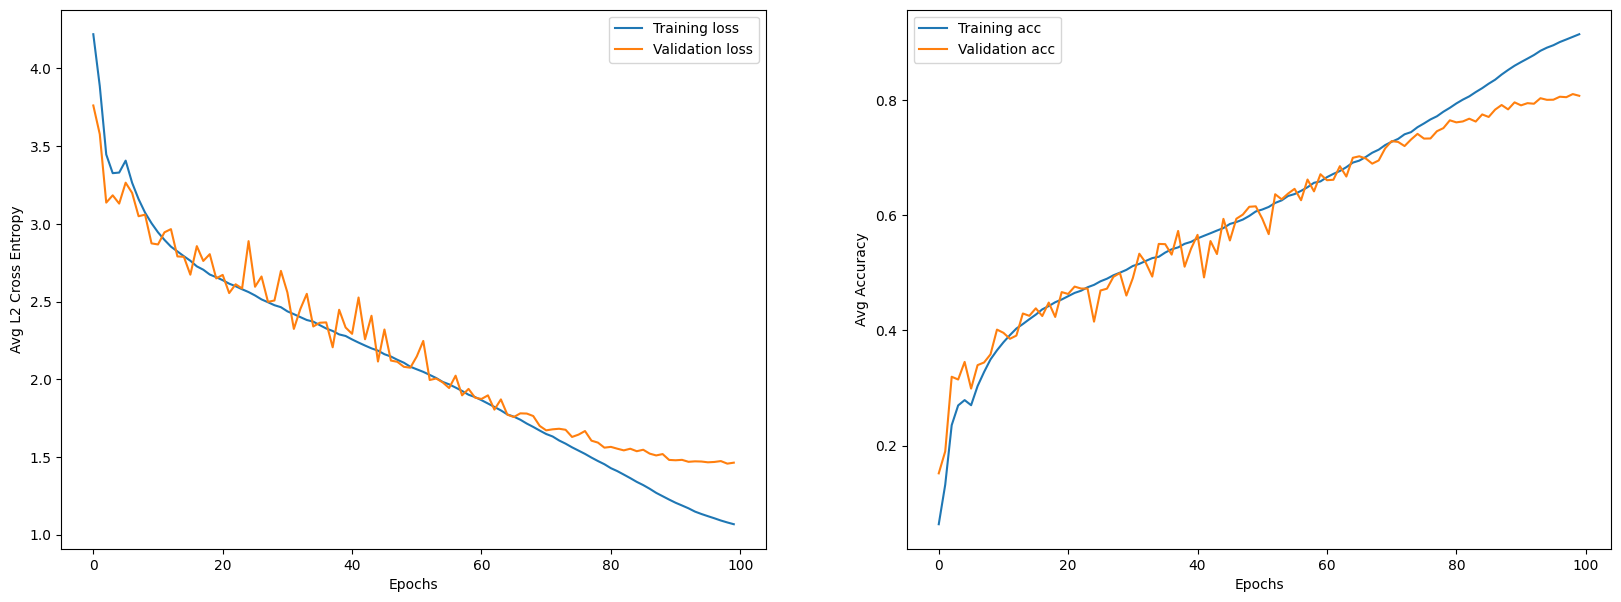

In [17]:
# Plot results
plt.figure(figsize=[20,7])
plt.subplot(1,2,1)
plt.plot(range(100), res_df['Loss'], label='Training loss')
plt.plot(range(100), res_df['Val_Loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Avg L2 Cross Entropy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(100), res_df['Accuracy'], label='Training acc')
plt.plot(range(100), res_df['Val_Accuracy'], label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Avg Accuracy')
plt.legend();

## 2.2 - Testing and Saving

In [18]:
# Test the model on the validation set
utils.eval_model(
    model=baseline,
    device=device,
    data_loader=test_dataloader
)

  0%|          | 0/313 [00:00<?, ?batch/s]

EVALUATION COMPLETED - Avg Accuracy: 80.73%


0.8073083067092651

In [19]:
# Save the model
utils.save_experiment(root='./experiments', model=baseline, seed=SEED, settings=settings, metrics_df=res_df)

# 3 - SuperNet on MobileNetV3

Now we solve the **Differentiable Neural Architecture Search** (**DNAS**) problem, by applying the **SuperNet** method on MobileNetV3.

The targeted block is **Squeeze and Excite**, a verty important block that helps MBNV3 in extracting interchannel information adding little computation overhead.

However, SE modules are fully connected layers, which may be a limitation depending on the target device of execution. Thus, our scenario of application of SuperNet on MBNV3 is completely removing each Squeeze and Excite module, and replacing it with a convolutional one chosen among a poole of possible alternatives. 

In [30]:
# Seed network
seed = torch.load(f'./main_models/MobileNetV3_init_seed{SEED}.pt', weights_only=False)
seed

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

## 3.1 - How to build the SuperNet
The alternatives that we are going to consider are:
1. a standard **ConvBNReLU** module;
2. a ConvBNReLU module that performs **point-wise convolution**;
3. a **Depth-wise Separable ConvBN** module.

**_REMARK 1_**: each one of these modules tends to be heavier in terms of number parameters than Squeeze and Excite. Thus, we are going to use more filters per convolutional layers in these modules, so that the number of parameters similar to baseline. 

**_REMARK 2_**: this is just an example on how to instantiate the SuperNet. In following experiments `utils.baseline_SuperNet()` will be used, in order to avoid repeating code.

In [31]:
torch.manual_seed(SEED)

alt_dict = torch.nn.ModuleDict()

# Alternative instantiations
for module in seed.named_modules():
    if module[1].__class__.__name__ == 'SqueezeExcitation':
        alt_1 = ConvBNRelu(in_channels=module[1].fc1.in_channels, out_channels=module[1].fc2.out_channels, groups=24)
        alt_2 = ConvBNRelu(in_channels=module[1].fc1.in_channels, out_channels=module[1].fc2.out_channels, groups=2, point=True)
        alt_3 = DepthwiseSeparableConv(in_channels=module[1].fc1.in_channels, out_channels=module[1].fc2.out_channels, point_groups=2, bnorm=True)
        key = '/'.join(module[0].split('.'))
        alt_dict[key] = torch.nn.ModuleList([alt_1, alt_2, alt_3]) 

        print(f'{key}:')
        print(f'\t- #Parameters SqueezeExcitation: {sum(p.numel() for p in module[1].parameters() if p.requires_grad)}')
        print(f'\t- #Parameters Standard ConvBNRelu (24 filters): {sum(p.numel() for p in alt_1.parameters() if p.requires_grad)}')
        print(f'\t- #Parameters Point-wise ConvBNRelu (2 filters): {sum(p.numel() for p in alt_2.parameters() if p.requires_grad)}')
        print(f'\t- #Parameters Depth-wise Separable ConvBN (2 filters): {sum(p.numel() for p in alt_3.parameters() if p.requires_grad)}\n')

features/4/block/2:
	- #Parameters SqueezeExcitation: 3552
	- #Parameters Standard ConvBNRelu (24 filters): 2160
	- #Parameters Point-wise ConvBNRelu (2 filters): 2808
	- #Parameters Depth-wise Separable ConvBN (2 filters): 3672

features/5/block/2:
	- #Parameters SqueezeExcitation: 7832
	- #Parameters Standard ConvBNRelu (24 filters): 5760
	- #Parameters Point-wise ConvBNRelu (2 filters): 7560
	- #Parameters Depth-wise Separable ConvBN (2 filters): 9000

features/6/block/2:
	- #Parameters SqueezeExcitation: 7832
	- #Parameters Standard ConvBNRelu (24 filters): 5760
	- #Parameters Point-wise ConvBNRelu (2 filters): 7560
	- #Parameters Depth-wise Separable ConvBN (2 filters): 9000

features/11/block/2:
	- #Parameters SqueezeExcitation: 115800
	- #Parameters Standard ConvBNRelu (24 filters): 87840
	- #Parameters Point-wise ConvBNRelu (2 filters): 116640
	- #Parameters Depth-wise Separable ConvBN (2 filters): 122400

features/12/block/2:
	- #Parameters SqueezeExcitation: 226632
	- #Parame

In [32]:
# SuperNet instantiation
random_sample = train_dataset[torch.randint(high=len(train_dataset), size=(1,))][0]
SuperNet_model = SuperNet(seed=seed, branches=alt_dict, input_shape=random_sample.shape)

SuperNet_model

SuperNet(
  (seed): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
   

## 3.2 - Experiment 1: Soundness of SuperNet

The following experiment is going to show the "soundess" of the methodology in chooisng the best alternatives.

With respect to the alternatives defined above, in the `DepthwiseSeparableConv` module, we <u>are dropping the _Batch Normalization_ layer</u>, and the training process minimizes only the CrossEntropy loss <u>without L2 regularization</u>.

**_REMARK_**: the result of this experiment will not be compared with the baseline MBNV3, since missing L2 regularization. 

### 3.2.1 Building the SuperNet for the experiment

In [14]:
torch.manual_seed(SEED)

# Seed network
seed = torch.load(f'./main_models/MobileNetV3_init_seed{SEED}.pt', weights_only=False)

# Alternatives instantiation
alt_dict = torch.nn.ModuleDict()
for module in seed.named_modules():
    if module[1].__class__.__name__ == 'SqueezeExcitation':
        alt_1 = ConvBNRelu(in_channels=module[1].fc1.in_channels, out_channels=module[1].fc2.out_channels, groups=24)
        alt_2 = ConvBNRelu(in_channels=module[1].fc1.in_channels, out_channels=module[1].fc2.out_channels, groups=2, point=True)
        alt_3 = DepthwiseSeparableConv(in_channels=module[1].fc1.in_channels, out_channels=module[1].fc2.out_channels, point_groups=2) # No batch normalization
        key = '/'.join(module[0].split('.'))
        alt_dict[key] = torch.nn.ModuleList([alt_1, alt_2, alt_3])

        print(f'{key}:')
        print(f'\t- #Parameters SqueezeExcitation: {sum(p.numel() for p in module[1].parameters() if p.requires_grad)}')
        print(f'\t- #Parameters Standard ConvBNRelu (24 filters): {sum(p.numel() for p in alt_1.parameters() if p.requires_grad)}')
        print(f'\t- #Parameters Point-wise ConvBNRelu (2 filters): {sum(p.numel() for p in alt_2.parameters() if p.requires_grad)}')
        print(f'\t- #Parameters Depth-wise Separable ConvBN (2 filters): {sum(p.numel() for p in alt_3.parameters() if p.requires_grad)}\n')

features/4/block/2:
	- #Parameters SqueezeExcitation: 3552
	- #Parameters Standard ConvBNRelu (24 filters): 2160
	- #Parameters Point-wise ConvBNRelu (2 filters): 2808
	- #Parameters Depth-wise Separable ConvBN (2 filters): 3384

features/5/block/2:
	- #Parameters SqueezeExcitation: 7832
	- #Parameters Standard ConvBNRelu (24 filters): 5760
	- #Parameters Point-wise ConvBNRelu (2 filters): 7560
	- #Parameters Depth-wise Separable ConvBN (2 filters): 8520

features/6/block/2:
	- #Parameters SqueezeExcitation: 7832
	- #Parameters Standard ConvBNRelu (24 filters): 5760
	- #Parameters Point-wise ConvBNRelu (2 filters): 7560
	- #Parameters Depth-wise Separable ConvBN (2 filters): 8520

features/11/block/2:
	- #Parameters SqueezeExcitation: 115800
	- #Parameters Standard ConvBNRelu (24 filters): 87840
	- #Parameters Point-wise ConvBNRelu (2 filters): 116640
	- #Parameters Depth-wise Separable ConvBN (2 filters): 120480

features/12/block/2:
	- #Parameters SqueezeExcitation: 226632
	- #Parame

In [15]:
# SuperNet instantiation
random_sample = train_dataset[torch.randint(high=len(train_dataset), size=(1,))][0]
SuperNet_model = SuperNet(seed=seed, branches=alt_dict, input_shape=random_sample.shape)

SuperNet_model

SuperNet(
  (seed): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
   

### 3.2.2 - Training

In [16]:
settings = {
    'epochs': 100,
    'lr': 0.2,
    'loss': 'CrossEntropy',
    'label_smoothing': 0.1,
    'momentum': 0.9,
}

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
# Loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=settings['label_smoothing'])
optimizer = torch.optim.SGD(params=SuperNet_model.parameters(), lr=settings['lr'], momentum=settings['momentum'])

# Scheduler and warmup
main_shceduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=settings['epochs'])
warmup = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer, start_factor=0.01, total_iters=5) # Linear warmup
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=optimizer, schedulers=[warmup, main_shceduler], milestones=[5])

In [19]:
# Train the model
loss_h, acc_h, val_loss_h, val_acc_h = utils.train_model(
    model=SuperNet_model,
    device=device,
    data_loader=train_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    lr_scheduler=scheduler,
    val_dataloader=test_dataloader,
    seed=SEED
)

*********************
EPOCH 0 on cuda - Current learning rate: 0.0020



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 6.03243 | Avg Accuracy: 1.38%
Computed 1999/8125 batches - Avg Loss: 5.53796 | Avg Accuracy: 1.69%
Computed 2999/8125 batches - Avg Loss: 5.35753 | Avg Accuracy: 1.79%
Computed 3999/8125 batches - Avg Loss: 5.25669 | Avg Accuracy: 1.95%
Computed 4999/8125 batches - Avg Loss: 5.18224 | Avg Accuracy: 2.28%
Computed 5999/8125 batches - Avg Loss: 5.12010 | Avg Accuracy: 2.64%
Computed 6999/8125 batches - Avg Loss: 5.06915 | Avg Accuracy: 2.99%
Computed 7999/8125 batches - Avg Loss: 5.02548 | Avg Accuracy: 3.30%

End of EPOCH 0 - Avg Loss: 5.02012 | Avg Accuracy: 3.35%
Training time: 551.153 seconds.

DNAS parameters:
	- features.4.block.2: [[0.3627942204475403, 0.44451382756233215, 0.19269117712974548]]
	- features.5.block.2: [[0.3550405204296112, 0.3427204489707947, 0.30223721265792847]]
	- features.6.block.2: [[0.3474596440792084, 0.3218444585800171, 0.3306936025619507]]
	- features.11.block.2: [[0.3314114212989807, 0.39414671063423157, 0.2744414210

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 4.15%
*********************
EPOCH 1 on cuda - Current learning rate: 0.0416



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 5.09693 | Avg Accuracy: 2.60%
Computed 1999/8125 batches - Avg Loss: 4.95053 | Avg Accuracy: 3.60%
Computed 2999/8125 batches - Avg Loss: 4.86708 | Avg Accuracy: 4.31%
Computed 3999/8125 batches - Avg Loss: 4.80429 | Avg Accuracy: 5.05%
Computed 4999/8125 batches - Avg Loss: 4.74156 | Avg Accuracy: 5.94%
Computed 5999/8125 batches - Avg Loss: 4.68696 | Avg Accuracy: 6.77%
Computed 6999/8125 batches - Avg Loss: 4.63715 | Avg Accuracy: 7.54%
Computed 7999/8125 batches - Avg Loss: 4.59099 | Avg Accuracy: 8.38%

End of EPOCH 1 - Avg Loss: 4.58475 | Avg Accuracy: 8.50%
Training time: 548.118 seconds.

DNAS parameters:
	- features.4.block.2: [[0.8811689019203186, 1.7411173582077026, -1.6222885847091675]]
	- features.5.block.2: [[0.6882093548774719, 0.5432880520820618, -0.2314995676279068]]
	- features.6.block.2: [[-0.021010732278227806, 0.8357903957366943, 0.18521621823310852]]
	- features.11.block.2: [[-0.5214001536369324, 2.3324203491210938, -0.811014

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 14.06%
*********************
EPOCH 2 on cuda - Current learning rate: 0.0812



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 4.36393 | Avg Accuracy: 12.15%
Computed 1999/8125 batches - Avg Loss: 4.30831 | Avg Accuracy: 13.03%
Computed 2999/8125 batches - Avg Loss: 4.26931 | Avg Accuracy: 14.00%
Computed 3999/8125 batches - Avg Loss: 4.23650 | Avg Accuracy: 14.75%
Computed 4999/8125 batches - Avg Loss: 4.20416 | Avg Accuracy: 15.38%
Computed 5999/8125 batches - Avg Loss: 4.17363 | Avg Accuracy: 15.96%
Computed 6999/8125 batches - Avg Loss: 4.14361 | Avg Accuracy: 16.57%
Computed 7999/8125 batches - Avg Loss: 4.11482 | Avg Accuracy: 17.21%

End of EPOCH 2 - Avg Loss: 4.11164 | Avg Accuracy: 17.27%
Training time: 552.821 seconds.

DNAS parameters:
	- features.4.block.2: [[-0.027180327102541924, 3.8553483486175537, -2.828160285949707]]
	- features.5.block.2: [[1.442380666732788, 0.6049820780754089, -1.0473605394363403]]
	- features.6.block.2: [[-0.34579363465309143, 1.7502368688583374, -0.4044480323791504]]
	- features.11.block.2: [[-1.5211765766143799, 4.1277642250061035, 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 26.72%
*********************
EPOCH 3 on cuda - Current learning rate: 0.1208



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 4.06569 | Avg Accuracy: 18.61%
Computed 1999/8125 batches - Avg Loss: 4.03795 | Avg Accuracy: 19.31%
Computed 2999/8125 batches - Avg Loss: 4.01822 | Avg Accuracy: 19.77%
Computed 3999/8125 batches - Avg Loss: 3.99924 | Avg Accuracy: 20.24%
Computed 4999/8125 batches - Avg Loss: 3.97821 | Avg Accuracy: 20.60%
Computed 5999/8125 batches - Avg Loss: 3.95561 | Avg Accuracy: 21.18%
Computed 6999/8125 batches - Avg Loss: 3.93602 | Avg Accuracy: 21.60%
Computed 7999/8125 batches - Avg Loss: 3.91929 | Avg Accuracy: 22.00%

End of EPOCH 3 - Avg Loss: 3.91602 | Avg Accuracy: 22.06%
Training time: 553.720 seconds.

DNAS parameters:
	- features.4.block.2: [[-1.1329501867294312, 5.51281213760376, -3.379875659942627]]
	- features.5.block.2: [[2.168566942214966, 0.4755491018295288, -1.6441106796264648]]
	- features.6.block.2: [[-0.7580880522727966, 2.8095755577087402, -1.0514949560165405]]
	- features.11.block.2: [[-2.1056511402130127, 5.042653560638428, -1.936

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 26.62%
*********************
EPOCH 4 on cuda - Current learning rate: 0.1604



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.95186 | Avg Accuracy: 22.56%
Computed 1999/8125 batches - Avg Loss: 3.93495 | Avg Accuracy: 22.48%
Computed 2999/8125 batches - Avg Loss: 3.92100 | Avg Accuracy: 22.66%
Computed 3999/8125 batches - Avg Loss: 3.91299 | Avg Accuracy: 22.84%
Computed 4999/8125 batches - Avg Loss: 3.88929 | Avg Accuracy: 23.27%
Computed 5999/8125 batches - Avg Loss: 3.87345 | Avg Accuracy: 23.64%
Computed 6999/8125 batches - Avg Loss: 3.85691 | Avg Accuracy: 24.09%
Computed 7999/8125 batches - Avg Loss: 3.84341 | Avg Accuracy: 24.37%

End of EPOCH 4 - Avg Loss: 3.84090 | Avg Accuracy: 24.40%
Training time: 553.309 seconds.

DNAS parameters:
	- features.4.block.2: [[-1.7085609436035156, 6.784951686859131, -4.076401710510254]]
	- features.5.block.2: [[2.4546003341674805, 0.3657977879047394, -1.8204056024551392]]
	- features.6.block.2: [[-1.3202946186065674, 3.7830116748809814, -1.4627267122268677]]
	- features.11.block.2: [[-2.5534305572509766, 6.273721694946289, -2.7

/home/tiziano-tezze/ProgramFiles/miniconda3/envs/cv-project/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 31.37%
*********************
EPOCH 5 on cuda - Current learning rate: 0.2000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.87596 | Avg Accuracy: 24.56%
Computed 1999/8125 batches - Avg Loss: 3.89377 | Avg Accuracy: 24.18%
Computed 2999/8125 batches - Avg Loss: 3.89434 | Avg Accuracy: 24.22%
Computed 3999/8125 batches - Avg Loss: 3.88557 | Avg Accuracy: 24.52%
Computed 4999/8125 batches - Avg Loss: 3.87867 | Avg Accuracy: 24.72%
Computed 5999/8125 batches - Avg Loss: 3.86985 | Avg Accuracy: 24.92%
Computed 6999/8125 batches - Avg Loss: 3.85767 | Avg Accuracy: 25.16%
Computed 7999/8125 batches - Avg Loss: 3.84496 | Avg Accuracy: 25.47%

End of EPOCH 5 - Avg Loss: 3.84308 | Avg Accuracy: 25.50%
Training time: 552.900 seconds.

DNAS parameters:
	- features.4.block.2: [[-1.7893900871276855, 6.85536527633667, -4.066007614135742]]
	- features.5.block.2: [[3.456519365310669, -0.003115135245025158, -2.4534122943878174]]
	- features.6.block.2: [[-1.374078392982483, 4.25852632522583, -1.884444236755371]]
	- features.11.block.2: [[-2.793126106262207, 7.011229991912842, -3.21808

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 28.35%
*********************
EPOCH 6 on cuda - Current learning rate: 0.2000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.71163 | Avg Accuracy: 28.80%
Computed 1999/8125 batches - Avg Loss: 3.69191 | Avg Accuracy: 29.05%
Computed 2999/8125 batches - Avg Loss: 3.69337 | Avg Accuracy: 29.06%
Computed 3999/8125 batches - Avg Loss: 3.68214 | Avg Accuracy: 29.52%
Computed 4999/8125 batches - Avg Loss: 3.66908 | Avg Accuracy: 29.84%
Computed 5999/8125 batches - Avg Loss: 3.65685 | Avg Accuracy: 30.11%
Computed 6999/8125 batches - Avg Loss: 3.65024 | Avg Accuracy: 30.20%
Computed 7999/8125 batches - Avg Loss: 3.64167 | Avg Accuracy: 30.35%

End of EPOCH 6 - Avg Loss: 3.63929 | Avg Accuracy: 30.38%
Training time: 549.205 seconds.

DNAS parameters:
	- features.4.block.2: [[-1.7694149017333984, 6.874793529510498, -4.1053972244262695]]
	- features.5.block.2: [[4.063487529754639, -0.24940551817417145, -2.8140857219696045]]
	- features.6.block.2: [[-1.6614925861358643, 4.683177471160889, -2.0217080116271973]]
	- features.11.block.2: [[-2.7829771041870117, 7.131396770477295, -3.

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 36.30%
*********************
EPOCH 7 on cuda - Current learning rate: 0.1998



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.54173 | Avg Accuracy: 32.53%
Computed 1999/8125 batches - Avg Loss: 3.52529 | Avg Accuracy: 33.03%
Computed 2999/8125 batches - Avg Loss: 3.52151 | Avg Accuracy: 33.06%
Computed 3999/8125 batches - Avg Loss: 3.51795 | Avg Accuracy: 33.19%
Computed 4999/8125 batches - Avg Loss: 3.51158 | Avg Accuracy: 33.25%
Computed 5999/8125 batches - Avg Loss: 3.50469 | Avg Accuracy: 33.43%
Computed 6999/8125 batches - Avg Loss: 3.49440 | Avg Accuracy: 33.66%
Computed 7999/8125 batches - Avg Loss: 3.48494 | Avg Accuracy: 33.92%

End of EPOCH 7 - Avg Loss: 3.48382 | Avg Accuracy: 33.94%
Training time: 551.160 seconds.

DNAS parameters:
	- features.4.block.2: [[-1.775184154510498, 6.852117538452148, -4.076953411102295]]
	- features.5.block.2: [[4.486039638519287, -0.533588707447052, -2.952441930770874]]
	- features.6.block.2: [[-1.9070408344268799, 5.334456443786621, -2.4274275302886963]]
	- features.11.block.2: [[-2.829897165298462, 7.1846818923950195, -3.35474

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 37.04%
*********************
EPOCH 8 on cuda - Current learning rate: 0.1996



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.38474 | Avg Accuracy: 36.34%
Computed 1999/8125 batches - Avg Loss: 3.38402 | Avg Accuracy: 36.11%
Computed 2999/8125 batches - Avg Loss: 3.38875 | Avg Accuracy: 36.17%
Computed 3999/8125 batches - Avg Loss: 3.37719 | Avg Accuracy: 36.44%
Computed 4999/8125 batches - Avg Loss: 3.37445 | Avg Accuracy: 36.49%
Computed 5999/8125 batches - Avg Loss: 3.37205 | Avg Accuracy: 36.58%
Computed 6999/8125 batches - Avg Loss: 3.37052 | Avg Accuracy: 36.66%
Computed 7999/8125 batches - Avg Loss: 3.36623 | Avg Accuracy: 36.72%

End of EPOCH 8 - Avg Loss: 3.36508 | Avg Accuracy: 36.74%
Training time: 552.993 seconds.

DNAS parameters:
	- features.4.block.2: [[-2.1245388984680176, 7.353959560394287, -4.229412078857422]]
	- features.5.block.2: [[4.395973205566406, -0.2921410799026489, -3.103780508041382]]
	- features.6.block.2: [[-1.9913941621780396, 5.574636459350586, -2.583273410797119]]
	- features.11.block.2: [[-2.760751724243164, 7.198562145233154, -3.43776

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 43.67%
*********************
EPOCH 9 on cuda - Current learning rate: 0.1992



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.26112 | Avg Accuracy: 39.17%
Computed 1999/8125 batches - Avg Loss: 3.26271 | Avg Accuracy: 38.93%
Computed 2999/8125 batches - Avg Loss: 3.26891 | Avg Accuracy: 38.88%
Computed 3999/8125 batches - Avg Loss: 3.26594 | Avg Accuracy: 39.01%
Computed 4999/8125 batches - Avg Loss: 3.26644 | Avg Accuracy: 39.06%
Computed 5999/8125 batches - Avg Loss: 3.26566 | Avg Accuracy: 39.12%
Computed 6999/8125 batches - Avg Loss: 3.26273 | Avg Accuracy: 39.29%
Computed 7999/8125 batches - Avg Loss: 3.26028 | Avg Accuracy: 39.37%

End of EPOCH 9 - Avg Loss: 3.25977 | Avg Accuracy: 39.38%
Training time: 551.480 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.4745993614196777, 8.622398376464844, -4.147791385650635]]
	- features.5.block.2: [[4.763206958770752, -0.6046156287193298, -3.1585304737091064]]
	- features.6.block.2: [[-2.049131155014038, 5.8906049728393555, -2.8414783477783203]]
	- features.11.block.2: [[-2.9246349334716797, 7.346925258636475, -3.42

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 44.17%
*********************
EPOCH 10 on cuda - Current learning rate: 0.1988



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.16724 | Avg Accuracy: 41.64%
Computed 1999/8125 batches - Avg Loss: 3.18313 | Avg Accuracy: 41.11%
Computed 2999/8125 batches - Avg Loss: 3.19014 | Avg Accuracy: 40.87%
Computed 3999/8125 batches - Avg Loss: 3.26457 | Avg Accuracy: 39.51%
Computed 4999/8125 batches - Avg Loss: 3.30258 | Avg Accuracy: 38.61%
Computed 5999/8125 batches - Avg Loss: 3.30037 | Avg Accuracy: 38.69%
Computed 6999/8125 batches - Avg Loss: 3.29755 | Avg Accuracy: 38.72%
Computed 7999/8125 batches - Avg Loss: 3.28997 | Avg Accuracy: 38.91%

End of EPOCH 10 - Avg Loss: 3.28903 | Avg Accuracy: 38.92%
Training time: 550.844 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.474358081817627, 8.596553802490234, -4.122195720672607]]
	- features.5.block.2: [[5.017562389373779, -0.804171085357666, -3.213331699371338]]
	- features.6.block.2: [[-2.3390748500823975, 6.2412028312683105, -2.9021410942077637]]
	- features.11.block.2: [[-2.9264791011810303, 7.351129531860352, -3.424

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 43.97%
*********************
EPOCH 11 on cuda - Current learning rate: 0.1982



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.19016 | Avg Accuracy: 41.13%
Computed 1999/8125 batches - Avg Loss: 3.18365 | Avg Accuracy: 41.36%
Computed 2999/8125 batches - Avg Loss: 3.17584 | Avg Accuracy: 41.62%
Computed 3999/8125 batches - Avg Loss: 3.17374 | Avg Accuracy: 41.63%
Computed 4999/8125 batches - Avg Loss: 3.16824 | Avg Accuracy: 41.80%
Computed 5999/8125 batches - Avg Loss: 3.16441 | Avg Accuracy: 41.96%
Computed 6999/8125 batches - Avg Loss: 3.15801 | Avg Accuracy: 42.08%
Computed 7999/8125 batches - Avg Loss: 3.15296 | Avg Accuracy: 42.18%

End of EPOCH 11 - Avg Loss: 3.15185 | Avg Accuracy: 42.21%
Training time: 552.198 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.4726390838623047, 8.590642929077148, -4.11797571182251]]
	- features.5.block.2: [[5.432585716247559, -1.141237735748291, -3.2912843227386475]]
	- features.6.block.2: [[-2.46224045753479, 6.492037296295166, -3.0298428535461426]]
	- features.11.block.2: [[-2.9088151454925537, 7.496667385101318, -3.58785

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 46.43%
*********************
EPOCH 12 on cuda - Current learning rate: 0.1976



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.08363 | Avg Accuracy: 43.97%
Computed 1999/8125 batches - Avg Loss: 3.06586 | Avg Accuracy: 44.45%
Computed 2999/8125 batches - Avg Loss: 3.06226 | Avg Accuracy: 44.47%
Computed 3999/8125 batches - Avg Loss: 3.05405 | Avg Accuracy: 44.57%
Computed 4999/8125 batches - Avg Loss: 3.05670 | Avg Accuracy: 44.60%
Computed 5999/8125 batches - Avg Loss: 3.05656 | Avg Accuracy: 44.61%
Computed 6999/8125 batches - Avg Loss: 3.05982 | Avg Accuracy: 44.51%
Computed 7999/8125 batches - Avg Loss: 3.05707 | Avg Accuracy: 44.54%

End of EPOCH 12 - Avg Loss: 3.05598 | Avg Accuracy: 44.54%
Training time: 551.950 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.4673852920532227, 8.599867820739746, -4.132417678833008]]
	- features.5.block.2: [[5.657515048980713, -1.2869843244552612, -3.3704657554626465]]
	- features.6.block.2: [[-2.5032601356506348, 6.539656639099121, -3.036431074142456]]
	- features.11.block.2: [[-2.910231590270996, 7.460540294647217, -3.550

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 50.12%
*********************
EPOCH 13 on cuda - Current learning rate: 0.1969



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.98848 | Avg Accuracy: 45.72%
Computed 1999/8125 batches - Avg Loss: 2.98408 | Avg Accuracy: 46.19%
Computed 2999/8125 batches - Avg Loss: 2.99139 | Avg Accuracy: 46.09%
Computed 3999/8125 batches - Avg Loss: 2.99356 | Avg Accuracy: 45.92%
Computed 4999/8125 batches - Avg Loss: 2.98939 | Avg Accuracy: 46.08%
Computed 5999/8125 batches - Avg Loss: 2.98773 | Avg Accuracy: 46.17%
Computed 6999/8125 batches - Avg Loss: 2.98663 | Avg Accuracy: 46.27%
Computed 7999/8125 batches - Avg Loss: 2.98641 | Avg Accuracy: 46.33%

End of EPOCH 13 - Avg Loss: 2.98576 | Avg Accuracy: 46.32%
Training time: 550.117 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.4635443687438965, 8.559707641601562, -4.096137523651123]]
	- features.5.block.2: [[5.814940929412842, -1.5219035148620605, -3.2929797172546387]]
	- features.6.block.2: [[-2.598676919937134, 6.6649017333984375, -3.066279411315918]]
	- features.11.block.2: [[-2.9678122997283936, 7.515772342681885, -3.54

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.76%
*********************
EPOCH 14 on cuda - Current learning rate: 0.1960



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.91609 | Avg Accuracy: 47.95%
Computed 1999/8125 batches - Avg Loss: 2.92105 | Avg Accuracy: 47.69%
Computed 2999/8125 batches - Avg Loss: 2.92949 | Avg Accuracy: 47.51%
Computed 3999/8125 batches - Avg Loss: 2.92589 | Avg Accuracy: 47.60%
Computed 4999/8125 batches - Avg Loss: 2.92524 | Avg Accuracy: 47.67%
Computed 5999/8125 batches - Avg Loss: 2.92452 | Avg Accuracy: 47.64%
Computed 6999/8125 batches - Avg Loss: 2.92460 | Avg Accuracy: 47.66%
Computed 7999/8125 batches - Avg Loss: 2.92825 | Avg Accuracy: 47.62%

End of EPOCH 14 - Avg Loss: 2.92706 | Avg Accuracy: 47.65%
Training time: 554.055 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.4620633125305176, 8.53876781463623, -4.076666831970215]]
	- features.5.block.2: [[5.7264227867126465, -1.4002925157546997, -3.326077461242676]]
	- features.6.block.2: [[-2.6347975730895996, 6.727540493011475, -3.0927951335906982]]
	- features.11.block.2: [[-2.968019723892212, 7.658839225769043, -3.690

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 50.62%
*********************
EPOCH 15 on cuda - Current learning rate: 0.1951



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.88247 | Avg Accuracy: 49.69%
Computed 1999/8125 batches - Avg Loss: 2.89007 | Avg Accuracy: 49.29%
Computed 2999/8125 batches - Avg Loss: 2.87574 | Avg Accuracy: 49.42%
Computed 3999/8125 batches - Avg Loss: 2.88000 | Avg Accuracy: 49.26%
Computed 4999/8125 batches - Avg Loss: 2.87789 | Avg Accuracy: 49.21%
Computed 5999/8125 batches - Avg Loss: 2.87405 | Avg Accuracy: 49.26%
Computed 6999/8125 batches - Avg Loss: 2.86996 | Avg Accuracy: 49.33%
Computed 7999/8125 batches - Avg Loss: 2.86570 | Avg Accuracy: 49.37%

End of EPOCH 15 - Avg Loss: 2.86527 | Avg Accuracy: 49.37%
Training time: 552.525 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.463758707046509, 8.551512718200684, -4.087733268737793]]
	- features.5.block.2: [[5.759809970855713, -1.5331982374191284, -3.2265682220458984]]
	- features.6.block.2: [[-2.3608734607696533, 6.527493953704834, -3.1666722297668457]]
	- features.11.block.2: [[-3.064441442489624, 7.760847091674805, -3.696

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 52.98%
*********************
EPOCH 16 on cuda - Current learning rate: 0.1941



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.79755 | Avg Accuracy: 51.16%
Computed 1999/8125 batches - Avg Loss: 2.79680 | Avg Accuracy: 51.01%
Computed 2999/8125 batches - Avg Loss: 2.80087 | Avg Accuracy: 50.76%
Computed 3999/8125 batches - Avg Loss: 2.80150 | Avg Accuracy: 50.93%
Computed 4999/8125 batches - Avg Loss: 2.80101 | Avg Accuracy: 50.95%
Computed 5999/8125 batches - Avg Loss: 2.80324 | Avg Accuracy: 50.93%
Computed 6999/8125 batches - Avg Loss: 2.80122 | Avg Accuracy: 50.96%
Computed 7999/8125 batches - Avg Loss: 2.80103 | Avg Accuracy: 50.92%

End of EPOCH 16 - Avg Loss: 2.80074 | Avg Accuracy: 50.92%
Training time: 552.368 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.507740020751953, 8.597455024719238, -4.089705944061279]]
	- features.5.block.2: [[5.989389896392822, -1.703232765197754, -3.2861180305480957]]
	- features.6.block.2: [[-2.5286717414855957, 6.689708232879639, -3.1610896587371826]]
	- features.11.block.2: [[-3.067044973373413, 7.845537185668945, -3.7785

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.67%
*********************
EPOCH 17 on cuda - Current learning rate: 0.1930



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.71194 | Avg Accuracy: 52.88%
Computed 1999/8125 batches - Avg Loss: 2.72979 | Avg Accuracy: 52.56%
Computed 2999/8125 batches - Avg Loss: 2.74294 | Avg Accuracy: 52.44%
Computed 3999/8125 batches - Avg Loss: 2.74986 | Avg Accuracy: 52.34%
Computed 4999/8125 batches - Avg Loss: 2.74838 | Avg Accuracy: 52.29%
Computed 5999/8125 batches - Avg Loss: 2.75252 | Avg Accuracy: 52.20%
Computed 6999/8125 batches - Avg Loss: 2.75322 | Avg Accuracy: 52.16%
Computed 7999/8125 batches - Avg Loss: 2.74970 | Avg Accuracy: 52.24%

End of EPOCH 17 - Avg Loss: 2.74969 | Avg Accuracy: 52.22%
Training time: 549.984 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.495661973953247, 8.571127891540527, -4.075442314147949]]
	- features.5.block.2: [[5.972022533416748, -1.6890621185302734, -3.2829153537750244]]
	- features.6.block.2: [[-2.5952978134155273, 6.6910881996154785, -3.095829963684082]]
	- features.11.block.2: [[-3.0892820358276367, 7.887270450592041, -3.79

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 54.55%
*********************
EPOCH 18 on cuda - Current learning rate: 0.1918



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.67678 | Avg Accuracy: 54.07%
Computed 1999/8125 batches - Avg Loss: 2.68180 | Avg Accuracy: 53.66%
Computed 2999/8125 batches - Avg Loss: 2.68243 | Avg Accuracy: 53.66%
Computed 3999/8125 batches - Avg Loss: 2.68956 | Avg Accuracy: 53.52%
Computed 4999/8125 batches - Avg Loss: 2.69386 | Avg Accuracy: 53.38%
Computed 5999/8125 batches - Avg Loss: 2.69290 | Avg Accuracy: 53.35%
Computed 6999/8125 batches - Avg Loss: 2.69742 | Avg Accuracy: 53.14%
Computed 7999/8125 batches - Avg Loss: 2.69831 | Avg Accuracy: 53.14%

End of EPOCH 18 - Avg Loss: 2.69818 | Avg Accuracy: 53.13%
Training time: 548.294 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.4892759323120117, 8.578021049499512, -4.0887603759765625]]
	- features.5.block.2: [[6.1144304275512695, -1.808111310005188, -3.306288003921509]]
	- features.6.block.2: [[-2.5331287384033203, 6.687310695648193, -3.1542093753814697]]
	- features.11.block.2: [[-2.963871717453003, 7.882080554962158, -3.91

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 56.15%
*********************
EPOCH 19 on cuda - Current learning rate: 0.1905



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.62040 | Avg Accuracy: 55.34%
Computed 1999/8125 batches - Avg Loss: 2.64490 | Avg Accuracy: 54.43%
Computed 2999/8125 batches - Avg Loss: 2.63775 | Avg Accuracy: 54.67%
Computed 3999/8125 batches - Avg Loss: 2.64450 | Avg Accuracy: 54.60%
Computed 4999/8125 batches - Avg Loss: 2.64813 | Avg Accuracy: 54.56%
Computed 5999/8125 batches - Avg Loss: 2.65467 | Avg Accuracy: 54.44%
Computed 6999/8125 batches - Avg Loss: 2.65620 | Avg Accuracy: 54.40%
Computed 7999/8125 batches - Avg Loss: 2.65527 | Avg Accuracy: 54.43%

End of EPOCH 19 - Avg Loss: 2.65518 | Avg Accuracy: 54.44%
Training time: 549.847 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.4850611686706543, 8.595601081848145, -4.1105828285217285]]
	- features.5.block.2: [[6.117373943328857, -1.7548335790634155, -3.3624978065490723]]
	- features.6.block.2: [[-2.5415289402008057, 6.726349353790283, -3.184858798980713]]
	- features.11.block.2: [[-2.934579372406006, 7.864497184753418, -3.92

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 58.09%
*********************
EPOCH 20 on cuda - Current learning rate: 0.1891



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.59738 | Avg Accuracy: 56.31%
Computed 1999/8125 batches - Avg Loss: 2.59881 | Avg Accuracy: 55.95%
Computed 2999/8125 batches - Avg Loss: 2.60168 | Avg Accuracy: 55.81%
Computed 3999/8125 batches - Avg Loss: 2.60551 | Avg Accuracy: 55.82%
Computed 4999/8125 batches - Avg Loss: 2.60542 | Avg Accuracy: 55.81%
Computed 5999/8125 batches - Avg Loss: 2.61274 | Avg Accuracy: 55.59%
Computed 6999/8125 batches - Avg Loss: 2.61397 | Avg Accuracy: 55.57%
Computed 7999/8125 batches - Avg Loss: 2.61287 | Avg Accuracy: 55.59%

End of EPOCH 20 - Avg Loss: 2.61276 | Avg Accuracy: 55.55%
Training time: 550.115 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.487048864364624, 8.60168743133545, -4.114714622497559]]
	- features.5.block.2: [[6.212996482849121, -1.818852186203003, -3.3940892219543457]]
	- features.6.block.2: [[-2.5288422107696533, 6.712746620178223, -3.1839497089385986]]
	- features.11.block.2: [[-2.9226937294006348, 7.845783710479736, -3.9230

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 55.01%
*********************
EPOCH 21 on cuda - Current learning rate: 0.1876



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.55148 | Avg Accuracy: 57.16%
Computed 1999/8125 batches - Avg Loss: 2.55983 | Avg Accuracy: 56.84%
Computed 2999/8125 batches - Avg Loss: 2.55750 | Avg Accuracy: 56.92%
Computed 3999/8125 batches - Avg Loss: 2.56093 | Avg Accuracy: 56.91%
Computed 4999/8125 batches - Avg Loss: 2.55986 | Avg Accuracy: 56.99%
Computed 5999/8125 batches - Avg Loss: 2.56516 | Avg Accuracy: 56.86%
Computed 6999/8125 batches - Avg Loss: 2.56819 | Avg Accuracy: 56.78%
Computed 7999/8125 batches - Avg Loss: 2.56877 | Avg Accuracy: 56.74%

End of EPOCH 21 - Avg Loss: 2.56960 | Avg Accuracy: 56.71%
Training time: 548.171 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.5908002853393555, 8.721213340759277, -4.130479335784912]]
	- features.5.block.2: [[6.09605598449707, -1.772074580192566, -3.3239452838897705]]
	- features.6.block.2: [[-2.5362422466278076, 6.864683628082275, -3.328498125076294]]
	- features.11.block.2: [[-2.9990310668945312, 7.935012340545654, -3.9359

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 58.45%
*********************
EPOCH 22 on cuda - Current learning rate: 0.1861



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.51233 | Avg Accuracy: 58.57%
Computed 1999/8125 batches - Avg Loss: 2.51456 | Avg Accuracy: 58.31%
Computed 2999/8125 batches - Avg Loss: 2.52659 | Avg Accuracy: 58.01%
Computed 3999/8125 batches - Avg Loss: 2.52339 | Avg Accuracy: 57.88%
Computed 4999/8125 batches - Avg Loss: 2.52850 | Avg Accuracy: 57.75%
Computed 5999/8125 batches - Avg Loss: 2.52842 | Avg Accuracy: 57.74%
Computed 6999/8125 batches - Avg Loss: 2.52839 | Avg Accuracy: 57.67%
Computed 7999/8125 batches - Avg Loss: 2.52978 | Avg Accuracy: 57.60%

End of EPOCH 22 - Avg Loss: 2.52884 | Avg Accuracy: 57.59%
Training time: 551.423 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.5963833332061768, 8.687280654907227, -4.0909600257873535]]
	- features.5.block.2: [[6.454010009765625, -2.072036027908325, -3.3819565773010254]]
	- features.6.block.2: [[-2.635402202606201, 7.262258052825928, -3.626903533935547]]
	- features.11.block.2: [[-3.013824939727783, 7.941603660583496, -3.9277

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 59.96%
*********************
EPOCH 23 on cuda - Current learning rate: 0.1844



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.44980 | Avg Accuracy: 60.02%
Computed 1999/8125 batches - Avg Loss: 2.46621 | Avg Accuracy: 59.34%
Computed 2999/8125 batches - Avg Loss: 2.47556 | Avg Accuracy: 59.15%
Computed 3999/8125 batches - Avg Loss: 2.47744 | Avg Accuracy: 59.16%
Computed 4999/8125 batches - Avg Loss: 2.48407 | Avg Accuracy: 58.92%
Computed 5999/8125 batches - Avg Loss: 2.48829 | Avg Accuracy: 58.80%
Computed 6999/8125 batches - Avg Loss: 2.49409 | Avg Accuracy: 58.68%
Computed 7999/8125 batches - Avg Loss: 2.49516 | Avg Accuracy: 58.66%

End of EPOCH 23 - Avg Loss: 2.49475 | Avg Accuracy: 58.65%
Training time: 552.969 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.599087953567505, 8.697487831115723, -4.098437309265137]]
	- features.5.block.2: [[6.434071063995361, -2.0928661823272705, -3.341214656829834]]
	- features.6.block.2: [[-2.723294496536255, 7.35633659362793, -3.6331048011779785]]
	- features.11.block.2: [[-3.018756151199341, 7.958945274353027, -3.940157

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 60.88%
*********************
EPOCH 24 on cuda - Current learning rate: 0.1827



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.41589 | Avg Accuracy: 60.36%
Computed 1999/8125 batches - Avg Loss: 2.42320 | Avg Accuracy: 60.16%
Computed 2999/8125 batches - Avg Loss: 2.43008 | Avg Accuracy: 59.98%
Computed 3999/8125 batches - Avg Loss: 2.43919 | Avg Accuracy: 59.79%
Computed 4999/8125 batches - Avg Loss: 2.44353 | Avg Accuracy: 59.77%
Computed 5999/8125 batches - Avg Loss: 2.44827 | Avg Accuracy: 59.69%
Computed 6999/8125 batches - Avg Loss: 2.44633 | Avg Accuracy: 59.72%
Computed 7999/8125 batches - Avg Loss: 2.44810 | Avg Accuracy: 59.68%

End of EPOCH 24 - Avg Loss: 2.44743 | Avg Accuracy: 59.69%
Training time: 550.101 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.5952584743499756, 8.711512565612793, -4.1162309646606445]]
	- features.5.block.2: [[6.466114044189453, -2.1002719402313232, -3.3658668994903564]]
	- features.6.block.2: [[-2.703874111175537, 7.3507256507873535, -3.6469309329986572]]
	- features.11.block.2: [[-3.058655261993408, 8.003745079040527, -3.9

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 61.64%
*********************
EPOCH 25 on cuda - Current learning rate: 0.1809



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.38001 | Avg Accuracy: 60.77%
Computed 1999/8125 batches - Avg Loss: 2.39009 | Avg Accuracy: 60.73%
Computed 2999/8125 batches - Avg Loss: 2.39383 | Avg Accuracy: 60.76%
Computed 3999/8125 batches - Avg Loss: 2.39847 | Avg Accuracy: 60.65%
Computed 4999/8125 batches - Avg Loss: 2.39833 | Avg Accuracy: 60.71%
Computed 5999/8125 batches - Avg Loss: 2.39925 | Avg Accuracy: 60.75%
Computed 6999/8125 batches - Avg Loss: 2.40394 | Avg Accuracy: 60.66%
Computed 7999/8125 batches - Avg Loss: 2.40574 | Avg Accuracy: 60.63%

End of EPOCH 25 - Avg Loss: 2.40607 | Avg Accuracy: 60.61%
Training time: 552.500 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.5965611934661865, 8.7171630859375, -4.120574951171875]]
	- features.5.block.2: [[6.5530500411987305, -2.155669927597046, -3.3973610401153564]]
	- features.6.block.2: [[-2.748283624649048, 7.406360626220703, -3.658149480819702]]
	- features.11.block.2: [[-3.067049980163574, 8.006073951721191, -3.938993

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 61.60%
*********************
EPOCH 26 on cuda - Current learning rate: 0.1790



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.35639 | Avg Accuracy: 62.42%
Computed 1999/8125 batches - Avg Loss: 2.34722 | Avg Accuracy: 62.35%
Computed 2999/8125 batches - Avg Loss: 2.35824 | Avg Accuracy: 62.03%
Computed 3999/8125 batches - Avg Loss: 2.36175 | Avg Accuracy: 61.91%
Computed 4999/8125 batches - Avg Loss: 2.36530 | Avg Accuracy: 61.78%
Computed 5999/8125 batches - Avg Loss: 2.37029 | Avg Accuracy: 61.64%
Computed 6999/8125 batches - Avg Loss: 2.37128 | Avg Accuracy: 61.62%
Computed 7999/8125 batches - Avg Loss: 2.37494 | Avg Accuracy: 61.52%

End of EPOCH 26 - Avg Loss: 2.37524 | Avg Accuracy: 61.47%
Training time: 548.410 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.5998497009277344, 8.714401245117188, -4.114569187164307]]
	- features.5.block.2: [[6.5955491065979, -2.200787305831909, -3.3947787284851074]]
	- features.6.block.2: [[-2.7556087970733643, 7.540979862213135, -3.785444736480713]]
	- features.11.block.2: [[-3.073861598968506, 7.976633548736572, -3.902719

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 62.46%
*********************
EPOCH 27 on cuda - Current learning rate: 0.1771



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.30839 | Avg Accuracy: 63.29%
Computed 1999/8125 batches - Avg Loss: 2.32361 | Avg Accuracy: 62.83%
Computed 2999/8125 batches - Avg Loss: 2.33278 | Avg Accuracy: 62.59%
Computed 3999/8125 batches - Avg Loss: 2.33417 | Avg Accuracy: 62.55%
Computed 4999/8125 batches - Avg Loss: 2.33490 | Avg Accuracy: 62.47%
Computed 5999/8125 batches - Avg Loss: 2.33735 | Avg Accuracy: 62.47%
Computed 6999/8125 batches - Avg Loss: 2.34089 | Avg Accuracy: 62.38%
Computed 7999/8125 batches - Avg Loss: 2.34114 | Avg Accuracy: 62.39%

End of EPOCH 27 - Avg Loss: 2.34120 | Avg Accuracy: 62.34%
Training time: 551.750 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.5992648601531982, 8.707058906555176, -4.107808589935303]]
	- features.5.block.2: [[6.5813517570495605, -2.165329933166504, -3.4160234928131104]]
	- features.6.block.2: [[-2.753971576690674, 7.544519901275635, -3.7906105518341064]]
	- features.11.block.2: [[-3.5652031898498535, 8.470986366271973, -3.90

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 62.64%
*********************
EPOCH 28 on cuda - Current learning rate: 0.1750



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.28515 | Avg Accuracy: 64.16%
Computed 1999/8125 batches - Avg Loss: 2.30061 | Avg Accuracy: 63.54%
Computed 2999/8125 batches - Avg Loss: 2.30286 | Avg Accuracy: 63.31%
Computed 3999/8125 batches - Avg Loss: 2.30627 | Avg Accuracy: 63.11%
Computed 4999/8125 batches - Avg Loss: 2.30474 | Avg Accuracy: 63.15%
Computed 5999/8125 batches - Avg Loss: 2.30748 | Avg Accuracy: 63.15%
Computed 6999/8125 batches - Avg Loss: 2.31047 | Avg Accuracy: 63.10%
Computed 7999/8125 batches - Avg Loss: 2.31155 | Avg Accuracy: 63.04%

End of EPOCH 28 - Avg Loss: 2.31184 | Avg Accuracy: 63.02%
Training time: 552.452 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6151058673858643, 8.716629981994629, -4.1015191078186035]]
	- features.5.block.2: [[6.669663429260254, -2.186086893081665, -3.4835424423217773]]
	- features.6.block.2: [[-2.7321202754974365, 7.524167060852051, -3.7920916080474854]]
	- features.11.block.2: [[-3.5729546546936035, 8.487725257873535, -3.9

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 62.80%
*********************
EPOCH 29 on cuda - Current learning rate: 0.1729



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.25250 | Avg Accuracy: 65.16%
Computed 1999/8125 batches - Avg Loss: 2.25378 | Avg Accuracy: 64.96%
Computed 2999/8125 batches - Avg Loss: 2.25966 | Avg Accuracy: 64.62%
Computed 3999/8125 batches - Avg Loss: 2.27068 | Avg Accuracy: 64.32%
Computed 4999/8125 batches - Avg Loss: 2.27360 | Avg Accuracy: 64.24%
Computed 5999/8125 batches - Avg Loss: 2.27569 | Avg Accuracy: 64.13%
Computed 6999/8125 batches - Avg Loss: 2.27616 | Avg Accuracy: 64.06%
Computed 7999/8125 batches - Avg Loss: 2.27833 | Avg Accuracy: 64.03%

End of EPOCH 29 - Avg Loss: 2.27762 | Avg Accuracy: 64.04%
Training time: 550.824 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.643948554992676, 8.753263473510742, -4.1092987060546875]]
	- features.5.block.2: [[6.738584518432617, -2.186107873916626, -3.5524470806121826]]
	- features.6.block.2: [[-2.730729818344116, 7.531652927398682, -3.8009650707244873]]
	- features.11.block.2: [[-3.602045774459839, 8.50953197479248, -3.90742

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 64.12%
*********************
EPOCH 30 on cuda - Current learning rate: 0.1707



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.21737 | Avg Accuracy: 65.68%
Computed 1999/8125 batches - Avg Loss: 2.22631 | Avg Accuracy: 65.41%
Computed 2999/8125 batches - Avg Loss: 2.22807 | Avg Accuracy: 65.36%
Computed 3999/8125 batches - Avg Loss: 2.23245 | Avg Accuracy: 65.22%
Computed 4999/8125 batches - Avg Loss: 2.23937 | Avg Accuracy: 65.04%
Computed 5999/8125 batches - Avg Loss: 2.24228 | Avg Accuracy: 64.92%
Computed 6999/8125 batches - Avg Loss: 2.24735 | Avg Accuracy: 64.80%
Computed 7999/8125 batches - Avg Loss: 2.25192 | Avg Accuracy: 64.67%

End of EPOCH 30 - Avg Loss: 2.25174 | Avg Accuracy: 64.66%
Training time: 551.258 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6664047241210938, 8.760611534118652, -4.094133377075195]]
	- features.5.block.2: [[6.7828216552734375, -2.2166407108306885, -3.56614089012146]]
	- features.6.block.2: [[-2.698063611984253, 7.498548984527588, -3.8005502223968506]]
	- features.11.block.2: [[-3.6085777282714844, 8.51290512084961, -3.9042

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 64.64%
*********************
EPOCH 31 on cuda - Current learning rate: 0.1685



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.19112 | Avg Accuracy: 66.64%
Computed 1999/8125 batches - Avg Loss: 2.18899 | Avg Accuracy: 66.52%
Computed 2999/8125 batches - Avg Loss: 2.19188 | Avg Accuracy: 66.50%
Computed 3999/8125 batches - Avg Loss: 2.20074 | Avg Accuracy: 66.09%
Computed 4999/8125 batches - Avg Loss: 2.20411 | Avg Accuracy: 65.94%
Computed 5999/8125 batches - Avg Loss: 2.20965 | Avg Accuracy: 65.79%
Computed 6999/8125 batches - Avg Loss: 2.21311 | Avg Accuracy: 65.61%
Computed 7999/8125 batches - Avg Loss: 2.21481 | Avg Accuracy: 65.56%

End of EPOCH 31 - Avg Loss: 2.21453 | Avg Accuracy: 65.58%
Training time: 552.708 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6693618297576904, 8.768506050109863, -4.099011421203613]]
	- features.5.block.2: [[6.7934675216674805, -2.231818914413452, -3.561617136001587]]
	- features.6.block.2: [[-2.748239278793335, 7.5482611656188965, -3.8001017570495605]]
	- features.11.block.2: [[-3.581113338470459, 8.485600471496582, -3.904

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 64.70%
*********************
EPOCH 32 on cuda - Current learning rate: 0.1661



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.18023 | Avg Accuracy: 66.61%
Computed 1999/8125 batches - Avg Loss: 2.18031 | Avg Accuracy: 66.56%
Computed 2999/8125 batches - Avg Loss: 2.18033 | Avg Accuracy: 66.55%
Computed 3999/8125 batches - Avg Loss: 2.18039 | Avg Accuracy: 66.48%
Computed 4999/8125 batches - Avg Loss: 2.18123 | Avg Accuracy: 66.46%
Computed 5999/8125 batches - Avg Loss: 2.18528 | Avg Accuracy: 66.37%
Computed 6999/8125 batches - Avg Loss: 2.19035 | Avg Accuracy: 66.24%
Computed 7999/8125 batches - Avg Loss: 2.19221 | Avg Accuracy: 66.20%

End of EPOCH 32 - Avg Loss: 2.19277 | Avg Accuracy: 66.19%
Training time: 554.017 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6695406436920166, 8.771062850952148, -4.1014299392700195]]
	- features.5.block.2: [[6.817950248718262, -2.2755484580993652, -3.5423731803894043]]
	- features.6.block.2: [[-2.7774813175201416, 7.572135925292969, -3.7947301864624023]]
	- features.11.block.2: [[-3.5907235145568848, 8.55588150024414, -3.9

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 63.76%
*********************
EPOCH 33 on cuda - Current learning rate: 0.1637



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.12610 | Avg Accuracy: 68.11%
Computed 1999/8125 batches - Avg Loss: 2.14672 | Avg Accuracy: 67.54%
Computed 2999/8125 batches - Avg Loss: 2.14567 | Avg Accuracy: 67.51%
Computed 3999/8125 batches - Avg Loss: 2.14814 | Avg Accuracy: 67.36%
Computed 4999/8125 batches - Avg Loss: 2.15817 | Avg Accuracy: 67.05%
Computed 5999/8125 batches - Avg Loss: 2.16219 | Avg Accuracy: 66.98%
Computed 6999/8125 batches - Avg Loss: 2.16146 | Avg Accuracy: 66.98%
Computed 7999/8125 batches - Avg Loss: 2.16479 | Avg Accuracy: 66.87%

End of EPOCH 33 - Avg Loss: 2.16509 | Avg Accuracy: 66.84%
Training time: 549.338 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6675829887390137, 8.882868766784668, -4.2151336669921875]]
	- features.5.block.2: [[6.8388214111328125, -2.28511118888855, -3.553656578063965]]
	- features.6.block.2: [[-2.801353931427002, 7.587053298950195, -3.785787582397461]]
	- features.11.block.2: [[-3.6163175106048584, 8.582450866699219, -3.9659

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 65.83%
*********************
EPOCH 34 on cuda - Current learning rate: 0.1613



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.09334 | Avg Accuracy: 68.93%
Computed 1999/8125 batches - Avg Loss: 2.10983 | Avg Accuracy: 68.39%
Computed 2999/8125 batches - Avg Loss: 2.11490 | Avg Accuracy: 68.24%
Computed 3999/8125 batches - Avg Loss: 2.12054 | Avg Accuracy: 68.01%
Computed 4999/8125 batches - Avg Loss: 2.12602 | Avg Accuracy: 67.89%
Computed 5999/8125 batches - Avg Loss: 2.13131 | Avg Accuracy: 67.64%
Computed 6999/8125 batches - Avg Loss: 2.13303 | Avg Accuracy: 67.63%
Computed 7999/8125 batches - Avg Loss: 2.13643 | Avg Accuracy: 67.55%

End of EPOCH 34 - Avg Loss: 2.13674 | Avg Accuracy: 67.51%
Training time: 550.174 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6715571880340576, 9.014556884765625, -4.342857360839844]]
	- features.5.block.2: [[6.931919574737549, -2.3288378715515137, -3.603015661239624]]
	- features.6.block.2: [[-2.8055224418640137, 7.640071392059326, -3.834611654281616]]
	- features.11.block.2: [[-3.6151204109191895, 8.57950210571289, -3.9642

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 64.10%
*********************
EPOCH 35 on cuda - Current learning rate: 0.1588



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.09350 | Avg Accuracy: 69.14%
Computed 1999/8125 batches - Avg Loss: 2.09835 | Avg Accuracy: 68.74%
Computed 2999/8125 batches - Avg Loss: 2.09708 | Avg Accuracy: 68.60%
Computed 3999/8125 batches - Avg Loss: 2.10110 | Avg Accuracy: 68.50%
Computed 4999/8125 batches - Avg Loss: 2.10381 | Avg Accuracy: 68.44%
Computed 5999/8125 batches - Avg Loss: 2.10585 | Avg Accuracy: 68.37%
Computed 6999/8125 batches - Avg Loss: 2.10901 | Avg Accuracy: 68.29%
Computed 7999/8125 batches - Avg Loss: 2.11099 | Avg Accuracy: 68.25%

End of EPOCH 35 - Avg Loss: 2.11008 | Avg Accuracy: 68.25%
Training time: 549.274 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6685948371887207, 9.022540092468262, -4.353821277618408]]
	- features.5.block.2: [[7.023525238037109, -2.4249486923217773, -3.5985043048858643]]
	- features.6.block.2: [[-2.7443296909332275, 7.564298629760742, -3.820042371749878]]
	- features.11.block.2: [[-3.6146116256713867, 8.576852798461914, -3.96

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 64.68%
*********************
EPOCH 36 on cuda - Current learning rate: 0.1562



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.07760 | Avg Accuracy: 69.28%
Computed 1999/8125 batches - Avg Loss: 2.07962 | Avg Accuracy: 69.16%
Computed 2999/8125 batches - Avg Loss: 2.07120 | Avg Accuracy: 69.27%
Computed 3999/8125 batches - Avg Loss: 2.07360 | Avg Accuracy: 69.20%
Computed 4999/8125 batches - Avg Loss: 2.08018 | Avg Accuracy: 69.03%
Computed 5999/8125 batches - Avg Loss: 2.08254 | Avg Accuracy: 69.06%
Computed 6999/8125 batches - Avg Loss: 2.08318 | Avg Accuracy: 69.00%
Computed 7999/8125 batches - Avg Loss: 2.08538 | Avg Accuracy: 68.88%

End of EPOCH 36 - Avg Loss: 2.08529 | Avg Accuracy: 68.87%
Training time: 552.263 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6678452491760254, 9.020703315734863, -4.3527631759643555]]
	- features.5.block.2: [[7.081509113311768, -2.501840114593506, -3.579592227935791]]
	- features.6.block.2: [[-2.7604429721832275, 7.590459823608398, -3.830105781555176]]
	- features.11.block.2: [[-3.6087284088134766, 8.568804740905762, -3.959

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 64.46%
*********************
EPOCH 37 on cuda - Current learning rate: 0.1536



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.05225 | Avg Accuracy: 70.26%
Computed 1999/8125 batches - Avg Loss: 2.05924 | Avg Accuracy: 69.91%
Computed 2999/8125 batches - Avg Loss: 2.05528 | Avg Accuracy: 69.95%
Computed 3999/8125 batches - Avg Loss: 2.05776 | Avg Accuracy: 69.83%
Computed 4999/8125 batches - Avg Loss: 2.05986 | Avg Accuracy: 69.84%
Computed 5999/8125 batches - Avg Loss: 2.06348 | Avg Accuracy: 69.69%
Computed 6999/8125 batches - Avg Loss: 2.06359 | Avg Accuracy: 69.66%
Computed 7999/8125 batches - Avg Loss: 2.06492 | Avg Accuracy: 69.61%

End of EPOCH 37 - Avg Loss: 2.06465 | Avg Accuracy: 69.58%
Training time: 550.765 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6676926612854004, 9.021705627441406, -4.353909969329834]]
	- features.5.block.2: [[7.106100082397461, -2.526522397994995, -3.579514741897583]]
	- features.6.block.2: [[-2.7485158443450928, 7.4554901123046875, -3.707077980041504]]
	- features.11.block.2: [[-3.5951731204986572, 8.56412410736084, -3.9688

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 65.58%
*********************
EPOCH 38 on cuda - Current learning rate: 0.1509



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.99927 | Avg Accuracy: 71.46%
Computed 1999/8125 batches - Avg Loss: 2.00888 | Avg Accuracy: 71.01%
Computed 2999/8125 batches - Avg Loss: 2.01402 | Avg Accuracy: 70.93%
Computed 3999/8125 batches - Avg Loss: 2.01790 | Avg Accuracy: 70.76%
Computed 4999/8125 batches - Avg Loss: 2.02731 | Avg Accuracy: 70.51%
Computed 5999/8125 batches - Avg Loss: 2.03648 | Avg Accuracy: 70.21%
Computed 6999/8125 batches - Avg Loss: 2.03637 | Avg Accuracy: 70.18%
Computed 7999/8125 batches - Avg Loss: 2.03559 | Avg Accuracy: 70.19%

End of EPOCH 38 - Avg Loss: 2.03518 | Avg Accuracy: 70.17%
Training time: 551.648 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6653571128845215, 9.028682708740234, -4.363168239593506]]
	- features.5.block.2: [[7.066513538360596, -2.499263048171997, -3.5671582221984863]]
	- features.6.block.2: [[-2.7549660205841064, 7.42350435256958, -3.6686277389526367]]
	- features.11.block.2: [[-3.60553240776062, 8.573514938354492, -3.96788

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 65.69%
*********************
EPOCH 39 on cuda - Current learning rate: 0.1482



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.99958 | Avg Accuracy: 71.26%
Computed 1999/8125 batches - Avg Loss: 1.99472 | Avg Accuracy: 71.50%
Computed 2999/8125 batches - Avg Loss: 2.00265 | Avg Accuracy: 71.30%
Computed 3999/8125 batches - Avg Loss: 2.00413 | Avg Accuracy: 71.23%
Computed 4999/8125 batches - Avg Loss: 2.00445 | Avg Accuracy: 71.17%
Computed 5999/8125 batches - Avg Loss: 2.01484 | Avg Accuracy: 70.86%
Computed 6999/8125 batches - Avg Loss: 2.01587 | Avg Accuracy: 70.79%
Computed 7999/8125 batches - Avg Loss: 2.01609 | Avg Accuracy: 70.80%

End of EPOCH 39 - Avg Loss: 2.01619 | Avg Accuracy: 70.78%
Training time: 552.580 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.664842128753662, 9.032083511352539, -4.367105007171631]]
	- features.5.block.2: [[7.045746326446533, -2.4519896507263184, -3.593646764755249]]
	- features.6.block.2: [[-2.7789838314056396, 7.443945407867432, -3.665067672729492]]
	- features.11.block.2: [[-3.580044984817505, 8.545421600341797, -3.96526

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 66.55%
*********************
EPOCH 40 on cuda - Current learning rate: 0.1454



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.96884 | Avg Accuracy: 72.70%
Computed 1999/8125 batches - Avg Loss: 1.97055 | Avg Accuracy: 72.35%
Computed 2999/8125 batches - Avg Loss: 1.96947 | Avg Accuracy: 72.36%
Computed 3999/8125 batches - Avg Loss: 1.97976 | Avg Accuracy: 72.08%
Computed 4999/8125 batches - Avg Loss: 1.98557 | Avg Accuracy: 71.81%
Computed 5999/8125 batches - Avg Loss: 1.98502 | Avg Accuracy: 71.71%
Computed 6999/8125 batches - Avg Loss: 1.98796 | Avg Accuracy: 71.66%
Computed 7999/8125 batches - Avg Loss: 1.98973 | Avg Accuracy: 71.60%

End of EPOCH 40 - Avg Loss: 1.98927 | Avg Accuracy: 71.59%
Training time: 550.191 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6714282035827637, 9.049178123474121, -4.3776655197143555]]
	- features.5.block.2: [[7.072772026062012, -2.5008068084716797, -3.571829319000244]]
	- features.6.block.2: [[-2.776278257369995, 7.442207336425781, -3.6660289764404297]]
	- features.11.block.2: [[-3.5838205814361572, 8.547520637512207, -3.96

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 68.79%
*********************
EPOCH 41 on cuda - Current learning rate: 0.1426



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.92968 | Avg Accuracy: 73.40%
Computed 1999/8125 batches - Avg Loss: 1.94411 | Avg Accuracy: 73.00%
Computed 2999/8125 batches - Avg Loss: 1.95386 | Avg Accuracy: 72.66%
Computed 3999/8125 batches - Avg Loss: 1.95706 | Avg Accuracy: 72.47%
Computed 4999/8125 batches - Avg Loss: 1.96377 | Avg Accuracy: 72.28%
Computed 5999/8125 batches - Avg Loss: 1.96588 | Avg Accuracy: 72.22%
Computed 6999/8125 batches - Avg Loss: 1.96896 | Avg Accuracy: 72.10%
Computed 7999/8125 batches - Avg Loss: 1.97303 | Avg Accuracy: 71.99%

End of EPOCH 41 - Avg Loss: 1.97315 | Avg Accuracy: 71.97%
Training time: 552.142 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.672543525695801, 9.053213119506836, -4.3806047439575195]]
	- features.5.block.2: [[7.151872158050537, -2.5805420875549316, -3.571188449859619]]
	- features.6.block.2: [[-2.837419271469116, 7.579172611236572, -3.741854429244995]]
	- features.11.block.2: [[-3.596581220626831, 8.610709190368652, -4.01404

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 66.59%
*********************
EPOCH 42 on cuda - Current learning rate: 0.1397



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.91628 | Avg Accuracy: 73.87%
Computed 1999/8125 batches - Avg Loss: 1.93038 | Avg Accuracy: 73.37%
Computed 2999/8125 batches - Avg Loss: 1.93565 | Avg Accuracy: 73.14%
Computed 3999/8125 batches - Avg Loss: 1.94037 | Avg Accuracy: 72.94%
Computed 4999/8125 batches - Avg Loss: 1.94468 | Avg Accuracy: 72.82%
Computed 5999/8125 batches - Avg Loss: 1.94511 | Avg Accuracy: 72.82%
Computed 6999/8125 batches - Avg Loss: 1.94731 | Avg Accuracy: 72.77%
Computed 7999/8125 batches - Avg Loss: 1.94831 | Avg Accuracy: 72.77%

End of EPOCH 42 - Avg Loss: 1.94759 | Avg Accuracy: 72.78%
Training time: 549.743 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6727280616760254, 9.05646800994873, -4.383613586425781]]
	- features.5.block.2: [[7.1414947509765625, -2.5916123390197754, -3.5497519969940186]]
	- features.6.block.2: [[-2.820704460144043, 7.552028179168701, -3.7314023971557617]]
	- features.11.block.2: [[-3.609109401702881, 8.610174179077148, -4.001

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 68.43%
*********************
EPOCH 43 on cuda - Current learning rate: 0.1368



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.92117 | Avg Accuracy: 73.64%
Computed 1999/8125 batches - Avg Loss: 1.93904 | Avg Accuracy: 73.25%
Computed 2999/8125 batches - Avg Loss: 1.93181 | Avg Accuracy: 73.41%
Computed 3999/8125 batches - Avg Loss: 1.92770 | Avg Accuracy: 73.41%
Computed 4999/8125 batches - Avg Loss: 1.92571 | Avg Accuracy: 73.50%
Computed 5999/8125 batches - Avg Loss: 1.92756 | Avg Accuracy: 73.40%
Computed 6999/8125 batches - Avg Loss: 1.92912 | Avg Accuracy: 73.38%
Computed 7999/8125 batches - Avg Loss: 1.93039 | Avg Accuracy: 73.33%

End of EPOCH 43 - Avg Loss: 1.93074 | Avg Accuracy: 73.30%
Training time: 551.732 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6717474460601807, 9.05931282043457, -4.3874969482421875]]
	- features.5.block.2: [[7.182201862335205, -2.6216518878936768, -3.5604135990142822]]
	- features.6.block.2: [[-2.820833206176758, 7.552815914154053, -3.7320382595062256]]
	- features.11.block.2: [[-3.6134262084960938, 8.601428985595703, -3.98

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 67.81%
*********************
EPOCH 44 on cuda - Current learning rate: 0.1339



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.88873 | Avg Accuracy: 74.40%
Computed 1999/8125 batches - Avg Loss: 1.89679 | Avg Accuracy: 74.24%
Computed 2999/8125 batches - Avg Loss: 1.89751 | Avg Accuracy: 74.14%
Computed 3999/8125 batches - Avg Loss: 1.89617 | Avg Accuracy: 74.09%
Computed 4999/8125 batches - Avg Loss: 1.89720 | Avg Accuracy: 74.16%
Computed 5999/8125 batches - Avg Loss: 1.89877 | Avg Accuracy: 74.09%
Computed 6999/8125 batches - Avg Loss: 1.90216 | Avg Accuracy: 73.98%
Computed 7999/8125 batches - Avg Loss: 1.90321 | Avg Accuracy: 73.98%

End of EPOCH 44 - Avg Loss: 1.90298 | Avg Accuracy: 73.97%
Training time: 550.039 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6735875606536865, 9.058526992797852, -4.384922027587891]]
	- features.5.block.2: [[7.142055988311768, -2.551757335662842, -3.5901737213134766]]
	- features.6.block.2: [[-2.9181101322174072, 7.653219699859619, -3.735137701034546]]
	- features.11.block.2: [[-3.6208221912384033, 8.806692123413086, -4.185

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 67.71%
*********************
EPOCH 45 on cuda - Current learning rate: 0.1309



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.88196 | Avg Accuracy: 75.01%
Computed 1999/8125 batches - Avg Loss: 1.87065 | Avg Accuracy: 75.18%
Computed 2999/8125 batches - Avg Loss: 1.87709 | Avg Accuracy: 74.94%
Computed 3999/8125 batches - Avg Loss: 1.88082 | Avg Accuracy: 74.83%
Computed 4999/8125 batches - Avg Loss: 1.88540 | Avg Accuracy: 74.70%
Computed 5999/8125 batches - Avg Loss: 1.88699 | Avg Accuracy: 74.61%
Computed 6999/8125 batches - Avg Loss: 1.88806 | Avg Accuracy: 74.49%
Computed 7999/8125 batches - Avg Loss: 1.89048 | Avg Accuracy: 74.43%

End of EPOCH 45 - Avg Loss: 1.89107 | Avg Accuracy: 74.40%
Training time: 552.375 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6743364334106445, 9.061836242675781, -4.387516975402832]]
	- features.5.block.2: [[7.139261245727539, -2.5683772563934326, -3.5707478523254395]]
	- features.6.block.2: [[-2.985105037689209, 7.717242240905762, -3.7321949005126953]]
	- features.11.block.2: [[-3.604881763458252, 8.782109260559082, -4.177

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 68.05%
*********************
EPOCH 46 on cuda - Current learning rate: 0.1279



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.84485 | Avg Accuracy: 75.97%
Computed 1999/8125 batches - Avg Loss: 1.85449 | Avg Accuracy: 75.49%
Computed 2999/8125 batches - Avg Loss: 1.85231 | Avg Accuracy: 75.59%
Computed 3999/8125 batches - Avg Loss: 1.85628 | Avg Accuracy: 75.45%
Computed 4999/8125 batches - Avg Loss: 1.85800 | Avg Accuracy: 75.38%
Computed 5999/8125 batches - Avg Loss: 1.86214 | Avg Accuracy: 75.26%
Computed 6999/8125 batches - Avg Loss: 1.86520 | Avg Accuracy: 75.19%
Computed 7999/8125 batches - Avg Loss: 1.86742 | Avg Accuracy: 75.08%

End of EPOCH 46 - Avg Loss: 1.86828 | Avg Accuracy: 75.04%
Training time: 552.310 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6732561588287354, 9.062799453735352, -4.389573574066162]]
	- features.5.block.2: [[7.120339870452881, -2.5401034355163574, -3.5800981521606445]]
	- features.6.block.2: [[-3.025909185409546, 7.788440704345703, -3.762606620788574]]
	- features.11.block.2: [[-3.602261781692505, 8.827836036682129, -4.2256

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 68.37%
*********************
EPOCH 47 on cuda - Current learning rate: 0.1249



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.84158 | Avg Accuracy: 75.86%
Computed 1999/8125 batches - Avg Loss: 1.83773 | Avg Accuracy: 76.11%
Computed 2999/8125 batches - Avg Loss: 1.84327 | Avg Accuracy: 75.83%
Computed 3999/8125 batches - Avg Loss: 1.84456 | Avg Accuracy: 75.81%
Computed 4999/8125 batches - Avg Loss: 1.84686 | Avg Accuracy: 75.76%
Computed 5999/8125 batches - Avg Loss: 1.84788 | Avg Accuracy: 75.73%
Computed 6999/8125 batches - Avg Loss: 1.84840 | Avg Accuracy: 75.69%
Computed 7999/8125 batches - Avg Loss: 1.84810 | Avg Accuracy: 75.66%

End of EPOCH 47 - Avg Loss: 1.84773 | Avg Accuracy: 75.66%
Training time: 552.171 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6721625328063965, 9.062286376953125, -4.3901286125183105]]
	- features.5.block.2: [[7.015602111816406, -2.423243522644043, -3.5922129154205322]]
	- features.6.block.2: [[-3.0156383514404297, 7.782741546630859, -3.7671751976013184]]
	- features.11.block.2: [[-3.6027040481567383, 12.92264175415039, -8.3

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.47%
*********************
EPOCH 48 on cuda - Current learning rate: 0.1218



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.79888 | Avg Accuracy: 77.13%
Computed 1999/8125 batches - Avg Loss: 1.80816 | Avg Accuracy: 76.89%
Computed 2999/8125 batches - Avg Loss: 1.81192 | Avg Accuracy: 76.70%
Computed 3999/8125 batches - Avg Loss: 1.81624 | Avg Accuracy: 76.56%
Computed 4999/8125 batches - Avg Loss: 1.82052 | Avg Accuracy: 76.39%
Computed 5999/8125 batches - Avg Loss: 1.82279 | Avg Accuracy: 76.27%
Computed 6999/8125 batches - Avg Loss: 1.82588 | Avg Accuracy: 76.17%
Computed 7999/8125 batches - Avg Loss: 1.82908 | Avg Accuracy: 76.08%

End of EPOCH 48 - Avg Loss: 1.82977 | Avg Accuracy: 76.07%
Training time: 551.732 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6719613075256348, 9.175586700439453, -4.5036115646362305]]
	- features.5.block.2: [[7.056491851806641, -2.4346916675567627, -3.6216790676116943]]
	- features.6.block.2: [[-3.004757881164551, 7.781848907470703, -3.7771787643432617]]
	- features.11.block.2: [[-3.610707998275757, 12.930622100830078, -8.3

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 68.67%
*********************
EPOCH 49 on cuda - Current learning rate: 0.1187



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.78544 | Avg Accuracy: 77.68%
Computed 1999/8125 batches - Avg Loss: 1.78780 | Avg Accuracy: 77.49%
Computed 2999/8125 batches - Avg Loss: 1.79078 | Avg Accuracy: 77.34%
Computed 3999/8125 batches - Avg Loss: 1.79781 | Avg Accuracy: 77.10%
Computed 4999/8125 batches - Avg Loss: 1.79914 | Avg Accuracy: 77.09%
Computed 5999/8125 batches - Avg Loss: 1.80123 | Avg Accuracy: 76.97%
Computed 6999/8125 batches - Avg Loss: 1.80435 | Avg Accuracy: 76.88%
Computed 7999/8125 batches - Avg Loss: 1.80613 | Avg Accuracy: 76.86%

End of EPOCH 49 - Avg Loss: 1.80627 | Avg Accuracy: 76.84%
Training time: 550.481 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.672394037246704, 9.175004005432129, -4.502600193023682]]
	- features.5.block.2: [[7.135133743286133, -2.4762187004089355, -3.6587772369384766]]
	- features.6.block.2: [[-2.975811719894409, 7.746145725250244, -3.7704052925109863]]
	- features.11.block.2: [[-3.611340284347534, 12.93124008178711, -8.3200

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 68.77%
*********************
EPOCH 50 on cuda - Current learning rate: 0.1156



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.76015 | Avg Accuracy: 78.56%
Computed 1999/8125 batches - Avg Loss: 1.77683 | Avg Accuracy: 77.87%
Computed 2999/8125 batches - Avg Loss: 1.77979 | Avg Accuracy: 77.57%
Computed 3999/8125 batches - Avg Loss: 1.78304 | Avg Accuracy: 77.45%
Computed 4999/8125 batches - Avg Loss: 1.78387 | Avg Accuracy: 77.41%
Computed 5999/8125 batches - Avg Loss: 1.78600 | Avg Accuracy: 77.34%
Computed 6999/8125 batches - Avg Loss: 1.78935 | Avg Accuracy: 77.24%
Computed 7999/8125 batches - Avg Loss: 1.78986 | Avg Accuracy: 77.22%

End of EPOCH 50 - Avg Loss: 1.79027 | Avg Accuracy: 77.21%
Training time: 549.245 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.679506778717041, 9.183541297912598, -4.503993034362793]]
	- features.5.block.2: [[7.110845565795898, -2.4469025135040283, -3.663792371749878]]
	- features.6.block.2: [[-2.967566967010498, 7.741675853729248, -3.7741634845733643]]
	- features.11.block.2: [[-3.6114683151245117, 12.931368827819824, -8.320

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.17%
*********************
EPOCH 51 on cuda - Current learning rate: 0.1125



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.75224 | Avg Accuracy: 78.89%
Computed 1999/8125 batches - Avg Loss: 1.75596 | Avg Accuracy: 78.58%
Computed 2999/8125 batches - Avg Loss: 1.76389 | Avg Accuracy: 78.28%
Computed 3999/8125 batches - Avg Loss: 1.76667 | Avg Accuracy: 78.06%
Computed 4999/8125 batches - Avg Loss: 1.77484 | Avg Accuracy: 77.79%
Computed 5999/8125 batches - Avg Loss: 1.77261 | Avg Accuracy: 77.84%
Computed 6999/8125 batches - Avg Loss: 1.77517 | Avg Accuracy: 77.79%
Computed 7999/8125 batches - Avg Loss: 1.77603 | Avg Accuracy: 77.72%

End of EPOCH 51 - Avg Loss: 1.77650 | Avg Accuracy: 77.69%
Training time: 551.462 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6780593395233154, 9.183626174926758, -4.505517482757568]]
	- features.5.block.2: [[7.226556301116943, -2.448779582977295, -3.7776482105255127]]
	- features.6.block.2: [[-2.9810237884521484, 7.843142509460449, -3.8621716499328613]]
	- features.11.block.2: [[-3.611588478088379, 12.931482315063477, -8.32

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.39%
*********************
EPOCH 52 on cuda - Current learning rate: 0.1094



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.76240 | Avg Accuracy: 78.08%
Computed 1999/8125 batches - Avg Loss: 1.75612 | Avg Accuracy: 78.35%
Computed 2999/8125 batches - Avg Loss: 1.75767 | Avg Accuracy: 78.30%
Computed 3999/8125 batches - Avg Loss: 1.76209 | Avg Accuracy: 78.17%
Computed 4999/8125 batches - Avg Loss: 1.76518 | Avg Accuracy: 78.08%
Computed 5999/8125 batches - Avg Loss: 1.76556 | Avg Accuracy: 78.07%
Computed 6999/8125 batches - Avg Loss: 1.76491 | Avg Accuracy: 78.09%
Computed 7999/8125 batches - Avg Loss: 1.76548 | Avg Accuracy: 78.05%

End of EPOCH 52 - Avg Loss: 1.76476 | Avg Accuracy: 78.06%
Training time: 551.598 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6752259731292725, 9.175711631774902, -4.5004448890686035]]
	- features.5.block.2: [[7.198559284210205, -2.437032699584961, -3.761408567428589]]
	- features.6.block.2: [[-2.975975751876831, 7.7800493240356445, -3.804141044616699]]
	- features.11.block.2: [[-3.6113336086273193, 12.93124008178711, -8.320

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.35%
*********************
EPOCH 53 on cuda - Current learning rate: 0.1063



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.72418 | Avg Accuracy: 79.32%
Computed 1999/8125 batches - Avg Loss: 1.72357 | Avg Accuracy: 79.25%
Computed 2999/8125 batches - Avg Loss: 1.72390 | Avg Accuracy: 79.26%
Computed 3999/8125 batches - Avg Loss: 1.73125 | Avg Accuracy: 78.98%
Computed 4999/8125 batches - Avg Loss: 1.73596 | Avg Accuracy: 78.86%
Computed 5999/8125 batches - Avg Loss: 1.73572 | Avg Accuracy: 78.92%
Computed 6999/8125 batches - Avg Loss: 1.73986 | Avg Accuracy: 78.78%
Computed 7999/8125 batches - Avg Loss: 1.74125 | Avg Accuracy: 78.77%

End of EPOCH 53 - Avg Loss: 1.74125 | Avg Accuracy: 78.74%
Training time: 549.631 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6755361557006836, 9.1752347946167, -4.499615669250488]]
	- features.5.block.2: [[7.201530933380127, -2.4389469623565674, -3.7624993324279785]]
	- features.6.block.2: [[-2.953511953353882, 7.776952266693115, -3.8235058784484863]]
	- features.11.block.2: [[-3.6113390922546387, 12.931248664855957, -8.320

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.47%
*********************
EPOCH 54 on cuda - Current learning rate: 0.1031



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.71349 | Avg Accuracy: 79.90%
Computed 1999/8125 batches - Avg Loss: 1.70666 | Avg Accuracy: 79.82%
Computed 2999/8125 batches - Avg Loss: 1.70656 | Avg Accuracy: 79.79%
Computed 3999/8125 batches - Avg Loss: 1.70839 | Avg Accuracy: 79.70%
Computed 4999/8125 batches - Avg Loss: 1.71244 | Avg Accuracy: 79.62%
Computed 5999/8125 batches - Avg Loss: 1.71784 | Avg Accuracy: 79.45%
Computed 6999/8125 batches - Avg Loss: 1.71941 | Avg Accuracy: 79.37%
Computed 7999/8125 batches - Avg Loss: 1.72069 | Avg Accuracy: 79.35%

End of EPOCH 54 - Avg Loss: 1.72092 | Avg Accuracy: 79.32%
Training time: 551.918 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.677117347717285, 9.176538467407227, -4.499388217926025]]
	- features.5.block.2: [[7.193459987640381, -2.4336941242218018, -3.7596936225891113]]
	- features.6.block.2: [[-2.943371057510376, 7.769872188568115, -3.8265480995178223]]
	- features.11.block.2: [[-3.6119205951690674, 12.931845664978027, -8.32

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.45%
*********************
EPOCH 55 on cuda - Current learning rate: 0.1000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.68784 | Avg Accuracy: 80.37%
Computed 1999/8125 batches - Avg Loss: 1.69817 | Avg Accuracy: 80.09%
Computed 2999/8125 batches - Avg Loss: 1.70192 | Avg Accuracy: 80.00%
Computed 3999/8125 batches - Avg Loss: 1.70563 | Avg Accuracy: 79.88%
Computed 4999/8125 batches - Avg Loss: 1.70477 | Avg Accuracy: 79.85%
Computed 5999/8125 batches - Avg Loss: 1.70654 | Avg Accuracy: 79.76%
Computed 6999/8125 batches - Avg Loss: 1.70841 | Avg Accuracy: 79.76%
Computed 7999/8125 batches - Avg Loss: 1.71008 | Avg Accuracy: 79.68%

End of EPOCH 55 - Avg Loss: 1.70997 | Avg Accuracy: 79.68%
Training time: 551.920 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6788809299468994, 9.182967185974121, -4.504104137420654]]
	- features.5.block.2: [[7.211524486541748, -2.4358487129211426, -3.7756216526031494]]
	- features.6.block.2: [[-3.0393354892730713, 7.867352485656738, -3.828047752380371]]
	- features.11.block.2: [[-3.6119091510772705, 12.931830406188965, -8.3

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.15%
*********************
EPOCH 56 on cuda - Current learning rate: 0.0969



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.69489 | Avg Accuracy: 80.57%
Computed 1999/8125 batches - Avg Loss: 1.68569 | Avg Accuracy: 80.58%
Computed 2999/8125 batches - Avg Loss: 1.68999 | Avg Accuracy: 80.40%
Computed 3999/8125 batches - Avg Loss: 1.69000 | Avg Accuracy: 80.38%
Computed 4999/8125 batches - Avg Loss: 1.69468 | Avg Accuracy: 80.25%
Computed 5999/8125 batches - Avg Loss: 1.69538 | Avg Accuracy: 80.19%
Computed 6999/8125 batches - Avg Loss: 1.69630 | Avg Accuracy: 80.13%
Computed 7999/8125 batches - Avg Loss: 1.69763 | Avg Accuracy: 80.07%

End of EPOCH 56 - Avg Loss: 1.69800 | Avg Accuracy: 80.05%
Training time: 548.275 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6787269115448, 9.183052062988281, -4.50438117980957]]
	- features.5.block.2: [[7.197551250457764, -2.4294395446777344, -3.7680444717407227]]
	- features.6.block.2: [[-3.0619397163391113, 7.884448051452637, -3.8225479125976562]]
	- features.11.block.2: [[-3.6119961738586426, 12.931910514831543, -8.3200

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.33%
*********************
EPOCH 57 on cuda - Current learning rate: 0.0937



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.65752 | Avg Accuracy: 81.91%
Computed 1999/8125 batches - Avg Loss: 1.66333 | Avg Accuracy: 81.51%
Computed 2999/8125 batches - Avg Loss: 1.66255 | Avg Accuracy: 81.41%
Computed 3999/8125 batches - Avg Loss: 1.66814 | Avg Accuracy: 81.28%
Computed 4999/8125 batches - Avg Loss: 1.67553 | Avg Accuracy: 81.01%
Computed 5999/8125 batches - Avg Loss: 1.67504 | Avg Accuracy: 80.91%
Computed 6999/8125 batches - Avg Loss: 1.67768 | Avg Accuracy: 80.79%
Computed 7999/8125 batches - Avg Loss: 1.67969 | Avg Accuracy: 80.68%

End of EPOCH 57 - Avg Loss: 1.67968 | Avg Accuracy: 80.66%
Training time: 551.974 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6787843704223633, 9.184734344482422, -4.506039619445801]]
	- features.5.block.2: [[7.190810680389404, -2.4262733459472656, -3.764455795288086]]
	- features.6.block.2: [[-3.053572416305542, 7.87507438659668, -3.821542501449585]]
	- features.11.block.2: [[-3.6117966175079346, 12.931722640991211, -8.3200

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.71%
*********************
EPOCH 58 on cuda - Current learning rate: 0.0906



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.64725 | Avg Accuracy: 82.09%
Computed 1999/8125 batches - Avg Loss: 1.64302 | Avg Accuracy: 82.05%
Computed 2999/8125 batches - Avg Loss: 1.64794 | Avg Accuracy: 81.78%
Computed 3999/8125 batches - Avg Loss: 1.65366 | Avg Accuracy: 81.58%
Computed 4999/8125 batches - Avg Loss: 1.65643 | Avg Accuracy: 81.48%
Computed 5999/8125 batches - Avg Loss: 1.65887 | Avg Accuracy: 81.33%
Computed 6999/8125 batches - Avg Loss: 1.66153 | Avg Accuracy: 81.29%
Computed 7999/8125 batches - Avg Loss: 1.65892 | Avg Accuracy: 81.36%

End of EPOCH 58 - Avg Loss: 1.65925 | Avg Accuracy: 81.32%
Training time: 552.492 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.678589344024658, 9.189813613891602, -4.511303424835205]]
	- features.5.block.2: [[7.197768211364746, -2.4274301528930664, -3.7702455520629883]]
	- features.6.block.2: [[-3.062480926513672, 7.879575252532959, -3.8171520233154297]]
	- features.11.block.2: [[-3.6118083000183105, 12.931739807128906, -8.32

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.89%
*********************
EPOCH 59 on cuda - Current learning rate: 0.0875



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.64594 | Avg Accuracy: 81.74%
Computed 1999/8125 batches - Avg Loss: 1.63772 | Avg Accuracy: 81.96%
Computed 2999/8125 batches - Avg Loss: 1.64394 | Avg Accuracy: 81.70%
Computed 3999/8125 batches - Avg Loss: 1.64721 | Avg Accuracy: 81.62%
Computed 4999/8125 batches - Avg Loss: 1.64754 | Avg Accuracy: 81.63%
Computed 5999/8125 batches - Avg Loss: 1.64793 | Avg Accuracy: 81.62%
Computed 6999/8125 batches - Avg Loss: 1.64808 | Avg Accuracy: 81.57%
Computed 7999/8125 batches - Avg Loss: 1.64849 | Avg Accuracy: 81.57%

End of EPOCH 59 - Avg Loss: 1.64803 | Avg Accuracy: 81.56%
Training time: 552.886 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6774392127990723, 9.188611030578613, -4.5112762451171875]]
	- features.5.block.2: [[7.202453136444092, -2.42690372467041, -3.775459051132202]]
	- features.6.block.2: [[-3.0871784687042236, 7.903981685638428, -3.8168540000915527]]
	- features.11.block.2: [[-3.611809015274048, 12.931724548339844, -8.320

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.91%
*********************
EPOCH 60 on cuda - Current learning rate: 0.0844



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.61790 | Avg Accuracy: 83.01%
Computed 1999/8125 batches - Avg Loss: 1.62867 | Avg Accuracy: 82.58%
Computed 2999/8125 batches - Avg Loss: 1.63070 | Avg Accuracy: 82.52%
Computed 3999/8125 batches - Avg Loss: 1.63116 | Avg Accuracy: 82.32%
Computed 4999/8125 batches - Avg Loss: 1.63162 | Avg Accuracy: 82.27%
Computed 5999/8125 batches - Avg Loss: 1.63338 | Avg Accuracy: 82.20%
Computed 6999/8125 batches - Avg Loss: 1.63467 | Avg Accuracy: 82.14%
Computed 7999/8125 batches - Avg Loss: 1.63759 | Avg Accuracy: 82.05%

End of EPOCH 60 - Avg Loss: 1.63752 | Avg Accuracy: 82.03%
Training time: 555.935 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.677826404571533, 9.180849075317383, -4.503111362457275]]
	- features.5.block.2: [[7.185581684112549, -2.4178247451782227, -3.7676830291748047]]
	- features.6.block.2: [[-3.077316999435425, 7.892580509185791, -3.815302610397339]]
	- features.11.block.2: [[-3.6118500232696533, 12.9317626953125, -8.32001

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.17%
*********************
EPOCH 61 on cuda - Current learning rate: 0.0813



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.61794 | Avg Accuracy: 82.61%
Computed 1999/8125 batches - Avg Loss: 1.61618 | Avg Accuracy: 82.77%
Computed 2999/8125 batches - Avg Loss: 1.61662 | Avg Accuracy: 82.75%
Computed 3999/8125 batches - Avg Loss: 1.61623 | Avg Accuracy: 82.82%
Computed 4999/8125 batches - Avg Loss: 1.61868 | Avg Accuracy: 82.71%
Computed 5999/8125 batches - Avg Loss: 1.61901 | Avg Accuracy: 82.66%
Computed 6999/8125 batches - Avg Loss: 1.62222 | Avg Accuracy: 82.55%
Computed 7999/8125 batches - Avg Loss: 1.62332 | Avg Accuracy: 82.50%

End of EPOCH 61 - Avg Loss: 1.62332 | Avg Accuracy: 82.48%
Training time: 557.346 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.677624225616455, 9.174581527709961, -4.496987342834473]]
	- features.5.block.2: [[7.178319931030273, -2.4112017154693604, -3.7670605182647705]]
	- features.6.block.2: [[-3.0883233547210693, 7.901458263397217, -3.813164710998535]]
	- features.11.block.2: [[-3.6116812229156494, 12.931614875793457, -8.32

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.47%
*********************
EPOCH 62 on cuda - Current learning rate: 0.0782



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.60823 | Avg Accuracy: 83.00%
Computed 1999/8125 batches - Avg Loss: 1.61212 | Avg Accuracy: 82.78%
Computed 2999/8125 batches - Avg Loss: 1.61063 | Avg Accuracy: 82.73%
Computed 3999/8125 batches - Avg Loss: 1.61254 | Avg Accuracy: 82.66%
Computed 4999/8125 batches - Avg Loss: 1.61520 | Avg Accuracy: 82.63%
Computed 5999/8125 batches - Avg Loss: 1.61635 | Avg Accuracy: 82.56%
Computed 6999/8125 batches - Avg Loss: 1.61628 | Avg Accuracy: 82.53%
Computed 7999/8125 batches - Avg Loss: 1.61688 | Avg Accuracy: 82.53%

End of EPOCH 62 - Avg Loss: 1.61672 | Avg Accuracy: 82.52%
Training time: 553.460 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6744673252105713, 9.169650077819824, -4.495213508605957]]
	- features.5.block.2: [[7.223477840423584, -2.452892780303955, -3.7705512046813965]]
	- features.6.block.2: [[-3.091212749481201, 7.91265869140625, -3.821488857269287]]
	- features.11.block.2: [[-3.611645221710205, 12.931584358215332, -8.32001

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.39%
*********************
EPOCH 63 on cuda - Current learning rate: 0.0751



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.58797 | Avg Accuracy: 83.64%
Computed 1999/8125 batches - Avg Loss: 1.58377 | Avg Accuracy: 83.76%
Computed 2999/8125 batches - Avg Loss: 1.58368 | Avg Accuracy: 83.74%
Computed 3999/8125 batches - Avg Loss: 1.58744 | Avg Accuracy: 83.63%
Computed 4999/8125 batches - Avg Loss: 1.59270 | Avg Accuracy: 83.45%
Computed 5999/8125 batches - Avg Loss: 1.59488 | Avg Accuracy: 83.37%
Computed 6999/8125 batches - Avg Loss: 1.59647 | Avg Accuracy: 83.30%
Computed 7999/8125 batches - Avg Loss: 1.59694 | Avg Accuracy: 83.28%

End of EPOCH 63 - Avg Loss: 1.59695 | Avg Accuracy: 83.25%
Training time: 557.564 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6742212772369385, 9.169434547424316, -4.495168209075928]]
	- features.5.block.2: [[7.290904521942139, -2.5172343254089355, -3.773636817932129]]
	- features.6.block.2: [[-3.11287260055542, 7.9321160316467285, -3.819267749786377]]
	- features.11.block.2: [[-3.6116538047790527, 12.931591987609863, -8.320

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.41%
*********************
EPOCH 64 on cuda - Current learning rate: 0.0721



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.58070 | Avg Accuracy: 84.13%
Computed 1999/8125 batches - Avg Loss: 1.57764 | Avg Accuracy: 84.05%
Computed 2999/8125 batches - Avg Loss: 1.58391 | Avg Accuracy: 83.77%
Computed 3999/8125 batches - Avg Loss: 1.58638 | Avg Accuracy: 83.70%
Computed 4999/8125 batches - Avg Loss: 1.58676 | Avg Accuracy: 83.63%
Computed 5999/8125 batches - Avg Loss: 1.58848 | Avg Accuracy: 83.59%
Computed 6999/8125 batches - Avg Loss: 1.58866 | Avg Accuracy: 83.55%
Computed 7999/8125 batches - Avg Loss: 1.58874 | Avg Accuracy: 83.54%

End of EPOCH 64 - Avg Loss: 1.58857 | Avg Accuracy: 83.52%
Training time: 555.112 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.676055908203125, 9.17076301574707, -4.494655132293701]]
	- features.5.block.2: [[7.299971580505371, -2.5244898796081543, -3.7754456996917725]]
	- features.6.block.2: [[-3.118851661682129, 7.9791340827941895, -3.860276937484741]]
	- features.11.block.2: [[-3.6119372844696045, 12.931880950927734, -8.320

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.57%
*********************
EPOCH 65 on cuda - Current learning rate: 0.0691



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.56462 | Avg Accuracy: 84.43%
Computed 1999/8125 batches - Avg Loss: 1.56151 | Avg Accuracy: 84.58%
Computed 2999/8125 batches - Avg Loss: 1.56613 | Avg Accuracy: 84.45%
Computed 3999/8125 batches - Avg Loss: 1.56937 | Avg Accuracy: 84.31%
Computed 4999/8125 batches - Avg Loss: 1.57168 | Avg Accuracy: 84.13%
Computed 5999/8125 batches - Avg Loss: 1.57364 | Avg Accuracy: 84.09%
Computed 6999/8125 batches - Avg Loss: 1.57474 | Avg Accuracy: 84.00%
Computed 7999/8125 batches - Avg Loss: 1.57730 | Avg Accuracy: 83.87%

End of EPOCH 65 - Avg Loss: 1.57677 | Avg Accuracy: 83.87%
Training time: 557.254 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.675647020339966, 9.170416831970215, -4.49477481842041]]
	- features.5.block.2: [[7.329093933105469, -2.5337295532226562, -3.7953219413757324]]
	- features.6.block.2: [[-3.1262032985687256, 8.003379821777344, -3.877213716506958]]
	- features.11.block.2: [[-3.611936569213867, 12.931889533996582, -8.3200

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.67%
*********************
EPOCH 66 on cuda - Current learning rate: 0.0661



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.56159 | Avg Accuracy: 84.70%
Computed 1999/8125 batches - Avg Loss: 1.56005 | Avg Accuracy: 84.59%
Computed 2999/8125 batches - Avg Loss: 1.56162 | Avg Accuracy: 84.57%
Computed 3999/8125 batches - Avg Loss: 1.56605 | Avg Accuracy: 84.40%
Computed 4999/8125 batches - Avg Loss: 1.56416 | Avg Accuracy: 84.47%
Computed 5999/8125 batches - Avg Loss: 1.56467 | Avg Accuracy: 84.43%
Computed 6999/8125 batches - Avg Loss: 1.56306 | Avg Accuracy: 84.45%
Computed 7999/8125 batches - Avg Loss: 1.56516 | Avg Accuracy: 84.35%

End of EPOCH 66 - Avg Loss: 1.56540 | Avg Accuracy: 84.33%
Training time: 558.524 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.682772159576416, 9.178903579711914, -4.496194839477539]]
	- features.5.block.2: [[7.373312950134277, -2.578967571258545, -3.794323682785034]]
	- features.6.block.2: [[-3.1279900074005127, 8.002494812011719, -3.8745086193084717]]
	- features.11.block.2: [[-3.6119320392608643, 12.931889533996582, -8.320

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.57%
*********************
EPOCH 67 on cuda - Current learning rate: 0.0632



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.55747 | Avg Accuracy: 84.68%
Computed 1999/8125 batches - Avg Loss: 1.55990 | Avg Accuracy: 84.55%
Computed 2999/8125 batches - Avg Loss: 1.55857 | Avg Accuracy: 84.46%
Computed 3999/8125 batches - Avg Loss: 1.55396 | Avg Accuracy: 84.58%
Computed 4999/8125 batches - Avg Loss: 1.55638 | Avg Accuracy: 84.47%
Computed 5999/8125 batches - Avg Loss: 1.55519 | Avg Accuracy: 84.49%
Computed 6999/8125 batches - Avg Loss: 1.55547 | Avg Accuracy: 84.49%
Computed 7999/8125 batches - Avg Loss: 1.55532 | Avg Accuracy: 84.52%

End of EPOCH 67 - Avg Loss: 1.55518 | Avg Accuracy: 84.51%
Training time: 553.042 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6830716133117676, 9.218485832214355, -4.535431385040283]]
	- features.5.block.2: [[7.3787078857421875, -2.577380657196045, -3.8012986183166504]]
	- features.6.block.2: [[-3.1294071674346924, 8.005790710449219, -3.8764350414276123]]
	- features.11.block.2: [[-3.611912250518799, 12.931886672973633, -8.3

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.73%
*********************
EPOCH 68 on cuda - Current learning rate: 0.0603



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.52831 | Avg Accuracy: 85.98%
Computed 1999/8125 batches - Avg Loss: 1.53759 | Avg Accuracy: 85.52%
Computed 2999/8125 batches - Avg Loss: 1.53804 | Avg Accuracy: 85.31%
Computed 3999/8125 batches - Avg Loss: 1.53950 | Avg Accuracy: 85.21%
Computed 4999/8125 batches - Avg Loss: 1.54601 | Avg Accuracy: 84.96%
Computed 5999/8125 batches - Avg Loss: 1.54469 | Avg Accuracy: 85.00%
Computed 6999/8125 batches - Avg Loss: 1.54517 | Avg Accuracy: 84.98%
Computed 7999/8125 batches - Avg Loss: 1.54524 | Avg Accuracy: 84.92%

End of EPOCH 68 - Avg Loss: 1.54544 | Avg Accuracy: 84.91%
Training time: 548.621 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6840248107910156, 9.221567153930664, -4.537567615509033]]
	- features.5.block.2: [[7.367263317108154, -2.573521614074707, -3.793748140335083]]
	- features.6.block.2: [[-3.1339845657348633, 8.050467491149902, -3.91652774810791]]
	- features.11.block.2: [[-3.611902952194214, 12.931875228881836, -8.32001

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.75%
*********************
EPOCH 69 on cuda - Current learning rate: 0.0574



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.54588 | Avg Accuracy: 84.99%
Computed 1999/8125 batches - Avg Loss: 1.53486 | Avg Accuracy: 85.26%
Computed 2999/8125 batches - Avg Loss: 1.53888 | Avg Accuracy: 85.19%
Computed 3999/8125 batches - Avg Loss: 1.53771 | Avg Accuracy: 85.22%
Computed 4999/8125 batches - Avg Loss: 1.53616 | Avg Accuracy: 85.19%
Computed 5999/8125 batches - Avg Loss: 1.53550 | Avg Accuracy: 85.23%
Computed 6999/8125 batches - Avg Loss: 1.53530 | Avg Accuracy: 85.23%
Computed 7999/8125 batches - Avg Loss: 1.53393 | Avg Accuracy: 85.23%

End of EPOCH 69 - Avg Loss: 1.53343 | Avg Accuracy: 85.23%
Training time: 551.873 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6836483478546143, 9.222006797790527, -4.538363456726074]]
	- features.5.block.2: [[7.421080589294434, -2.6299073696136475, -3.7911698818206787]]
	- features.6.block.2: [[-3.1363260746002197, 8.052849769592285, -3.916546106338501]]
	- features.11.block.2: [[-3.611921787261963, 12.931876182556152, -8.32

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.34%
*********************
EPOCH 70 on cuda - Current learning rate: 0.0546



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.51461 | Avg Accuracy: 85.95%
Computed 1999/8125 batches - Avg Loss: 1.51556 | Avg Accuracy: 85.87%
Computed 2999/8125 batches - Avg Loss: 1.51582 | Avg Accuracy: 85.87%
Computed 3999/8125 batches - Avg Loss: 1.51694 | Avg Accuracy: 85.82%
Computed 4999/8125 batches - Avg Loss: 1.51656 | Avg Accuracy: 85.85%
Computed 5999/8125 batches - Avg Loss: 1.51880 | Avg Accuracy: 85.78%
Computed 6999/8125 batches - Avg Loss: 1.52117 | Avg Accuracy: 85.71%
Computed 7999/8125 batches - Avg Loss: 1.52204 | Avg Accuracy: 85.66%

End of EPOCH 70 - Avg Loss: 1.52192 | Avg Accuracy: 85.65%
Training time: 551.654 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6835005283355713, 9.210579872131348, -4.527027130126953]]
	- features.5.block.2: [[7.421451568603516, -2.62843918800354, -3.7929723262786865]]
	- features.6.block.2: [[-3.1361682415008545, 8.056196212768555, -3.920023202896118]]
	- features.11.block.2: [[-3.611886501312256, 12.931848526000977, -8.3200

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.28%
*********************
EPOCH 71 on cuda - Current learning rate: 0.0518



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.50675 | Avg Accuracy: 86.35%
Computed 1999/8125 batches - Avg Loss: 1.51039 | Avg Accuracy: 86.15%
Computed 2999/8125 batches - Avg Loss: 1.50522 | Avg Accuracy: 86.25%
Computed 3999/8125 batches - Avg Loss: 1.50813 | Avg Accuracy: 86.17%
Computed 4999/8125 batches - Avg Loss: 1.51154 | Avg Accuracy: 85.98%
Computed 5999/8125 batches - Avg Loss: 1.51452 | Avg Accuracy: 85.90%
Computed 6999/8125 batches - Avg Loss: 1.51455 | Avg Accuracy: 85.90%
Computed 7999/8125 batches - Avg Loss: 1.51523 | Avg Accuracy: 85.87%

End of EPOCH 71 - Avg Loss: 1.51517 | Avg Accuracy: 85.86%
Training time: 550.822 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.6838855743408203, 9.210304260253906, -4.526379108428955]]
	- features.5.block.2: [[7.3854241371154785, -2.6057114601135254, -3.7797012329101562]]
	- features.6.block.2: [[-3.1402549743652344, 8.061229705810547, -3.920943021774292]]
	- features.11.block.2: [[-3.611847162246704, 12.931817054748535, -8.3

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.37%
*********************
EPOCH 72 on cuda - Current learning rate: 0.0491



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.50037 | Avg Accuracy: 86.63%
Computed 1999/8125 batches - Avg Loss: 1.50251 | Avg Accuracy: 86.44%
Computed 2999/8125 batches - Avg Loss: 1.50541 | Avg Accuracy: 86.41%
Computed 3999/8125 batches - Avg Loss: 1.50467 | Avg Accuracy: 86.45%
Computed 4999/8125 batches - Avg Loss: 1.50414 | Avg Accuracy: 86.41%
Computed 5999/8125 batches - Avg Loss: 1.50545 | Avg Accuracy: 86.26%
Computed 6999/8125 batches - Avg Loss: 1.50588 | Avg Accuracy: 86.21%
Computed 7999/8125 batches - Avg Loss: 1.50780 | Avg Accuracy: 86.18%

End of EPOCH 72 - Avg Loss: 1.50727 | Avg Accuracy: 86.18%
Training time: 549.077 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.683516025543213, 9.210448265075684, -4.526881217956543]]
	- features.5.block.2: [[7.3917741775512695, -2.613680362701416, -3.778069019317627]]
	- features.6.block.2: [[-3.14113187789917, 8.075674057006836, -3.9345035552978516]]
	- features.11.block.2: [[-3.611844301223755, 12.931816101074219, -8.32001

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.12%
*********************
EPOCH 73 on cuda - Current learning rate: 0.0464



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.48796 | Avg Accuracy: 86.80%
Computed 1999/8125 batches - Avg Loss: 1.49571 | Avg Accuracy: 86.42%
Computed 2999/8125 batches - Avg Loss: 1.49572 | Avg Accuracy: 86.48%
Computed 3999/8125 batches - Avg Loss: 1.49181 | Avg Accuracy: 86.62%
Computed 4999/8125 batches - Avg Loss: 1.49352 | Avg Accuracy: 86.57%
Computed 5999/8125 batches - Avg Loss: 1.49375 | Avg Accuracy: 86.55%
Computed 6999/8125 batches - Avg Loss: 1.49519 | Avg Accuracy: 86.48%
Computed 7999/8125 batches - Avg Loss: 1.49608 | Avg Accuracy: 86.43%

End of EPOCH 73 - Avg Loss: 1.49670 | Avg Accuracy: 86.40%
Training time: 551.832 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.8456850051879883, 9.377181053161621, -4.531476020812988]]
	- features.5.block.2: [[7.384734153747559, -2.610093832015991, -3.774610996246338]]
	- features.6.block.2: [[-3.1374402046203613, 8.069751739501953, -3.9322400093078613]]
	- features.11.block.2: [[-3.6118507385253906, 12.9318208694458, -8.3200

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.04%
*********************
EPOCH 74 on cuda - Current learning rate: 0.0438



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.48783 | Avg Accuracy: 86.84%
Computed 1999/8125 batches - Avg Loss: 1.49214 | Avg Accuracy: 86.55%
Computed 2999/8125 batches - Avg Loss: 1.48987 | Avg Accuracy: 86.59%
Computed 3999/8125 batches - Avg Loss: 1.49100 | Avg Accuracy: 86.54%
Computed 4999/8125 batches - Avg Loss: 1.49264 | Avg Accuracy: 86.52%
Computed 5999/8125 batches - Avg Loss: 1.49194 | Avg Accuracy: 86.59%
Computed 6999/8125 batches - Avg Loss: 1.49190 | Avg Accuracy: 86.61%
Computed 7999/8125 batches - Avg Loss: 1.49100 | Avg Accuracy: 86.62%

End of EPOCH 74 - Avg Loss: 1.49084 | Avg Accuracy: 86.61%
Training time: 549.092 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.8450257778167725, 9.372590065002441, -4.52755880355835]]
	- features.5.block.2: [[7.416502952575684, -2.600588798522949, -3.8158750534057617]]
	- features.6.block.2: [[-3.1366865634918213, 8.068624496459961, -3.9319489002227783]]
	- features.11.block.2: [[-3.6119115352630615, 12.931880950927734, -8.32

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.77%
*********************
EPOCH 75 on cuda - Current learning rate: 0.0412



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.47100 | Avg Accuracy: 87.39%
Computed 1999/8125 batches - Avg Loss: 1.47835 | Avg Accuracy: 87.18%
Computed 2999/8125 batches - Avg Loss: 1.47958 | Avg Accuracy: 87.11%
Computed 3999/8125 batches - Avg Loss: 1.47858 | Avg Accuracy: 87.20%
Computed 4999/8125 batches - Avg Loss: 1.47738 | Avg Accuracy: 87.23%
Computed 5999/8125 batches - Avg Loss: 1.48034 | Avg Accuracy: 87.06%
Computed 6999/8125 batches - Avg Loss: 1.48115 | Avg Accuracy: 87.03%
Computed 7999/8125 batches - Avg Loss: 1.48209 | Avg Accuracy: 86.96%

End of EPOCH 75 - Avg Loss: 1.48223 | Avg Accuracy: 86.94%
Training time: 551.789 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.8450112342834473, 9.371914863586426, -4.526913166046143]]
	- features.5.block.2: [[7.429314136505127, -2.6129865646362305, -3.8163092136383057]]
	- features.6.block.2: [[-3.140507459640503, 8.077938079833984, -3.937434434890747]]
	- features.11.block.2: [[-3.611903190612793, 12.931873321533203, -8.320

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.20%
*********************
EPOCH 76 on cuda - Current learning rate: 0.0387



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.46696 | Avg Accuracy: 87.36%
Computed 1999/8125 batches - Avg Loss: 1.46602 | Avg Accuracy: 87.41%
Computed 2999/8125 batches - Avg Loss: 1.47367 | Avg Accuracy: 87.16%
Computed 3999/8125 batches - Avg Loss: 1.47454 | Avg Accuracy: 87.11%
Computed 4999/8125 batches - Avg Loss: 1.47721 | Avg Accuracy: 87.00%
Computed 5999/8125 batches - Avg Loss: 1.47716 | Avg Accuracy: 87.03%
Computed 6999/8125 batches - Avg Loss: 1.47710 | Avg Accuracy: 87.06%
Computed 7999/8125 batches - Avg Loss: 1.47718 | Avg Accuracy: 87.05%

End of EPOCH 76 - Avg Loss: 1.47711 | Avg Accuracy: 87.03%
Training time: 551.587 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.844386577606201, 9.376211166381836, -4.531800270080566]]
	- features.5.block.2: [[7.421214580535889, -2.608461380004883, -3.812715530395508]]
	- features.6.block.2: [[-3.1412553787231445, 8.079726219177246, -3.938446521759033]]
	- features.11.block.2: [[-3.611898183822632, 12.931867599487305, -8.32001

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.26%
*********************
EPOCH 77 on cuda - Current learning rate: 0.0363



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.46241 | Avg Accuracy: 87.36%
Computed 1999/8125 batches - Avg Loss: 1.46534 | Avg Accuracy: 87.49%
Computed 2999/8125 batches - Avg Loss: 1.46652 | Avg Accuracy: 87.39%
Computed 3999/8125 batches - Avg Loss: 1.46557 | Avg Accuracy: 87.38%
Computed 4999/8125 batches - Avg Loss: 1.46699 | Avg Accuracy: 87.34%
Computed 5999/8125 batches - Avg Loss: 1.46861 | Avg Accuracy: 87.30%
Computed 6999/8125 batches - Avg Loss: 1.46860 | Avg Accuracy: 87.32%
Computed 7999/8125 batches - Avg Loss: 1.46823 | Avg Accuracy: 87.36%

End of EPOCH 77 - Avg Loss: 1.46798 | Avg Accuracy: 87.34%
Training time: 547.422 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.8445966243743896, 9.377547264099121, -4.532865524291992]]
	- features.5.block.2: [[7.434439182281494, -2.6076502799987793, -3.8267529010772705]]
	- features.6.block.2: [[-3.1415584087371826, 8.100627899169922, -3.959085464477539]]
	- features.11.block.2: [[-3.6118977069854736, 12.931870460510254, -8.3

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.34%
*********************
EPOCH 78 on cuda - Current learning rate: 0.0339



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.46173 | Avg Accuracy: 87.83%
Computed 1999/8125 batches - Avg Loss: 1.45748 | Avg Accuracy: 87.61%
Computed 2999/8125 batches - Avg Loss: 1.45621 | Avg Accuracy: 87.64%
Computed 3999/8125 batches - Avg Loss: 1.45841 | Avg Accuracy: 87.58%
Computed 4999/8125 batches - Avg Loss: 1.45721 | Avg Accuracy: 87.62%
Computed 5999/8125 batches - Avg Loss: 1.46141 | Avg Accuracy: 87.49%
Computed 6999/8125 batches - Avg Loss: 1.46166 | Avg Accuracy: 87.49%
Computed 7999/8125 batches - Avg Loss: 1.46227 | Avg Accuracy: 87.47%

End of EPOCH 78 - Avg Loss: 1.46246 | Avg Accuracy: 87.45%
Training time: 551.520 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.84375, 9.376412391662598, -4.532567024230957]]
	- features.5.block.2: [[7.445508003234863, -2.6168808937072754, -3.8285927772521973]]
	- features.6.block.2: [[-3.1488661766052246, 8.108257293701172, -3.959411144256592]]
	- features.11.block.2: [[-3.6118955612182617, 12.931869506835938, -8.320016860961

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.52%
*********************
EPOCH 79 on cuda - Current learning rate: 0.0315



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.46285 | Avg Accuracy: 87.68%
Computed 1999/8125 batches - Avg Loss: 1.45560 | Avg Accuracy: 87.99%
Computed 2999/8125 batches - Avg Loss: 1.45692 | Avg Accuracy: 87.88%
Computed 3999/8125 batches - Avg Loss: 1.45974 | Avg Accuracy: 87.71%
Computed 4999/8125 batches - Avg Loss: 1.45913 | Avg Accuracy: 87.73%
Computed 5999/8125 batches - Avg Loss: 1.45734 | Avg Accuracy: 87.76%
Computed 6999/8125 batches - Avg Loss: 1.45810 | Avg Accuracy: 87.74%
Computed 7999/8125 batches - Avg Loss: 1.45735 | Avg Accuracy: 87.75%

End of EPOCH 79 - Avg Loss: 1.45691 | Avg Accuracy: 87.75%
Training time: 550.080 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.8437345027923584, 9.376538276672363, -4.532716751098633]]
	- features.5.block.2: [[7.446675777435303, -2.615584135055542, -3.831028699874878]]
	- features.6.block.2: [[-3.146451950073242, 8.103982925415039, -3.9575510025024414]]
	- features.11.block.2: [[-3.6119046211242676, 12.931877136230469, -8.320

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.48%
*********************
EPOCH 80 on cuda - Current learning rate: 0.0293



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.44091 | Avg Accuracy: 88.18%
Computed 1999/8125 batches - Avg Loss: 1.44742 | Avg Accuracy: 88.01%
Computed 2999/8125 batches - Avg Loss: 1.44665 | Avg Accuracy: 88.04%
Computed 3999/8125 batches - Avg Loss: 1.44491 | Avg Accuracy: 88.04%
Computed 4999/8125 batches - Avg Loss: 1.44623 | Avg Accuracy: 88.05%
Computed 5999/8125 batches - Avg Loss: 1.44778 | Avg Accuracy: 87.99%
Computed 6999/8125 batches - Avg Loss: 1.44810 | Avg Accuracy: 87.96%
Computed 7999/8125 batches - Avg Loss: 1.44937 | Avg Accuracy: 87.91%

End of EPOCH 80 - Avg Loss: 1.44936 | Avg Accuracy: 87.90%
Training time: 551.748 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.8436386585235596, 9.376616477966309, -4.532886981964111]]
	- features.5.block.2: [[7.4471516609191895, -2.6162171363830566, -3.8308777809143066]]
	- features.6.block.2: [[-3.147027015686035, 8.102059364318848, -3.955087661743164]]
	- features.11.block.2: [[-3.6120402812957764, 12.932013511657715, -8.3

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.66%
*********************
EPOCH 81 on cuda - Current learning rate: 0.0271



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.45187 | Avg Accuracy: 87.99%
Computed 1999/8125 batches - Avg Loss: 1.44554 | Avg Accuracy: 88.16%
Computed 2999/8125 batches - Avg Loss: 1.44147 | Avg Accuracy: 88.30%
Computed 3999/8125 batches - Avg Loss: 1.44238 | Avg Accuracy: 88.23%
Computed 4999/8125 batches - Avg Loss: 1.44302 | Avg Accuracy: 88.19%
Computed 5999/8125 batches - Avg Loss: 1.44178 | Avg Accuracy: 88.22%
Computed 6999/8125 batches - Avg Loss: 1.44309 | Avg Accuracy: 88.17%
Computed 7999/8125 batches - Avg Loss: 1.44570 | Avg Accuracy: 88.09%

End of EPOCH 81 - Avg Loss: 1.44573 | Avg Accuracy: 88.07%
Training time: 547.982 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.8433072566986084, 9.375776290893555, -4.532357692718506]]
	- features.5.block.2: [[7.450014114379883, -2.616265058517456, -3.8337090015411377]]
	- features.6.block.2: [[-3.1474874019622803, 8.109538078308105, -3.9620981216430664]]
	- features.11.block.2: [[-3.6120448112487793, 12.932013511657715, -8.3

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.02%
*********************
EPOCH 82 on cuda - Current learning rate: 0.0250



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.42728 | Avg Accuracy: 88.86%
Computed 1999/8125 batches - Avg Loss: 1.43425 | Avg Accuracy: 88.51%
Computed 2999/8125 batches - Avg Loss: 1.43450 | Avg Accuracy: 88.52%
Computed 3999/8125 batches - Avg Loss: 1.43704 | Avg Accuracy: 88.37%
Computed 4999/8125 batches - Avg Loss: 1.43608 | Avg Accuracy: 88.39%
Computed 5999/8125 batches - Avg Loss: 1.43824 | Avg Accuracy: 88.30%
Computed 6999/8125 batches - Avg Loss: 1.43823 | Avg Accuracy: 88.32%
Computed 7999/8125 batches - Avg Loss: 1.43879 | Avg Accuracy: 88.29%

End of EPOCH 82 - Avg Loss: 1.43868 | Avg Accuracy: 88.28%
Training time: 551.603 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.8433258533477783, 9.375162124633789, -4.5317063331604]]
	- features.5.block.2: [[7.446742534637451, -2.614671468734741, -3.832043170928955]]
	- features.6.block.2: [[-3.148505210876465, 8.1378812789917, -3.989407777786255]]
	- features.11.block.2: [[-3.611992359161377, 12.931967735290527, -8.320016860

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.32%
*********************
EPOCH 83 on cuda - Current learning rate: 0.0229



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.43110 | Avg Accuracy: 88.46%
Computed 1999/8125 batches - Avg Loss: 1.42722 | Avg Accuracy: 88.58%
Computed 2999/8125 batches - Avg Loss: 1.42626 | Avg Accuracy: 88.60%
Computed 3999/8125 batches - Avg Loss: 1.43564 | Avg Accuracy: 88.40%
Computed 4999/8125 batches - Avg Loss: 1.43481 | Avg Accuracy: 88.38%
Computed 5999/8125 batches - Avg Loss: 1.43556 | Avg Accuracy: 88.35%
Computed 6999/8125 batches - Avg Loss: 1.43491 | Avg Accuracy: 88.38%
Computed 7999/8125 batches - Avg Loss: 1.43562 | Avg Accuracy: 88.38%

End of EPOCH 83 - Avg Loss: 1.43636 | Avg Accuracy: 88.33%
Training time: 550.776 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.843435049057007, 9.37515926361084, -4.531628131866455]]
	- features.5.block.2: [[7.455935001373291, -2.616189956665039, -3.839755058288574]]
	- features.6.block.2: [[-3.1490321159362793, 8.139251708984375, -3.9902710914611816]]
	- features.11.block.2: [[-3.612002372741699, 12.931973457336426, -8.32001

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.80%
*********************
EPOCH 84 on cuda - Current learning rate: 0.0210



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.43271 | Avg Accuracy: 88.55%
Computed 1999/8125 batches - Avg Loss: 1.43087 | Avg Accuracy: 88.65%
Computed 2999/8125 batches - Avg Loss: 1.43406 | Avg Accuracy: 88.42%
Computed 3999/8125 batches - Avg Loss: 1.43178 | Avg Accuracy: 88.49%
Computed 4999/8125 batches - Avg Loss: 1.42944 | Avg Accuracy: 88.54%
Computed 5999/8125 batches - Avg Loss: 1.42884 | Avg Accuracy: 88.58%
Computed 6999/8125 batches - Avg Loss: 1.43087 | Avg Accuracy: 88.50%
Computed 7999/8125 batches - Avg Loss: 1.42968 | Avg Accuracy: 88.56%

End of EPOCH 84 - Avg Loss: 1.42971 | Avg Accuracy: 88.54%
Training time: 551.997 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.843275308609009, 9.375065803527832, -4.53171968460083]]
	- features.5.block.2: [[7.455633163452148, -2.6158876419067383, -3.839742660522461]]
	- features.6.block.2: [[-3.1488993167877197, 8.143250465393066, -3.9944961071014404]]
	- features.11.block.2: [[-3.611999750137329, 12.931973457336426, -8.3200

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.52%
*********************
EPOCH 85 on cuda - Current learning rate: 0.0191



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.41035 | Avg Accuracy: 89.40%
Computed 1999/8125 batches - Avg Loss: 1.40857 | Avg Accuracy: 89.36%
Computed 2999/8125 batches - Avg Loss: 1.41448 | Avg Accuracy: 89.15%
Computed 3999/8125 batches - Avg Loss: 1.41724 | Avg Accuracy: 89.06%
Computed 4999/8125 batches - Avg Loss: 1.41922 | Avg Accuracy: 88.97%
Computed 5999/8125 batches - Avg Loss: 1.42071 | Avg Accuracy: 88.89%
Computed 6999/8125 batches - Avg Loss: 1.42213 | Avg Accuracy: 88.84%
Computed 7999/8125 batches - Avg Loss: 1.42396 | Avg Accuracy: 88.77%

End of EPOCH 85 - Avg Loss: 1.42439 | Avg Accuracy: 88.73%
Training time: 549.051 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.843212604522705, 9.37441349029541, -4.531099796295166]]
	- features.5.block.2: [[7.453968048095703, -2.6139142513275146, -3.8400473594665527]]
	- features.6.block.2: [[-3.14894437789917, 8.143206596374512, -3.9943771362304688]]
	- features.11.block.2: [[-3.612034320831299, 12.932003021240234, -8.32001

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.48%
*********************
EPOCH 86 on cuda - Current learning rate: 0.0173



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.42684 | Avg Accuracy: 88.63%
Computed 1999/8125 batches - Avg Loss: 1.42405 | Avg Accuracy: 88.76%
Computed 2999/8125 batches - Avg Loss: 1.42045 | Avg Accuracy: 88.85%
Computed 3999/8125 batches - Avg Loss: 1.41712 | Avg Accuracy: 89.01%
Computed 4999/8125 batches - Avg Loss: 1.41674 | Avg Accuracy: 89.04%
Computed 5999/8125 batches - Avg Loss: 1.41838 | Avg Accuracy: 89.00%
Computed 6999/8125 batches - Avg Loss: 1.41886 | Avg Accuracy: 88.96%
Computed 7999/8125 batches - Avg Loss: 1.42047 | Avg Accuracy: 88.90%

End of EPOCH 86 - Avg Loss: 1.42037 | Avg Accuracy: 88.88%
Training time: 550.664 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.843143939971924, 9.374683380126953, -4.531461238861084]]
	- features.5.block.2: [[7.461191654205322, -2.617868661880493, -3.843282461166382]]
	- features.6.block.2: [[-3.149418830871582, 8.144571304321289, -3.9951887130737305]]
	- features.11.block.2: [[-3.6120340824127197, 12.932003021240234, -8.3200

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.04%
*********************
EPOCH 87 on cuda - Current learning rate: 0.0156



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.43494 | Avg Accuracy: 88.75%
Computed 1999/8125 batches - Avg Loss: 1.42306 | Avg Accuracy: 88.92%
Computed 2999/8125 batches - Avg Loss: 1.42127 | Avg Accuracy: 88.93%
Computed 3999/8125 batches - Avg Loss: 1.42014 | Avg Accuracy: 88.92%
Computed 4999/8125 batches - Avg Loss: 1.41697 | Avg Accuracy: 89.01%
Computed 5999/8125 batches - Avg Loss: 1.41584 | Avg Accuracy: 89.06%
Computed 6999/8125 batches - Avg Loss: 1.41667 | Avg Accuracy: 89.03%
Computed 7999/8125 batches - Avg Loss: 1.41622 | Avg Accuracy: 88.99%

End of EPOCH 87 - Avg Loss: 1.41586 | Avg Accuracy: 88.98%
Training time: 552.051 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.843181848526001, 9.374733924865723, -4.531465530395508]]
	- features.5.block.2: [[7.460407257080078, -2.61775541305542, -3.842589855194092]]
	- features.6.block.2: [[-3.149026870727539, 8.14441967010498, -3.9954030513763428]]
	- features.11.block.2: [[-3.6120355129241943, 12.932003021240234, -8.320016

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.86%
*********************
EPOCH 88 on cuda - Current learning rate: 0.0139



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.41516 | Avg Accuracy: 89.14%
Computed 1999/8125 batches - Avg Loss: 1.41332 | Avg Accuracy: 88.99%
Computed 2999/8125 batches - Avg Loss: 1.40908 | Avg Accuracy: 89.07%
Computed 3999/8125 batches - Avg Loss: 1.41274 | Avg Accuracy: 88.92%
Computed 4999/8125 batches - Avg Loss: 1.41332 | Avg Accuracy: 88.95%
Computed 5999/8125 batches - Avg Loss: 1.41227 | Avg Accuracy: 88.98%
Computed 6999/8125 batches - Avg Loss: 1.41115 | Avg Accuracy: 89.04%
Computed 7999/8125 batches - Avg Loss: 1.41350 | Avg Accuracy: 88.94%

End of EPOCH 88 - Avg Loss: 1.41299 | Avg Accuracy: 88.93%
Training time: 549.642 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.843125343322754, 9.374561309814453, -4.531334400177002]]
	- features.5.block.2: [[7.458588600158691, -2.6192121505737305, -3.8393185138702393]]
	- features.6.block.2: [[-3.1495542526245117, 8.145126342773438, -3.995626211166382]]
	- features.11.block.2: [[-3.6120355129241943, 12.932003021240234, -8.32

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.08%
*********************
EPOCH 89 on cuda - Current learning rate: 0.0124



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.41620 | Avg Accuracy: 89.26%
Computed 1999/8125 batches - Avg Loss: 1.40738 | Avg Accuracy: 89.36%
Computed 2999/8125 batches - Avg Loss: 1.40757 | Avg Accuracy: 89.25%
Computed 3999/8125 batches - Avg Loss: 1.40671 | Avg Accuracy: 89.27%
Computed 4999/8125 batches - Avg Loss: 1.40724 | Avg Accuracy: 89.27%
Computed 5999/8125 batches - Avg Loss: 1.40726 | Avg Accuracy: 89.28%
Computed 6999/8125 batches - Avg Loss: 1.40747 | Avg Accuracy: 89.26%
Computed 7999/8125 batches - Avg Loss: 1.40885 | Avg Accuracy: 89.24%

End of EPOCH 89 - Avg Loss: 1.40857 | Avg Accuracy: 89.24%
Training time: 549.449 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.843111276626587, 9.374608039855957, -4.531405925750732]]
	- features.5.block.2: [[7.458210468292236, -2.619419813156128, -3.8387675285339355]]
	- features.6.block.2: [[-3.1504886150360107, 8.146062850952148, -3.9956207275390625]]
	- features.11.block.2: [[-3.6121230125427246, 12.932092666625977, -8.32

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.18%
*********************
EPOCH 90 on cuda - Current learning rate: 0.0109



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.41833 | Avg Accuracy: 89.05%
Computed 1999/8125 batches - Avg Loss: 1.41421 | Avg Accuracy: 89.03%
Computed 2999/8125 batches - Avg Loss: 1.41015 | Avg Accuracy: 89.09%
Computed 3999/8125 batches - Avg Loss: 1.41056 | Avg Accuracy: 89.13%
Computed 4999/8125 batches - Avg Loss: 1.41061 | Avg Accuracy: 89.20%
Computed 5999/8125 batches - Avg Loss: 1.40767 | Avg Accuracy: 89.26%
Computed 6999/8125 batches - Avg Loss: 1.40708 | Avg Accuracy: 89.25%
Computed 7999/8125 batches - Avg Loss: 1.40723 | Avg Accuracy: 89.22%

End of EPOCH 90 - Avg Loss: 1.40718 | Avg Accuracy: 89.21%
Training time: 551.567 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.8430817127227783, 9.375389099121094, -4.532191753387451]]
	- features.5.block.2: [[7.4561262130737305, -2.6175217628479004, -3.838580846786499]]
	- features.6.block.2: [[-3.1502890586853027, 8.149779319763184, -3.99955153465271]]
	- features.11.block.2: [[-3.6121230125427246, 12.932092666625977, -8.32

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.32%
*********************
EPOCH 91 on cuda - Current learning rate: 0.0095



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.41258 | Avg Accuracy: 89.11%
Computed 1999/8125 batches - Avg Loss: 1.40733 | Avg Accuracy: 89.25%
Computed 2999/8125 batches - Avg Loss: 1.40424 | Avg Accuracy: 89.28%
Computed 3999/8125 batches - Avg Loss: 1.40549 | Avg Accuracy: 89.28%
Computed 4999/8125 batches - Avg Loss: 1.40760 | Avg Accuracy: 89.21%
Computed 5999/8125 batches - Avg Loss: 1.40889 | Avg Accuracy: 89.17%
Computed 6999/8125 batches - Avg Loss: 1.40816 | Avg Accuracy: 89.19%
Computed 7999/8125 batches - Avg Loss: 1.40765 | Avg Accuracy: 89.21%

End of EPOCH 91 - Avg Loss: 1.40729 | Avg Accuracy: 89.21%
Training time: 551.843 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.843075752258301, 9.376952171325684, -4.53372859954834]]
	- features.5.block.2: [[7.458930015563965, -2.6199591159820557, -3.838926076889038]]
	- features.6.block.2: [[-3.1516311168670654, 8.151010513305664, -3.999467372894287]]
	- features.11.block.2: [[-3.6121222972869873, 12.932092666625977, -8.3200

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.24%
*********************
EPOCH 92 on cuda - Current learning rate: 0.0082



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.39768 | Avg Accuracy: 89.75%
Computed 1999/8125 batches - Avg Loss: 1.40182 | Avg Accuracy: 89.39%
Computed 2999/8125 batches - Avg Loss: 1.40100 | Avg Accuracy: 89.42%
Computed 3999/8125 batches - Avg Loss: 1.40327 | Avg Accuracy: 89.34%
Computed 4999/8125 batches - Avg Loss: 1.40269 | Avg Accuracy: 89.36%
Computed 5999/8125 batches - Avg Loss: 1.40098 | Avg Accuracy: 89.41%
Computed 6999/8125 batches - Avg Loss: 1.39965 | Avg Accuracy: 89.44%
Computed 7999/8125 batches - Avg Loss: 1.40134 | Avg Accuracy: 89.40%

End of EPOCH 92 - Avg Loss: 1.40077 | Avg Accuracy: 89.39%
Training time: 552.850 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.8431344032287598, 9.377004623413086, -4.533735752105713]]
	- features.5.block.2: [[7.458343505859375, -2.6193735599517822, -3.838906764984131]]
	- features.6.block.2: [[-3.150786876678467, 8.147789001464844, -3.997072219848633]]
	- features.11.block.2: [[-3.6121232509613037, 12.932092666625977, -8.320

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.96%
*********************
EPOCH 93 on cuda - Current learning rate: 0.0070



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.39133 | Avg Accuracy: 89.71%
Computed 1999/8125 batches - Avg Loss: 1.39081 | Avg Accuracy: 89.72%
Computed 2999/8125 batches - Avg Loss: 1.39307 | Avg Accuracy: 89.67%
Computed 3999/8125 batches - Avg Loss: 1.39145 | Avg Accuracy: 89.67%
Computed 4999/8125 batches - Avg Loss: 1.39340 | Avg Accuracy: 89.62%
Computed 5999/8125 batches - Avg Loss: 1.39461 | Avg Accuracy: 89.63%
Computed 6999/8125 batches - Avg Loss: 1.39568 | Avg Accuracy: 89.59%
Computed 7999/8125 batches - Avg Loss: 1.39601 | Avg Accuracy: 89.60%

End of EPOCH 93 - Avg Loss: 1.39579 | Avg Accuracy: 89.58%
Training time: 551.863 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.843151569366455, 9.377098083496094, -4.533819675445557]]
	- features.5.block.2: [[7.457993507385254, -2.6194608211517334, -3.838425636291504]]
	- features.6.block.2: [[-3.151073932647705, 8.14812183380127, -3.997136354446411]]
	- features.11.block.2: [[-3.6121232509613037, 12.932092666625977, -8.32001

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.24%
*********************
EPOCH 94 on cuda - Current learning rate: 0.0059



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.38655 | Avg Accuracy: 90.10%
Computed 1999/8125 batches - Avg Loss: 1.38924 | Avg Accuracy: 89.96%
Computed 2999/8125 batches - Avg Loss: 1.39348 | Avg Accuracy: 89.79%
Computed 3999/8125 batches - Avg Loss: 1.39593 | Avg Accuracy: 89.64%
Computed 4999/8125 batches - Avg Loss: 1.39441 | Avg Accuracy: 89.64%
Computed 5999/8125 batches - Avg Loss: 1.39568 | Avg Accuracy: 89.60%
Computed 6999/8125 batches - Avg Loss: 1.39729 | Avg Accuracy: 89.57%
Computed 7999/8125 batches - Avg Loss: 1.39807 | Avg Accuracy: 89.53%

End of EPOCH 94 - Avg Loss: 1.39788 | Avg Accuracy: 89.52%
Training time: 549.902 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.843135356903076, 9.377062797546387, -4.533779144287109]]
	- features.5.block.2: [[7.458328723907471, -2.6199517250061035, -3.838275909423828]]
	- features.6.block.2: [[-3.151397705078125, 8.148504257202148, -3.997256278991699]]
	- features.11.block.2: [[-3.61213755607605, 12.932104110717773, -8.320016

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.02%
*********************
EPOCH 95 on cuda - Current learning rate: 0.0049



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.41011 | Avg Accuracy: 89.35%
Computed 1999/8125 batches - Avg Loss: 1.40588 | Avg Accuracy: 89.44%
Computed 2999/8125 batches - Avg Loss: 1.39799 | Avg Accuracy: 89.60%
Computed 3999/8125 batches - Avg Loss: 1.39691 | Avg Accuracy: 89.59%
Computed 4999/8125 batches - Avg Loss: 1.39652 | Avg Accuracy: 89.62%
Computed 5999/8125 batches - Avg Loss: 1.39795 | Avg Accuracy: 89.58%
Computed 6999/8125 batches - Avg Loss: 1.39665 | Avg Accuracy: 89.61%
Computed 7999/8125 batches - Avg Loss: 1.39713 | Avg Accuracy: 89.57%

End of EPOCH 95 - Avg Loss: 1.39693 | Avg Accuracy: 89.56%
Training time: 552.192 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.843111038208008, 9.377117156982422, -4.533858776092529]]
	- features.5.block.2: [[7.458634376525879, -2.6202471256256104, -3.8382580280303955]]
	- features.6.block.2: [[-3.1512460708618164, 8.14842414855957, -3.9973175525665283]]
	- features.11.block.2: [[-3.612105369567871, 12.932072639465332, -8.320

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.86%
*********************
EPOCH 96 on cuda - Current learning rate: 0.0040



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.40087 | Avg Accuracy: 89.50%
Computed 1999/8125 batches - Avg Loss: 1.39883 | Avg Accuracy: 89.53%
Computed 2999/8125 batches - Avg Loss: 1.39679 | Avg Accuracy: 89.55%
Computed 3999/8125 batches - Avg Loss: 1.39962 | Avg Accuracy: 89.39%
Computed 4999/8125 batches - Avg Loss: 1.39663 | Avg Accuracy: 89.49%
Computed 5999/8125 batches - Avg Loss: 1.39681 | Avg Accuracy: 89.49%
Computed 6999/8125 batches - Avg Loss: 1.39713 | Avg Accuracy: 89.50%
Computed 7999/8125 batches - Avg Loss: 1.39770 | Avg Accuracy: 89.49%

End of EPOCH 96 - Avg Loss: 1.39778 | Avg Accuracy: 89.47%
Training time: 552.108 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.8431544303894043, 9.376994132995605, -4.533711910247803]]
	- features.5.block.2: [[7.458527565002441, -2.620358943939209, -3.838069200515747]]
	- features.6.block.2: [[-3.151726722717285, 8.148690223693848, -3.997093677520752]]
	- features.11.block.2: [[-3.612109661102295, 12.932073593139648, -8.32001

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.14%
*********************
EPOCH 97 on cuda - Current learning rate: 0.0031



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.38806 | Avg Accuracy: 90.04%
Computed 1999/8125 batches - Avg Loss: 1.39173 | Avg Accuracy: 89.76%
Computed 2999/8125 batches - Avg Loss: 1.39444 | Avg Accuracy: 89.63%
Computed 3999/8125 batches - Avg Loss: 1.39378 | Avg Accuracy: 89.70%
Computed 4999/8125 batches - Avg Loss: 1.39390 | Avg Accuracy: 89.68%
Computed 5999/8125 batches - Avg Loss: 1.39422 | Avg Accuracy: 89.66%
Computed 6999/8125 batches - Avg Loss: 1.39360 | Avg Accuracy: 89.66%
Computed 7999/8125 batches - Avg Loss: 1.39225 | Avg Accuracy: 89.72%

End of EPOCH 97 - Avg Loss: 1.39187 | Avg Accuracy: 89.71%
Training time: 552.760 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.843147039413452, 9.376486778259277, -4.533217430114746]]
	- features.5.block.2: [[7.458250045776367, -2.620063543319702, -3.8380985260009766]]
	- features.6.block.2: [[-3.1516568660736084, 8.148664474487305, -3.9971115589141846]]
	- features.11.block.2: [[-3.612116813659668, 12.93207836151123, -8.3200

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.14%
*********************
EPOCH 98 on cuda - Current learning rate: 0.0024



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.39326 | Avg Accuracy: 89.95%
Computed 1999/8125 batches - Avg Loss: 1.38967 | Avg Accuracy: 89.85%
Computed 2999/8125 batches - Avg Loss: 1.39199 | Avg Accuracy: 89.78%
Computed 3999/8125 batches - Avg Loss: 1.39100 | Avg Accuracy: 89.86%
Computed 4999/8125 batches - Avg Loss: 1.39003 | Avg Accuracy: 89.85%
Computed 5999/8125 batches - Avg Loss: 1.39106 | Avg Accuracy: 89.80%
Computed 6999/8125 batches - Avg Loss: 1.39185 | Avg Accuracy: 89.77%
Computed 7999/8125 batches - Avg Loss: 1.39001 | Avg Accuracy: 89.78%

End of EPOCH 98 - Avg Loss: 1.39016 | Avg Accuracy: 89.76%
Training time: 550.215 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.8431625366210938, 9.380897521972656, -4.537618160247803]]
	- features.5.block.2: [[7.460075855255127, -2.6219470500946045, -3.8380284309387207]]
	- features.6.block.2: [[-3.151766061782837, 8.148743629455566, -3.99711537361145]]
	- features.11.block.2: [[-3.6121182441711426, 12.93207836151123, -8.3200

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.16%
*********************
EPOCH 99 on cuda - Current learning rate: 0.0018



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.37899 | Avg Accuracy: 89.99%
Computed 1999/8125 batches - Avg Loss: 1.38748 | Avg Accuracy: 89.66%
Computed 2999/8125 batches - Avg Loss: 1.38508 | Avg Accuracy: 89.80%
Computed 3999/8125 batches - Avg Loss: 1.38590 | Avg Accuracy: 89.77%
Computed 4999/8125 batches - Avg Loss: 1.38616 | Avg Accuracy: 89.76%
Computed 5999/8125 batches - Avg Loss: 1.38629 | Avg Accuracy: 89.77%
Computed 6999/8125 batches - Avg Loss: 1.38819 | Avg Accuracy: 89.76%
Computed 7999/8125 batches - Avg Loss: 1.38841 | Avg Accuracy: 89.73%

End of EPOCH 99 - Avg Loss: 1.38823 | Avg Accuracy: 89.73%
Training time: 548.638 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.84316086769104, 9.380964279174805, -4.537691116333008]]
	- features.5.block.2: [[7.460211753845215, -2.6220948696136475, -3.8380072116851807]]
	- features.6.block.2: [[-3.1517138481140137, 8.1487455368042, -3.9971394538879395]]
	- features.11.block.2: [[-3.612117290496826, 12.93207836151123, -8.320016

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.38%
TRAINING COMPLETED - Avg Loss: 1.38823 | Avg Accuracy: 89.73%
Total trianing time: 15 hours 19 minutes 8 seconds.


In [20]:
# Create dataframe for results
res_df = pd.DataFrame({'Loss': loss_h, 'Val_Loss': val_loss_h, 'Accuracy': acc_h, 'Val_Accuracy': val_acc_h})
res_df.head()

,Loss,Val_Loss,Accuracy,Val_Accuracy
0,5.020120,5.064166,0.033477,0.041534
1,4.584749,4.228605,0.084962,0.140575
2,4.111638,3.707562,0.172700,0.267173
3,3.916022,3.706797,0.220615,0.266174
4,3.840898,3.541674,0.244023,0.313698


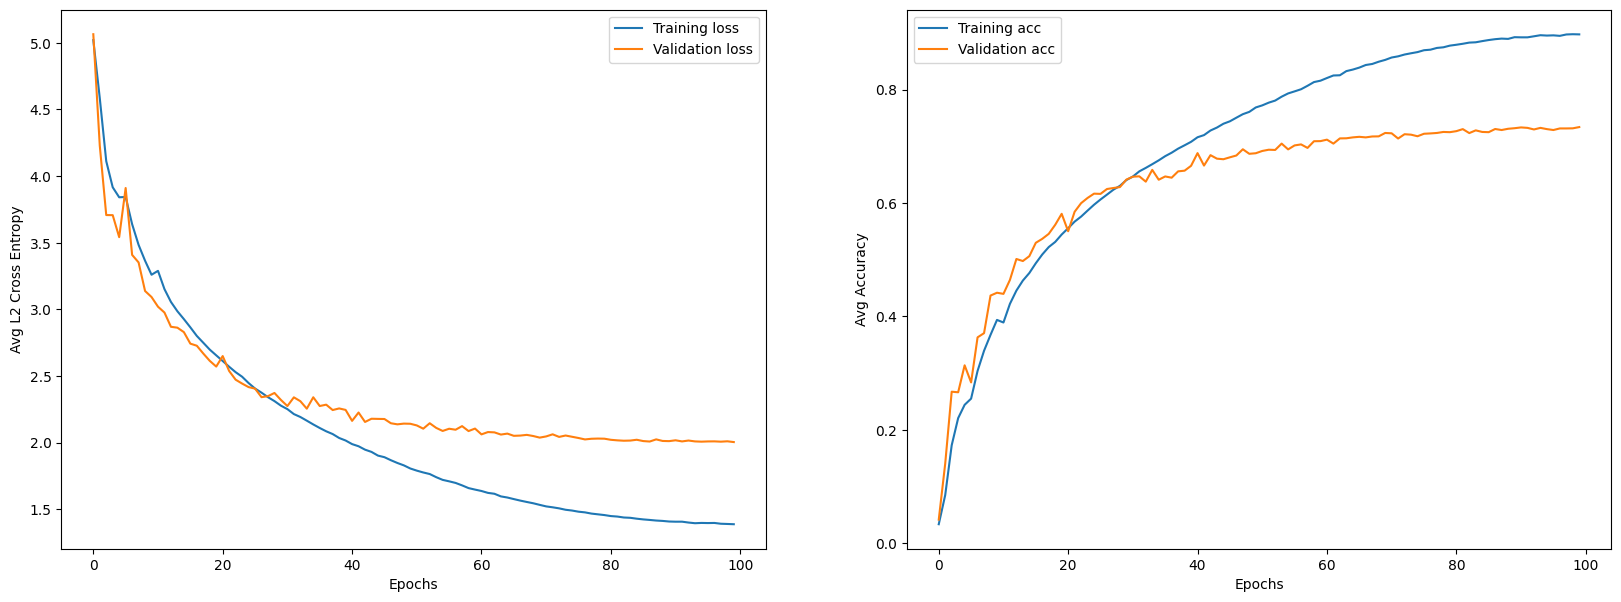

In [21]:
# Plot results
plt.figure(figsize=[20,7])
plt.subplot(1,2,1)
plt.plot(range(100), res_df['Loss'], label='Training loss')
plt.plot(range(100), res_df['Val_Loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Avg L2 Cross Entropy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(100), res_df['Accuracy'], label='Training acc')
plt.plot(range(100), res_df['Val_Accuracy'], label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Avg Accuracy')
plt.legend();

### 3.2.3 - Exporting best options and testing

In [22]:
# Export the best model
exported = SuperNet_model.export(verbose=1)

[BEST ALTERNATIVE for features.4.block.2]:
ConvBNRelu(
  (conv): Conv2d(72, 72, kernel_size=(1, 1), stride=(1, 1), groups=2)
  (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)

[BEST ALTERNATIVE for features.5.block.2]:
ConvBNRelu(
  (conv): Conv2d(120, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=24)
  (bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)

[BEST ALTERNATIVE for features.6.block.2]:
ConvBNRelu(
  (conv): Conv2d(120, 120, kernel_size=(1, 1), stride=(1, 1), groups=2)
  (bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)

[BEST ALTERNATIVE for features.11.block.2]:
ConvBNRelu(
  (conv): Conv2d(480, 480, kernel_size=(1, 1), stride=(1, 1), groups=2)
  (bn): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)

[BEST ALTERNATIVE

In [23]:
# Look at the model
exported

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

As we can see, the selected chosen layers were one of the `ConvBNReLU` options. _Why_? Here a possible explanation:

Training the SuperNet model by <u>backpropagating exclusively CrossEntropy</u> implicilty means that we are looking for the options providing the best accuracy. On one hand the `DepthwiseSeparableConv` module has more parameters than both _standard_ and _point-wise_ ConvBNReLU, therefore it should be able to extract richer feature sfor better performace. Moreover, the <u>standard ConvBNReLU module uses a lot of filters</u> in order to have a sufficiently low number of parameters, so that it can be compared with the other options. This implies that the module loses a lot of inter-channel information.

However, on the other hand Depth-wise Separable Convolution misses a key ingredient in this experiment: **Batch normalization**. This layer very much helps any convolutional module with generalization, thus generally imporving performance, especially on complex datasets as ImageNet.

This is what may lead SuperNet to pick `ConvBNReLU` over `DepthwiseSeparableConv`.

In [24]:
# Test the model on the test set
SuperNet_acc = utils.eval_model(
    model=exported,
    device=device,
    data_loader=test_dataloader
)  

  0%|          | 0/313 [00:00<?, ?batch/s]

EVALUATION COMPLETED - Avg Accuracy: 73.36%


In [25]:
# Save the exported model
utils.save_experiment(root='./experiments', model=exported, seed=SEED, settings=settings, exported=True, metrics_df=res_df)

### 3.2.4 - Proof

In order to enforce the argument made above, following we are going to train (with the same settings) the SuperNet built in **Section 3.1 - Building the SuperNet**, in which the `DepthwiseSeparableConv` has a batch normalization module.

In [9]:
settings = {
    'epochs': 100,
    'lr': 0.2,
    'loss': 'CrossEntropy',
    'label_smoothing': 0.1,
    'momentum': 0.9,
}

In [10]:
# Load the initialization
SuperNet_model = utils.baseline_SuperNet(exp_seed=SEED, dataset=train_dataset, verbose=False)
SuperNet_model

SuperNet(
  (seed): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
   

In [11]:
# Target device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=settings['label_smoothing'])
optimizer = torch.optim.SGD(params=SuperNet_model.parameters(), lr=settings['lr'], momentum=settings['momentum'])

# Scheduler and warmup
main_shceduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=settings['epochs'])
warmup = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer, start_factor=0.01, total_iters=5) # Linear warmup
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=optimizer, schedulers=[warmup, main_shceduler], milestones=[5])

In [12]:
# Train the model
loss_h, acc_h, val_loss_h, val_acc_h = utils.train_model(
    model=SuperNet_model,
    device=device,
    data_loader=train_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    lr_scheduler=scheduler,
    val_dataloader=test_dataloader,
    seed=SEED
)

# Create dataframe for results
res_df = pd.DataFrame({'Loss': loss_h, 'Val_Loss': val_loss_h, 'Accuracy': acc_h, 'Val_Accuracy': val_acc_h})
res_df.head()

*********************
EPOCH 0 on cuda - Current learning rate: 0.0020



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 6.02103 | Avg Accuracy: 1.30%
Computed 1999/8125 batches - Avg Loss: 5.53729 | Avg Accuracy: 1.64%
Computed 2999/8125 batches - Avg Loss: 5.36204 | Avg Accuracy: 1.81%
Computed 3999/8125 batches - Avg Loss: 5.26529 | Avg Accuracy: 2.03%
Computed 4999/8125 batches - Avg Loss: 5.19497 | Avg Accuracy: 2.23%
Computed 5999/8125 batches - Avg Loss: 5.14060 | Avg Accuracy: 2.47%
Computed 6999/8125 batches - Avg Loss: 5.09516 | Avg Accuracy: 2.68%
Computed 7999/8125 batches - Avg Loss: 5.05597 | Avg Accuracy: 2.89%

End of EPOCH 0 - Avg Loss: 5.05082 | Avg Accuracy: 2.91%
Training time: 570.212 seconds.

DNAS parameters:
	- features.4.block.2: [[0.33878764510154724, 0.34144386649131775, 0.3197677731513977]]
	- features.5.block.2: [[0.36443519592285156, 0.3044689893722534, 0.33109456300735474]]
	- features.6.block.2: [[0.3354431986808777, 0.3244280517101288, 0.3401283621788025]]
	- features.11.block.2: [[0.31404566764831543, 0.3581051826477051, 0.327849358

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 5.25%
*********************
EPOCH 1 on cuda - Current learning rate: 0.0416



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 5.07776 | Avg Accuracy: 2.77%
Computed 1999/8125 batches - Avg Loss: 4.94469 | Avg Accuracy: 3.74%
Computed 2999/8125 batches - Avg Loss: 4.86331 | Avg Accuracy: 4.56%
Computed 3999/8125 batches - Avg Loss: 4.79782 | Avg Accuracy: 5.34%
Computed 4999/8125 batches - Avg Loss: 4.73994 | Avg Accuracy: 6.10%
Computed 5999/8125 batches - Avg Loss: 4.68980 | Avg Accuracy: 6.82%
Computed 6999/8125 batches - Avg Loss: 4.64235 | Avg Accuracy: 7.55%
Computed 7999/8125 batches - Avg Loss: 4.59787 | Avg Accuracy: 8.34%

End of EPOCH 1 - Avg Loss: 4.59181 | Avg Accuracy: 8.43%
Training time: 568.697 seconds.

DNAS parameters:
	- features.4.block.2: [[-1.668497085571289, -0.10924821346998215, 2.7777464389801025]]
	- features.5.block.2: [[-0.2947535216808319, 0.4785422384738922, 0.8162100911140442]]
	- features.6.block.2: [[0.2050948143005371, 0.20097215473651886, 0.5939339399337769]]
	- features.11.block.2: [[-0.7068942785263062, 0.10640540719032288, 1.60049080

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 17.65%
*********************
EPOCH 2 on cuda - Current learning rate: 0.0812



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 4.36741 | Avg Accuracy: 12.06%
Computed 1999/8125 batches - Avg Loss: 4.31746 | Avg Accuracy: 13.19%
Computed 2999/8125 batches - Avg Loss: 4.27752 | Avg Accuracy: 14.14%
Computed 3999/8125 batches - Avg Loss: 4.24390 | Avg Accuracy: 14.82%
Computed 4999/8125 batches - Avg Loss: 4.20867 | Avg Accuracy: 15.55%
Computed 5999/8125 batches - Avg Loss: 4.17579 | Avg Accuracy: 16.12%
Computed 6999/8125 batches - Avg Loss: 4.14451 | Avg Accuracy: 16.77%
Computed 7999/8125 batches - Avg Loss: 4.11285 | Avg Accuracy: 17.45%

End of EPOCH 2 - Avg Loss: 4.10963 | Avg Accuracy: 17.50%
Training time: 569.165 seconds.

DNAS parameters:
	- features.4.block.2: [[-2.1402385234832764, -1.3836849927902222, 4.523953914642334]]
	- features.5.block.2: [[-0.847465455532074, 0.1497667133808136, 1.6977018117904663]]
	- features.6.block.2: [[-0.285573810338974, -0.256133496761322, 1.5417072772979736]]
	- features.11.block.2: [[-2.1077346801757812, -0.9340443015098572, 4.04

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 26.12%
*********************
EPOCH 3 on cuda - Current learning rate: 0.1208



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 4.05530 | Avg Accuracy: 18.87%
Computed 1999/8125 batches - Avg Loss: 4.02768 | Avg Accuracy: 19.70%
Computed 2999/8125 batches - Avg Loss: 4.00507 | Avg Accuracy: 20.22%
Computed 3999/8125 batches - Avg Loss: 3.98329 | Avg Accuracy: 20.78%
Computed 4999/8125 batches - Avg Loss: 3.96094 | Avg Accuracy: 21.26%
Computed 5999/8125 batches - Avg Loss: 3.93912 | Avg Accuracy: 21.80%
Computed 6999/8125 batches - Avg Loss: 3.91965 | Avg Accuracy: 22.15%
Computed 7999/8125 batches - Avg Loss: 3.90156 | Avg Accuracy: 22.57%

End of EPOCH 3 - Avg Loss: 3.89849 | Avg Accuracy: 22.64%
Training time: 568.883 seconds.

DNAS parameters:
	- features.4.block.2: [[-2.7267141342163086, -1.957303524017334, 5.684075832366943]]
	- features.5.block.2: [[-1.7448798418045044, -0.4139372706413269, 3.158822536468506]]
	- features.6.block.2: [[-1.0237252712249756, -0.21392200887203217, 2.237661123275757]]
	- features.11.block.2: [[-2.362049102783203, -1.9949060678482056, 5.3

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 30.19%
*********************
EPOCH 4 on cuda - Current learning rate: 0.1604



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.94309 | Avg Accuracy: 22.72%
Computed 1999/8125 batches - Avg Loss: 3.92123 | Avg Accuracy: 23.10%
Computed 2999/8125 batches - Avg Loss: 3.90273 | Avg Accuracy: 23.46%
Computed 3999/8125 batches - Avg Loss: 3.89437 | Avg Accuracy: 23.64%
Computed 4999/8125 batches - Avg Loss: 3.87337 | Avg Accuracy: 24.04%
Computed 5999/8125 batches - Avg Loss: 3.85646 | Avg Accuracy: 24.43%
Computed 6999/8125 batches - Avg Loss: 3.83860 | Avg Accuracy: 24.87%
Computed 7999/8125 batches - Avg Loss: 3.82268 | Avg Accuracy: 25.20%

End of EPOCH 4 - Avg Loss: 3.82037 | Avg Accuracy: 25.23%
Training time: 568.645 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.4631543159484863, -2.276738405227661, 6.739960193634033]]
	- features.5.block.2: [[-2.1767828464508057, -0.673051655292511, 3.849850654602051]]
	- features.6.block.2: [[-1.4329618215560913, -0.8518701791763306, 3.2848377227783203]]
	- features.11.block.2: [[-2.4905917644500732, -2.149543046951294, 5.64

/home/tiziano-tezze/ProgramFiles/miniconda3/envs/cv-project/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 32.43%
*********************
EPOCH 5 on cuda - Current learning rate: 0.2000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.86554 | Avg Accuracy: 25.23%
Computed 1999/8125 batches - Avg Loss: 3.88842 | Avg Accuracy: 24.68%
Computed 2999/8125 batches - Avg Loss: 3.88995 | Avg Accuracy: 24.78%
Computed 3999/8125 batches - Avg Loss: 3.88088 | Avg Accuracy: 25.00%
Computed 4999/8125 batches - Avg Loss: 3.87676 | Avg Accuracy: 25.14%
Computed 5999/8125 batches - Avg Loss: 3.86685 | Avg Accuracy: 25.35%
Computed 6999/8125 batches - Avg Loss: 3.85975 | Avg Accuracy: 25.53%
Computed 7999/8125 batches - Avg Loss: 3.85075 | Avg Accuracy: 25.76%

End of EPOCH 5 - Avg Loss: 3.84941 | Avg Accuracy: 25.77%
Training time: 568.770 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.4753615856170654, -2.4653127193450928, 6.940738201141357]]
	- features.5.block.2: [[-2.626945972442627, -0.9471617937088013, 4.574117183685303]]
	- features.6.block.2: [[-1.6497219800949097, -1.1452833414077759, 3.7950079441070557]]
	- features.11.block.2: [[-3.1882030963897705, -2.52532958984375, 6.71

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 32.97%
*********************
EPOCH 6 on cuda - Current learning rate: 0.2000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.71797 | Avg Accuracy: 29.41%
Computed 1999/8125 batches - Avg Loss: 3.70063 | Avg Accuracy: 29.48%
Computed 2999/8125 batches - Avg Loss: 3.70811 | Avg Accuracy: 29.26%
Computed 3999/8125 batches - Avg Loss: 3.70059 | Avg Accuracy: 29.53%
Computed 4999/8125 batches - Avg Loss: 3.69138 | Avg Accuracy: 29.77%
Computed 5999/8125 batches - Avg Loss: 3.67748 | Avg Accuracy: 30.07%
Computed 6999/8125 batches - Avg Loss: 3.66983 | Avg Accuracy: 30.20%
Computed 7999/8125 batches - Avg Loss: 3.66356 | Avg Accuracy: 30.40%

End of EPOCH 6 - Avg Loss: 3.66207 | Avg Accuracy: 30.42%
Training time: 570.118 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.4614858627319336, -2.654608964920044, 7.116157054901123]]
	- features.5.block.2: [[-2.6840767860412598, -1.0686146020889282, 4.752701759338379]]
	- features.6.block.2: [[-1.96782648563385, -1.0843905210494995, 4.052218914031982]]
	- features.11.block.2: [[-3.268693208694458, -2.507453441619873, 6.77617

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 37.30%
*********************
EPOCH 7 on cuda - Current learning rate: 0.1998



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.58245 | Avg Accuracy: 32.73%
Computed 1999/8125 batches - Avg Loss: 3.56129 | Avg Accuracy: 33.07%
Computed 2999/8125 batches - Avg Loss: 3.55878 | Avg Accuracy: 33.22%
Computed 3999/8125 batches - Avg Loss: 3.55171 | Avg Accuracy: 33.42%
Computed 4999/8125 batches - Avg Loss: 3.54613 | Avg Accuracy: 33.43%
Computed 5999/8125 batches - Avg Loss: 3.54152 | Avg Accuracy: 33.51%
Computed 6999/8125 batches - Avg Loss: 3.53289 | Avg Accuracy: 33.68%
Computed 7999/8125 batches - Avg Loss: 3.52630 | Avg Accuracy: 33.83%

End of EPOCH 7 - Avg Loss: 3.52580 | Avg Accuracy: 33.85%
Training time: 570.374 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.3666775226593018, -2.8595852851867676, 7.226322650909424]]
	- features.5.block.2: [[-2.8384907245635986, -1.0429086685180664, 4.881415843963623]]
	- features.6.block.2: [[-2.32208251953125, -1.3364169597625732, 4.658506870269775]]
	- features.11.block.2: [[-3.273547887802124, -2.604825258255005, 6.8783

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 38.94%
*********************
EPOCH 8 on cuda - Current learning rate: 0.1996



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.43640 | Avg Accuracy: 35.71%
Computed 1999/8125 batches - Avg Loss: 3.43845 | Avg Accuracy: 35.73%
Computed 2999/8125 batches - Avg Loss: 3.43552 | Avg Accuracy: 35.93%
Computed 3999/8125 batches - Avg Loss: 3.42213 | Avg Accuracy: 36.24%
Computed 4999/8125 batches - Avg Loss: 3.42043 | Avg Accuracy: 36.40%
Computed 5999/8125 batches - Avg Loss: 3.42032 | Avg Accuracy: 36.44%
Computed 6999/8125 batches - Avg Loss: 3.41678 | Avg Accuracy: 36.52%
Computed 7999/8125 batches - Avg Loss: 3.41481 | Avg Accuracy: 36.56%

End of EPOCH 8 - Avg Loss: 3.41301 | Avg Accuracy: 36.59%
Training time: 570.495 seconds.

DNAS parameters:
	- features.4.block.2: [[-3.358583688735962, -2.8323311805725098, 7.190981388092041]]
	- features.5.block.2: [[-2.8014984130859375, -1.3942219018936157, 5.195728302001953]]
	- features.6.block.2: [[-2.449312210083008, -1.43267822265625, 4.881994247436523]]
	- features.11.block.2: [[-3.222344160079956, -2.705105781555176, 6.927473

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 40.34%
*********************
EPOCH 9 on cuda - Current learning rate: 0.1992



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.32955 | Avg Accuracy: 38.28%
Computed 1999/8125 batches - Avg Loss: 3.34313 | Avg Accuracy: 38.16%
Computed 2999/8125 batches - Avg Loss: 3.34615 | Avg Accuracy: 38.13%
Computed 3999/8125 batches - Avg Loss: 3.33417 | Avg Accuracy: 38.36%
Computed 4999/8125 batches - Avg Loss: 3.33081 | Avg Accuracy: 38.49%
Computed 5999/8125 batches - Avg Loss: 3.32922 | Avg Accuracy: 38.65%
Computed 6999/8125 batches - Avg Loss: 3.32817 | Avg Accuracy: 38.80%
Computed 7999/8125 batches - Avg Loss: 3.32624 | Avg Accuracy: 38.88%

End of EPOCH 9 - Avg Loss: 3.32573 | Avg Accuracy: 38.89%
Training time: 570.443 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.677352428436279, -2.768238067626953, 8.445656776428223]]
	- features.5.block.2: [[-2.6447594165802, -1.631736159324646, 5.276515960693359]]
	- features.6.block.2: [[-2.6418471336364746, -1.5343880653381348, 5.176246643066406]]
	- features.11.block.2: [[-3.2602379322052, -3.1699085235595703, 7.430186748

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 45.73%
*********************
EPOCH 10 on cuda - Current learning rate: 0.1988



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.24606 | Avg Accuracy: 41.16%
Computed 1999/8125 batches - Avg Loss: 3.26004 | Avg Accuracy: 40.49%
Computed 2999/8125 batches - Avg Loss: 3.26043 | Avg Accuracy: 40.31%
Computed 3999/8125 batches - Avg Loss: 3.25114 | Avg Accuracy: 40.57%
Computed 4999/8125 batches - Avg Loss: 3.24647 | Avg Accuracy: 40.73%
Computed 5999/8125 batches - Avg Loss: 3.24275 | Avg Accuracy: 40.84%
Computed 6999/8125 batches - Avg Loss: 3.24168 | Avg Accuracy: 40.88%
Computed 7999/8125 batches - Avg Loss: 3.23889 | Avg Accuracy: 40.95%

End of EPOCH 10 - Avg Loss: 3.23828 | Avg Accuracy: 40.96%
Training time: 570.437 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.678147315979004, -2.9488608837127686, 8.627031326293945]]
	- features.5.block.2: [[-2.662287473678589, -1.6202939748764038, 5.2825927734375]]
	- features.6.block.2: [[-2.6437506675720215, -1.5286462306976318, 5.1724090576171875]]
	- features.11.block.2: [[-3.5954530239105225, -3.19620943069458, 7.7916

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 47.42%
*********************
EPOCH 11 on cuda - Current learning rate: 0.1982



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.18244 | Avg Accuracy: 42.04%
Computed 1999/8125 batches - Avg Loss: 3.17776 | Avg Accuracy: 42.14%
Computed 2999/8125 batches - Avg Loss: 3.17488 | Avg Accuracy: 42.35%
Computed 3999/8125 batches - Avg Loss: 3.17765 | Avg Accuracy: 42.35%
Computed 4999/8125 batches - Avg Loss: 3.17289 | Avg Accuracy: 42.62%
Computed 5999/8125 batches - Avg Loss: 3.17043 | Avg Accuracy: 42.76%
Computed 6999/8125 batches - Avg Loss: 3.16425 | Avg Accuracy: 42.83%
Computed 7999/8125 batches - Avg Loss: 3.16090 | Avg Accuracy: 42.90%

End of EPOCH 11 - Avg Loss: 3.16116 | Avg Accuracy: 42.88%
Training time: 570.181 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.678576469421387, -2.9531638622283936, 8.63176441192627]]
	- features.5.block.2: [[-2.7450459003448486, -1.8057512044906616, 5.550829887390137]]
	- features.6.block.2: [[-2.7903473377227783, -1.5834448337554932, 5.373795986175537]]
	- features.11.block.2: [[-3.5665693283081055, -3.4397385120391846, 8.0

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 46.59%
*********************
EPOCH 12 on cuda - Current learning rate: 0.1976



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.10496 | Avg Accuracy: 44.23%
Computed 1999/8125 batches - Avg Loss: 3.09321 | Avg Accuracy: 44.38%
Computed 2999/8125 batches - Avg Loss: 3.08277 | Avg Accuracy: 44.72%
Computed 3999/8125 batches - Avg Loss: 3.07625 | Avg Accuracy: 44.89%
Computed 4999/8125 batches - Avg Loss: 3.07809 | Avg Accuracy: 44.92%
Computed 5999/8125 batches - Avg Loss: 3.07779 | Avg Accuracy: 44.85%
Computed 6999/8125 batches - Avg Loss: 3.08087 | Avg Accuracy: 44.79%
Computed 7999/8125 batches - Avg Loss: 3.07929 | Avg Accuracy: 44.84%

End of EPOCH 12 - Avg Loss: 3.07800 | Avg Accuracy: 44.85%
Training time: 570.711 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.679834365844727, -2.9594695568084717, 8.639321327209473]]
	- features.5.block.2: [[-2.897613763809204, -1.7710955142974854, 5.668771266937256]]
	- features.6.block.2: [[-2.7852187156677246, -1.903153657913208, 5.688382148742676]]
	- features.11.block.2: [[-3.565255880355835, -3.4547526836395264, 8.020

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 51.44%
*********************
EPOCH 13 on cuda - Current learning rate: 0.1969



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.00768 | Avg Accuracy: 46.06%
Computed 1999/8125 batches - Avg Loss: 3.00967 | Avg Accuracy: 46.23%
Computed 2999/8125 batches - Avg Loss: 3.01934 | Avg Accuracy: 46.30%
Computed 3999/8125 batches - Avg Loss: 3.02209 | Avg Accuracy: 46.19%
Computed 4999/8125 batches - Avg Loss: 3.01679 | Avg Accuracy: 46.37%
Computed 5999/8125 batches - Avg Loss: 3.01494 | Avg Accuracy: 46.39%
Computed 6999/8125 batches - Avg Loss: 3.01377 | Avg Accuracy: 46.43%
Computed 7999/8125 batches - Avg Loss: 3.01331 | Avg Accuracy: 46.49%

End of EPOCH 13 - Avg Loss: 3.01288 | Avg Accuracy: 46.48%
Training time: 570.677 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.67939567565918, -2.949496269226074, 8.628889083862305]]
	- features.5.block.2: [[-2.8129427433013916, -1.752402424812317, 5.565420627593994]]
	- features.6.block.2: [[-2.7631545066833496, -1.9682250022888184, 5.731375217437744]]
	- features.11.block.2: [[-3.575697898864746, -3.93269681930542, 8.508430

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 50.98%
*********************
EPOCH 14 on cuda - Current learning rate: 0.1960



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.94865 | Avg Accuracy: 48.04%
Computed 1999/8125 batches - Avg Loss: 2.95017 | Avg Accuracy: 48.14%
Computed 2999/8125 batches - Avg Loss: 2.96402 | Avg Accuracy: 47.74%
Computed 3999/8125 batches - Avg Loss: 2.96509 | Avg Accuracy: 47.82%
Computed 4999/8125 batches - Avg Loss: 2.96702 | Avg Accuracy: 47.76%
Computed 5999/8125 batches - Avg Loss: 2.96481 | Avg Accuracy: 47.83%
Computed 6999/8125 batches - Avg Loss: 2.96298 | Avg Accuracy: 47.94%
Computed 7999/8125 batches - Avg Loss: 2.96118 | Avg Accuracy: 47.98%

End of EPOCH 14 - Avg Loss: 2.95924 | Avg Accuracy: 48.03%
Training time: 570.515 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.677573204040527, -2.9387519359588623, 8.616314888000488]]
	- features.5.block.2: [[-3.0211281776428223, -1.9417203664779663, 5.962901592254639]]
	- features.6.block.2: [[-2.8047850131988525, -2.0977237224578857, 5.902498722076416]]
	- features.11.block.2: [[-3.576249599456787, -3.943556785583496, 8.51

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 52.62%
*********************
EPOCH 15 on cuda - Current learning rate: 0.1951



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.88502 | Avg Accuracy: 49.63%
Computed 1999/8125 batches - Avg Loss: 2.89216 | Avg Accuracy: 49.57%
Computed 2999/8125 batches - Avg Loss: 2.88993 | Avg Accuracy: 49.59%
Computed 3999/8125 batches - Avg Loss: 2.89685 | Avg Accuracy: 49.48%
Computed 4999/8125 batches - Avg Loss: 2.89764 | Avg Accuracy: 49.51%
Computed 5999/8125 batches - Avg Loss: 2.89395 | Avg Accuracy: 49.65%
Computed 6999/8125 batches - Avg Loss: 2.89225 | Avg Accuracy: 49.70%
Computed 7999/8125 batches - Avg Loss: 2.88984 | Avg Accuracy: 49.73%

End of EPOCH 15 - Avg Loss: 2.89015 | Avg Accuracy: 49.71%
Training time: 570.715 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.676593780517578, -2.9372825622558594, 8.613839149475098]]
	- features.5.block.2: [[-3.1803486347198486, -1.8228133916854858, 6.003230571746826]]
	- features.6.block.2: [[-2.815535545349121, -2.0813591480255127, 5.896881103515625]]
	- features.11.block.2: [[-3.649609327316284, -3.965264081954956, 8.614

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.33%
*********************
EPOCH 16 on cuda - Current learning rate: 0.1941



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.83000 | Avg Accuracy: 51.08%
Computed 1999/8125 batches - Avg Loss: 2.82496 | Avg Accuracy: 51.07%
Computed 2999/8125 batches - Avg Loss: 2.82323 | Avg Accuracy: 51.05%
Computed 3999/8125 batches - Avg Loss: 2.82279 | Avg Accuracy: 51.19%
Computed 4999/8125 batches - Avg Loss: 2.82073 | Avg Accuracy: 51.25%
Computed 5999/8125 batches - Avg Loss: 2.82379 | Avg Accuracy: 51.16%
Computed 6999/8125 batches - Avg Loss: 2.82418 | Avg Accuracy: 51.08%
Computed 7999/8125 batches - Avg Loss: 2.82255 | Avg Accuracy: 51.13%

End of EPOCH 16 - Avg Loss: 2.82210 | Avg Accuracy: 51.13%
Training time: 570.294 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.673725128173828, -2.9717745780944824, 8.645491600036621]]
	- features.5.block.2: [[-3.2972593307495117, -2.076241970062256, 6.373557090759277]]
	- features.6.block.2: [[-2.9516942501068115, -2.210103988647461, 6.161792278289795]]
	- features.11.block.2: [[-3.645289897918701, -3.9668474197387695, 8.612

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 54.09%
*********************
EPOCH 17 on cuda - Current learning rate: 0.1930



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.73642 | Avg Accuracy: 53.40%
Computed 1999/8125 batches - Avg Loss: 2.74960 | Avg Accuracy: 53.11%
Computed 2999/8125 batches - Avg Loss: 2.75801 | Avg Accuracy: 52.93%
Computed 3999/8125 batches - Avg Loss: 2.76823 | Avg Accuracy: 52.70%
Computed 4999/8125 batches - Avg Loss: 2.76739 | Avg Accuracy: 52.63%
Computed 5999/8125 batches - Avg Loss: 2.77025 | Avg Accuracy: 52.59%
Computed 6999/8125 batches - Avg Loss: 2.76896 | Avg Accuracy: 52.50%
Computed 7999/8125 batches - Avg Loss: 2.76834 | Avg Accuracy: 52.45%

End of EPOCH 17 - Avg Loss: 2.76828 | Avg Accuracy: 52.44%
Training time: 569.903 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.6770806312561035, -2.9385571479797363, 8.615654945373535]]
	- features.5.block.2: [[-3.3167879581451416, -2.1154978275299072, 6.432332992553711]]
	- features.6.block.2: [[-2.946117401123047, -2.2919483184814453, 6.2380547523498535]]
	- features.11.block.2: [[-3.6592636108398438, -3.830005407333374, 8.

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 57.73%
*********************
EPOCH 18 on cuda - Current learning rate: 0.1918



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.66808 | Avg Accuracy: 55.22%
Computed 1999/8125 batches - Avg Loss: 2.67632 | Avg Accuracy: 54.83%
Computed 2999/8125 batches - Avg Loss: 2.69188 | Avg Accuracy: 54.47%
Computed 3999/8125 batches - Avg Loss: 2.69659 | Avg Accuracy: 54.24%
Computed 4999/8125 batches - Avg Loss: 2.70140 | Avg Accuracy: 54.02%
Computed 5999/8125 batches - Avg Loss: 2.70185 | Avg Accuracy: 53.98%
Computed 6999/8125 batches - Avg Loss: 2.70746 | Avg Accuracy: 53.79%
Computed 7999/8125 batches - Avg Loss: 2.70862 | Avg Accuracy: 53.74%

End of EPOCH 18 - Avg Loss: 2.70811 | Avg Accuracy: 53.75%
Training time: 570.057 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.6760783195495605, -2.962123394012451, 8.638211250305176]]
	- features.5.block.2: [[-3.33762526512146, -2.1695895195007324, 6.507256031036377]]
	- features.6.block.2: [[-2.951296806335449, -2.313903570175171, 6.265201091766357]]
	- features.11.block.2: [[-5.789391994476318, -3.840557813644409, 10.63000

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 57.87%
*********************
EPOCH 19 on cuda - Current learning rate: 0.1905



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.63488 | Avg Accuracy: 55.69%
Computed 1999/8125 batches - Avg Loss: 2.65651 | Avg Accuracy: 55.10%
Computed 2999/8125 batches - Avg Loss: 2.65175 | Avg Accuracy: 55.22%
Computed 3999/8125 batches - Avg Loss: 2.65899 | Avg Accuracy: 55.04%
Computed 4999/8125 batches - Avg Loss: 2.66035 | Avg Accuracy: 55.01%
Computed 5999/8125 batches - Avg Loss: 2.71508 | Avg Accuracy: 53.94%
Computed 6999/8125 batches - Avg Loss: 2.95052 | Avg Accuracy: 48.86%
Computed 7999/8125 batches - Avg Loss: 3.01705 | Avg Accuracy: 47.22%

End of EPOCH 19 - Avg Loss: 3.02114 | Avg Accuracy: 47.09%
Training time: 570.469 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.675742149353027, -2.9715194702148438, 8.647285461425781]]
	- features.5.block.2: [[-3.3010942935943604, -2.111375570297241, 6.412502288818359]]
	- features.6.block.2: [[-2.935492515563965, -2.276925802230835, 6.212413787841797]]
	- features.11.block.2: [[-5.78943395614624, -3.840993881225586, 10.63051

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 46.47%
*********************
EPOCH 20 on cuda - Current learning rate: 0.1891



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.19625 | Avg Accuracy: 42.73%
Computed 1999/8125 batches - Avg Loss: 3.13410 | Avg Accuracy: 44.05%
Computed 2999/8125 batches - Avg Loss: 3.09002 | Avg Accuracy: 44.96%
Computed 3999/8125 batches - Avg Loss: 3.05242 | Avg Accuracy: 45.83%
Computed 4999/8125 batches - Avg Loss: 3.02116 | Avg Accuracy: 46.57%
Computed 5999/8125 batches - Avg Loss: 2.99611 | Avg Accuracy: 47.08%
Computed 6999/8125 batches - Avg Loss: 2.97015 | Avg Accuracy: 47.69%
Computed 7999/8125 batches - Avg Loss: 2.94939 | Avg Accuracy: 48.17%

End of EPOCH 20 - Avg Loss: 2.94717 | Avg Accuracy: 48.20%
Training time: 570.510 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.674283504486084, -2.9695842266082764, 8.643917083740234]]
	- features.5.block.2: [[-3.2864012718200684, -2.112344741821289, 6.398767471313477]]
	- features.6.block.2: [[-3.0328152179718018, -2.22188138961792, 6.254668712615967]]
	- features.11.block.2: [[-5.789440155029297, -3.8407561779022217, 10.630

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 55.79%
*********************
EPOCH 21 on cuda - Current learning rate: 0.1876



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.74230 | Avg Accuracy: 53.48%
Computed 1999/8125 batches - Avg Loss: 2.72747 | Avg Accuracy: 53.62%
Computed 2999/8125 batches - Avg Loss: 2.72109 | Avg Accuracy: 53.67%
Computed 3999/8125 batches - Avg Loss: 2.72390 | Avg Accuracy: 53.58%
Computed 4999/8125 batches - Avg Loss: 2.71728 | Avg Accuracy: 53.58%
Computed 5999/8125 batches - Avg Loss: 2.71828 | Avg Accuracy: 53.57%
Computed 6999/8125 batches - Avg Loss: 2.71241 | Avg Accuracy: 53.69%
Computed 7999/8125 batches - Avg Loss: 2.70769 | Avg Accuracy: 53.82%

End of EPOCH 21 - Avg Loss: 2.70700 | Avg Accuracy: 53.81%
Training time: 569.999 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.594041347503662, -2.951447010040283, 8.545523643493652]]
	- features.5.block.2: [[-3.2935657501220703, -2.17680025100708, 6.470401287078857]]
	- features.6.block.2: [[-3.0363779067993164, -2.087883472442627, 6.12423038482666]]
	- features.11.block.2: [[-5.790419101715088, -3.8374297618865967, 10.62806

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 57.61%
*********************
EPOCH 22 on cuda - Current learning rate: 0.1861



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.63488 | Avg Accuracy: 55.92%
Computed 1999/8125 batches - Avg Loss: 2.61915 | Avg Accuracy: 56.09%
Computed 2999/8125 batches - Avg Loss: 2.62638 | Avg Accuracy: 55.75%
Computed 3999/8125 batches - Avg Loss: 2.62514 | Avg Accuracy: 55.61%
Computed 4999/8125 batches - Avg Loss: 2.62679 | Avg Accuracy: 55.67%
Computed 5999/8125 batches - Avg Loss: 2.62600 | Avg Accuracy: 55.74%
Computed 6999/8125 batches - Avg Loss: 2.62769 | Avg Accuracy: 55.64%
Computed 7999/8125 batches - Avg Loss: 2.62697 | Avg Accuracy: 55.63%

End of EPOCH 22 - Avg Loss: 2.62649 | Avg Accuracy: 55.62%
Training time: 570.585 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.593806266784668, -2.9513869285583496, 8.545257568359375]]
	- features.5.block.2: [[-3.2803900241851807, -2.341661214828491, 6.622076034545898]]
	- features.6.block.2: [[-3.0280611515045166, -2.3308804035186768, 6.3589186668396]]
	- features.11.block.2: [[-5.790595531463623, -3.8379180431365967, 10.628

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 59.64%
*********************
EPOCH 23 on cuda - Current learning rate: 0.1844



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.51556 | Avg Accuracy: 58.40%
Computed 1999/8125 batches - Avg Loss: 2.87906 | Avg Accuracy: 51.33%
Computed 2999/8125 batches - Avg Loss: 3.62491 | Avg Accuracy: 35.48%
Computed 3999/8125 batches - Avg Loss: 3.93087 | Avg Accuracy: 28.01%
Computed 4999/8125 batches - Avg Loss: 4.07522 | Avg Accuracy: 23.93%
Computed 5999/8125 batches - Avg Loss: 4.14543 | Avg Accuracy: 21.64%
Computed 6999/8125 batches - Avg Loss: 4.17961 | Avg Accuracy: 20.34%
Computed 7999/8125 batches - Avg Loss: 4.19371 | Avg Accuracy: 19.57%

End of EPOCH 23 - Avg Loss: 4.19349 | Avg Accuracy: 19.49%
Training time: 570.812 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.6026763916015625, -2.9637258052825928, 8.566482543945312]]
	- features.5.block.2: [[-3.2915844917297363, -2.355404853820801, 6.647030353546143]]
	- features.6.block.2: [[-3.0735156536102295, -2.4069502353668213, 6.480432510375977]]
	- features.11.block.2: [[-5.790612697601318, -3.837202787399292, 10.6

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 18.89%
*********************
EPOCH 24 on cuda - Current learning rate: 0.1827



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 4.16775 | Avg Accuracy: 16.33%
Computed 1999/8125 batches - Avg Loss: 4.13413 | Avg Accuracy: 17.21%
Computed 2999/8125 batches - Avg Loss: 4.09576 | Avg Accuracy: 18.31%
Computed 3999/8125 batches - Avg Loss: 4.06249 | Avg Accuracy: 18.80%
Computed 4999/8125 batches - Avg Loss: 4.03397 | Avg Accuracy: 19.42%
Computed 5999/8125 batches - Avg Loss: 4.01060 | Avg Accuracy: 19.88%
Computed 6999/8125 batches - Avg Loss: 3.98497 | Avg Accuracy: 20.43%
Computed 7999/8125 batches - Avg Loss: 3.95959 | Avg Accuracy: 20.97%

End of EPOCH 24 - Avg Loss: 3.95548 | Avg Accuracy: 21.02%
Training time: 571.145 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.602300643920898, -3.2143678665161133, 8.816729545593262]]
	- features.5.block.2: [[-3.3084733486175537, -2.388122797012329, 6.696633815765381]]
	- features.6.block.2: [[-3.0588295459747314, -2.455702304840088, 6.514481544494629]]
	- features.11.block.2: [[-5.790733337402344, -3.837820053100586, 10.628

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 29.11%
*********************
EPOCH 25 on cuda - Current learning rate: 0.1809



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.69888 | Avg Accuracy: 26.53%
Computed 1999/8125 batches - Avg Loss: 3.68565 | Avg Accuracy: 27.33%
Computed 2999/8125 batches - Avg Loss: 3.67342 | Avg Accuracy: 27.62%
Computed 3999/8125 batches - Avg Loss: 3.65754 | Avg Accuracy: 27.83%
Computed 4999/8125 batches - Avg Loss: 3.63709 | Avg Accuracy: 28.22%
Computed 5999/8125 batches - Avg Loss: 3.62283 | Avg Accuracy: 28.71%
Computed 6999/8125 batches - Avg Loss: 3.60866 | Avg Accuracy: 29.07%
Computed 7999/8125 batches - Avg Loss: 3.59589 | Avg Accuracy: 29.31%

End of EPOCH 25 - Avg Loss: 3.59450 | Avg Accuracy: 29.33%
Training time: 574.561 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.6020917892456055, -3.1569058895111084, 8.759045600891113]]
	- features.5.block.2: [[-3.3489582538604736, -2.401994466781616, 6.750964164733887]]
	- features.6.block.2: [[-3.1130056381225586, -2.5031697750091553, 6.616109848022461]]
	- features.11.block.2: [[-5.79080057144165, -3.8391976356506348, 10.6

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 36.70%
*********************
EPOCH 26 on cuda - Current learning rate: 0.1790



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.42300 | Avg Accuracy: 33.05%
Computed 1999/8125 batches - Avg Loss: 3.40979 | Avg Accuracy: 33.40%
Computed 2999/8125 batches - Avg Loss: 3.40044 | Avg Accuracy: 33.70%
Computed 3999/8125 batches - Avg Loss: 3.39445 | Avg Accuracy: 33.83%
Computed 4999/8125 batches - Avg Loss: 3.38278 | Avg Accuracy: 34.20%
Computed 5999/8125 batches - Avg Loss: 3.37690 | Avg Accuracy: 34.32%
Computed 6999/8125 batches - Avg Loss: 3.36770 | Avg Accuracy: 34.60%
Computed 7999/8125 batches - Avg Loss: 3.36284 | Avg Accuracy: 34.73%

End of EPOCH 26 - Avg Loss: 3.36118 | Avg Accuracy: 34.76%
Training time: 570.431 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.600837230682373, -3.1215708255767822, 8.722433090209961]]
	- features.5.block.2: [[-3.356391668319702, -2.451612949371338, 6.808024883270264]]
	- features.6.block.2: [[-3.096435070037842, -2.5356483459472656, 6.63198709487915]]
	- features.11.block.2: [[-5.790935039520264, -3.841531991958618, 10.63268

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 42.19%
*********************
EPOCH 27 on cuda - Current learning rate: 0.1771



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.22886 | Avg Accuracy: 37.98%
Computed 1999/8125 batches - Avg Loss: 3.23144 | Avg Accuracy: 38.24%
Computed 2999/8125 batches - Avg Loss: 3.22738 | Avg Accuracy: 38.16%
Computed 3999/8125 batches - Avg Loss: 3.21858 | Avg Accuracy: 38.57%
Computed 4999/8125 batches - Avg Loss: 3.21002 | Avg Accuracy: 38.84%
Computed 5999/8125 batches - Avg Loss: 3.20583 | Avg Accuracy: 38.92%
Computed 6999/8125 batches - Avg Loss: 3.20122 | Avg Accuracy: 38.99%
Computed 7999/8125 batches - Avg Loss: 3.19339 | Avg Accuracy: 39.16%

End of EPOCH 27 - Avg Loss: 3.19184 | Avg Accuracy: 39.19%
Training time: 570.883 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.600792407989502, -3.1222386360168457, 8.7230224609375]]
	- features.5.block.2: [[-3.3743844032287598, -2.4717648029327393, 6.846170902252197]]
	- features.6.block.2: [[-3.1828742027282715, -2.539963722229004, 6.722748756408691]]
	- features.11.block.2: [[-5.790886878967285, -3.8411521911621094, 10.632

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 46.63%
*********************
EPOCH 28 on cuda - Current learning rate: 0.1750



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.07849 | Avg Accuracy: 41.84%
Computed 1999/8125 batches - Avg Loss: 3.08305 | Avg Accuracy: 41.70%
Computed 2999/8125 batches - Avg Loss: 3.07557 | Avg Accuracy: 41.97%
Computed 3999/8125 batches - Avg Loss: 3.07314 | Avg Accuracy: 42.04%
Computed 4999/8125 batches - Avg Loss: 3.06695 | Avg Accuracy: 42.21%
Computed 5999/8125 batches - Avg Loss: 3.06555 | Avg Accuracy: 42.29%
Computed 6999/8125 batches - Avg Loss: 3.06196 | Avg Accuracy: 42.42%
Computed 7999/8125 batches - Avg Loss: 3.05759 | Avg Accuracy: 42.55%

End of EPOCH 28 - Avg Loss: 3.05688 | Avg Accuracy: 42.56%
Training time: 569.938 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.602045059204102, -3.126250982284546, 8.72828483581543]]
	- features.5.block.2: [[-3.3734445571899414, -2.5301802158355713, 6.903629302978516]]
	- features.6.block.2: [[-3.1924076080322266, -2.5637733936309814, 6.756075859069824]]
	- features.11.block.2: [[-5.790643215179443, -3.8523950576782227, 10.64

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.20%
*********************
EPOCH 29 on cuda - Current learning rate: 0.1729



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.95828 | Avg Accuracy: 45.50%
Computed 1999/8125 batches - Avg Loss: 2.96550 | Avg Accuracy: 44.96%
Computed 2999/8125 batches - Avg Loss: 2.96682 | Avg Accuracy: 44.86%
Computed 3999/8125 batches - Avg Loss: 2.97107 | Avg Accuracy: 44.84%
Computed 4999/8125 batches - Avg Loss: 2.96597 | Avg Accuracy: 45.03%
Computed 5999/8125 batches - Avg Loss: 2.96100 | Avg Accuracy: 45.13%
Computed 6999/8125 batches - Avg Loss: 2.95913 | Avg Accuracy: 45.11%
Computed 7999/8125 batches - Avg Loss: 2.95457 | Avg Accuracy: 45.21%

End of EPOCH 29 - Avg Loss: 2.95317 | Avg Accuracy: 45.23%
Training time: 569.618 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.607844829559326, -3.1262316703796387, 8.734048843383789]]
	- features.5.block.2: [[-3.3992481231689453, -2.53717303276062, 6.936447620391846]]
	- features.6.block.2: [[-3.2003188133239746, -2.6538150310516357, 6.8540191650390625]]
	- features.11.block.2: [[-5.792265892028809, -3.8525712490081787, 10.6

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 52.20%
*********************
EPOCH 30 on cuda - Current learning rate: 0.1707



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.85458 | Avg Accuracy: 47.43%
Computed 1999/8125 batches - Avg Loss: 2.85669 | Avg Accuracy: 47.53%
Computed 2999/8125 batches - Avg Loss: 2.85639 | Avg Accuracy: 47.50%
Computed 3999/8125 batches - Avg Loss: 2.85513 | Avg Accuracy: 47.63%
Computed 4999/8125 batches - Avg Loss: 2.85562 | Avg Accuracy: 47.62%
Computed 5999/8125 batches - Avg Loss: 2.85478 | Avg Accuracy: 47.54%
Computed 6999/8125 batches - Avg Loss: 2.85609 | Avg Accuracy: 47.60%
Computed 7999/8125 batches - Avg Loss: 2.85686 | Avg Accuracy: 47.62%

End of EPOCH 30 - Avg Loss: 2.85578 | Avg Accuracy: 47.64%
Training time: 570.562 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.615084648132324, -3.1253087520599365, 8.740331649780273]]
	- features.5.block.2: [[-3.40425181388855, -2.5459084510803223, 6.950206756591797]]
	- features.6.block.2: [[-3.2044475078582764, -2.756118059158325, 6.960423946380615]]
	- features.11.block.2: [[-5.792163848876953, -3.851055145263672, 10.6435

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 50.98%
*********************
EPOCH 31 on cuda - Current learning rate: 0.1685



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.77230 | Avg Accuracy: 49.94%
Computed 1999/8125 batches - Avg Loss: 2.76604 | Avg Accuracy: 49.93%
Computed 2999/8125 batches - Avg Loss: 2.76994 | Avg Accuracy: 49.90%
Computed 3999/8125 batches - Avg Loss: 2.77246 | Avg Accuracy: 49.75%
Computed 4999/8125 batches - Avg Loss: 2.77825 | Avg Accuracy: 49.55%
Computed 5999/8125 batches - Avg Loss: 2.77864 | Avg Accuracy: 49.58%
Computed 6999/8125 batches - Avg Loss: 2.77835 | Avg Accuracy: 49.57%
Computed 7999/8125 batches - Avg Loss: 2.77619 | Avg Accuracy: 49.65%

End of EPOCH 31 - Avg Loss: 2.77530 | Avg Accuracy: 49.66%
Training time: 570.536 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.617196559906006, -3.139777183532715, 8.756887435913086]]
	- features.5.block.2: [[-3.422818422317505, -2.5963447093963623, 7.019217491149902]]
	- features.6.block.2: [[-3.2032830715179443, -2.8412907123565674, 7.044427394866943]]
	- features.11.block.2: [[-5.792158603668213, -3.849799394607544, 10.642

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 54.09%
*********************
EPOCH 32 on cuda - Current learning rate: 0.1661



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.71074 | Avg Accuracy: 51.45%
Computed 1999/8125 batches - Avg Loss: 2.71332 | Avg Accuracy: 51.49%
Computed 2999/8125 batches - Avg Loss: 2.70907 | Avg Accuracy: 51.58%
Computed 3999/8125 batches - Avg Loss: 2.70437 | Avg Accuracy: 51.65%
Computed 4999/8125 batches - Avg Loss: 2.70131 | Avg Accuracy: 51.68%
Computed 5999/8125 batches - Avg Loss: 2.70168 | Avg Accuracy: 51.64%
Computed 6999/8125 batches - Avg Loss: 2.70280 | Avg Accuracy: 51.60%
Computed 7999/8125 batches - Avg Loss: 2.69998 | Avg Accuracy: 51.72%

End of EPOCH 32 - Avg Loss: 2.69947 | Avg Accuracy: 51.71%
Training time: 569.564 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.613793849945068, -3.143657922744751, 8.757357597351074]]
	- features.5.block.2: [[-3.4024579524993896, -2.6824138164520264, 7.08490514755249]]
	- features.6.block.2: [[-3.2164292335510254, -2.8439245223999023, 7.0602240562438965]]
	- features.11.block.2: [[-5.792227745056152, -3.8483059406280518, 10.6

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 55.33%
*********************
EPOCH 33 on cuda - Current learning rate: 0.1637



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.63068 | Avg Accuracy: 53.84%
Computed 1999/8125 batches - Avg Loss: 2.64461 | Avg Accuracy: 53.28%
Computed 2999/8125 batches - Avg Loss: 2.63554 | Avg Accuracy: 53.52%
Computed 3999/8125 batches - Avg Loss: 2.63740 | Avg Accuracy: 53.53%
Computed 4999/8125 batches - Avg Loss: 2.64140 | Avg Accuracy: 53.38%
Computed 5999/8125 batches - Avg Loss: 2.64246 | Avg Accuracy: 53.32%
Computed 6999/8125 batches - Avg Loss: 2.64067 | Avg Accuracy: 53.36%
Computed 7999/8125 batches - Avg Loss: 2.63911 | Avg Accuracy: 53.37%

End of EPOCH 33 - Avg Loss: 2.63922 | Avg Accuracy: 53.34%
Training time: 571.155 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.612245559692383, -3.1458659172058105, 8.757983207702637]]
	- features.5.block.2: [[-3.4029839038848877, -2.7307798862457275, 7.1338019371032715]]
	- features.6.block.2: [[-3.2291958332061768, -2.869405508041382, 7.09846830368042]]
	- features.11.block.2: [[-5.791911602020264, -3.854348659515381, 10.64

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 57.07%
*********************
EPOCH 34 on cuda - Current learning rate: 0.1613



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.55982 | Avg Accuracy: 55.86%
Computed 1999/8125 batches - Avg Loss: 2.56985 | Avg Accuracy: 55.47%
Computed 2999/8125 batches - Avg Loss: 2.57178 | Avg Accuracy: 55.43%
Computed 3999/8125 batches - Avg Loss: 2.57174 | Avg Accuracy: 55.25%
Computed 4999/8125 batches - Avg Loss: 2.57788 | Avg Accuracy: 55.00%
Computed 5999/8125 batches - Avg Loss: 2.58187 | Avg Accuracy: 54.88%
Computed 6999/8125 batches - Avg Loss: 2.57805 | Avg Accuracy: 54.96%
Computed 7999/8125 batches - Avg Loss: 2.57742 | Avg Accuracy: 54.98%

End of EPOCH 34 - Avg Loss: 2.57721 | Avg Accuracy: 54.97%
Training time: 570.587 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.608973026275635, -3.1465954780578613, 8.755373001098633]]
	- features.5.block.2: [[-3.4011051654815674, -2.8048200607299805, 7.205990791320801]]
	- features.6.block.2: [[-3.249325752258301, -2.897892475128174, 7.147083759307861]]
	- features.11.block.2: [[-5.79183292388916, -3.8543860912323, 10.646443

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 57.65%
*********************
EPOCH 35 on cuda - Current learning rate: 0.1588



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.52072 | Avg Accuracy: 56.52%
Computed 1999/8125 batches - Avg Loss: 2.52110 | Avg Accuracy: 56.47%
Computed 2999/8125 batches - Avg Loss: 2.51924 | Avg Accuracy: 56.47%
Computed 3999/8125 batches - Avg Loss: 2.52268 | Avg Accuracy: 56.42%
Computed 4999/8125 batches - Avg Loss: 2.52281 | Avg Accuracy: 56.47%
Computed 5999/8125 batches - Avg Loss: 2.52418 | Avg Accuracy: 56.49%
Computed 6999/8125 batches - Avg Loss: 2.52586 | Avg Accuracy: 56.44%
Computed 7999/8125 batches - Avg Loss: 2.52761 | Avg Accuracy: 56.39%

End of EPOCH 35 - Avg Loss: 2.52623 | Avg Accuracy: 56.41%
Training time: 570.176 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.608296871185303, -3.1475162506103516, 8.75558090209961]]
	- features.5.block.2: [[-3.394481658935547, -2.7960433959960938, 7.190592288970947]]
	- features.6.block.2: [[-3.247300863265991, -2.898346424102783, 7.14551305770874]]
	- features.11.block.2: [[-5.791749954223633, -3.854846715927124, 10.646799

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 59.60%
*********************
EPOCH 36 on cuda - Current learning rate: 0.1562



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.49115 | Avg Accuracy: 57.52%
Computed 1999/8125 batches - Avg Loss: 2.49139 | Avg Accuracy: 57.69%
Computed 2999/8125 batches - Avg Loss: 2.48030 | Avg Accuracy: 57.80%
Computed 3999/8125 batches - Avg Loss: 2.47848 | Avg Accuracy: 57.76%
Computed 4999/8125 batches - Avg Loss: 2.48009 | Avg Accuracy: 57.78%
Computed 5999/8125 batches - Avg Loss: 2.48164 | Avg Accuracy: 57.72%
Computed 6999/8125 batches - Avg Loss: 2.47968 | Avg Accuracy: 57.72%
Computed 7999/8125 batches - Avg Loss: 2.47857 | Avg Accuracy: 57.76%

End of EPOCH 36 - Avg Loss: 2.47809 | Avg Accuracy: 57.76%
Training time: 571.183 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.6078314781188965, -3.144996166229248, 8.752595901489258]]
	- features.5.block.2: [[-3.3920493125915527, -2.8291068077087402, 7.2212371826171875]]
	- features.6.block.2: [[-3.2625198364257812, -2.9499363899230957, 7.212319850921631]]
	- features.11.block.2: [[-5.791963577270508, -3.853982448577881, 10.

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 60.06%
*********************
EPOCH 37 on cuda - Current learning rate: 0.1536



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.43923 | Avg Accuracy: 59.12%
Computed 1999/8125 batches - Avg Loss: 2.43652 | Avg Accuracy: 59.02%
Computed 2999/8125 batches - Avg Loss: 2.43601 | Avg Accuracy: 58.98%
Computed 3999/8125 batches - Avg Loss: 2.44030 | Avg Accuracy: 58.76%
Computed 4999/8125 batches - Avg Loss: 2.43802 | Avg Accuracy: 58.75%
Computed 5999/8125 batches - Avg Loss: 2.44083 | Avg Accuracy: 58.71%
Computed 6999/8125 batches - Avg Loss: 2.43732 | Avg Accuracy: 58.77%
Computed 7999/8125 batches - Avg Loss: 2.43657 | Avg Accuracy: 58.77%

End of EPOCH 37 - Avg Loss: 2.43561 | Avg Accuracy: 58.77%
Training time: 570.075 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.610286712646484, -3.1238508224487305, 8.733858108520508]]
	- features.5.block.2: [[-3.4025232791900635, -2.795710563659668, 7.198307037353516]]
	- features.6.block.2: [[-3.2830121517181396, -2.9340767860412598, 7.216937065124512]]
	- features.11.block.2: [[-5.7921223640441895, -3.853250503540039, 10.6

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 61.96%
*********************
EPOCH 38 on cuda - Current learning rate: 0.1509



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.35779 | Avg Accuracy: 60.95%
Computed 1999/8125 batches - Avg Loss: 2.36932 | Avg Accuracy: 60.68%
Computed 2999/8125 batches - Avg Loss: 2.37089 | Avg Accuracy: 60.67%
Computed 3999/8125 batches - Avg Loss: 2.37268 | Avg Accuracy: 60.61%
Computed 4999/8125 batches - Avg Loss: 2.37915 | Avg Accuracy: 60.42%
Computed 5999/8125 batches - Avg Loss: 2.38736 | Avg Accuracy: 60.18%
Computed 6999/8125 batches - Avg Loss: 2.38805 | Avg Accuracy: 60.16%
Computed 7999/8125 batches - Avg Loss: 2.38454 | Avg Accuracy: 60.28%

End of EPOCH 38 - Avg Loss: 2.38404 | Avg Accuracy: 60.26%
Training time: 569.670 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.610264778137207, -3.124600410461426, 8.734566688537598]]
	- features.5.block.2: [[-3.3991832733154297, -2.7896568775177, 7.188911437988281]]
	- features.6.block.2: [[-3.303621530532837, -2.93955659866333, 7.243035793304443]]
	- features.11.block.2: [[-5.792072296142578, -3.85292911529541, 10.645285606

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 62.04%
*********************
EPOCH 39 on cuda - Current learning rate: 0.1482



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.34490 | Avg Accuracy: 61.10%
Computed 1999/8125 batches - Avg Loss: 2.33450 | Avg Accuracy: 61.31%
Computed 2999/8125 batches - Avg Loss: 2.34442 | Avg Accuracy: 61.15%
Computed 3999/8125 batches - Avg Loss: 2.34209 | Avg Accuracy: 61.23%
Computed 4999/8125 batches - Avg Loss: 2.34286 | Avg Accuracy: 61.28%
Computed 5999/8125 batches - Avg Loss: 2.34951 | Avg Accuracy: 61.08%
Computed 6999/8125 batches - Avg Loss: 2.35131 | Avg Accuracy: 61.01%
Computed 7999/8125 batches - Avg Loss: 2.35212 | Avg Accuracy: 61.01%

End of EPOCH 39 - Avg Loss: 2.35152 | Avg Accuracy: 61.01%
Training time: 570.427 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.610086917877197, -3.1278274059295654, 8.737639427185059]]
	- features.5.block.2: [[-3.3966455459594727, -2.742374897003174, 7.1391096115112305]]
	- features.6.block.2: [[-3.3149020671844482, -2.931701898574829, 7.246450901031494]]
	- features.11.block.2: [[-5.792221546173096, -3.853567123413086, 10.64

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 60.32%
*********************
EPOCH 40 on cuda - Current learning rate: 0.1454



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.28754 | Avg Accuracy: 62.86%
Computed 1999/8125 batches - Avg Loss: 2.29829 | Avg Accuracy: 62.53%
Computed 2999/8125 batches - Avg Loss: 2.29862 | Avg Accuracy: 62.48%
Computed 3999/8125 batches - Avg Loss: 2.30446 | Avg Accuracy: 62.31%
Computed 4999/8125 batches - Avg Loss: 2.31008 | Avg Accuracy: 62.16%
Computed 5999/8125 batches - Avg Loss: 2.30699 | Avg Accuracy: 62.27%
Computed 6999/8125 batches - Avg Loss: 2.30712 | Avg Accuracy: 62.24%
Computed 7999/8125 batches - Avg Loss: 2.30847 | Avg Accuracy: 62.20%

End of EPOCH 40 - Avg Loss: 2.30834 | Avg Accuracy: 62.18%
Training time: 570.478 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.610199928283691, -3.1229074001312256, 8.732794761657715]]
	- features.5.block.2: [[-3.4097368717193604, -2.909217596054077, 7.319067478179932]]
	- features.6.block.2: [[-3.364569664001465, -3.003089427947998, 7.367488384246826]]
	- features.11.block.2: [[-5.792195796966553, -3.8537344932556152, 10.646

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 63.12%
*********************
EPOCH 41 on cuda - Current learning rate: 0.1426



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.24275 | Avg Accuracy: 64.06%
Computed 1999/8125 batches - Avg Loss: 2.24752 | Avg Accuracy: 64.04%
Computed 2999/8125 batches - Avg Loss: 2.25833 | Avg Accuracy: 63.84%
Computed 3999/8125 batches - Avg Loss: 2.26177 | Avg Accuracy: 63.60%
Computed 4999/8125 batches - Avg Loss: 2.26488 | Avg Accuracy: 63.55%
Computed 5999/8125 batches - Avg Loss: 2.26653 | Avg Accuracy: 63.46%
Computed 6999/8125 batches - Avg Loss: 2.27056 | Avg Accuracy: 63.37%
Computed 7999/8125 batches - Avg Loss: 2.27402 | Avg Accuracy: 63.33%

End of EPOCH 41 - Avg Loss: 2.27405 | Avg Accuracy: 63.31%
Training time: 570.356 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.6097588539123535, -3.1194841861724854, 8.728983879089355]]
	- features.5.block.2: [[-3.4144201278686523, -2.9344842433929443, 7.3490118980407715]]
	- features.6.block.2: [[-3.338376760482788, -3.0113301277160645, 7.34954833984375]]
	- features.11.block.2: [[-5.792015552520752, -3.854670524597168, 10.6

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 63.70%
*********************
EPOCH 42 on cuda - Current learning rate: 0.1397



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.22834 | Avg Accuracy: 65.02%
Computed 1999/8125 batches - Avg Loss: 2.23224 | Avg Accuracy: 64.50%
Computed 2999/8125 batches - Avg Loss: 2.23683 | Avg Accuracy: 64.34%
Computed 3999/8125 batches - Avg Loss: 2.24143 | Avg Accuracy: 64.08%
Computed 4999/8125 batches - Avg Loss: 2.24424 | Avg Accuracy: 63.96%
Computed 5999/8125 batches - Avg Loss: 2.24270 | Avg Accuracy: 63.94%
Computed 6999/8125 batches - Avg Loss: 2.24314 | Avg Accuracy: 63.91%
Computed 7999/8125 batches - Avg Loss: 2.24393 | Avg Accuracy: 63.90%

End of EPOCH 42 - Avg Loss: 2.24358 | Avg Accuracy: 63.88%
Training time: 570.273 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.609494686126709, -3.1213650703430176, 8.730668067932129]]
	- features.5.block.2: [[-3.412259817123413, -2.956397771835327, 7.368755340576172]]
	- features.6.block.2: [[-3.3409156799316406, -2.988294839859009, 7.329041004180908]]
	- features.11.block.2: [[-5.792067050933838, -3.8541016578674316, 10.646

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 65.14%
*********************
EPOCH 43 on cuda - Current learning rate: 0.1368



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.20583 | Avg Accuracy: 65.13%
Computed 1999/8125 batches - Avg Loss: 2.21657 | Avg Accuracy: 65.02%
Computed 2999/8125 batches - Avg Loss: 2.20975 | Avg Accuracy: 65.01%
Computed 3999/8125 batches - Avg Loss: 2.20535 | Avg Accuracy: 65.14%
Computed 4999/8125 batches - Avg Loss: 2.20730 | Avg Accuracy: 65.12%
Computed 5999/8125 batches - Avg Loss: 2.21204 | Avg Accuracy: 65.01%
Computed 6999/8125 batches - Avg Loss: 2.21298 | Avg Accuracy: 64.95%
Computed 7999/8125 batches - Avg Loss: 2.21207 | Avg Accuracy: 64.93%

End of EPOCH 43 - Avg Loss: 2.21223 | Avg Accuracy: 64.92%
Training time: 570.862 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.610589981079102, -3.1139042377471924, 8.724329948425293]]
	- features.5.block.2: [[-3.422097682952881, -2.9530892372131348, 7.37529182434082]]
	- features.6.block.2: [[-3.3481056690216064, -3.0508432388305664, 7.398787975311279]]
	- features.11.block.2: [[-5.792078018188477, -3.85427188873291, 10.6465

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 65.56%
*********************
EPOCH 44 on cuda - Current learning rate: 0.1339



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.16531 | Avg Accuracy: 66.27%
Computed 1999/8125 batches - Avg Loss: 2.17425 | Avg Accuracy: 66.08%
Computed 2999/8125 batches - Avg Loss: 2.17199 | Avg Accuracy: 66.05%
Computed 3999/8125 batches - Avg Loss: 2.17259 | Avg Accuracy: 66.04%
Computed 4999/8125 batches - Avg Loss: 2.17248 | Avg Accuracy: 66.05%
Computed 5999/8125 batches - Avg Loss: 2.17388 | Avg Accuracy: 65.92%
Computed 6999/8125 batches - Avg Loss: 2.17517 | Avg Accuracy: 65.87%
Computed 7999/8125 batches - Avg Loss: 2.17571 | Avg Accuracy: 65.87%

End of EPOCH 44 - Avg Loss: 2.17500 | Avg Accuracy: 65.88%
Training time: 570.888 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.609420299530029, -3.122994899749756, 8.732248306274414]]
	- features.5.block.2: [[-3.429229259490967, -2.958430767059326, 7.387773513793945]]
	- features.6.block.2: [[-3.354566812515259, -3.09096097946167, 7.445363998413086]]
	- features.11.block.2: [[-5.792065143585205, -3.8552727699279785, 10.647502

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 64.96%
*********************
EPOCH 45 on cuda - Current learning rate: 0.1309



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.15640 | Avg Accuracy: 66.57%
Computed 1999/8125 batches - Avg Loss: 2.14072 | Avg Accuracy: 66.78%
Computed 2999/8125 batches - Avg Loss: 2.14552 | Avg Accuracy: 66.74%
Computed 3999/8125 batches - Avg Loss: 2.14489 | Avg Accuracy: 66.73%
Computed 4999/8125 batches - Avg Loss: 2.14738 | Avg Accuracy: 66.71%
Computed 5999/8125 batches - Avg Loss: 2.14755 | Avg Accuracy: 66.68%
Computed 6999/8125 batches - Avg Loss: 2.14854 | Avg Accuracy: 66.62%
Computed 7999/8125 batches - Avg Loss: 2.15110 | Avg Accuracy: 66.56%

End of EPOCH 45 - Avg Loss: 2.15100 | Avg Accuracy: 66.53%
Training time: 570.457 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.609211444854736, -3.1239817142486572, 8.73297119140625]]
	- features.5.block.2: [[-3.442326545715332, -2.95283579826355, 7.39528751373291]]
	- features.6.block.2: [[-3.374724864959717, -3.0769474506378174, 7.45150089263916]]
	- features.11.block.2: [[-5.791958332061768, -3.856050729751587, 10.64823722

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 65.06%
*********************
EPOCH 46 on cuda - Current learning rate: 0.1279



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.08842 | Avg Accuracy: 67.96%
Computed 1999/8125 batches - Avg Loss: 2.10603 | Avg Accuracy: 67.70%
Computed 2999/8125 batches - Avg Loss: 2.10644 | Avg Accuracy: 67.61%
Computed 3999/8125 batches - Avg Loss: 2.11163 | Avg Accuracy: 67.51%
Computed 4999/8125 batches - Avg Loss: 2.11472 | Avg Accuracy: 67.41%
Computed 5999/8125 batches - Avg Loss: 2.11562 | Avg Accuracy: 67.41%
Computed 6999/8125 batches - Avg Loss: 2.11918 | Avg Accuracy: 67.39%
Computed 7999/8125 batches - Avg Loss: 2.11958 | Avg Accuracy: 67.40%

End of EPOCH 46 - Avg Loss: 2.12019 | Avg Accuracy: 67.38%
Training time: 570.333 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.607475280761719, -3.1213433742523193, 8.728694915771484]]
	- features.5.block.2: [[-3.4881591796875, -2.948528289794922, 7.436797618865967]]
	- features.6.block.2: [[-3.443589925765991, -3.0769426822662354, 7.520378589630127]]
	- features.11.block.2: [[-5.791936874389648, -3.8553860187530518, 10.64760

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 65.60%
*********************
EPOCH 47 on cuda - Current learning rate: 0.1249



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.09200 | Avg Accuracy: 68.06%
Computed 1999/8125 batches - Avg Loss: 2.09083 | Avg Accuracy: 68.12%
Computed 2999/8125 batches - Avg Loss: 2.09308 | Avg Accuracy: 68.11%
Computed 3999/8125 batches - Avg Loss: 2.09235 | Avg Accuracy: 68.19%
Computed 4999/8125 batches - Avg Loss: 2.09409 | Avg Accuracy: 68.09%
Computed 5999/8125 batches - Avg Loss: 2.09521 | Avg Accuracy: 68.13%
Computed 6999/8125 batches - Avg Loss: 2.09567 | Avg Accuracy: 68.10%
Computed 7999/8125 batches - Avg Loss: 2.09641 | Avg Accuracy: 68.09%

End of EPOCH 47 - Avg Loss: 2.09582 | Avg Accuracy: 68.08%
Training time: 570.634 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.60739803314209, -3.1185905933380127, 8.725833892822266]]
	- features.5.block.2: [[-3.4923856258392334, -2.983595609664917, 7.4760894775390625]]
	- features.6.block.2: [[-3.451906442642212, -3.0845227241516113, 7.536296844482422]]
	- features.11.block.2: [[-5.791955947875977, -3.8545587062835693, 10.64

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 67.13%
*********************
EPOCH 48 on cuda - Current learning rate: 0.1218



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.04803 | Avg Accuracy: 69.26%
Computed 1999/8125 batches - Avg Loss: 2.05183 | Avg Accuracy: 69.48%
Computed 2999/8125 batches - Avg Loss: 2.05601 | Avg Accuracy: 69.47%
Computed 3999/8125 batches - Avg Loss: 2.06138 | Avg Accuracy: 69.25%
Computed 4999/8125 batches - Avg Loss: 2.06306 | Avg Accuracy: 69.17%
Computed 5999/8125 batches - Avg Loss: 2.06315 | Avg Accuracy: 69.10%
Computed 6999/8125 batches - Avg Loss: 2.06717 | Avg Accuracy: 68.96%
Computed 7999/8125 batches - Avg Loss: 2.07099 | Avg Accuracy: 68.85%

End of EPOCH 48 - Avg Loss: 2.07104 | Avg Accuracy: 68.82%
Training time: 570.438 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.610058784484863, -3.1151907444000244, 8.725133895874023]]
	- features.5.block.2: [[-3.4900810718536377, -2.9932913780212402, 7.483465194702148]]
	- features.6.block.2: [[-3.4442176818847656, -3.0728518962860107, 7.516934871673584]]
	- features.11.block.2: [[-5.792337417602539, -3.854022979736328, 10.6

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 65.56%
*********************
EPOCH 49 on cuda - Current learning rate: 0.1187



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.01854 | Avg Accuracy: 70.67%
Computed 1999/8125 batches - Avg Loss: 2.03013 | Avg Accuracy: 70.04%
Computed 2999/8125 batches - Avg Loss: 2.03178 | Avg Accuracy: 69.95%
Computed 3999/8125 batches - Avg Loss: 2.03556 | Avg Accuracy: 69.81%
Computed 4999/8125 batches - Avg Loss: 2.03685 | Avg Accuracy: 69.73%
Computed 5999/8125 batches - Avg Loss: 2.03972 | Avg Accuracy: 69.67%
Computed 6999/8125 batches - Avg Loss: 2.04174 | Avg Accuracy: 69.61%
Computed 7999/8125 batches - Avg Loss: 2.04278 | Avg Accuracy: 69.59%

End of EPOCH 49 - Avg Loss: 2.04258 | Avg Accuracy: 69.59%
Training time: 570.211 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.6117658615112305, -3.204702377319336, 8.816408157348633]]
	- features.5.block.2: [[-3.4955780506134033, -2.9844512939453125, 7.480141639709473]]
	- features.6.block.2: [[-3.454798460006714, -3.0724058151245117, 7.527047634124756]]
	- features.11.block.2: [[-5.792388439178467, -3.8537328243255615, 10.6

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 67.45%
*********************
EPOCH 50 on cuda - Current learning rate: 0.1156



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.99664 | Avg Accuracy: 71.05%
Computed 1999/8125 batches - Avg Loss: 2.01053 | Avg Accuracy: 70.79%
Computed 2999/8125 batches - Avg Loss: 2.00979 | Avg Accuracy: 70.79%
Computed 3999/8125 batches - Avg Loss: 2.01178 | Avg Accuracy: 70.62%
Computed 4999/8125 batches - Avg Loss: 2.01515 | Avg Accuracy: 70.52%
Computed 5999/8125 batches - Avg Loss: 2.01428 | Avg Accuracy: 70.50%
Computed 6999/8125 batches - Avg Loss: 2.01762 | Avg Accuracy: 70.41%
Computed 7999/8125 batches - Avg Loss: 2.01767 | Avg Accuracy: 70.43%

End of EPOCH 50 - Avg Loss: 2.01808 | Avg Accuracy: 70.41%
Training time: 570.567 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.609568119049072, -3.2090141773223877, 8.818477630615234]]
	- features.5.block.2: [[-3.494901418685913, -2.991243839263916, 7.486266136169434]]
	- features.6.block.2: [[-3.4556682109832764, -3.1107585430145264, 7.566259384155273]]
	- features.11.block.2: [[-5.79245138168335, -3.8534209728240967, 10.646

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 66.55%
*********************
EPOCH 51 on cuda - Current learning rate: 0.1125



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.99265 | Avg Accuracy: 70.84%
Computed 1999/8125 batches - Avg Loss: 1.98335 | Avg Accuracy: 71.29%
Computed 2999/8125 batches - Avg Loss: 1.98776 | Avg Accuracy: 71.23%
Computed 3999/8125 batches - Avg Loss: 1.99009 | Avg Accuracy: 71.14%
Computed 4999/8125 batches - Avg Loss: 1.99492 | Avg Accuracy: 70.99%
Computed 5999/8125 batches - Avg Loss: 1.99352 | Avg Accuracy: 71.04%
Computed 6999/8125 batches - Avg Loss: 1.99563 | Avg Accuracy: 70.96%
Computed 7999/8125 batches - Avg Loss: 1.99551 | Avg Accuracy: 70.95%

End of EPOCH 51 - Avg Loss: 1.99540 | Avg Accuracy: 70.94%
Training time: 570.694 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.610018253326416, -3.2085535526275635, 8.818437576293945]]
	- features.5.block.2: [[-3.5243523120880127, -3.017670154571533, 7.542120933532715]]
	- features.6.block.2: [[-3.449572801589966, -3.113823175430298, 7.563231468200684]]
	- features.11.block.2: [[-5.79248046875, -3.8521759510040283, 10.6449375

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 68.97%
*********************
EPOCH 52 on cuda - Current learning rate: 0.1094



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.96085 | Avg Accuracy: 72.10%
Computed 1999/8125 batches - Avg Loss: 1.95212 | Avg Accuracy: 72.42%
Computed 2999/8125 batches - Avg Loss: 1.95806 | Avg Accuracy: 72.09%
Computed 3999/8125 batches - Avg Loss: 1.96455 | Avg Accuracy: 71.98%
Computed 4999/8125 batches - Avg Loss: 1.96799 | Avg Accuracy: 71.82%
Computed 5999/8125 batches - Avg Loss: 1.97118 | Avg Accuracy: 71.72%
Computed 6999/8125 batches - Avg Loss: 1.97176 | Avg Accuracy: 71.71%
Computed 7999/8125 batches - Avg Loss: 1.97399 | Avg Accuracy: 71.65%

End of EPOCH 52 - Avg Loss: 1.97313 | Avg Accuracy: 71.65%
Training time: 570.729 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.609975337982178, -3.1990115642547607, 8.808876037597656]]
	- features.5.block.2: [[-3.528563976287842, -3.063390016555786, 7.592068195343018]]
	- features.6.block.2: [[-3.434462070465088, -3.1556589603424072, 7.589956283569336]]
	- features.11.block.2: [[-5.792452812194824, -3.8521242141723633, 10.644

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 67.29%
*********************
EPOCH 53 on cuda - Current learning rate: 0.1063



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.92697 | Avg Accuracy: 72.89%
Computed 1999/8125 batches - Avg Loss: 1.92949 | Avg Accuracy: 73.00%
Computed 2999/8125 batches - Avg Loss: 1.93062 | Avg Accuracy: 72.75%
Computed 3999/8125 batches - Avg Loss: 1.93890 | Avg Accuracy: 72.45%
Computed 4999/8125 batches - Avg Loss: 1.94260 | Avg Accuracy: 72.43%
Computed 5999/8125 batches - Avg Loss: 1.94414 | Avg Accuracy: 72.45%
Computed 6999/8125 batches - Avg Loss: 1.94926 | Avg Accuracy: 72.26%
Computed 7999/8125 batches - Avg Loss: 1.94941 | Avg Accuracy: 72.29%

End of EPOCH 53 - Avg Loss: 1.94970 | Avg Accuracy: 72.26%
Training time: 570.647 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.609284400939941, -3.1994316577911377, 8.808545112609863]]
	- features.5.block.2: [[-3.5373566150665283, -3.0571768283843994, 7.594624996185303]]
	- features.6.block.2: [[-3.4408371448516846, -3.158536434173584, 7.599212169647217]]
	- features.11.block.2: [[-5.792511940002441, -3.8520357608795166, 10.6

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 68.27%
*********************
EPOCH 54 on cuda - Current learning rate: 0.1031



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.92646 | Avg Accuracy: 73.11%
Computed 1999/8125 batches - Avg Loss: 1.92112 | Avg Accuracy: 73.23%
Computed 2999/8125 batches - Avg Loss: 1.91417 | Avg Accuracy: 73.52%
Computed 3999/8125 batches - Avg Loss: 1.91400 | Avg Accuracy: 73.39%
Computed 4999/8125 batches - Avg Loss: 1.91960 | Avg Accuracy: 73.25%
Computed 5999/8125 batches - Avg Loss: 1.92461 | Avg Accuracy: 73.09%
Computed 6999/8125 batches - Avg Loss: 1.92656 | Avg Accuracy: 73.05%
Computed 7999/8125 batches - Avg Loss: 1.92949 | Avg Accuracy: 72.91%

End of EPOCH 54 - Avg Loss: 1.92952 | Avg Accuracy: 72.88%
Training time: 571.095 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.60971736907959, -3.2009739875793457, 8.810582160949707]]
	- features.5.block.2: [[-3.5309386253356934, -3.0625193119049072, 7.593547344207764]]
	- features.6.block.2: [[-3.4397835731506348, -3.160682201385498, 7.600287437438965]]
	- features.11.block.2: [[-5.792461395263672, -3.851597309112549, 10.644

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 68.95%
*********************
EPOCH 55 on cuda - Current learning rate: 0.1000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.88956 | Avg Accuracy: 74.33%
Computed 1999/8125 batches - Avg Loss: 1.90346 | Avg Accuracy: 73.85%
Computed 2999/8125 batches - Avg Loss: 1.90110 | Avg Accuracy: 73.77%
Computed 3999/8125 batches - Avg Loss: 1.90429 | Avg Accuracy: 73.67%
Computed 4999/8125 batches - Avg Loss: 1.90360 | Avg Accuracy: 73.68%
Computed 5999/8125 batches - Avg Loss: 1.90374 | Avg Accuracy: 73.65%
Computed 6999/8125 batches - Avg Loss: 1.90469 | Avg Accuracy: 73.58%
Computed 7999/8125 batches - Avg Loss: 1.90680 | Avg Accuracy: 73.43%

End of EPOCH 55 - Avg Loss: 1.90698 | Avg Accuracy: 73.45%
Training time: 570.021 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.609510898590088, -3.201319456100464, 8.810763359069824]]
	- features.5.block.2: [[-3.5255513191223145, -3.067563772201538, 7.593224048614502]]
	- features.6.block.2: [[-3.443735361099243, -3.156675100326538, 7.600201606750488]]
	- features.11.block.2: [[-5.792584419250488, -3.852466583251953, 10.64525

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.21%
*********************
EPOCH 56 on cuda - Current learning rate: 0.0969



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.88958 | Avg Accuracy: 73.97%
Computed 1999/8125 batches - Avg Loss: 1.87483 | Avg Accuracy: 74.44%
Computed 2999/8125 batches - Avg Loss: 1.87828 | Avg Accuracy: 74.29%
Computed 3999/8125 batches - Avg Loss: 1.87789 | Avg Accuracy: 74.28%
Computed 4999/8125 batches - Avg Loss: 1.88295 | Avg Accuracy: 74.15%
Computed 5999/8125 batches - Avg Loss: 1.88421 | Avg Accuracy: 74.11%
Computed 6999/8125 batches - Avg Loss: 1.88531 | Avg Accuracy: 74.06%
Computed 7999/8125 batches - Avg Loss: 1.88626 | Avg Accuracy: 74.08%

End of EPOCH 56 - Avg Loss: 1.88676 | Avg Accuracy: 74.06%
Training time: 570.422 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.609254360198975, -3.1952359676361084, 8.804374694824219]]
	- features.5.block.2: [[-3.530073881149292, -3.068248987197876, 7.598445415496826]]
	- features.6.block.2: [[-3.447962999343872, -3.1661794185638428, 7.613931179046631]]
	- features.11.block.2: [[-5.792622089385986, -3.8519952297210693, 10.644

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 68.85%
*********************
EPOCH 57 on cuda - Current learning rate: 0.0937



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.84091 | Avg Accuracy: 75.89%
Computed 1999/8125 batches - Avg Loss: 1.84684 | Avg Accuracy: 75.58%
Computed 2999/8125 batches - Avg Loss: 1.84987 | Avg Accuracy: 75.35%
Computed 3999/8125 batches - Avg Loss: 1.85535 | Avg Accuracy: 75.16%
Computed 4999/8125 batches - Avg Loss: 1.86239 | Avg Accuracy: 74.94%
Computed 5999/8125 batches - Avg Loss: 1.86285 | Avg Accuracy: 74.86%
Computed 6999/8125 batches - Avg Loss: 1.86482 | Avg Accuracy: 74.81%
Computed 7999/8125 batches - Avg Loss: 1.86689 | Avg Accuracy: 74.75%

End of EPOCH 57 - Avg Loss: 1.86658 | Avg Accuracy: 74.72%
Training time: 570.556 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.609097003936768, -3.192763566970825, 8.80173110961914]]
	- features.5.block.2: [[-3.5313973426818848, -3.0691864490509033, 7.600686073303223]]
	- features.6.block.2: [[-3.447425127029419, -3.1707239151000977, 7.617918491363525]]
	- features.11.block.2: [[-5.792577266693115, -3.852193832397461, 10.6449

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.47%
*********************
EPOCH 58 on cuda - Current learning rate: 0.0906



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.84368 | Avg Accuracy: 75.40%
Computed 1999/8125 batches - Avg Loss: 1.84098 | Avg Accuracy: 75.38%
Computed 2999/8125 batches - Avg Loss: 1.84225 | Avg Accuracy: 75.34%
Computed 3999/8125 batches - Avg Loss: 1.84301 | Avg Accuracy: 75.41%
Computed 4999/8125 batches - Avg Loss: 1.84427 | Avg Accuracy: 75.40%
Computed 5999/8125 batches - Avg Loss: 1.84759 | Avg Accuracy: 75.26%
Computed 6999/8125 batches - Avg Loss: 1.84742 | Avg Accuracy: 75.34%
Computed 7999/8125 batches - Avg Loss: 1.84733 | Avg Accuracy: 75.35%

End of EPOCH 58 - Avg Loss: 1.84753 | Avg Accuracy: 75.33%
Training time: 571.396 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.6088480949401855, -3.1966922283172607, 8.805426597595215]]
	- features.5.block.2: [[-3.533723831176758, -3.072101354598999, 7.605916500091553]]
	- features.6.block.2: [[-3.4520061016082764, -3.172459363937378, 7.624217987060547]]
	- features.11.block.2: [[-5.792579650878906, -3.852008104324341, 10.644

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.85%
*********************
EPOCH 59 on cuda - Current learning rate: 0.0875



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.82485 | Avg Accuracy: 75.99%
Computed 1999/8125 batches - Avg Loss: 1.81763 | Avg Accuracy: 76.36%
Computed 2999/8125 batches - Avg Loss: 1.81866 | Avg Accuracy: 76.30%
Computed 3999/8125 batches - Avg Loss: 1.82454 | Avg Accuracy: 76.08%
Computed 4999/8125 batches - Avg Loss: 1.82571 | Avg Accuracy: 76.03%
Computed 5999/8125 batches - Avg Loss: 1.82772 | Avg Accuracy: 75.93%
Computed 6999/8125 batches - Avg Loss: 1.82964 | Avg Accuracy: 75.86%
Computed 7999/8125 batches - Avg Loss: 1.83111 | Avg Accuracy: 75.80%

End of EPOCH 59 - Avg Loss: 1.83038 | Avg Accuracy: 75.81%
Training time: 571.286 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.6092729568481445, -3.195974588394165, 8.805159568786621]]
	- features.5.block.2: [[-3.533393383026123, -3.0816853046417236, 7.615137100219727]]
	- features.6.block.2: [[-3.466947555541992, -3.1699156761169434, 7.636626243591309]]
	- features.11.block.2: [[-5.7928690910339355, -3.8516807556152344, 10.6

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.93%
*********************
EPOCH 60 on cuda - Current learning rate: 0.0844



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.79870 | Avg Accuracy: 77.05%
Computed 1999/8125 batches - Avg Loss: 1.80327 | Avg Accuracy: 76.76%
Computed 2999/8125 batches - Avg Loss: 1.80779 | Avg Accuracy: 76.58%
Computed 3999/8125 batches - Avg Loss: 1.80941 | Avg Accuracy: 76.49%
Computed 4999/8125 batches - Avg Loss: 1.81336 | Avg Accuracy: 76.32%
Computed 5999/8125 batches - Avg Loss: 1.81474 | Avg Accuracy: 76.36%
Computed 6999/8125 batches - Avg Loss: 1.81633 | Avg Accuracy: 76.31%
Computed 7999/8125 batches - Avg Loss: 1.81701 | Avg Accuracy: 76.29%

End of EPOCH 60 - Avg Loss: 1.81718 | Avg Accuracy: 76.27%
Training time: 570.911 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.6077070236206055, -3.1975839138031006, 8.805168151855469]]
	- features.5.block.2: [[-3.53180193901062, -3.0857346057891846, 7.617570400238037]]
	- features.6.block.2: [[-3.4680724143981934, -3.167663097381592, 7.635491371154785]]
	- features.11.block.2: [[-5.792933464050293, -3.8518869876861572, 10.64

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.87%
*********************
EPOCH 61 on cuda - Current learning rate: 0.0813



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.79743 | Avg Accuracy: 77.26%
Computed 1999/8125 batches - Avg Loss: 1.79486 | Avg Accuracy: 76.96%
Computed 2999/8125 batches - Avg Loss: 1.79183 | Avg Accuracy: 77.07%
Computed 3999/8125 batches - Avg Loss: 1.79000 | Avg Accuracy: 77.16%
Computed 4999/8125 batches - Avg Loss: 1.79123 | Avg Accuracy: 77.15%
Computed 5999/8125 batches - Avg Loss: 1.79123 | Avg Accuracy: 77.06%
Computed 6999/8125 batches - Avg Loss: 1.79522 | Avg Accuracy: 76.96%
Computed 7999/8125 batches - Avg Loss: 1.79769 | Avg Accuracy: 76.90%

End of EPOCH 61 - Avg Loss: 1.79750 | Avg Accuracy: 76.88%
Training time: 570.570 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.6075568199157715, -3.198849678039551, 8.806259155273438]]
	- features.5.block.2: [[-3.6128287315368652, -3.085301160812378, 7.69817590713501]]
	- features.6.block.2: [[-3.475519895553589, -3.218608856201172, 7.693894386291504]]
	- features.11.block.2: [[-5.793238639831543, -3.852179527282715, 10.64563

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.41%
*********************
EPOCH 62 on cuda - Current learning rate: 0.0782



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.76807 | Avg Accuracy: 78.16%
Computed 1999/8125 batches - Avg Loss: 1.76616 | Avg Accuracy: 77.98%
Computed 2999/8125 batches - Avg Loss: 1.76915 | Avg Accuracy: 77.81%
Computed 3999/8125 batches - Avg Loss: 1.77498 | Avg Accuracy: 77.60%
Computed 4999/8125 batches - Avg Loss: 1.77680 | Avg Accuracy: 77.57%
Computed 5999/8125 batches - Avg Loss: 1.77786 | Avg Accuracy: 77.48%
Computed 6999/8125 batches - Avg Loss: 1.77761 | Avg Accuracy: 77.43%
Computed 7999/8125 batches - Avg Loss: 1.78027 | Avg Accuracy: 77.35%

End of EPOCH 62 - Avg Loss: 1.78026 | Avg Accuracy: 77.34%
Training time: 571.075 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.6085991859436035, -3.2015881538391113, 8.810025215148926]]
	- features.5.block.2: [[-3.6122853755950928, -3.1027610301971436, 7.715087890625]]
	- features.6.block.2: [[-3.4741828441619873, -3.2240560054779053, 7.698001384735107]]
	- features.11.block.2: [[-5.793206691741943, -3.8523683547973633, 10.64

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.69%
*********************
EPOCH 63 on cuda - Current learning rate: 0.0751



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.75701 | Avg Accuracy: 78.29%
Computed 1999/8125 batches - Avg Loss: 1.75020 | Avg Accuracy: 78.31%
Computed 2999/8125 batches - Avg Loss: 1.75133 | Avg Accuracy: 78.36%
Computed 3999/8125 batches - Avg Loss: 1.75318 | Avg Accuracy: 78.30%
Computed 4999/8125 batches - Avg Loss: 1.76008 | Avg Accuracy: 78.11%
Computed 5999/8125 batches - Avg Loss: 1.76156 | Avg Accuracy: 78.04%
Computed 6999/8125 batches - Avg Loss: 1.76245 | Avg Accuracy: 77.98%
Computed 7999/8125 batches - Avg Loss: 1.76341 | Avg Accuracy: 77.96%

End of EPOCH 63 - Avg Loss: 1.76344 | Avg Accuracy: 77.94%
Training time: 570.945 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.608529567718506, -3.205662965774536, 8.813921928405762]]
	- features.5.block.2: [[-3.615368127822876, -3.1136319637298584, 7.7290472984313965]]
	- features.6.block.2: [[-3.4569337368011475, -3.2276337146759033, 7.684319972991943]]
	- features.11.block.2: [[-5.793206214904785, -3.8523149490356445, 10.6

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.15%
*********************
EPOCH 64 on cuda - Current learning rate: 0.0721



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.75202 | Avg Accuracy: 78.38%
Computed 1999/8125 batches - Avg Loss: 1.74294 | Avg Accuracy: 78.64%
Computed 2999/8125 batches - Avg Loss: 1.74536 | Avg Accuracy: 78.61%
Computed 3999/8125 batches - Avg Loss: 1.75163 | Avg Accuracy: 78.45%
Computed 4999/8125 batches - Avg Loss: 1.74976 | Avg Accuracy: 78.55%
Computed 5999/8125 batches - Avg Loss: 1.74928 | Avg Accuracy: 78.53%
Computed 6999/8125 batches - Avg Loss: 1.74843 | Avg Accuracy: 78.53%
Computed 7999/8125 batches - Avg Loss: 1.74848 | Avg Accuracy: 78.52%

End of EPOCH 64 - Avg Loss: 1.74873 | Avg Accuracy: 78.48%
Training time: 569.870 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.605230331420898, -3.20389986038208, 8.808823585510254]]
	- features.5.block.2: [[-3.6152191162109375, -3.1175696849823, 7.7328009605407715]]
	- features.6.block.2: [[-3.44366192817688, -3.216304302215576, 7.65974760055542]]
	- features.11.block.2: [[-5.79135274887085, -3.852689504623413, 10.6442213058

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.93%
*********************
EPOCH 65 on cuda - Current learning rate: 0.0691



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.72375 | Avg Accuracy: 79.52%
Computed 1999/8125 batches - Avg Loss: 1.71548 | Avg Accuracy: 79.64%
Computed 2999/8125 batches - Avg Loss: 1.72066 | Avg Accuracy: 79.55%
Computed 3999/8125 batches - Avg Loss: 1.72277 | Avg Accuracy: 79.42%
Computed 4999/8125 batches - Avg Loss: 1.72781 | Avg Accuracy: 79.24%
Computed 5999/8125 batches - Avg Loss: 1.72935 | Avg Accuracy: 79.18%
Computed 6999/8125 batches - Avg Loss: 1.73158 | Avg Accuracy: 79.05%
Computed 7999/8125 batches - Avg Loss: 1.73425 | Avg Accuracy: 78.92%

End of EPOCH 65 - Avg Loss: 1.73367 | Avg Accuracy: 78.91%
Training time: 569.956 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.604958534240723, -3.2048206329345703, 8.809466361999512]]
	- features.5.block.2: [[-3.617818593978882, -3.1244354248046875, 7.742293834686279]]
	- features.6.block.2: [[-3.4414420127868652, -3.2312018871307373, 7.672401428222656]]
	- features.11.block.2: [[-5.7912774085998535, -3.8509862422943115, 10.

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.75%
*********************
EPOCH 66 on cuda - Current learning rate: 0.0661



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.72162 | Avg Accuracy: 79.30%
Computed 1999/8125 batches - Avg Loss: 1.72138 | Avg Accuracy: 79.34%
Computed 2999/8125 batches - Avg Loss: 1.71711 | Avg Accuracy: 79.43%
Computed 3999/8125 batches - Avg Loss: 1.72102 | Avg Accuracy: 79.31%
Computed 4999/8125 batches - Avg Loss: 1.71780 | Avg Accuracy: 79.38%
Computed 5999/8125 batches - Avg Loss: 1.71583 | Avg Accuracy: 79.45%
Computed 6999/8125 batches - Avg Loss: 1.71610 | Avg Accuracy: 79.43%
Computed 7999/8125 batches - Avg Loss: 1.71785 | Avg Accuracy: 79.39%

End of EPOCH 66 - Avg Loss: 1.71811 | Avg Accuracy: 79.37%
Training time: 570.616 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.6035637855529785, -3.2133913040161133, 8.816629409790039]]
	- features.5.block.2: [[-3.6183032989501953, -3.1354713439941406, 7.7537841796875]]
	- features.6.block.2: [[-3.4418141841888428, -3.2280797958374023, 7.669632434844971]]
	- features.11.block.2: [[-5.791461944580078, -3.8510732650756836, 10.6

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.09%
*********************
EPOCH 67 on cuda - Current learning rate: 0.0632



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.69996 | Avg Accuracy: 80.39%
Computed 1999/8125 batches - Avg Loss: 1.70233 | Avg Accuracy: 80.30%
Computed 2999/8125 batches - Avg Loss: 1.70003 | Avg Accuracy: 80.32%
Computed 3999/8125 batches - Avg Loss: 1.69523 | Avg Accuracy: 80.31%
Computed 4999/8125 batches - Avg Loss: 1.70104 | Avg Accuracy: 80.09%
Computed 5999/8125 batches - Avg Loss: 1.70262 | Avg Accuracy: 80.01%
Computed 6999/8125 batches - Avg Loss: 1.70319 | Avg Accuracy: 79.95%
Computed 7999/8125 batches - Avg Loss: 1.70304 | Avg Accuracy: 79.98%

End of EPOCH 67 - Avg Loss: 1.70303 | Avg Accuracy: 79.95%
Training time: 569.237 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.605377674102783, -3.212777614593506, 8.81784725189209]]
	- features.5.block.2: [[-3.6184253692626953, -3.134082794189453, 7.752481937408447]]
	- features.6.block.2: [[-3.443082809448242, -3.264639139175415, 7.707437515258789]]
	- features.11.block.2: [[-5.791531085968018, -3.8510024547576904, 10.64272

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.93%
*********************
EPOCH 68 on cuda - Current learning rate: 0.0603



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.68293 | Avg Accuracy: 80.94%
Computed 1999/8125 batches - Avg Loss: 1.68872 | Avg Accuracy: 80.61%
Computed 2999/8125 batches - Avg Loss: 1.68846 | Avg Accuracy: 80.55%
Computed 3999/8125 batches - Avg Loss: 1.68828 | Avg Accuracy: 80.47%
Computed 4999/8125 batches - Avg Loss: 1.69294 | Avg Accuracy: 80.24%
Computed 5999/8125 batches - Avg Loss: 1.69089 | Avg Accuracy: 80.31%
Computed 6999/8125 batches - Avg Loss: 1.69131 | Avg Accuracy: 80.32%
Computed 7999/8125 batches - Avg Loss: 1.69200 | Avg Accuracy: 80.29%

End of EPOCH 68 - Avg Loss: 1.69224 | Avg Accuracy: 80.27%
Training time: 568.859 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.605913162231445, -3.2131433486938477, 8.818758010864258]]
	- features.5.block.2: [[-3.6459267139434814, -3.157891273498535, 7.803792476654053]]
	- features.6.block.2: [[-3.4498119354248047, -3.2735798358917236, 7.723165035247803]]
	- features.11.block.2: [[-5.79154109954834, -3.85603666305542, 10.6477

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.77%
*********************
EPOCH 69 on cuda - Current learning rate: 0.0574



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.68888 | Avg Accuracy: 80.41%
Computed 1999/8125 batches - Avg Loss: 1.67462 | Avg Accuracy: 80.75%
Computed 2999/8125 batches - Avg Loss: 1.67589 | Avg Accuracy: 80.74%
Computed 3999/8125 batches - Avg Loss: 1.67730 | Avg Accuracy: 80.66%
Computed 4999/8125 batches - Avg Loss: 1.67595 | Avg Accuracy: 80.69%
Computed 5999/8125 batches - Avg Loss: 1.67531 | Avg Accuracy: 80.72%
Computed 6999/8125 batches - Avg Loss: 1.67541 | Avg Accuracy: 80.71%
Computed 7999/8125 batches - Avg Loss: 1.67574 | Avg Accuracy: 80.66%

End of EPOCH 69 - Avg Loss: 1.67542 | Avg Accuracy: 80.66%
Training time: 570.028 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.605960369110107, -3.2121174335479736, 8.817779541015625]]
	- features.5.block.2: [[-3.6692898273468018, -3.1602046489715576, 7.82947301864624]]
	- features.6.block.2: [[-3.4486401081085205, -3.2769713401794434, 7.725410461425781]]
	- features.11.block.2: [[-5.791477203369141, -3.8563661575317383, 10.6

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.19%
*********************
EPOCH 70 on cuda - Current learning rate: 0.0546



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.65292 | Avg Accuracy: 81.74%
Computed 1999/8125 batches - Avg Loss: 1.65452 | Avg Accuracy: 81.72%
Computed 2999/8125 batches - Avg Loss: 1.65538 | Avg Accuracy: 81.53%
Computed 3999/8125 batches - Avg Loss: 1.65628 | Avg Accuracy: 81.51%
Computed 4999/8125 batches - Avg Loss: 1.65927 | Avg Accuracy: 81.37%
Computed 5999/8125 batches - Avg Loss: 1.66226 | Avg Accuracy: 81.24%
Computed 6999/8125 batches - Avg Loss: 1.66396 | Avg Accuracy: 81.18%
Computed 7999/8125 batches - Avg Loss: 1.66426 | Avg Accuracy: 81.12%

End of EPOCH 70 - Avg Loss: 1.66434 | Avg Accuracy: 81.10%
Training time: 569.532 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.605952739715576, -3.2123806476593018, 8.81804370880127]]
	- features.5.block.2: [[-3.674776792526245, -3.159205913543701, 7.833954811096191]]
	- features.6.block.2: [[-3.4482524394989014, -3.2805514335632324, 7.728598594665527]]
	- features.11.block.2: [[-5.7915730476379395, -3.8561911582946777, 10.64

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.01%
*********************
EPOCH 71 on cuda - Current learning rate: 0.0518



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.64363 | Avg Accuracy: 82.06%
Computed 1999/8125 batches - Avg Loss: 1.64940 | Avg Accuracy: 81.77%
Computed 2999/8125 batches - Avg Loss: 1.64531 | Avg Accuracy: 81.89%
Computed 3999/8125 batches - Avg Loss: 1.64899 | Avg Accuracy: 81.78%
Computed 4999/8125 batches - Avg Loss: 1.64942 | Avg Accuracy: 81.70%
Computed 5999/8125 batches - Avg Loss: 1.65205 | Avg Accuracy: 81.61%
Computed 6999/8125 batches - Avg Loss: 1.65187 | Avg Accuracy: 81.58%
Computed 7999/8125 batches - Avg Loss: 1.65262 | Avg Accuracy: 81.51%

End of EPOCH 71 - Avg Loss: 1.65227 | Avg Accuracy: 81.50%
Training time: 570.692 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.60672664642334, -3.2111964225769043, 8.817547798156738]]
	- features.5.block.2: [[-3.676520586013794, -3.155205011367798, 7.831717491149902]]
	- features.6.block.2: [[-3.4560530185699463, -3.2833292484283447, 7.73917293548584]]
	- features.11.block.2: [[-5.791519641876221, -3.8560988903045654, 10.6477

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.89%
*********************
EPOCH 72 on cuda - Current learning rate: 0.0491



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.63682 | Avg Accuracy: 82.34%
Computed 1999/8125 batches - Avg Loss: 1.62996 | Avg Accuracy: 82.24%
Computed 2999/8125 batches - Avg Loss: 1.63493 | Avg Accuracy: 82.17%
Computed 3999/8125 batches - Avg Loss: 1.63439 | Avg Accuracy: 82.17%
Computed 4999/8125 batches - Avg Loss: 1.63407 | Avg Accuracy: 82.16%
Computed 5999/8125 batches - Avg Loss: 1.63482 | Avg Accuracy: 82.13%
Computed 6999/8125 batches - Avg Loss: 1.63597 | Avg Accuracy: 82.10%
Computed 7999/8125 batches - Avg Loss: 1.63949 | Avg Accuracy: 82.01%

End of EPOCH 72 - Avg Loss: 1.63978 | Avg Accuracy: 81.98%
Training time: 571.415 seconds.

DNAS parameters:
	- features.4.block.2: [[-4.606800079345703, -3.2124879360198975, 8.818840026855469]]
	- features.5.block.2: [[-3.6769027709960938, -3.154778242111206, 7.8316569328308105]]
	- features.6.block.2: [[-3.4558286666870117, -3.283585548400879, 7.739212512969971]]
	- features.11.block.2: [[-5.791512966156006, -3.8559701442718506, 10.6

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.37%
*********************
EPOCH 73 on cuda - Current learning rate: 0.0464



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.62013 | Avg Accuracy: 82.48%
Computed 1999/8125 batches - Avg Loss: 1.62262 | Avg Accuracy: 82.37%
Computed 2999/8125 batches - Avg Loss: 1.62220 | Avg Accuracy: 82.32%
Computed 3999/8125 batches - Avg Loss: 1.61965 | Avg Accuracy: 82.40%
Computed 4999/8125 batches - Avg Loss: 1.62104 | Avg Accuracy: 82.39%
Computed 5999/8125 batches - Avg Loss: 1.62226 | Avg Accuracy: 82.37%
Computed 6999/8125 batches - Avg Loss: 1.62330 | Avg Accuracy: 82.37%
Computed 7999/8125 batches - Avg Loss: 1.62497 | Avg Accuracy: 82.32%

End of EPOCH 73 - Avg Loss: 1.62544 | Avg Accuracy: 82.29%
Training time: 571.043 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100339889526367, -3.2125611305236816, 9.312439918518066]]
	- features.5.block.2: [[-3.6768875122070312, -3.1535627841949463, 7.830407619476318]]
	- features.6.block.2: [[-3.4563684463500977, -3.28312087059021, 7.739285469055176]]
	- features.11.block.2: [[-5.791497707366943, -3.8540236949920654, 10.64

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.61%
*********************
EPOCH 74 on cuda - Current learning rate: 0.0438



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.60372 | Avg Accuracy: 83.31%
Computed 1999/8125 batches - Avg Loss: 1.61136 | Avg Accuracy: 82.94%
Computed 2999/8125 batches - Avg Loss: 1.60851 | Avg Accuracy: 83.04%
Computed 3999/8125 batches - Avg Loss: 1.61225 | Avg Accuracy: 82.91%
Computed 4999/8125 batches - Avg Loss: 1.61456 | Avg Accuracy: 82.86%
Computed 5999/8125 batches - Avg Loss: 1.61353 | Avg Accuracy: 82.86%
Computed 6999/8125 batches - Avg Loss: 1.61436 | Avg Accuracy: 82.85%
Computed 7999/8125 batches - Avg Loss: 1.61443 | Avg Accuracy: 82.82%

End of EPOCH 74 - Avg Loss: 1.61441 | Avg Accuracy: 82.81%
Training time: 571.373 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100951671600342, -3.2125227451324463, 9.313006401062012]]
	- features.5.block.2: [[-3.6758556365966797, -3.157125949859619, 7.832915782928467]]
	- features.6.block.2: [[-3.455531120300293, -3.290175199508667, 7.745479583740234]]
	- features.11.block.2: [[-5.791504859924316, -3.854090452194214, 10.6456

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.31%
*********************
EPOCH 75 on cuda - Current learning rate: 0.0412



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.59306 | Avg Accuracy: 83.46%
Computed 1999/8125 batches - Avg Loss: 1.60523 | Avg Accuracy: 83.04%
Computed 2999/8125 batches - Avg Loss: 1.60548 | Avg Accuracy: 83.14%
Computed 3999/8125 batches - Avg Loss: 1.60599 | Avg Accuracy: 83.12%
Computed 4999/8125 batches - Avg Loss: 1.60482 | Avg Accuracy: 83.16%
Computed 5999/8125 batches - Avg Loss: 1.60758 | Avg Accuracy: 83.05%
Computed 6999/8125 batches - Avg Loss: 1.60861 | Avg Accuracy: 83.01%
Computed 7999/8125 batches - Avg Loss: 1.60910 | Avg Accuracy: 82.95%

End of EPOCH 75 - Avg Loss: 1.60925 | Avg Accuracy: 82.93%
Training time: 571.384 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.101022720336914, -3.2121965885162354, 9.312753677368164]]
	- features.5.block.2: [[-3.6864075660705566, -3.15598726272583, 7.842325210571289]]
	- features.6.block.2: [[-3.453986167907715, -3.3007566928863525, 7.754551410675049]]
	- features.11.block.2: [[-5.791513919830322, -3.8541452884674072, 10.645

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.71%
*********************
EPOCH 76 on cuda - Current learning rate: 0.0387



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.58051 | Avg Accuracy: 84.08%
Computed 1999/8125 batches - Avg Loss: 1.58424 | Avg Accuracy: 83.87%
Computed 2999/8125 batches - Avg Loss: 1.59952 | Avg Accuracy: 83.52%
Computed 3999/8125 batches - Avg Loss: 1.60184 | Avg Accuracy: 83.34%
Computed 4999/8125 batches - Avg Loss: 1.60368 | Avg Accuracy: 83.25%
Computed 5999/8125 batches - Avg Loss: 1.60169 | Avg Accuracy: 83.26%
Computed 6999/8125 batches - Avg Loss: 1.60059 | Avg Accuracy: 83.29%
Computed 7999/8125 batches - Avg Loss: 1.60185 | Avg Accuracy: 83.21%

End of EPOCH 76 - Avg Loss: 1.60132 | Avg Accuracy: 83.22%
Training time: 570.875 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.10079288482666, -3.2120490074157715, 9.312399864196777]]
	- features.5.block.2: [[-3.6787991523742676, -3.1570799350738525, 7.835827350616455]]
	- features.6.block.2: [[-3.4546103477478027, -3.297332525253296, 7.751702785491943]]
	- features.11.block.2: [[-5.791479587554932, -3.8540141582489014, 10.64

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.21%
*********************
EPOCH 77 on cuda - Current learning rate: 0.0363



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.57969 | Avg Accuracy: 83.97%
Computed 1999/8125 batches - Avg Loss: 1.57668 | Avg Accuracy: 84.07%
Computed 2999/8125 batches - Avg Loss: 1.58113 | Avg Accuracy: 83.87%
Computed 3999/8125 batches - Avg Loss: 1.58224 | Avg Accuracy: 83.82%
Computed 4999/8125 batches - Avg Loss: 1.58362 | Avg Accuracy: 83.76%
Computed 5999/8125 batches - Avg Loss: 1.58667 | Avg Accuracy: 83.64%
Computed 6999/8125 batches - Avg Loss: 1.58566 | Avg Accuracy: 83.66%
Computed 7999/8125 batches - Avg Loss: 1.58551 | Avg Accuracy: 83.67%

End of EPOCH 77 - Avg Loss: 1.58567 | Avg Accuracy: 83.64%
Training time: 571.497 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100788593292236, -3.2121293544769287, 9.3125]]
	- features.5.block.2: [[-3.68329119682312, -3.18222975730896, 7.86547327041626]]
	- features.6.block.2: [[-3.455411434173584, -3.2966113090515137, 7.75180721282959]]
	- features.11.block.2: [[-5.791498184204102, -3.8539626598358154, 10.64558219909668]]
	

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.41%
*********************
EPOCH 78 on cuda - Current learning rate: 0.0339



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.57338 | Avg Accuracy: 84.43%
Computed 1999/8125 batches - Avg Loss: 1.57382 | Avg Accuracy: 84.26%
Computed 2999/8125 batches - Avg Loss: 1.57263 | Avg Accuracy: 84.24%
Computed 3999/8125 batches - Avg Loss: 1.57129 | Avg Accuracy: 84.32%
Computed 4999/8125 batches - Avg Loss: 1.57069 | Avg Accuracy: 84.33%
Computed 5999/8125 batches - Avg Loss: 1.57446 | Avg Accuracy: 84.16%
Computed 6999/8125 batches - Avg Loss: 1.57610 | Avg Accuracy: 84.08%
Computed 7999/8125 batches - Avg Loss: 1.57700 | Avg Accuracy: 84.04%

End of EPOCH 78 - Avg Loss: 1.57769 | Avg Accuracy: 84.00%
Training time: 571.309 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100711345672607, -3.211848258972168, 9.312116622924805]]
	- features.5.block.2: [[-3.6892476081848145, -3.18349289894104, 7.872702121734619]]
	- features.6.block.2: [[-3.4548590183258057, -3.296290397644043, 7.750941753387451]]
	- features.11.block.2: [[-5.791497230529785, -3.8540022373199463, 10.6456

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.30%
*********************
EPOCH 79 on cuda - Current learning rate: 0.0315



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.57395 | Avg Accuracy: 84.13%
Computed 1999/8125 batches - Avg Loss: 1.56664 | Avg Accuracy: 84.36%
Computed 2999/8125 batches - Avg Loss: 1.56989 | Avg Accuracy: 84.31%
Computed 3999/8125 batches - Avg Loss: 1.57276 | Avg Accuracy: 84.18%
Computed 4999/8125 batches - Avg Loss: 1.57073 | Avg Accuracy: 84.21%
Computed 5999/8125 batches - Avg Loss: 1.56881 | Avg Accuracy: 84.26%
Computed 6999/8125 batches - Avg Loss: 1.56990 | Avg Accuracy: 84.21%
Computed 7999/8125 batches - Avg Loss: 1.56858 | Avg Accuracy: 84.22%

End of EPOCH 79 - Avg Loss: 1.56838 | Avg Accuracy: 84.21%
Training time: 571.031 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100721836090088, -3.211371421813965, 9.311622619628906]]
	- features.5.block.2: [[-3.690239906311035, -3.1864922046661377, 7.876704216003418]]
	- features.6.block.2: [[-3.457453489303589, -3.296520233154297, 7.753746509552002]]
	- features.11.block.2: [[-5.7914934158325195, -3.85408878326416, 10.64569

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 71.90%
*********************
EPOCH 80 on cuda - Current learning rate: 0.0293



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.54477 | Avg Accuracy: 85.10%
Computed 1999/8125 batches - Avg Loss: 1.55165 | Avg Accuracy: 85.10%
Computed 2999/8125 batches - Avg Loss: 1.55243 | Avg Accuracy: 84.90%
Computed 3999/8125 batches - Avg Loss: 1.55068 | Avg Accuracy: 84.88%
Computed 4999/8125 batches - Avg Loss: 1.55370 | Avg Accuracy: 84.73%
Computed 5999/8125 batches - Avg Loss: 1.55643 | Avg Accuracy: 84.67%
Computed 6999/8125 batches - Avg Loss: 1.55708 | Avg Accuracy: 84.64%
Computed 7999/8125 batches - Avg Loss: 1.55807 | Avg Accuracy: 84.60%

End of EPOCH 80 - Avg Loss: 1.55784 | Avg Accuracy: 84.60%
Training time: 573.914 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100703716278076, -3.2112581729888916, 9.311470985412598]]
	- features.5.block.2: [[-3.704188108444214, -3.1833434104919434, 7.887493133544922]]
	- features.6.block.2: [[-3.4574880599975586, -3.2980916500091553, 7.755407333374023]]
	- features.11.block.2: [[-5.791474342346191, -3.8540749549865723, 10.6

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.20%
*********************
EPOCH 81 on cuda - Current learning rate: 0.0271



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.56095 | Avg Accuracy: 84.50%
Computed 1999/8125 batches - Avg Loss: 1.55173 | Avg Accuracy: 84.84%
Computed 2999/8125 batches - Avg Loss: 1.54909 | Avg Accuracy: 84.90%
Computed 3999/8125 batches - Avg Loss: 1.54944 | Avg Accuracy: 84.91%
Computed 4999/8125 batches - Avg Loss: 1.54929 | Avg Accuracy: 84.89%
Computed 5999/8125 batches - Avg Loss: 1.54947 | Avg Accuracy: 84.86%
Computed 6999/8125 batches - Avg Loss: 1.54884 | Avg Accuracy: 84.89%
Computed 7999/8125 batches - Avg Loss: 1.55230 | Avg Accuracy: 84.78%

End of EPOCH 81 - Avg Loss: 1.55263 | Avg Accuracy: 84.76%
Training time: 571.242 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100678443908691, -3.2120566368103027, 9.312250137329102]]
	- features.5.block.2: [[-3.7044873237609863, -3.1833858489990234, 7.887827396392822]]
	- features.6.block.2: [[-3.45941162109375, -3.298518419265747, 7.757789134979248]]
	- features.11.block.2: [[-5.791462421417236, -3.8540761470794678, 10.645

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.02%
*********************
EPOCH 82 on cuda - Current learning rate: 0.0250



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.52851 | Avg Accuracy: 85.87%
Computed 1999/8125 batches - Avg Loss: 1.53777 | Avg Accuracy: 85.36%
Computed 2999/8125 batches - Avg Loss: 1.53735 | Avg Accuracy: 85.36%
Computed 3999/8125 batches - Avg Loss: 1.54236 | Avg Accuracy: 85.19%
Computed 4999/8125 batches - Avg Loss: 1.54237 | Avg Accuracy: 85.14%
Computed 5999/8125 batches - Avg Loss: 1.54418 | Avg Accuracy: 85.08%
Computed 6999/8125 batches - Avg Loss: 1.54250 | Avg Accuracy: 85.11%
Computed 7999/8125 batches - Avg Loss: 1.54271 | Avg Accuracy: 85.08%

End of EPOCH 82 - Avg Loss: 1.54226 | Avg Accuracy: 85.07%
Training time: 572.161 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100622653961182, -3.2167105674743652, 9.316902160644531]]
	- features.5.block.2: [[-3.706010580062866, -3.182762622833252, 7.8887619972229]]
	- features.6.block.2: [[-3.4609830379486084, -3.298060417175293, 7.758881568908691]]
	- features.11.block.2: [[-5.7914719581604, -3.8544135093688965, 10.6459846

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.42%
*********************
EPOCH 83 on cuda - Current learning rate: 0.0229



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.54555 | Avg Accuracy: 85.07%
Computed 1999/8125 batches - Avg Loss: 1.54092 | Avg Accuracy: 85.29%
Computed 2999/8125 batches - Avg Loss: 1.53692 | Avg Accuracy: 85.31%
Computed 3999/8125 batches - Avg Loss: 1.54341 | Avg Accuracy: 85.19%
Computed 4999/8125 batches - Avg Loss: 1.54116 | Avg Accuracy: 85.24%
Computed 5999/8125 batches - Avg Loss: 1.54099 | Avg Accuracy: 85.23%
Computed 6999/8125 batches - Avg Loss: 1.54072 | Avg Accuracy: 85.27%
Computed 7999/8125 batches - Avg Loss: 1.54013 | Avg Accuracy: 85.29%

End of EPOCH 83 - Avg Loss: 1.54049 | Avg Accuracy: 85.27%
Training time: 575.221 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100660800933838, -3.2162556648254395, 9.316521644592285]]
	- features.5.block.2: [[-3.7057855129241943, -3.1825904846191406, 7.888354778289795]]
	- features.6.block.2: [[-3.4619853496551514, -3.2985236644744873, 7.76033878326416]]
	- features.11.block.2: [[-5.791470050811768, -3.854363203048706, 10.64

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.48%
*********************
EPOCH 84 on cuda - Current learning rate: 0.0210



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.52557 | Avg Accuracy: 86.05%
Computed 1999/8125 batches - Avg Loss: 1.52775 | Avg Accuracy: 85.89%
Computed 2999/8125 batches - Avg Loss: 1.53026 | Avg Accuracy: 85.65%
Computed 3999/8125 batches - Avg Loss: 1.52909 | Avg Accuracy: 85.59%
Computed 4999/8125 batches - Avg Loss: 1.52750 | Avg Accuracy: 85.59%
Computed 5999/8125 batches - Avg Loss: 1.52715 | Avg Accuracy: 85.61%
Computed 6999/8125 batches - Avg Loss: 1.52915 | Avg Accuracy: 85.57%
Computed 7999/8125 batches - Avg Loss: 1.52924 | Avg Accuracy: 85.55%

End of EPOCH 84 - Avg Loss: 1.52954 | Avg Accuracy: 85.52%
Training time: 572.829 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100616931915283, -3.2163052558898926, 9.316530227661133]]
	- features.5.block.2: [[-3.704598903656006, -3.1821346282958984, 7.8867316246032715]]
	- features.6.block.2: [[-3.4618968963623047, -3.3083250522613525, 7.770056247711182]]
	- features.11.block.2: [[-5.791471481323242, -3.8541483879089355, 10.

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.32%
*********************
EPOCH 85 on cuda - Current learning rate: 0.0191



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.49424 | Avg Accuracy: 86.81%
Computed 1999/8125 batches - Avg Loss: 1.50157 | Avg Accuracy: 86.54%
Computed 2999/8125 batches - Avg Loss: 1.50980 | Avg Accuracy: 86.31%
Computed 3999/8125 batches - Avg Loss: 1.51330 | Avg Accuracy: 86.22%
Computed 4999/8125 batches - Avg Loss: 1.51545 | Avg Accuracy: 86.09%
Computed 5999/8125 batches - Avg Loss: 1.51701 | Avg Accuracy: 86.02%
Computed 6999/8125 batches - Avg Loss: 1.51783 | Avg Accuracy: 86.02%
Computed 7999/8125 batches - Avg Loss: 1.52022 | Avg Accuracy: 85.93%

End of EPOCH 85 - Avg Loss: 1.52085 | Avg Accuracy: 85.90%
Training time: 573.784 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100627899169922, -3.222618579864502, 9.322868347167969]]
	- features.5.block.2: [[-3.707439661026001, -3.182392120361328, 7.889806270599365]]
	- features.6.block.2: [[-3.4627373218536377, -3.307344675064087, 7.769896507263184]]
	- features.11.block.2: [[-5.791468143463135, -3.854198932647705, 10.64577

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.38%
*********************
EPOCH 86 on cuda - Current learning rate: 0.0173



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.50914 | Avg Accuracy: 86.54%
Computed 1999/8125 batches - Avg Loss: 1.51956 | Avg Accuracy: 85.96%
Computed 2999/8125 batches - Avg Loss: 1.51562 | Avg Accuracy: 86.03%
Computed 3999/8125 batches - Avg Loss: 1.51209 | Avg Accuracy: 86.08%
Computed 4999/8125 batches - Avg Loss: 1.51139 | Avg Accuracy: 86.08%
Computed 5999/8125 batches - Avg Loss: 1.51243 | Avg Accuracy: 86.08%
Computed 6999/8125 batches - Avg Loss: 1.51295 | Avg Accuracy: 86.02%
Computed 7999/8125 batches - Avg Loss: 1.51477 | Avg Accuracy: 86.00%

End of EPOCH 86 - Avg Loss: 1.51499 | Avg Accuracy: 85.98%
Training time: 575.106 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100611686706543, -3.2226181030273438, 9.322861671447754]]
	- features.5.block.2: [[-3.7063190937042236, -3.1832306385040283, 7.889511585235596]]
	- features.6.block.2: [[-3.4629719257354736, -3.3070547580718994, 7.769869327545166]]
	- features.11.block.2: [[-5.791534423828125, -3.8542068004608154, 10.

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.46%
*********************
EPOCH 87 on cuda - Current learning rate: 0.0156



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.52564 | Avg Accuracy: 85.75%
Computed 1999/8125 batches - Avg Loss: 1.51145 | Avg Accuracy: 86.11%
Computed 2999/8125 batches - Avg Loss: 1.51074 | Avg Accuracy: 86.14%
Computed 3999/8125 batches - Avg Loss: 1.51191 | Avg Accuracy: 86.16%
Computed 4999/8125 batches - Avg Loss: 1.51176 | Avg Accuracy: 86.13%
Computed 5999/8125 batches - Avg Loss: 1.51096 | Avg Accuracy: 86.13%
Computed 6999/8125 batches - Avg Loss: 1.51165 | Avg Accuracy: 86.11%
Computed 7999/8125 batches - Avg Loss: 1.50997 | Avg Accuracy: 86.15%

End of EPOCH 87 - Avg Loss: 1.50974 | Avg Accuracy: 86.14%
Training time: 574.897 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100600242614746, -3.2224905490875244, 9.322732925415039]]
	- features.5.block.2: [[-3.705998659133911, -3.1829721927642822, 7.888894081115723]]
	- features.6.block.2: [[-3.4630987644195557, -3.3073809146881104, 7.770323753356934]]
	- features.11.block.2: [[-5.791532039642334, -3.8542816638946533, 10.6

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.50%
*********************
EPOCH 88 on cuda - Current learning rate: 0.0139



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.51343 | Avg Accuracy: 86.13%
Computed 1999/8125 batches - Avg Loss: 1.50569 | Avg Accuracy: 86.33%
Computed 2999/8125 batches - Avg Loss: 1.50406 | Avg Accuracy: 86.45%
Computed 3999/8125 batches - Avg Loss: 1.50557 | Avg Accuracy: 86.37%
Computed 4999/8125 batches - Avg Loss: 1.50572 | Avg Accuracy: 86.38%
Computed 5999/8125 batches - Avg Loss: 1.50437 | Avg Accuracy: 86.42%
Computed 6999/8125 batches - Avg Loss: 1.50406 | Avg Accuracy: 86.44%
Computed 7999/8125 batches - Avg Loss: 1.50566 | Avg Accuracy: 86.39%

End of EPOCH 88 - Avg Loss: 1.50566 | Avg Accuracy: 86.36%
Training time: 571.575 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100635051727295, -3.222360849380493, 9.322671890258789]]
	- features.5.block.2: [[-3.7065513134002686, -3.1817214488983154, 7.888176441192627]]
	- features.6.block.2: [[-3.4632227420806885, -3.306541681289673, 7.769610404968262]]
	- features.11.block.2: [[-5.791539669036865, -3.8543105125427246, 10.64

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.78%
*********************
EPOCH 89 on cuda - Current learning rate: 0.0124



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.49662 | Avg Accuracy: 87.17%
Computed 1999/8125 batches - Avg Loss: 1.49276 | Avg Accuracy: 87.11%
Computed 2999/8125 batches - Avg Loss: 1.49578 | Avg Accuracy: 86.77%
Computed 3999/8125 batches - Avg Loss: 1.49583 | Avg Accuracy: 86.77%
Computed 4999/8125 batches - Avg Loss: 1.49634 | Avg Accuracy: 86.72%
Computed 5999/8125 batches - Avg Loss: 1.49584 | Avg Accuracy: 86.71%
Computed 6999/8125 batches - Avg Loss: 1.49670 | Avg Accuracy: 86.61%
Computed 7999/8125 batches - Avg Loss: 1.49822 | Avg Accuracy: 86.59%

End of EPOCH 89 - Avg Loss: 1.49798 | Avg Accuracy: 86.58%
Training time: 571.322 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100649833679199, -3.222005605697632, 9.32236099243164]]
	- features.5.block.2: [[-3.706908702850342, -3.179464817047119, 7.886274814605713]]
	- features.6.block.2: [[-3.464303970336914, -3.309887170791626, 7.774049758911133]]
	- features.11.block.2: [[-5.791539669036865, -3.8543057441711426, 10.645944

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.88%
*********************
EPOCH 90 on cuda - Current learning rate: 0.0109



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.50425 | Avg Accuracy: 86.52%
Computed 1999/8125 batches - Avg Loss: 1.50042 | Avg Accuracy: 86.56%
Computed 2999/8125 batches - Avg Loss: 1.49819 | Avg Accuracy: 86.60%
Computed 3999/8125 batches - Avg Loss: 1.50087 | Avg Accuracy: 86.51%
Computed 4999/8125 batches - Avg Loss: 1.49895 | Avg Accuracy: 86.58%
Computed 5999/8125 batches - Avg Loss: 1.49541 | Avg Accuracy: 86.67%
Computed 6999/8125 batches - Avg Loss: 1.49521 | Avg Accuracy: 86.67%
Computed 7999/8125 batches - Avg Loss: 1.49561 | Avg Accuracy: 86.67%

End of EPOCH 90 - Avg Loss: 1.49560 | Avg Accuracy: 86.65%
Training time: 573.430 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100455284118652, -3.22212815284729, 9.322327613830566]]
	- features.5.block.2: [[-3.7070508003234863, -3.1795413494110107, 7.886473178863525]]
	- features.6.block.2: [[-3.463972568511963, -3.3106746673583984, 7.774478912353516]]
	- features.11.block.2: [[-5.791541576385498, -3.8544909954071045, 10.646

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.54%
*********************
EPOCH 91 on cuda - Current learning rate: 0.0095



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.49645 | Avg Accuracy: 86.83%
Computed 1999/8125 batches - Avg Loss: 1.49324 | Avg Accuracy: 86.79%
Computed 2999/8125 batches - Avg Loss: 1.49170 | Avg Accuracy: 86.82%
Computed 3999/8125 batches - Avg Loss: 1.49147 | Avg Accuracy: 86.83%
Computed 4999/8125 batches - Avg Loss: 1.49275 | Avg Accuracy: 86.77%
Computed 5999/8125 batches - Avg Loss: 1.49322 | Avg Accuracy: 86.74%
Computed 6999/8125 batches - Avg Loss: 1.49413 | Avg Accuracy: 86.69%
Computed 7999/8125 batches - Avg Loss: 1.49375 | Avg Accuracy: 86.71%

End of EPOCH 91 - Avg Loss: 1.49354 | Avg Accuracy: 86.70%
Training time: 574.240 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100447654724121, -3.222604513168335, 9.322773933410645]]
	- features.5.block.2: [[-3.707634449005127, -3.181086301803589, 7.888604640960693]]
	- features.6.block.2: [[-3.4644110202789307, -3.3103435039520264, 7.7745842933654785]]
	- features.11.block.2: [[-5.791541576385498, -3.8545148372650146, 10.64

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.66%
*********************
EPOCH 92 on cuda - Current learning rate: 0.0082



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.48242 | Avg Accuracy: 87.24%
Computed 1999/8125 batches - Avg Loss: 1.48435 | Avg Accuracy: 87.12%
Computed 2999/8125 batches - Avg Loss: 1.48678 | Avg Accuracy: 87.02%
Computed 3999/8125 batches - Avg Loss: 1.48911 | Avg Accuracy: 86.99%
Computed 4999/8125 batches - Avg Loss: 1.48981 | Avg Accuracy: 86.97%
Computed 5999/8125 batches - Avg Loss: 1.48919 | Avg Accuracy: 87.02%
Computed 6999/8125 batches - Avg Loss: 1.48747 | Avg Accuracy: 87.03%
Computed 7999/8125 batches - Avg Loss: 1.48936 | Avg Accuracy: 86.94%

End of EPOCH 92 - Avg Loss: 1.48837 | Avg Accuracy: 86.95%
Training time: 574.357 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100285530090332, -3.2226133346557617, 9.322611808776855]]
	- features.5.block.2: [[-3.7084403038024902, -3.181426763534546, 7.889760971069336]]
	- features.6.block.2: [[-3.4643356800079346, -3.31068754196167, 7.774886131286621]]
	- features.11.block.2: [[-5.791534900665283, -3.8544342517852783, 10.646

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.64%
*********************
EPOCH 93 on cuda - Current learning rate: 0.0070



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.47453 | Avg Accuracy: 87.95%
Computed 1999/8125 batches - Avg Loss: 1.47775 | Avg Accuracy: 87.52%
Computed 2999/8125 batches - Avg Loss: 1.47972 | Avg Accuracy: 87.34%
Computed 3999/8125 batches - Avg Loss: 1.47865 | Avg Accuracy: 87.36%
Computed 4999/8125 batches - Avg Loss: 1.48040 | Avg Accuracy: 87.30%
Computed 5999/8125 batches - Avg Loss: 1.48148 | Avg Accuracy: 87.27%
Computed 6999/8125 batches - Avg Loss: 1.48217 | Avg Accuracy: 87.20%
Computed 7999/8125 batches - Avg Loss: 1.48268 | Avg Accuracy: 87.20%

End of EPOCH 93 - Avg Loss: 1.48267 | Avg Accuracy: 87.18%
Training time: 573.848 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100280284881592, -3.2226438522338867, 9.322644233703613]]
	- features.5.block.2: [[-3.7077901363372803, -3.182588815689087, 7.890252113342285]]
	- features.6.block.2: [[-3.463390350341797, -3.312535047531128, 7.775777339935303]]
	- features.11.block.2: [[-5.791534900665283, -3.854483127593994, 10.6460

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.86%
*********************
EPOCH 94 on cuda - Current learning rate: 0.0059



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.47191 | Avg Accuracy: 87.48%
Computed 1999/8125 batches - Avg Loss: 1.47714 | Avg Accuracy: 87.19%
Computed 2999/8125 batches - Avg Loss: 1.47907 | Avg Accuracy: 87.19%
Computed 3999/8125 batches - Avg Loss: 1.48027 | Avg Accuracy: 87.15%
Computed 4999/8125 batches - Avg Loss: 1.47894 | Avg Accuracy: 87.16%
Computed 5999/8125 batches - Avg Loss: 1.48093 | Avg Accuracy: 87.08%
Computed 6999/8125 batches - Avg Loss: 1.48219 | Avg Accuracy: 87.07%
Computed 7999/8125 batches - Avg Loss: 1.48313 | Avg Accuracy: 87.04%

End of EPOCH 94 - Avg Loss: 1.48304 | Avg Accuracy: 87.05%
Training time: 572.696 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.10029411315918, -3.2226176261901855, 9.322644233703613]]
	- features.5.block.2: [[-3.7082691192626953, -3.1825828552246094, 7.8907246589660645]]
	- features.6.block.2: [[-3.4632272720336914, -3.3125970363616943, 7.77569055557251]]
	- features.11.block.2: [[-5.791534900665283, -3.854792356491089, 10.64

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.76%
*********************
EPOCH 95 on cuda - Current learning rate: 0.0049



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.49371 | Avg Accuracy: 87.22%
Computed 1999/8125 batches - Avg Loss: 1.49251 | Avg Accuracy: 87.02%
Computed 2999/8125 batches - Avg Loss: 1.48706 | Avg Accuracy: 87.15%
Computed 3999/8125 batches - Avg Loss: 1.48536 | Avg Accuracy: 87.17%
Computed 4999/8125 batches - Avg Loss: 1.48331 | Avg Accuracy: 87.18%
Computed 5999/8125 batches - Avg Loss: 1.48364 | Avg Accuracy: 87.19%
Computed 6999/8125 batches - Avg Loss: 1.48229 | Avg Accuracy: 87.18%
Computed 7999/8125 batches - Avg Loss: 1.48211 | Avg Accuracy: 87.21%

End of EPOCH 95 - Avg Loss: 1.48175 | Avg Accuracy: 87.20%
Training time: 571.153 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.1002912521362305, -3.222698926925659, 9.322721481323242]]
	- features.5.block.2: [[-3.7080512046813965, -3.182652711868286, 7.890588760375977]]
	- features.6.block.2: [[-3.463606119155884, -3.312502861022949, 7.775974273681641]]
	- features.11.block.2: [[-5.791210174560547, -3.854797601699829, 10.6460

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.80%
*********************
EPOCH 96 on cuda - Current learning rate: 0.0040



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.48072 | Avg Accuracy: 87.31%
Computed 1999/8125 batches - Avg Loss: 1.48161 | Avg Accuracy: 87.11%
Computed 2999/8125 batches - Avg Loss: 1.48136 | Avg Accuracy: 87.10%
Computed 3999/8125 batches - Avg Loss: 1.48563 | Avg Accuracy: 86.97%
Computed 4999/8125 batches - Avg Loss: 1.48283 | Avg Accuracy: 87.07%
Computed 5999/8125 batches - Avg Loss: 1.48342 | Avg Accuracy: 87.05%
Computed 6999/8125 batches - Avg Loss: 1.48232 | Avg Accuracy: 87.06%
Computed 7999/8125 batches - Avg Loss: 1.48301 | Avg Accuracy: 87.05%

End of EPOCH 96 - Avg Loss: 1.48293 | Avg Accuracy: 87.04%
Training time: 570.945 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.10031270980835, -3.2227258682250977, 9.322765350341797]]
	- features.5.block.2: [[-3.708179473876953, -3.182739496231079, 7.890821933746338]]
	- features.6.block.2: [[-3.463646411895752, -3.3125417232513428, 7.776034832000732]]
	- features.11.block.2: [[-5.791210174560547, -3.8548243045806885, 10.6460

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.78%
*********************
EPOCH 97 on cuda - Current learning rate: 0.0031



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.46731 | Avg Accuracy: 87.98%
Computed 1999/8125 batches - Avg Loss: 1.47109 | Avg Accuracy: 87.62%
Computed 2999/8125 batches - Avg Loss: 1.47485 | Avg Accuracy: 87.45%
Computed 3999/8125 batches - Avg Loss: 1.47542 | Avg Accuracy: 87.37%
Computed 4999/8125 batches - Avg Loss: 1.47773 | Avg Accuracy: 87.25%
Computed 5999/8125 batches - Avg Loss: 1.47763 | Avg Accuracy: 87.24%
Computed 6999/8125 batches - Avg Loss: 1.47761 | Avg Accuracy: 87.26%
Computed 7999/8125 batches - Avg Loss: 1.47642 | Avg Accuracy: 87.30%

End of EPOCH 97 - Avg Loss: 1.47595 | Avg Accuracy: 87.30%
Training time: 570.582 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100312232971191, -3.222731351852417, 9.32278060913086]]
	- features.5.block.2: [[-3.707728147506714, -3.1831305027008057, 7.890761852264404]]
	- features.6.block.2: [[-3.463571548461914, -3.31262469291687, 7.776041507720947]]
	- features.11.block.2: [[-5.791210174560547, -3.8548171520233154, 10.646089

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.02%
*********************
EPOCH 98 on cuda - Current learning rate: 0.0024



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.47561 | Avg Accuracy: 87.42%
Computed 1999/8125 batches - Avg Loss: 1.47203 | Avg Accuracy: 87.51%
Computed 2999/8125 batches - Avg Loss: 1.47215 | Avg Accuracy: 87.50%
Computed 3999/8125 batches - Avg Loss: 1.47109 | Avg Accuracy: 87.50%
Computed 4999/8125 batches - Avg Loss: 1.47198 | Avg Accuracy: 87.42%
Computed 5999/8125 batches - Avg Loss: 1.47262 | Avg Accuracy: 87.44%
Computed 6999/8125 batches - Avg Loss: 1.47363 | Avg Accuracy: 87.46%
Computed 7999/8125 batches - Avg Loss: 1.47153 | Avg Accuracy: 87.53%

End of EPOCH 98 - Avg Loss: 1.47158 | Avg Accuracy: 87.51%
Training time: 570.167 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100313186645508, -3.2227232456207275, 9.322781562805176]]
	- features.5.block.2: [[-3.7076566219329834, -3.183884620666504, 7.891458034515381]]
	- features.6.block.2: [[-3.4634487628936768, -3.312657356262207, 7.775964736938477]]
	- features.11.block.2: [[-5.791210174560547, -3.8548223972320557, 10.64

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.84%
*********************
EPOCH 99 on cuda - Current learning rate: 0.0018



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.46477 | Avg Accuracy: 87.71%
Computed 1999/8125 batches - Avg Loss: 1.46925 | Avg Accuracy: 87.55%
Computed 2999/8125 batches - Avg Loss: 1.46658 | Avg Accuracy: 87.67%
Computed 3999/8125 batches - Avg Loss: 1.46657 | Avg Accuracy: 87.64%
Computed 4999/8125 batches - Avg Loss: 1.46620 | Avg Accuracy: 87.68%
Computed 5999/8125 batches - Avg Loss: 1.46580 | Avg Accuracy: 87.68%
Computed 6999/8125 batches - Avg Loss: 1.46877 | Avg Accuracy: 87.58%
Computed 7999/8125 batches - Avg Loss: 1.46881 | Avg Accuracy: 87.60%

End of EPOCH 99 - Avg Loss: 1.46887 | Avg Accuracy: 87.58%
Training time: 570.441 seconds.

DNAS parameters:
	- features.4.block.2: [[-5.100313186645508, -3.2230536937713623, 9.323102951049805]]
	- features.5.block.2: [[-3.7076141834259033, -3.1838788986206055, 7.891417503356934]]
	- features.6.block.2: [[-3.4634459018707275, -3.312624216079712, 7.7759294509887695]]
	- features.11.block.2: [[-5.791210174560547, -3.8548178672790527, 10.

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.00%
TRAINING COMPLETED - Avg Loss: 1.46887 | Avg Accuracy: 87.58%
Total trianing time: 15 hours 51 minutes 30 seconds.


,Loss,Val_Loss,Accuracy,Val_Accuracy
0,5.050824,4.674810,0.029092,0.052516
1,4.591807,4.048048,0.084254,0.176518
2,4.109630,3.702689,0.175031,0.261182
3,3.898493,3.613661,0.226377,0.301917
4,3.820369,3.487383,0.252262,0.324281


In [13]:
# Export the best model
exported = SuperNet_model.export(verbose=1)
exported 

[BEST ALTERNATIVE for features.4.block.2]:
DepthwiseSeparableConv(
  (depthwise): Conv2d(72, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=72)
  (depth_bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pointwise): Conv2d(72, 72, kernel_size=(1, 1), stride=(1, 1), groups=2)
  (point_bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)

[BEST ALTERNATIVE for features.5.block.2]:
DepthwiseSeparableConv(
  (depthwise): Conv2d(120, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=120)
  (depth_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pointwise): Conv2d(120, 120, kernel_size=(1, 1), stride=(1, 1), groups=2)
  (point_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)

[BEST ALTERNATIVE for features.6.block.2]:
DepthwiseSeparableConv(
  (depthwise): Conv2d(120, 120

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [14]:
# Test the model on the test set
SuperNet_acc = utils.eval_model(
    model=exported,
    device=device,
    data_loader=test_dataloader
)  

  0%|          | 0/313 [00:00<?, ?batch/s]

EVALUATION COMPLETED - Avg Accuracy: 72.96%


In [15]:
# Save the exported model
utils.save_experiment(root='./experiments', model=exported, seed=SEED, settings=settings, exported=True, metrics_df=res_df)

## 3.3 - Experiment 2: Comparison with baseline

Following, we train the `SuperNet` model by minimizing L2-CrossEntropy without any further regularizer.

**_REMARK_**: in this and follwoing experiments (involving regularizers) we are going to give SuperNet the chance of "skipping" connections, by adding a `torch.nn.Identity()` module to the alternatives of each supermodule. This might help in choosing lighter configurations in terms of number of parameters.  

In [9]:
# Load the initialization
SuperNet_model = utils.baseline_SuperNet(exp_seed=SEED, dataset=train_dataset, identity=True, verbose=False)
SuperNet_model

SuperNet(
  (seed): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
   

### 3.3.1 - Training

In [10]:
settings = {
    'epochs': 100,
    'lr': 0.2,
    'loss': 'L2-CrossEntropy',
    'label_smoothing': 0.1,
    'momentum': 0.9,
    'weight_decay': 2e-5,
    'regularizer': 'None'
}

In [11]:
# Target device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=settings['label_smoothing'])
optimizer = torch.optim.SGD(params=SuperNet_model.parameters(), lr=settings['lr'], momentum=settings['momentum'], weight_decay=settings['weight_decay'])

# Learning rate scheduler 
main_shceduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=settings['epochs'])
warmup = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer, start_factor=0.01, total_iters=5) # Linear warmup
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=optimizer, schedulers=[warmup, main_shceduler], milestones=[5])

In [12]:
# Train the model
loss_h, acc_h, val_loss_h, val_acc_h = utils.train_model(
    model=SuperNet_model,
    device=device,
    data_loader=train_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    lr_scheduler=scheduler,
    val_dataloader=test_dataloader,
    seed=SEED
)

*********************
EPOCH 0 on cuda - Current learning rate: 0.0020



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 4.58950 | Avg Accuracy: 1.53%
Computed 1999/8125 batches - Avg Loss: 4.55458 | Avg Accuracy: 1.70%
Computed 2999/8125 batches - Avg Loss: 4.53122 | Avg Accuracy: 1.80%
Computed 3999/8125 batches - Avg Loss: 4.51564 | Avg Accuracy: 1.96%
Computed 4999/8125 batches - Avg Loss: 4.50111 | Avg Accuracy: 2.11%
Computed 5999/8125 batches - Avg Loss: 4.48562 | Avg Accuracy: 2.29%
Computed 6999/8125 batches - Avg Loss: 4.46873 | Avg Accuracy: 2.50%
Computed 7999/8125 batches - Avg Loss: 4.44968 | Avg Accuracy: 2.74%

End of EPOCH 0 - Avg Loss: 4.44698 | Avg Accuracy: 2.77%
Training time: 571.517 seconds.

DNAS parameters:
	- features.4.block.2: [[0.28074342012405396, 0.19975244998931885, 0.22158010303974152, 0.2946825921535492]]
	- features.5.block.2: [[0.26713407039642334, 0.21510329842567444, 0.24994246661663055, 0.26457640528678894]]
	- features.6.block.2: [[0.23285943269729614, 0.2733501195907593, 0.25374114513397217, 0.2368084043264389]]
	- features.1

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 4.25%
*********************
EPOCH 1 on cuda - Current learning rate: 0.0416



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 4.51361 | Avg Accuracy: 2.55%
Computed 1999/8125 batches - Avg Loss: 4.41377 | Avg Accuracy: 3.52%
Computed 2999/8125 batches - Avg Loss: 4.34496 | Avg Accuracy: 4.39%
Computed 3999/8125 batches - Avg Loss: 4.29375 | Avg Accuracy: 5.22%
Computed 4999/8125 batches - Avg Loss: 4.24699 | Avg Accuracy: 6.01%
Computed 5999/8125 batches - Avg Loss: 4.20640 | Avg Accuracy: 6.69%
Computed 6999/8125 batches - Avg Loss: 4.17061 | Avg Accuracy: 7.33%
Computed 7999/8125 batches - Avg Loss: 4.13613 | Avg Accuracy: 7.99%

End of EPOCH 1 - Avg Loss: 4.13129 | Avg Accuracy: 8.07%
Training time: 576.025 seconds.

DNAS parameters:
	- features.4.block.2: [[0.04897494986653328, 0.2803288698196411, 0.7892436981201172, -0.18694685399532318]]
	- features.5.block.2: [[-0.08136411756277084, 0.0634523257613182, -0.05163799598813057, 1.0011476278305054]]
	- features.6.block.2: [[-0.021548587828874588, 0.3015655279159546, 0.35604751110076904, 0.2955375611782074]]
	- features

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 14.82%
*********************
EPOCH 2 on cuda - Current learning rate: 0.0812



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.95164 | Avg Accuracy: 11.60%
Computed 1999/8125 batches - Avg Loss: 3.91255 | Avg Accuracy: 12.34%
Computed 2999/8125 batches - Avg Loss: 3.88058 | Avg Accuracy: 13.15%
Computed 3999/8125 batches - Avg Loss: 3.85519 | Avg Accuracy: 13.84%
Computed 4999/8125 batches - Avg Loss: 3.82538 | Avg Accuracy: 14.46%
Computed 5999/8125 batches - Avg Loss: 3.79837 | Avg Accuracy: 15.03%
Computed 6999/8125 batches - Avg Loss: 3.77274 | Avg Accuracy: 15.58%
Computed 7999/8125 batches - Avg Loss: 3.74708 | Avg Accuracy: 16.20%

End of EPOCH 2 - Avg Loss: 3.74447 | Avg Accuracy: 16.25%
Training time: 574.868 seconds.

DNAS parameters:
	- features.4.block.2: [[0.37906309962272644, -0.7561957836151123, 1.5403813123703003, -0.34682339429855347]]
	- features.5.block.2: [[-0.8073347210884094, -0.289570152759552, -0.4782654643058777, 2.391582727432251]]
	- features.6.block.2: [[0.021203942596912384, -0.28593581914901733, 0.2824966609477997, 0.7986583113670349]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 23.86%
*********************
EPOCH 3 on cuda - Current learning rate: 0.1208



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.70634 | Avg Accuracy: 17.39%
Computed 1999/8125 batches - Avg Loss: 3.67734 | Avg Accuracy: 18.08%
Computed 2999/8125 batches - Avg Loss: 3.65896 | Avg Accuracy: 18.61%
Computed 3999/8125 batches - Avg Loss: 3.64345 | Avg Accuracy: 19.00%
Computed 4999/8125 batches - Avg Loss: 3.62576 | Avg Accuracy: 19.43%
Computed 5999/8125 batches - Avg Loss: 3.61044 | Avg Accuracy: 19.84%
Computed 6999/8125 batches - Avg Loss: 3.59484 | Avg Accuracy: 20.23%
Computed 7999/8125 batches - Avg Loss: 3.58140 | Avg Accuracy: 20.53%

End of EPOCH 3 - Avg Loss: 3.57910 | Avg Accuracy: 20.58%
Training time: 575.885 seconds.

DNAS parameters:
	- features.4.block.2: [[2.222093343734741, -1.868200421333313, 1.8016140460968018, -1.4846352338790894]]
	- features.5.block.2: [[-1.082105040550232, -0.8538495898246765, -0.7596499919891357, 3.3664753437042236]]
	- features.6.block.2: [[-0.45590314269065857, -0.7708842754364014, 0.3956502079963684, 1.5020126104354858]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 26.26%
*********************
EPOCH 4 on cuda - Current learning rate: 0.1604



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.62078 | Avg Accuracy: 20.91%
Computed 1999/8125 batches - Avg Loss: 3.60831 | Avg Accuracy: 20.64%
Computed 2999/8125 batches - Avg Loss: 3.59685 | Avg Accuracy: 20.90%
Computed 3999/8125 batches - Avg Loss: 3.58629 | Avg Accuracy: 21.06%
Computed 4999/8125 batches - Avg Loss: 3.56762 | Avg Accuracy: 21.43%
Computed 5999/8125 batches - Avg Loss: 3.55410 | Avg Accuracy: 21.75%
Computed 6999/8125 batches - Avg Loss: 3.53985 | Avg Accuracy: 22.12%
Computed 7999/8125 batches - Avg Loss: 3.52764 | Avg Accuracy: 22.40%

End of EPOCH 4 - Avg Loss: 3.52548 | Avg Accuracy: 22.44%
Training time: 574.797 seconds.

DNAS parameters:
	- features.4.block.2: [[4.604226112365723, -2.1754088401794434, 0.32198071479797363, -2.2339041233062744]]
	- features.5.block.2: [[-1.2066566944122314, -1.2378028631210327, -0.9569098353385925, 3.91827130317688]]
	- features.6.block.2: [[-0.4054557681083679, -1.0405561923980713, 0.16498544812202454, 1.797922134399414]]
	- featu

/home/tiziano-tezze/ProgramFiles/miniconda3/envs/cv-project/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 27.68%
*********************
EPOCH 5 on cuda - Current learning rate: 0.2000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.56676 | Avg Accuracy: 22.28%
Computed 1999/8125 batches - Avg Loss: 3.58344 | Avg Accuracy: 21.94%
Computed 2999/8125 batches - Avg Loss: 3.58413 | Avg Accuracy: 21.96%
Computed 3999/8125 batches - Avg Loss: 3.57916 | Avg Accuracy: 21.99%
Computed 4999/8125 batches - Avg Loss: 3.57775 | Avg Accuracy: 22.08%
Computed 5999/8125 batches - Avg Loss: 3.57229 | Avg Accuracy: 22.17%
Computed 6999/8125 batches - Avg Loss: 3.56497 | Avg Accuracy: 22.35%
Computed 7999/8125 batches - Avg Loss: 3.55585 | Avg Accuracy: 22.54%

End of EPOCH 5 - Avg Loss: 3.55459 | Avg Accuracy: 22.56%
Training time: 574.899 seconds.

DNAS parameters:
	- features.4.block.2: [[5.362481594085693, -2.204164981842041, -0.8846637606620789, -1.900223731994629]]
	- features.5.block.2: [[-1.078987956047058, -1.093076467514038, -1.8315277099609375, 4.377016544342041]]
	- features.6.block.2: [[-0.8993208408355713, -1.476500153541565, 0.26999735832214355, 2.479248046875]]
	- features.11.

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 26.64%
*********************
EPOCH 6 on cuda - Current learning rate: 0.2000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.45271 | Avg Accuracy: 25.38%
Computed 1999/8125 batches - Avg Loss: 3.44530 | Avg Accuracy: 25.30%
Computed 2999/8125 batches - Avg Loss: 3.44795 | Avg Accuracy: 25.24%
Computed 3999/8125 batches - Avg Loss: 3.44013 | Avg Accuracy: 25.48%
Computed 4999/8125 batches - Avg Loss: 3.43631 | Avg Accuracy: 25.49%
Computed 5999/8125 batches - Avg Loss: 3.42736 | Avg Accuracy: 25.71%
Computed 6999/8125 batches - Avg Loss: 3.42322 | Avg Accuracy: 25.77%
Computed 7999/8125 batches - Avg Loss: 3.41825 | Avg Accuracy: 25.89%

End of EPOCH 6 - Avg Loss: 3.41717 | Avg Accuracy: 25.92%
Training time: 574.715 seconds.

DNAS parameters:
	- features.4.block.2: [[5.133556842803955, -2.0202369689941406, -0.970825731754303, -1.8726953268051147]]
	- features.5.block.2: [[-1.2664247751235962, -1.306338906288147, -1.5854213237762451, 4.427969932556152]]
	- features.6.block.2: [[-1.1119554042816162, -1.6798328161239624, 0.14141727983951569, 2.9201788902282715]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 27.68%
*********************
EPOCH 7 on cuda - Current learning rate: 0.1998



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.35083 | Avg Accuracy: 27.84%
Computed 1999/8125 batches - Avg Loss: 3.34284 | Avg Accuracy: 27.98%
Computed 2999/8125 batches - Avg Loss: 3.33604 | Avg Accuracy: 28.11%
Computed 3999/8125 batches - Avg Loss: 3.33358 | Avg Accuracy: 28.20%
Computed 4999/8125 batches - Avg Loss: 3.32767 | Avg Accuracy: 28.18%
Computed 5999/8125 batches - Avg Loss: 3.32465 | Avg Accuracy: 28.24%
Computed 6999/8125 batches - Avg Loss: 3.31756 | Avg Accuracy: 28.39%
Computed 7999/8125 batches - Avg Loss: 3.31165 | Avg Accuracy: 28.48%

End of EPOCH 7 - Avg Loss: 3.31137 | Avg Accuracy: 28.47%
Training time: 574.813 seconds.

DNAS parameters:
	- features.4.block.2: [[5.447493076324463, -2.0871291160583496, -0.9036563038825989, -2.261721611022949]]
	- features.5.block.2: [[-1.1518529653549194, -1.3473894596099854, -1.5625921487808228, 4.256814956665039]]
	- features.6.block.2: [[-1.1505271196365356, -1.5831856727600098, -0.16743217408657074, 3.0961339473724365]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 31.61%
*********************
EPOCH 8 on cuda - Current learning rate: 0.1996



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.24630 | Avg Accuracy: 30.56%
Computed 1999/8125 batches - Avg Loss: 3.24154 | Avg Accuracy: 30.31%
Computed 2999/8125 batches - Avg Loss: 3.24007 | Avg Accuracy: 30.25%
Computed 3999/8125 batches - Avg Loss: 3.23154 | Avg Accuracy: 30.42%
Computed 4999/8125 batches - Avg Loss: 3.23276 | Avg Accuracy: 30.40%
Computed 5999/8125 batches - Avg Loss: 3.23460 | Avg Accuracy: 30.43%
Computed 6999/8125 batches - Avg Loss: 3.23341 | Avg Accuracy: 30.36%
Computed 7999/8125 batches - Avg Loss: 3.22948 | Avg Accuracy: 30.41%

End of EPOCH 8 - Avg Loss: 3.22790 | Avg Accuracy: 30.43%
Training time: 574.423 seconds.

DNAS parameters:
	- features.4.block.2: [[5.984225273132324, -1.6026860475540161, -1.2172576189041138, -3.0233161449432373]]
	- features.5.block.2: [[-1.5229486227035522, -1.351858377456665, -1.309996247291565, 4.3257737159729]]
	- features.6.block.2: [[-0.7599653601646423, -1.593360424041748, -0.5884401202201843, 3.082740545272827]]
	- features.

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 33.57%
*********************
EPOCH 9 on cuda - Current learning rate: 0.1992



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.18329 | Avg Accuracy: 31.65%
Computed 1999/8125 batches - Avg Loss: 3.17811 | Avg Accuracy: 31.67%
Computed 2999/8125 batches - Avg Loss: 3.18030 | Avg Accuracy: 31.55%
Computed 3999/8125 batches - Avg Loss: 3.17175 | Avg Accuracy: 31.69%
Computed 4999/8125 batches - Avg Loss: 3.17072 | Avg Accuracy: 31.65%
Computed 5999/8125 batches - Avg Loss: 3.16944 | Avg Accuracy: 31.73%
Computed 6999/8125 batches - Avg Loss: 3.16735 | Avg Accuracy: 31.85%
Computed 7999/8125 batches - Avg Loss: 3.16447 | Avg Accuracy: 31.96%

End of EPOCH 9 - Avg Loss: 3.16429 | Avg Accuracy: 31.95%
Training time: 574.709 seconds.

DNAS parameters:
	- features.4.block.2: [[6.267655372619629, -2.435683250427246, -1.5564314126968384, -2.173553943634033]]
	- features.5.block.2: [[-1.6088225841522217, -1.2987568378448486, -1.221623182296753, 4.231163024902344]]
	- features.6.block.2: [[-1.2215299606323242, -1.47215735912323, -0.6923472285270691, 3.488008975982666]]
	- features.

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 35.78%
*********************
EPOCH 10 on cuda - Current learning rate: 0.1988



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.10207 | Avg Accuracy: 34.00%
Computed 1999/8125 batches - Avg Loss: 3.12490 | Avg Accuracy: 33.17%
Computed 2999/8125 batches - Avg Loss: 3.11962 | Avg Accuracy: 33.13%
Computed 3999/8125 batches - Avg Loss: 3.11277 | Avg Accuracy: 33.31%
Computed 4999/8125 batches - Avg Loss: 3.10997 | Avg Accuracy: 33.40%
Computed 5999/8125 batches - Avg Loss: 3.10636 | Avg Accuracy: 33.53%
Computed 6999/8125 batches - Avg Loss: 3.10307 | Avg Accuracy: 33.57%
Computed 7999/8125 batches - Avg Loss: 3.10064 | Avg Accuracy: 33.67%

End of EPOCH 10 - Avg Loss: 3.10089 | Avg Accuracy: 33.68%
Training time: 575.363 seconds.

DNAS parameters:
	- features.4.block.2: [[5.303808212280273, -2.4241738319396973, -1.1503230333328247, -1.6554683446884155]]
	- features.5.block.2: [[-1.4870530366897583, -1.402632713317871, -1.2771751880645752, 4.240679740905762]]
	- features.6.block.2: [[-1.0933643579483032, -1.2416894435882568, -0.7558624148368835, 3.1647257804870605]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 29.01%
*********************
EPOCH 11 on cuda - Current learning rate: 0.1982



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.06682 | Avg Accuracy: 34.30%
Computed 1999/8125 batches - Avg Loss: 3.06908 | Avg Accuracy: 34.33%
Computed 2999/8125 batches - Avg Loss: 3.07006 | Avg Accuracy: 34.24%
Computed 3999/8125 batches - Avg Loss: 3.06869 | Avg Accuracy: 34.32%
Computed 4999/8125 batches - Avg Loss: 3.06915 | Avg Accuracy: 34.32%
Computed 5999/8125 batches - Avg Loss: 3.06818 | Avg Accuracy: 34.35%
Computed 6999/8125 batches - Avg Loss: 3.06574 | Avg Accuracy: 34.41%
Computed 7999/8125 batches - Avg Loss: 3.06668 | Avg Accuracy: 34.41%

End of EPOCH 11 - Avg Loss: 3.06758 | Avg Accuracy: 34.38%
Training time: 575.369 seconds.

DNAS parameters:
	- features.4.block.2: [[6.259360313415527, -2.058894634246826, -2.757564067840576, -1.3893975019454956]]
	- features.5.block.2: [[-1.752734899520874, -1.301430106163025, -1.1647157669067383, 4.272370338439941]]
	- features.6.block.2: [[-0.9113349914550781, -1.1891396045684814, -0.9561814069747925, 3.1101315021514893]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 34.09%
*********************
EPOCH 12 on cuda - Current learning rate: 0.1976



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 3.05201 | Avg Accuracy: 34.97%
Computed 1999/8125 batches - Avg Loss: 3.04790 | Avg Accuracy: 35.13%
Computed 2999/8125 batches - Avg Loss: 3.03686 | Avg Accuracy: 35.33%
Computed 3999/8125 batches - Avg Loss: 3.03239 | Avg Accuracy: 35.42%
Computed 4999/8125 batches - Avg Loss: 3.02988 | Avg Accuracy: 35.54%
Computed 5999/8125 batches - Avg Loss: 3.02804 | Avg Accuracy: 35.53%
Computed 6999/8125 batches - Avg Loss: 3.02925 | Avg Accuracy: 35.50%
Computed 7999/8125 batches - Avg Loss: 3.02739 | Avg Accuracy: 35.49%

End of EPOCH 12 - Avg Loss: 3.02684 | Avg Accuracy: 35.47%
Training time: 575.658 seconds.

DNAS parameters:
	- features.4.block.2: [[6.749695777893066, -1.7180479764938354, -3.8301756381988525, -1.1626651287078857]]
	- features.5.block.2: [[-1.6161435842514038, -1.4137599468231201, -1.1198651790618896, 4.188548564910889]]
	- features.6.block.2: [[-1.0563364028930664, -1.052409291267395, -0.972785234451294, 3.1203126907348633]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 36.98%
*********************
EPOCH 13 on cuda - Current learning rate: 0.1969



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.97971 | Avg Accuracy: 36.63%
Computed 1999/8125 batches - Avg Loss: 2.98681 | Avg Accuracy: 36.18%
Computed 2999/8125 batches - Avg Loss: 2.99008 | Avg Accuracy: 36.16%
Computed 3999/8125 batches - Avg Loss: 2.98983 | Avg Accuracy: 36.12%
Computed 4999/8125 batches - Avg Loss: 2.98590 | Avg Accuracy: 36.21%
Computed 5999/8125 batches - Avg Loss: 2.98602 | Avg Accuracy: 36.23%
Computed 6999/8125 batches - Avg Loss: 2.98780 | Avg Accuracy: 36.26%
Computed 7999/8125 batches - Avg Loss: 2.98822 | Avg Accuracy: 36.27%

End of EPOCH 13 - Avg Loss: 2.98798 | Avg Accuracy: 36.27%
Training time: 574.579 seconds.

DNAS parameters:
	- features.4.block.2: [[6.270839214324951, -1.5449086427688599, -2.8071630001068115, -1.890600323677063]]
	- features.5.block.2: [[-1.7854150533676147, -1.5737322568893433, -0.961519718170166, 4.348823547363281]]
	- features.6.block.2: [[-0.8968066573143005, -1.0360212326049805, -0.8437772989273071, 2.804772138595581]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 38.42%
*********************
EPOCH 14 on cuda - Current learning rate: 0.1960



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.96721 | Avg Accuracy: 37.34%
Computed 1999/8125 batches - Avg Loss: 2.96128 | Avg Accuracy: 37.25%
Computed 2999/8125 batches - Avg Loss: 2.96210 | Avg Accuracy: 37.22%
Computed 3999/8125 batches - Avg Loss: 2.95961 | Avg Accuracy: 37.19%
Computed 4999/8125 batches - Avg Loss: 2.96139 | Avg Accuracy: 37.11%
Computed 5999/8125 batches - Avg Loss: 2.96086 | Avg Accuracy: 37.12%
Computed 6999/8125 batches - Avg Loss: 2.96033 | Avg Accuracy: 37.10%
Computed 7999/8125 batches - Avg Loss: 2.95889 | Avg Accuracy: 37.20%

End of EPOCH 14 - Avg Loss: 2.95780 | Avg Accuracy: 37.22%
Training time: 574.331 seconds.

DNAS parameters:
	- features.4.block.2: [[7.357472896575928, -1.3209446668624878, -2.1085634231567383, -3.9074928760528564]]
	- features.5.block.2: [[-1.718014121055603, -1.3349236249923706, -1.0418871641159058, 4.1153035163879395]]
	- features.6.block.2: [[-0.7628400921821594, -1.0019572973251343, -0.8900606036186218, 2.675342082977295]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 40.30%
*********************
EPOCH 15 on cuda - Current learning rate: 0.1951



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.94278 | Avg Accuracy: 38.33%
Computed 1999/8125 batches - Avg Loss: 2.94303 | Avg Accuracy: 38.06%
Computed 2999/8125 batches - Avg Loss: 2.93965 | Avg Accuracy: 37.96%
Computed 3999/8125 batches - Avg Loss: 2.93913 | Avg Accuracy: 37.84%
Computed 4999/8125 batches - Avg Loss: 2.93922 | Avg Accuracy: 37.87%
Computed 5999/8125 batches - Avg Loss: 2.93924 | Avg Accuracy: 37.86%
Computed 6999/8125 batches - Avg Loss: 2.93554 | Avg Accuracy: 37.95%
Computed 7999/8125 batches - Avg Loss: 2.93309 | Avg Accuracy: 38.00%

End of EPOCH 15 - Avg Loss: 2.93287 | Avg Accuracy: 37.98%
Training time: 574.806 seconds.

DNAS parameters:
	- features.4.block.2: [[5.16923713684082, -0.908068060874939, -1.4185296297073364, -2.827742576599121]]
	- features.5.block.2: [[-1.7461682558059692, -1.3064923286437988, -1.0039721727371216, 4.071557521820068]]
	- features.6.block.2: [[-1.0662789344787598, -0.8700745105743408, -0.8621708750724792, 2.813434362411499]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 38.96%
*********************
EPOCH 16 on cuda - Current learning rate: 0.1941



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.90703 | Avg Accuracy: 38.34%
Computed 1999/8125 batches - Avg Loss: 2.90445 | Avg Accuracy: 38.77%
Computed 2999/8125 batches - Avg Loss: 2.90060 | Avg Accuracy: 38.79%
Computed 3999/8125 batches - Avg Loss: 2.90148 | Avg Accuracy: 38.71%
Computed 4999/8125 batches - Avg Loss: 2.89824 | Avg Accuracy: 38.87%
Computed 5999/8125 batches - Avg Loss: 2.89920 | Avg Accuracy: 38.77%
Computed 6999/8125 batches - Avg Loss: 2.89926 | Avg Accuracy: 38.71%
Computed 7999/8125 batches - Avg Loss: 2.89995 | Avg Accuracy: 38.71%

End of EPOCH 16 - Avg Loss: 2.89973 | Avg Accuracy: 38.71%
Training time: 575.336 seconds.

DNAS parameters:
	- features.4.block.2: [[6.986728191375732, -2.961083173751831, -1.8390333652496338, -2.1757354736328125]]
	- features.5.block.2: [[-1.8027628660202026, -1.2039330005645752, -1.1678466796875, 4.185422420501709]]
	- features.6.block.2: [[-0.9083114266395569, -0.9248358607292175, -0.761389970779419, 2.605412244796753]]
	- features

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 35.58%
*********************
EPOCH 17 on cuda - Current learning rate: 0.1930



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.85986 | Avg Accuracy: 39.75%
Computed 1999/8125 batches - Avg Loss: 2.88039 | Avg Accuracy: 39.30%
Computed 2999/8125 batches - Avg Loss: 2.88367 | Avg Accuracy: 39.21%
Computed 3999/8125 batches - Avg Loss: 2.88203 | Avg Accuracy: 39.25%
Computed 4999/8125 batches - Avg Loss: 2.88021 | Avg Accuracy: 39.22%
Computed 5999/8125 batches - Avg Loss: 2.88124 | Avg Accuracy: 39.20%
Computed 6999/8125 batches - Avg Loss: 2.88051 | Avg Accuracy: 39.17%
Computed 7999/8125 batches - Avg Loss: 2.87641 | Avg Accuracy: 39.26%

End of EPOCH 17 - Avg Loss: 2.87619 | Avg Accuracy: 39.25%
Training time: 577.456 seconds.

DNAS parameters:
	- features.4.block.2: [[6.661828994750977, -2.3775265216827393, -1.586997628211975, -2.6893482208251953]]
	- features.5.block.2: [[-1.664903163909912, -0.9799721837043762, -0.884713888168335, 3.537529945373535]]
	- features.6.block.2: [[-1.1542725563049316, -0.8500180244445801, -0.8483344912528992, 2.8605682849884033]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 41.93%
*********************
EPOCH 18 on cuda - Current learning rate: 0.1918



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.81736 | Avg Accuracy: 41.00%
Computed 1999/8125 batches - Avg Loss: 2.82445 | Avg Accuracy: 40.73%
Computed 2999/8125 batches - Avg Loss: 2.82845 | Avg Accuracy: 40.48%
Computed 3999/8125 batches - Avg Loss: 2.83608 | Avg Accuracy: 40.30%
Computed 4999/8125 batches - Avg Loss: 2.83801 | Avg Accuracy: 40.27%
Computed 5999/8125 batches - Avg Loss: 2.83646 | Avg Accuracy: 40.34%
Computed 6999/8125 batches - Avg Loss: 2.84198 | Avg Accuracy: 40.12%
Computed 7999/8125 batches - Avg Loss: 2.84294 | Avg Accuracy: 40.15%

End of EPOCH 18 - Avg Loss: 2.84310 | Avg Accuracy: 40.14%
Training time: 578.014 seconds.

DNAS parameters:
	- features.4.block.2: [[6.472543239593506, -2.5696020126342773, -1.8668943643569946, -2.0302300453186035]]
	- features.5.block.2: [[-1.9897282123565674, -0.939338743686676, -0.9423198699951172, 3.8772003650665283]]
	- features.6.block.2: [[-1.1597657203674316, -0.6602556705474854, -0.8666347861289978, 2.6924734115600586]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 42.23%
*********************
EPOCH 19 on cuda - Current learning rate: 0.1905



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.79640 | Avg Accuracy: 41.20%
Computed 1999/8125 batches - Avg Loss: 2.80774 | Avg Accuracy: 40.98%
Computed 2999/8125 batches - Avg Loss: 2.80874 | Avg Accuracy: 40.99%
Computed 3999/8125 batches - Avg Loss: 2.81431 | Avg Accuracy: 40.82%
Computed 4999/8125 batches - Avg Loss: 2.81768 | Avg Accuracy: 40.81%
Computed 5999/8125 batches - Avg Loss: 2.82183 | Avg Accuracy: 40.69%
Computed 6999/8125 batches - Avg Loss: 2.82169 | Avg Accuracy: 40.70%
Computed 7999/8125 batches - Avg Loss: 2.82009 | Avg Accuracy: 40.76%

End of EPOCH 19 - Avg Loss: 2.81934 | Avg Accuracy: 40.76%
Training time: 577.505 seconds.

DNAS parameters:
	- features.4.block.2: [[6.474358081817627, -1.9822728633880615, -2.4940738677978516, -1.9937224388122559]]
	- features.5.block.2: [[-2.0405216217041016, -0.9610863924026489, -1.0767364501953125, 4.08261251449585]]
	- features.6.block.2: [[-1.2413119077682495, -0.6674081683158875, -0.781885027885437, 2.6948723793029785]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 38.26%
*********************
EPOCH 20 on cuda - Current learning rate: 0.1891



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.80462 | Avg Accuracy: 41.78%
Computed 1999/8125 batches - Avg Loss: 2.79859 | Avg Accuracy: 41.74%
Computed 2999/8125 batches - Avg Loss: 2.79645 | Avg Accuracy: 41.69%
Computed 3999/8125 batches - Avg Loss: 2.79949 | Avg Accuracy: 41.52%
Computed 4999/8125 batches - Avg Loss: 2.79970 | Avg Accuracy: 41.52%
Computed 5999/8125 batches - Avg Loss: 2.80041 | Avg Accuracy: 41.47%
Computed 6999/8125 batches - Avg Loss: 2.80042 | Avg Accuracy: 41.51%
Computed 7999/8125 batches - Avg Loss: 2.79981 | Avg Accuracy: 41.53%

End of EPOCH 20 - Avg Loss: 2.79968 | Avg Accuracy: 41.51%
Training time: 577.546 seconds.

DNAS parameters:
	- features.4.block.2: [[4.988529205322266, -1.5078097581863403, -1.896599531173706, -1.580969214439392]]
	- features.5.block.2: [[-1.7811530828475952, -0.9977080225944519, -1.0413035154342651, 3.8233110904693604]]
	- features.6.block.2: [[-1.3025953769683838, -0.5049746036529541, -0.7720845937728882, 2.582791328430176]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 40.34%
*********************
EPOCH 21 on cuda - Current learning rate: 0.1876



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.79341 | Avg Accuracy: 42.20%
Computed 1999/8125 batches - Avg Loss: 2.78634 | Avg Accuracy: 42.00%
Computed 2999/8125 batches - Avg Loss: 2.78346 | Avg Accuracy: 42.13%
Computed 3999/8125 batches - Avg Loss: 2.78467 | Avg Accuracy: 42.03%
Computed 4999/8125 batches - Avg Loss: 2.78198 | Avg Accuracy: 42.04%
Computed 5999/8125 batches - Avg Loss: 2.78279 | Avg Accuracy: 41.95%
Computed 6999/8125 batches - Avg Loss: 2.78117 | Avg Accuracy: 41.92%
Computed 7999/8125 batches - Avg Loss: 2.78027 | Avg Accuracy: 41.94%

End of EPOCH 21 - Avg Loss: 2.77982 | Avg Accuracy: 41.94%
Training time: 576.897 seconds.

DNAS parameters:
	- features.4.block.2: [[4.863528728485107, -1.4928137063980103, -1.6983028650283813, -1.6700644493103027]]
	- features.5.block.2: [[-1.7475566864013672, -0.9633479714393616, -0.7311753034591675, 3.444394588470459]]
	- features.6.block.2: [[-1.178285837173462, -0.4703371226787567, -0.6896880865097046, 2.3406338691711426]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 42.25%
*********************
EPOCH 22 on cuda - Current learning rate: 0.1861



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.75116 | Avg Accuracy: 42.50%
Computed 1999/8125 batches - Avg Loss: 2.74309 | Avg Accuracy: 42.54%
Computed 2999/8125 batches - Avg Loss: 2.74749 | Avg Accuracy: 42.35%
Computed 3999/8125 batches - Avg Loss: 2.74771 | Avg Accuracy: 42.36%
Computed 4999/8125 batches - Avg Loss: 2.74812 | Avg Accuracy: 42.44%
Computed 5999/8125 batches - Avg Loss: 2.74690 | Avg Accuracy: 42.50%
Computed 6999/8125 batches - Avg Loss: 2.74584 | Avg Accuracy: 42.51%
Computed 7999/8125 batches - Avg Loss: 2.74702 | Avg Accuracy: 42.53%

End of EPOCH 22 - Avg Loss: 2.74663 | Avg Accuracy: 42.50%
Training time: 578.040 seconds.

DNAS parameters:
	- features.4.block.2: [[4.92620325088501, -1.2574279308319092, -2.059835910797119, -1.6071983575820923]]
	- features.5.block.2: [[-2.0605547428131104, -0.8061838746070862, -0.5582415461540222, 3.4266886711120605]]
	- features.6.block.2: [[-1.2031933069229126, -0.33233579993247986, -0.4078778922557831, 1.9451318979263306]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 44.23%
*********************
EPOCH 23 on cuda - Current learning rate: 0.1844



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.69212 | Avg Accuracy: 44.07%
Computed 1999/8125 batches - Avg Loss: 2.71246 | Avg Accuracy: 43.52%
Computed 2999/8125 batches - Avg Loss: 2.71397 | Avg Accuracy: 43.65%
Computed 3999/8125 batches - Avg Loss: 2.72223 | Avg Accuracy: 43.48%
Computed 4999/8125 batches - Avg Loss: 2.72523 | Avg Accuracy: 43.39%
Computed 5999/8125 batches - Avg Loss: 2.72932 | Avg Accuracy: 43.21%
Computed 6999/8125 batches - Avg Loss: 2.73063 | Avg Accuracy: 43.19%
Computed 7999/8125 batches - Avg Loss: 2.73150 | Avg Accuracy: 43.24%

End of EPOCH 23 - Avg Loss: 2.73100 | Avg Accuracy: 43.21%
Training time: 577.841 seconds.

DNAS parameters:
	- features.4.block.2: [[4.69500207901001, -1.4455815553665161, -1.5635707378387451, -1.6845557689666748]]
	- features.5.block.2: [[-2.028660297393799, -0.756584644317627, -0.36994829773902893, 3.1564643383026123]]
	- features.6.block.2: [[-1.3622475862503052, -0.271859735250473, -0.3858184218406677, 2.021209239959717]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 42.91%
*********************
EPOCH 24 on cuda - Current learning rate: 0.1827



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.69092 | Avg Accuracy: 44.21%
Computed 1999/8125 batches - Avg Loss: 2.69655 | Avg Accuracy: 44.10%
Computed 2999/8125 batches - Avg Loss: 2.70076 | Avg Accuracy: 44.06%
Computed 3999/8125 batches - Avg Loss: 2.70205 | Avg Accuracy: 43.90%
Computed 4999/8125 batches - Avg Loss: 2.70401 | Avg Accuracy: 43.84%
Computed 5999/8125 batches - Avg Loss: 2.70630 | Avg Accuracy: 43.79%
Computed 6999/8125 batches - Avg Loss: 2.70519 | Avg Accuracy: 43.82%
Computed 7999/8125 batches - Avg Loss: 2.70698 | Avg Accuracy: 43.71%

End of EPOCH 24 - Avg Loss: 2.70623 | Avg Accuracy: 43.71%
Training time: 575.927 seconds.

DNAS parameters:
	- features.4.block.2: [[4.582991123199463, -1.7585813999176025, -1.3211171627044678, -1.5023056268692017]]
	- features.5.block.2: [[-2.651921510696411, -0.5795852541923523, -0.3212888538837433, 3.5537328720092773]]
	- features.6.block.2: [[-1.2896641492843628, -0.3018706440925598, -0.30451101064682007, 1.8970011472702026]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 43.87%
*********************
EPOCH 25 on cuda - Current learning rate: 0.1809



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.66047 | Avg Accuracy: 44.81%
Computed 1999/8125 batches - Avg Loss: 2.66541 | Avg Accuracy: 45.08%
Computed 2999/8125 batches - Avg Loss: 2.67039 | Avg Accuracy: 44.89%
Computed 3999/8125 batches - Avg Loss: 2.67609 | Avg Accuracy: 44.72%
Computed 4999/8125 batches - Avg Loss: 2.67443 | Avg Accuracy: 44.75%
Computed 5999/8125 batches - Avg Loss: 2.67541 | Avg Accuracy: 44.69%
Computed 6999/8125 batches - Avg Loss: 2.67811 | Avg Accuracy: 44.54%
Computed 7999/8125 batches - Avg Loss: 2.68066 | Avg Accuracy: 44.47%

End of EPOCH 25 - Avg Loss: 2.68147 | Avg Accuracy: 44.43%
Training time: 576.376 seconds.

DNAS parameters:
	- features.4.block.2: [[4.931728363037109, -2.486370325088501, -1.0771868228912354, -1.3674428462982178]]
	- features.5.block.2: [[-2.548391819000244, -0.6339626908302307, -0.2838500142097473, 3.466923236846924]]
	- features.6.block.2: [[-1.3207340240478516, -0.4369657039642334, -0.24782168865203857, 2.0062410831451416]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 41.97%
*********************
EPOCH 26 on cuda - Current learning rate: 0.1790



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.66630 | Avg Accuracy: 44.49%
Computed 1999/8125 batches - Avg Loss: 2.65053 | Avg Accuracy: 44.92%
Computed 2999/8125 batches - Avg Loss: 2.65302 | Avg Accuracy: 44.94%
Computed 3999/8125 batches - Avg Loss: 2.65712 | Avg Accuracy: 44.81%
Computed 4999/8125 batches - Avg Loss: 2.65474 | Avg Accuracy: 44.93%
Computed 5999/8125 batches - Avg Loss: 2.65952 | Avg Accuracy: 44.79%
Computed 6999/8125 batches - Avg Loss: 2.65809 | Avg Accuracy: 44.84%
Computed 7999/8125 batches - Avg Loss: 2.66099 | Avg Accuracy: 44.79%

End of EPOCH 26 - Avg Loss: 2.66070 | Avg Accuracy: 44.79%
Training time: 578.320 seconds.

DNAS parameters:
	- features.4.block.2: [[5.816450595855713, -2.4698081016540527, -0.815856397151947, -2.530236005783081]]
	- features.5.block.2: [[-2.6850545406341553, -0.42414844036102295, -0.23821960389614105, 3.3479650020599365]]
	- features.6.block.2: [[-1.2817635536193848, -0.4334625005722046, -0.03623264282941818, 1.75200355052948]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 45.57%
*********************
EPOCH 27 on cuda - Current learning rate: 0.1771



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.62415 | Avg Accuracy: 45.56%
Computed 1999/8125 batches - Avg Loss: 2.63852 | Avg Accuracy: 45.27%
Computed 2999/8125 batches - Avg Loss: 2.64538 | Avg Accuracy: 45.10%
Computed 3999/8125 batches - Avg Loss: 2.64306 | Avg Accuracy: 45.26%
Computed 4999/8125 batches - Avg Loss: 2.64425 | Avg Accuracy: 45.27%
Computed 5999/8125 batches - Avg Loss: 2.64612 | Avg Accuracy: 45.32%
Computed 6999/8125 batches - Avg Loss: 2.64683 | Avg Accuracy: 45.29%
Computed 7999/8125 batches - Avg Loss: 2.64702 | Avg Accuracy: 45.31%

End of EPOCH 27 - Avg Loss: 2.64586 | Avg Accuracy: 45.31%
Training time: 577.382 seconds.

DNAS parameters:
	- features.4.block.2: [[6.514871597290039, -1.870505690574646, -0.612168550491333, -4.031798839569092]]
	- features.5.block.2: [[-2.6785778999328613, -0.3204292356967926, -0.19416357576847076, 3.1935737133026123]]
	- features.6.block.2: [[-1.4478139877319336, -0.4233609437942505, -0.19302913546562195, 2.0646133422851562]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 44.63%
*********************
EPOCH 28 on cuda - Current learning rate: 0.1750



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.59892 | Avg Accuracy: 46.90%
Computed 1999/8125 batches - Avg Loss: 2.61826 | Avg Accuracy: 45.99%
Computed 2999/8125 batches - Avg Loss: 2.62196 | Avg Accuracy: 45.95%
Computed 3999/8125 batches - Avg Loss: 2.62461 | Avg Accuracy: 45.86%
Computed 4999/8125 batches - Avg Loss: 2.62321 | Avg Accuracy: 45.95%
Computed 5999/8125 batches - Avg Loss: 2.62564 | Avg Accuracy: 45.83%
Computed 6999/8125 batches - Avg Loss: 2.62787 | Avg Accuracy: 45.82%
Computed 7999/8125 batches - Avg Loss: 2.62863 | Avg Accuracy: 45.85%

End of EPOCH 28 - Avg Loss: 2.62842 | Avg Accuracy: 45.86%
Training time: 577.538 seconds.

DNAS parameters:
	- features.4.block.2: [[4.976838111877441, -1.4456017017364502, -0.4812956750392914, -3.049656391143799]]
	- features.5.block.2: [[-2.7807979583740234, -0.45973265171051025, -0.11522861570119858, 3.3560571670532227]]
	- features.6.block.2: [[-1.3904207944869995, -0.43177124857902527, -0.32445988059043884, 2.146958827972412]]
	-

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.30%
*********************
EPOCH 29 on cuda - Current learning rate: 0.1729



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.58625 | Avg Accuracy: 47.08%
Computed 1999/8125 batches - Avg Loss: 2.60330 | Avg Accuracy: 46.36%
Computed 2999/8125 batches - Avg Loss: 2.60886 | Avg Accuracy: 46.28%
Computed 3999/8125 batches - Avg Loss: 2.61635 | Avg Accuracy: 46.13%
Computed 4999/8125 batches - Avg Loss: 2.61908 | Avg Accuracy: 46.13%
Computed 5999/8125 batches - Avg Loss: 2.61887 | Avg Accuracy: 46.06%
Computed 6999/8125 batches - Avg Loss: 2.62071 | Avg Accuracy: 45.97%
Computed 7999/8125 batches - Avg Loss: 2.61974 | Avg Accuracy: 46.00%

End of EPOCH 29 - Avg Loss: 2.61898 | Avg Accuracy: 46.02%
Training time: 577.757 seconds.

DNAS parameters:
	- features.4.block.2: [[4.390944957733154, -1.1435655355453491, -0.4104401767253876, -2.836719036102295]]
	- features.5.block.2: [[-2.55572772026062, -0.3806271553039551, -0.23504048585891724, 3.1716175079345703]]
	- features.6.block.2: [[-1.5281198024749756, -0.36593082547187805, -0.23202288150787354, 2.1262998580932617]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 48.00%
*********************
EPOCH 30 on cuda - Current learning rate: 0.1707



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.55800 | Avg Accuracy: 47.69%
Computed 1999/8125 batches - Avg Loss: 2.57221 | Avg Accuracy: 47.36%
Computed 2999/8125 batches - Avg Loss: 2.57904 | Avg Accuracy: 47.14%
Computed 3999/8125 batches - Avg Loss: 2.57996 | Avg Accuracy: 47.09%
Computed 4999/8125 batches - Avg Loss: 2.58137 | Avg Accuracy: 47.04%
Computed 5999/8125 batches - Avg Loss: 2.58420 | Avg Accuracy: 46.92%
Computed 6999/8125 batches - Avg Loss: 2.58797 | Avg Accuracy: 46.82%
Computed 7999/8125 batches - Avg Loss: 2.59126 | Avg Accuracy: 46.68%

End of EPOCH 30 - Avg Loss: 2.59114 | Avg Accuracy: 46.68%
Training time: 575.786 seconds.

DNAS parameters:
	- features.4.block.2: [[4.674536228179932, -1.7496238946914673, -0.299116849899292, -2.625631093978882]]
	- features.5.block.2: [[-2.3890764713287354, -0.2833055555820465, -0.25076884031295776, 2.923332452774048]]
	- features.6.block.2: [[-1.6303586959838867, -0.30670860409736633, -0.2150629311800003, 2.1523029804229736]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 45.01%
*********************
EPOCH 31 on cuda - Current learning rate: 0.1685



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.55925 | Avg Accuracy: 47.65%
Computed 1999/8125 batches - Avg Loss: 2.55585 | Avg Accuracy: 47.78%
Computed 2999/8125 batches - Avg Loss: 2.55766 | Avg Accuracy: 47.69%
Computed 3999/8125 batches - Avg Loss: 2.56300 | Avg Accuracy: 47.43%
Computed 4999/8125 batches - Avg Loss: 2.56906 | Avg Accuracy: 47.26%
Computed 5999/8125 batches - Avg Loss: 2.57039 | Avg Accuracy: 47.28%
Computed 6999/8125 batches - Avg Loss: 2.57275 | Avg Accuracy: 47.13%
Computed 7999/8125 batches - Avg Loss: 2.57395 | Avg Accuracy: 47.10%

End of EPOCH 31 - Avg Loss: 2.57371 | Avg Accuracy: 47.11%
Training time: 577.720 seconds.

DNAS parameters:
	- features.4.block.2: [[5.521096706390381, -1.3432108163833618, -0.24337303638458252, -3.9343924522399902]]
	- features.5.block.2: [[-2.4169280529022217, -0.4020111858844757, -0.24294014275074005, 3.062016487121582]]
	- features.6.block.2: [[-1.5096452236175537, -0.35076141357421875, -0.20688055455684662, 2.067423105239868]]
	-

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 44.83%
*********************
EPOCH 32 on cuda - Current learning rate: 0.1661



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.54958 | Avg Accuracy: 47.74%
Computed 1999/8125 batches - Avg Loss: 2.55052 | Avg Accuracy: 47.76%
Computed 2999/8125 batches - Avg Loss: 2.55212 | Avg Accuracy: 47.78%
Computed 3999/8125 batches - Avg Loss: 2.54850 | Avg Accuracy: 47.86%
Computed 4999/8125 batches - Avg Loss: 2.54663 | Avg Accuracy: 47.92%
Computed 5999/8125 batches - Avg Loss: 2.54696 | Avg Accuracy: 47.89%
Computed 6999/8125 batches - Avg Loss: 2.54901 | Avg Accuracy: 47.79%
Computed 7999/8125 batches - Avg Loss: 2.54953 | Avg Accuracy: 47.78%

End of EPOCH 32 - Avg Loss: 2.54998 | Avg Accuracy: 47.75%
Training time: 575.624 seconds.

DNAS parameters:
	- features.4.block.2: [[4.474124908447266, -1.1037758588790894, -0.1864027976989746, -3.183861017227173]]
	- features.5.block.2: [[-2.4561350345611572, -0.4094051122665405, -0.13895894587039948, 3.0045976638793945]]
	- features.6.block.2: [[-1.4589817523956299, -0.3299579322338104, -0.2177841067314148, 2.0068259239196777]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 48.06%
*********************
EPOCH 33 on cuda - Current learning rate: 0.1637



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.51542 | Avg Accuracy: 48.56%
Computed 1999/8125 batches - Avg Loss: 2.52070 | Avg Accuracy: 48.35%
Computed 2999/8125 batches - Avg Loss: 2.52118 | Avg Accuracy: 48.47%
Computed 3999/8125 batches - Avg Loss: 2.52560 | Avg Accuracy: 48.47%
Computed 4999/8125 batches - Avg Loss: 2.53552 | Avg Accuracy: 48.12%
Computed 5999/8125 batches - Avg Loss: 2.53723 | Avg Accuracy: 48.14%
Computed 6999/8125 batches - Avg Loss: 2.53544 | Avg Accuracy: 48.23%
Computed 7999/8125 batches - Avg Loss: 2.53634 | Avg Accuracy: 48.22%

End of EPOCH 33 - Avg Loss: 2.53581 | Avg Accuracy: 48.22%
Training time: 577.979 seconds.

DNAS parameters:
	- features.4.block.2: [[4.6702799797058105, -0.8864789605140686, -1.324118971824646, -2.45961594581604]]
	- features.5.block.2: [[-2.6343491077423096, -0.3272607922554016, -0.08535826206207275, 3.047051191329956]]
	- features.6.block.2: [[-1.332751989364624, -0.31524065136909485, -0.24189576506614685, 1.8899725675582886]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 43.59%
*********************
EPOCH 34 on cuda - Current learning rate: 0.1613



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.49197 | Avg Accuracy: 49.62%
Computed 1999/8125 batches - Avg Loss: 2.50084 | Avg Accuracy: 49.34%
Computed 2999/8125 batches - Avg Loss: 2.50810 | Avg Accuracy: 49.07%
Computed 3999/8125 batches - Avg Loss: 2.51275 | Avg Accuracy: 48.84%
Computed 4999/8125 batches - Avg Loss: 2.51762 | Avg Accuracy: 48.65%
Computed 5999/8125 batches - Avg Loss: 2.52114 | Avg Accuracy: 48.52%
Computed 6999/8125 batches - Avg Loss: 2.52032 | Avg Accuracy: 48.55%
Computed 7999/8125 batches - Avg Loss: 2.52150 | Avg Accuracy: 48.55%

End of EPOCH 34 - Avg Loss: 2.52108 | Avg Accuracy: 48.55%
Training time: 577.704 seconds.

DNAS parameters:
	- features.4.block.2: [[4.087576866149902, -0.6833754181861877, -1.4451841115951538, -1.958972454071045]]
	- features.5.block.2: [[-2.733093500137329, -0.3187406063079834, -0.08303231000900269, 3.1349220275878906]]
	- features.6.block.2: [[-1.3599629402160645, -0.22508713603019714, -0.23574844002723694, 1.8208634853363037]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 48.22%
*********************
EPOCH 35 on cuda - Current learning rate: 0.1588



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.47637 | Avg Accuracy: 49.99%
Computed 1999/8125 batches - Avg Loss: 2.49735 | Avg Accuracy: 49.38%
Computed 2999/8125 batches - Avg Loss: 2.49343 | Avg Accuracy: 49.37%
Computed 3999/8125 batches - Avg Loss: 2.49818 | Avg Accuracy: 49.30%
Computed 4999/8125 batches - Avg Loss: 2.49797 | Avg Accuracy: 49.28%
Computed 5999/8125 batches - Avg Loss: 2.50207 | Avg Accuracy: 49.20%
Computed 6999/8125 batches - Avg Loss: 2.50398 | Avg Accuracy: 49.15%
Computed 7999/8125 batches - Avg Loss: 2.50822 | Avg Accuracy: 49.02%

End of EPOCH 35 - Avg Loss: 2.50763 | Avg Accuracy: 49.03%
Training time: 577.443 seconds.

DNAS parameters:
	- features.4.block.2: [[4.425083637237549, -1.7737785577774048, -1.155913233757019, -1.4953724145889282]]
	- features.5.block.2: [[-2.679006576538086, -0.26683005690574646, -0.17924730479717255, 3.1251306533813477]]
	- features.6.block.2: [[-1.1499842405319214, -0.3015192747116089, -0.26918351650238037, 1.7207317352294922]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 45.81%
*********************
EPOCH 36 on cuda - Current learning rate: 0.1562



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.47484 | Avg Accuracy: 50.06%
Computed 1999/8125 batches - Avg Loss: 2.48730 | Avg Accuracy: 49.84%
Computed 2999/8125 batches - Avg Loss: 2.47544 | Avg Accuracy: 49.77%
Computed 3999/8125 batches - Avg Loss: 2.47580 | Avg Accuracy: 49.76%
Computed 4999/8125 batches - Avg Loss: 2.47825 | Avg Accuracy: 49.79%
Computed 5999/8125 batches - Avg Loss: 2.47919 | Avg Accuracy: 49.79%
Computed 6999/8125 batches - Avg Loss: 2.48060 | Avg Accuracy: 49.73%
Computed 7999/8125 batches - Avg Loss: 2.48287 | Avg Accuracy: 49.63%

End of EPOCH 36 - Avg Loss: 2.48261 | Avg Accuracy: 49.61%
Training time: 578.350 seconds.

DNAS parameters:
	- features.4.block.2: [[3.635277509689331, -1.4652281999588013, -0.9214944839477539, -1.2485392093658447]]
	- features.5.block.2: [[-2.7038557529449463, -0.4292968511581421, -0.05772918090224266, 3.190901041030884]]
	- features.6.block.2: [[-1.1757725477218628, -0.2986848056316376, -0.2056524008512497, 1.6801421642303467]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 48.02%
*********************
EPOCH 37 on cuda - Current learning rate: 0.1536



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.46227 | Avg Accuracy: 50.20%
Computed 1999/8125 batches - Avg Loss: 2.46986 | Avg Accuracy: 50.06%
Computed 2999/8125 batches - Avg Loss: 2.46225 | Avg Accuracy: 50.12%
Computed 3999/8125 batches - Avg Loss: 2.46665 | Avg Accuracy: 49.97%
Computed 4999/8125 batches - Avg Loss: 2.46783 | Avg Accuracy: 49.93%
Computed 5999/8125 batches - Avg Loss: 2.47200 | Avg Accuracy: 49.79%
Computed 6999/8125 batches - Avg Loss: 2.46837 | Avg Accuracy: 49.92%
Computed 7999/8125 batches - Avg Loss: 2.46908 | Avg Accuracy: 49.92%

End of EPOCH 37 - Avg Loss: 2.46893 | Avg Accuracy: 49.91%
Training time: 576.601 seconds.

DNAS parameters:
	- features.4.block.2: [[3.39898943901062, -1.5381296873092651, -0.8756850361824036, -0.985161542892456]]
	- features.5.block.2: [[-2.8107142448425293, -0.3537619411945343, -0.2357129156589508, 3.4001989364624023]]
	- features.6.block.2: [[-1.0878098011016846, -0.3668311834335327, -0.4028491973876953, 1.8575146198272705]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.82%
*********************
EPOCH 38 on cuda - Current learning rate: 0.1509



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.43129 | Avg Accuracy: 51.12%
Computed 1999/8125 batches - Avg Loss: 2.43782 | Avg Accuracy: 50.72%
Computed 2999/8125 batches - Avg Loss: 2.43660 | Avg Accuracy: 50.70%
Computed 3999/8125 batches - Avg Loss: 2.43692 | Avg Accuracy: 50.71%
Computed 4999/8125 batches - Avg Loss: 2.44089 | Avg Accuracy: 50.56%
Computed 5999/8125 batches - Avg Loss: 2.44691 | Avg Accuracy: 50.37%
Computed 6999/8125 batches - Avg Loss: 2.44806 | Avg Accuracy: 50.36%
Computed 7999/8125 batches - Avg Loss: 2.44546 | Avg Accuracy: 50.50%

End of EPOCH 38 - Avg Loss: 2.44488 | Avg Accuracy: 50.51%
Training time: 577.086 seconds.

DNAS parameters:
	- features.4.block.2: [[4.224106788635254, -1.359803318977356, -0.8216333985328674, -2.0426628589630127]]
	- features.5.block.2: [[-2.5998876094818115, -0.16385391354560852, -0.13773077726364136, 2.9014687538146973]]
	- features.6.block.2: [[-0.9183820486068726, -0.45853936672210693, -0.5068877339363098, 1.883827567100525]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 48.70%
*********************
EPOCH 39 on cuda - Current learning rate: 0.1482



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.41253 | Avg Accuracy: 51.04%
Computed 1999/8125 batches - Avg Loss: 2.41576 | Avg Accuracy: 50.98%
Computed 2999/8125 batches - Avg Loss: 2.42145 | Avg Accuracy: 51.01%
Computed 3999/8125 batches - Avg Loss: 2.42223 | Avg Accuracy: 51.06%
Computed 4999/8125 batches - Avg Loss: 2.42127 | Avg Accuracy: 51.12%
Computed 5999/8125 batches - Avg Loss: 2.42717 | Avg Accuracy: 51.02%
Computed 6999/8125 batches - Avg Loss: 2.42971 | Avg Accuracy: 50.94%
Computed 7999/8125 batches - Avg Loss: 2.42957 | Avg Accuracy: 50.96%

End of EPOCH 39 - Avg Loss: 2.42909 | Avg Accuracy: 50.99%
Training time: 577.972 seconds.

DNAS parameters:
	- features.4.block.2: [[4.291024684906006, -1.0726127624511719, -0.6199963688850403, -2.5983951091766357]]
	- features.5.block.2: [[-2.7182350158691406, -0.08958690613508224, -0.10999123752117157, 2.9178085327148438]]
	- features.6.block.2: [[-1.2276109457015991, -0.45028188824653625, -0.4307251572608948, 2.108635187149048]]
	-

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.56%
*********************
EPOCH 40 on cuda - Current learning rate: 0.1454



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.38796 | Avg Accuracy: 52.30%
Computed 1999/8125 batches - Avg Loss: 2.39761 | Avg Accuracy: 51.96%
Computed 2999/8125 batches - Avg Loss: 2.39634 | Avg Accuracy: 52.00%
Computed 3999/8125 batches - Avg Loss: 2.40163 | Avg Accuracy: 51.83%
Computed 4999/8125 batches - Avg Loss: 2.40597 | Avg Accuracy: 51.66%
Computed 5999/8125 batches - Avg Loss: 2.40561 | Avg Accuracy: 51.64%
Computed 6999/8125 batches - Avg Loss: 2.40527 | Avg Accuracy: 51.63%
Computed 7999/8125 batches - Avg Loss: 2.40749 | Avg Accuracy: 51.62%

End of EPOCH 40 - Avg Loss: 2.40747 | Avg Accuracy: 51.60%
Training time: 577.627 seconds.

DNAS parameters:
	- features.4.block.2: [[4.1953444480896, -0.8570922613143921, -0.5689713954925537, -2.7692904472351074]]
	- features.5.block.2: [[-2.755535364151001, -0.26619279384613037, -0.14248190820217133, 3.164186954498291]]
	- features.6.block.2: [[-1.1722716093063354, -0.5747153759002686, -0.4733862280845642, 2.220383644104004]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.13%
*********************
EPOCH 41 on cuda - Current learning rate: 0.1426



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.34970 | Avg Accuracy: 53.27%
Computed 1999/8125 batches - Avg Loss: 2.35860 | Avg Accuracy: 52.98%
Computed 2999/8125 batches - Avg Loss: 2.36923 | Avg Accuracy: 52.66%
Computed 3999/8125 batches - Avg Loss: 2.37761 | Avg Accuracy: 52.48%
Computed 4999/8125 batches - Avg Loss: 2.38325 | Avg Accuracy: 52.31%
Computed 5999/8125 batches - Avg Loss: 2.38231 | Avg Accuracy: 52.33%
Computed 6999/8125 batches - Avg Loss: 2.38484 | Avg Accuracy: 52.19%
Computed 7999/8125 batches - Avg Loss: 2.38771 | Avg Accuracy: 52.14%

End of EPOCH 41 - Avg Loss: 2.38787 | Avg Accuracy: 52.13%
Training time: 578.484 seconds.

DNAS parameters:
	- features.4.block.2: [[3.632194757461548, -0.699569582939148, -0.45992186665534973, -2.47271990776062]]
	- features.5.block.2: [[-2.722841262817383, -0.3771277964115143, -0.24994611740112305, 3.3498880863189697]]
	- features.6.block.2: [[-1.1224457025527954, -0.5775302052497864, -0.5314100980758667, 2.2314059734344482]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 50.14%
*********************
EPOCH 42 on cuda - Current learning rate: 0.1397



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.35788 | Avg Accuracy: 53.04%
Computed 1999/8125 batches - Avg Loss: 2.36457 | Avg Accuracy: 52.77%
Computed 2999/8125 batches - Avg Loss: 2.37574 | Avg Accuracy: 52.50%
Computed 3999/8125 batches - Avg Loss: 2.37729 | Avg Accuracy: 52.43%
Computed 4999/8125 batches - Avg Loss: 2.38058 | Avg Accuracy: 52.32%
Computed 5999/8125 batches - Avg Loss: 2.37804 | Avg Accuracy: 52.38%
Computed 6999/8125 batches - Avg Loss: 2.37734 | Avg Accuracy: 52.35%
Computed 7999/8125 batches - Avg Loss: 2.37642 | Avg Accuracy: 52.40%

End of EPOCH 42 - Avg Loss: 2.37580 | Avg Accuracy: 52.42%
Training time: 575.479 seconds.

DNAS parameters:
	- features.4.block.2: [[3.504826545715332, -0.714813232421875, -0.3715771734714508, -2.4184508323669434]]
	- features.5.block.2: [[-2.432330846786499, -0.44800299406051636, -0.3351127505302429, 3.2154266834259033]]
	- features.6.block.2: [[-1.0045055150985718, -0.5062395334243774, -0.4527788460254669, 1.9635359048843384]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 51.04%
*********************
EPOCH 43 on cuda - Current learning rate: 0.1368



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.33697 | Avg Accuracy: 53.47%
Computed 1999/8125 batches - Avg Loss: 2.35149 | Avg Accuracy: 53.14%
Computed 2999/8125 batches - Avg Loss: 2.35029 | Avg Accuracy: 53.14%
Computed 3999/8125 batches - Avg Loss: 2.34699 | Avg Accuracy: 53.23%
Computed 4999/8125 batches - Avg Loss: 2.34997 | Avg Accuracy: 53.14%
Computed 5999/8125 batches - Avg Loss: 2.35375 | Avg Accuracy: 53.03%
Computed 6999/8125 batches - Avg Loss: 2.35652 | Avg Accuracy: 52.95%
Computed 7999/8125 batches - Avg Loss: 2.35573 | Avg Accuracy: 52.94%

End of EPOCH 43 - Avg Loss: 2.35599 | Avg Accuracy: 52.92%
Training time: 577.785 seconds.

DNAS parameters:
	- features.4.block.2: [[3.5300850868225098, -0.91758131980896, -0.3709544241428375, -2.241562604904175]]
	- features.5.block.2: [[-2.4671385288238525, -0.4555462598800659, -0.26255473494529724, 3.1852152347564697]]
	- features.6.block.2: [[-1.1945995092391968, -0.4589739143848419, -0.5199873447418213, 2.1735661029815674]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.40%
*********************
EPOCH 44 on cuda - Current learning rate: 0.1339



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.32449 | Avg Accuracy: 53.92%
Computed 1999/8125 batches - Avg Loss: 2.33202 | Avg Accuracy: 53.65%
Computed 2999/8125 batches - Avg Loss: 2.33432 | Avg Accuracy: 53.59%
Computed 3999/8125 batches - Avg Loss: 2.33314 | Avg Accuracy: 53.49%
Computed 4999/8125 batches - Avg Loss: 2.33481 | Avg Accuracy: 53.50%
Computed 5999/8125 batches - Avg Loss: 2.33430 | Avg Accuracy: 53.53%
Computed 6999/8125 batches - Avg Loss: 2.33464 | Avg Accuracy: 53.49%
Computed 7999/8125 batches - Avg Loss: 2.33594 | Avg Accuracy: 53.47%

End of EPOCH 44 - Avg Loss: 2.33494 | Avg Accuracy: 53.49%
Training time: 578.284 seconds.

DNAS parameters:
	- features.4.block.2: [[3.0819969177246094, -0.725297749042511, -0.5499703288078308, -1.8067313432693481]]
	- features.5.block.2: [[-2.363820791244507, -0.4089394807815552, -0.4395041763782501, 3.2122509479522705]]
	- features.6.block.2: [[-1.1156439781188965, -0.425212025642395, -0.49194246530532837, 2.0328025817871094]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 40.54%
*********************
EPOCH 45 on cuda - Current learning rate: 0.1309



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.30436 | Avg Accuracy: 54.40%
Computed 1999/8125 batches - Avg Loss: 2.29889 | Avg Accuracy: 54.45%
Computed 2999/8125 batches - Avg Loss: 2.30856 | Avg Accuracy: 54.28%
Computed 3999/8125 batches - Avg Loss: 2.31394 | Avg Accuracy: 54.12%
Computed 4999/8125 batches - Avg Loss: 2.31685 | Avg Accuracy: 54.11%
Computed 5999/8125 batches - Avg Loss: 2.31663 | Avg Accuracy: 54.09%
Computed 6999/8125 batches - Avg Loss: 2.31727 | Avg Accuracy: 54.04%
Computed 7999/8125 batches - Avg Loss: 2.32057 | Avg Accuracy: 53.94%

End of EPOCH 45 - Avg Loss: 2.32120 | Avg Accuracy: 53.90%
Training time: 577.390 seconds.

DNAS parameters:
	- features.4.block.2: [[4.7079596519470215, -0.5883774161338806, -2.6595373153686523, -1.460025668144226]]
	- features.5.block.2: [[-2.394379138946533, -0.4406743347644806, -0.6109890937805176, 3.4460294246673584]]
	- features.6.block.2: [[-1.147909164428711, -0.28010445833206177, -0.5505576729774475, 1.978570818901062]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 50.50%
*********************
EPOCH 46 on cuda - Current learning rate: 0.1279



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.26650 | Avg Accuracy: 55.37%
Computed 1999/8125 batches - Avg Loss: 2.28116 | Avg Accuracy: 55.11%
Computed 2999/8125 batches - Avg Loss: 2.28052 | Avg Accuracy: 55.16%
Computed 3999/8125 batches - Avg Loss: 2.28956 | Avg Accuracy: 54.87%
Computed 4999/8125 batches - Avg Loss: 2.29350 | Avg Accuracy: 54.74%
Computed 5999/8125 batches - Avg Loss: 2.29752 | Avg Accuracy: 54.63%
Computed 6999/8125 batches - Avg Loss: 2.30223 | Avg Accuracy: 54.46%
Computed 7999/8125 batches - Avg Loss: 2.30194 | Avg Accuracy: 54.45%

End of EPOCH 46 - Avg Loss: 2.30207 | Avg Accuracy: 54.42%
Training time: 577.709 seconds.

DNAS parameters:
	- features.4.block.2: [[4.153004169464111, -0.4762217104434967, -2.4788947105407715, -1.197859764099121]]
	- features.5.block.2: [[-2.3622870445251465, -0.32008588314056396, -0.5079591870307922, 3.1903252601623535]]
	- features.6.block.2: [[-1.392472743988037, -0.27468642592430115, -0.4516913890838623, 2.1188509464263916]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 48.70%
*********************
EPOCH 47 on cuda - Current learning rate: 0.1249



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.26402 | Avg Accuracy: 55.43%
Computed 1999/8125 batches - Avg Loss: 2.27071 | Avg Accuracy: 55.45%
Computed 2999/8125 batches - Avg Loss: 2.27736 | Avg Accuracy: 55.05%
Computed 3999/8125 batches - Avg Loss: 2.27771 | Avg Accuracy: 55.03%
Computed 4999/8125 batches - Avg Loss: 2.27944 | Avg Accuracy: 54.99%
Computed 5999/8125 batches - Avg Loss: 2.28178 | Avg Accuracy: 54.98%
Computed 6999/8125 batches - Avg Loss: 2.28096 | Avg Accuracy: 55.02%
Computed 7999/8125 batches - Avg Loss: 2.28138 | Avg Accuracy: 54.98%

End of EPOCH 47 - Avg Loss: 2.28076 | Avg Accuracy: 54.97%
Training time: 578.041 seconds.

DNAS parameters:
	- features.4.block.2: [[3.8804659843444824, -0.3868224322795868, -2.511948585510254, -0.9816598296165466]]
	- features.5.block.2: [[-2.0378293991088867, -0.369638592004776, -0.5471599698066711, 2.954623222351074]]
	- features.6.block.2: [[-1.3359684944152832, -0.24320228397846222, -0.4365280866622925, 2.015697717666626]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.73%
*********************
EPOCH 48 on cuda - Current learning rate: 0.1218



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.23336 | Avg Accuracy: 56.08%
Computed 1999/8125 batches - Avg Loss: 2.23840 | Avg Accuracy: 56.19%
Computed 2999/8125 batches - Avg Loss: 2.24979 | Avg Accuracy: 55.72%
Computed 3999/8125 batches - Avg Loss: 2.25369 | Avg Accuracy: 55.67%
Computed 4999/8125 batches - Avg Loss: 2.25736 | Avg Accuracy: 55.58%
Computed 5999/8125 batches - Avg Loss: 2.25905 | Avg Accuracy: 55.48%
Computed 6999/8125 batches - Avg Loss: 2.26177 | Avg Accuracy: 55.40%
Computed 7999/8125 batches - Avg Loss: 2.26616 | Avg Accuracy: 55.29%

End of EPOCH 48 - Avg Loss: 2.26678 | Avg Accuracy: 55.28%
Training time: 576.063 seconds.

DNAS parameters:
	- features.4.block.2: [[3.7093734741210938, -0.3154703974723816, -2.492318630218506, -0.9015374779701233]]
	- features.5.block.2: [[-2.322361707687378, -0.35259950160980225, -0.6198682188987732, 3.2948365211486816]]
	- features.6.block.2: [[-1.2072250843048096, -0.3039354979991913, -0.33415937423706055, 1.84531569480896]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 49.44%
*********************
EPOCH 49 on cuda - Current learning rate: 0.1187



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.20601 | Avg Accuracy: 57.39%
Computed 1999/8125 batches - Avg Loss: 2.22426 | Avg Accuracy: 56.89%
Computed 2999/8125 batches - Avg Loss: 2.22922 | Avg Accuracy: 56.72%
Computed 3999/8125 batches - Avg Loss: 2.23529 | Avg Accuracy: 56.46%
Computed 4999/8125 batches - Avg Loss: 2.23501 | Avg Accuracy: 56.37%
Computed 5999/8125 batches - Avg Loss: 2.24020 | Avg Accuracy: 56.14%
Computed 6999/8125 batches - Avg Loss: 2.24132 | Avg Accuracy: 56.06%
Computed 7999/8125 batches - Avg Loss: 2.24304 | Avg Accuracy: 55.97%

End of EPOCH 49 - Avg Loss: 2.24271 | Avg Accuracy: 55.97%
Training time: 577.622 seconds.

DNAS parameters:
	- features.4.block.2: [[4.547120571136475, -1.6775561571121216, -2.1229071617126465, -0.7466153502464294]]
	- features.5.block.2: [[-2.3653998374938965, -0.3612433969974518, -0.5452407002449036, 3.2718920707702637]]
	- features.6.block.2: [[-1.5136486291885376, -0.20738185942173004, -0.4507802724838257, 2.1718053817749023]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 56.31%
*********************
EPOCH 50 on cuda - Current learning rate: 0.1156



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.18839 | Avg Accuracy: 57.86%
Computed 1999/8125 batches - Avg Loss: 2.21048 | Avg Accuracy: 57.24%
Computed 2999/8125 batches - Avg Loss: 2.21491 | Avg Accuracy: 57.02%
Computed 3999/8125 batches - Avg Loss: 2.21883 | Avg Accuracy: 56.85%
Computed 4999/8125 batches - Avg Loss: 2.22054 | Avg Accuracy: 56.74%
Computed 5999/8125 batches - Avg Loss: 2.22071 | Avg Accuracy: 56.69%
Computed 6999/8125 batches - Avg Loss: 2.22250 | Avg Accuracy: 56.61%
Computed 7999/8125 batches - Avg Loss: 2.22389 | Avg Accuracy: 56.55%

End of EPOCH 50 - Avg Loss: 2.22390 | Avg Accuracy: 56.54%
Training time: 577.775 seconds.

DNAS parameters:
	- features.4.block.2: [[3.7500832080841064, -1.3906567096710205, -1.7433743476867676, -0.6160156726837158]]
	- features.5.block.2: [[-2.4581298828125, -0.28734028339385986, -0.4829501807689667, 3.2284293174743652]]
	- features.6.block.2: [[-1.468665599822998, -0.2351190745830536, -0.41426989436149597, 2.1180624961853027]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 56.33%
*********************
EPOCH 51 on cuda - Current learning rate: 0.1125



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.18313 | Avg Accuracy: 57.68%
Computed 1999/8125 batches - Avg Loss: 2.18557 | Avg Accuracy: 57.54%
Computed 2999/8125 batches - Avg Loss: 2.19312 | Avg Accuracy: 57.27%
Computed 3999/8125 batches - Avg Loss: 2.19817 | Avg Accuracy: 57.06%
Computed 4999/8125 batches - Avg Loss: 2.20492 | Avg Accuracy: 56.86%
Computed 5999/8125 batches - Avg Loss: 2.20442 | Avg Accuracy: 56.95%
Computed 6999/8125 batches - Avg Loss: 2.20899 | Avg Accuracy: 56.81%
Computed 7999/8125 batches - Avg Loss: 2.20952 | Avg Accuracy: 56.79%

End of EPOCH 51 - Avg Loss: 2.20860 | Avg Accuracy: 56.81%
Training time: 577.652 seconds.

DNAS parameters:
	- features.4.block.2: [[3.430706262588501, -1.1536167860031128, -1.4828603267669678, -0.7942091226577759]]
	- features.5.block.2: [[-2.4959285259246826, -0.27486902475357056, -0.5081178545951843, 3.2789266109466553]]
	- features.6.block.2: [[-1.4512338638305664, -0.2569960653781891, -0.4354691803455353, 2.143709659576416]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 54.75%
*********************
EPOCH 52 on cuda - Current learning rate: 0.1094



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.15583 | Avg Accuracy: 58.53%
Computed 1999/8125 batches - Avg Loss: 2.16060 | Avg Accuracy: 58.33%
Computed 2999/8125 batches - Avg Loss: 2.16777 | Avg Accuracy: 58.18%
Computed 3999/8125 batches - Avg Loss: 2.17677 | Avg Accuracy: 57.86%
Computed 4999/8125 batches - Avg Loss: 2.18341 | Avg Accuracy: 57.68%
Computed 5999/8125 batches - Avg Loss: 2.18511 | Avg Accuracy: 57.62%
Computed 6999/8125 batches - Avg Loss: 2.18566 | Avg Accuracy: 57.59%
Computed 7999/8125 batches - Avg Loss: 2.18747 | Avg Accuracy: 57.56%

End of EPOCH 52 - Avg Loss: 2.18755 | Avg Accuracy: 57.54%
Training time: 575.572 seconds.

DNAS parameters:
	- features.4.block.2: [[3.6563048362731934, -1.0373650789260864, -1.2097194194793701, -1.4092108011245728]]
	- features.5.block.2: [[-2.297398567199707, -0.29330044984817505, -0.5016893744468689, 3.0924041271209717]]
	- features.6.block.2: [[-1.539162516593933, -0.2456255853176117, -0.5469038486480713, 2.3317036628723145]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.13%
*********************
EPOCH 53 on cuda - Current learning rate: 0.1063



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.13721 | Avg Accuracy: 59.17%
Computed 1999/8125 batches - Avg Loss: 2.14513 | Avg Accuracy: 58.88%
Computed 2999/8125 batches - Avg Loss: 2.14471 | Avg Accuracy: 58.69%
Computed 3999/8125 batches - Avg Loss: 2.15440 | Avg Accuracy: 58.45%
Computed 4999/8125 batches - Avg Loss: 2.15828 | Avg Accuracy: 58.30%
Computed 5999/8125 batches - Avg Loss: 2.15844 | Avg Accuracy: 58.35%
Computed 6999/8125 batches - Avg Loss: 2.16309 | Avg Accuracy: 58.25%
Computed 7999/8125 batches - Avg Loss: 2.16394 | Avg Accuracy: 58.21%

End of EPOCH 53 - Avg Loss: 2.16373 | Avg Accuracy: 58.20%
Training time: 577.982 seconds.

DNAS parameters:
	- features.4.block.2: [[3.196033000946045, -0.8909029960632324, -1.1102150678634644, -1.1949080228805542]]
	- features.5.block.2: [[-2.501605749130249, -0.2925525903701782, -0.4486660361289978, 3.2428553104400635]]
	- features.6.block.2: [[-1.471658706665039, -0.26825693249702454, -0.5631382465362549, 2.303069829940796]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.10%
*********************
EPOCH 54 on cuda - Current learning rate: 0.1031



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.11667 | Avg Accuracy: 59.36%
Computed 1999/8125 batches - Avg Loss: 2.12371 | Avg Accuracy: 59.18%
Computed 2999/8125 batches - Avg Loss: 2.12567 | Avg Accuracy: 59.21%
Computed 3999/8125 batches - Avg Loss: 2.13055 | Avg Accuracy: 59.09%
Computed 4999/8125 batches - Avg Loss: 2.13269 | Avg Accuracy: 59.06%
Computed 5999/8125 batches - Avg Loss: 2.13747 | Avg Accuracy: 58.90%
Computed 6999/8125 batches - Avg Loss: 2.14207 | Avg Accuracy: 58.76%
Computed 7999/8125 batches - Avg Loss: 2.14423 | Avg Accuracy: 58.72%

End of EPOCH 54 - Avg Loss: 2.14402 | Avg Accuracy: 58.70%
Training time: 575.676 seconds.

DNAS parameters:
	- features.4.block.2: [[3.1198911666870117, -0.9879839420318604, -1.0248631238937378, -1.1070294380187988]]
	- features.5.block.2: [[-2.4912867546081543, -0.3470730781555176, -0.34804150462150574, 3.186414957046509]]
	- features.6.block.2: [[-1.5337895154953003, -0.3447052240371704, -0.5248503088951111, 2.4033634662628174]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 56.33%
*********************
EPOCH 55 on cuda - Current learning rate: 0.1000



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.09740 | Avg Accuracy: 60.25%
Computed 1999/8125 batches - Avg Loss: 2.11433 | Avg Accuracy: 59.58%
Computed 2999/8125 batches - Avg Loss: 2.11720 | Avg Accuracy: 59.51%
Computed 3999/8125 batches - Avg Loss: 2.12239 | Avg Accuracy: 59.44%
Computed 4999/8125 batches - Avg Loss: 2.12379 | Avg Accuracy: 59.35%
Computed 5999/8125 batches - Avg Loss: 2.12574 | Avg Accuracy: 59.25%
Computed 6999/8125 batches - Avg Loss: 2.12538 | Avg Accuracy: 59.23%
Computed 7999/8125 batches - Avg Loss: 2.12864 | Avg Accuracy: 59.14%

End of EPOCH 55 - Avg Loss: 2.12869 | Avg Accuracy: 59.14%
Training time: 575.544 seconds.

DNAS parameters:
	- features.4.block.2: [[2.734006881713867, -0.8393105268478394, -0.8720552921295166, -1.0226284265518188]]
	- features.5.block.2: [[-2.32924222946167, -0.3786425292491913, -0.4234224259853363, 3.1313095092773438]]
	- features.6.block.2: [[-1.5243406295776367, -0.35393959283828735, -0.5198485255241394, 2.398144006729126]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 46.87%
*********************
EPOCH 56 on cuda - Current learning rate: 0.0969



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.08285 | Avg Accuracy: 60.97%
Computed 1999/8125 batches - Avg Loss: 2.08313 | Avg Accuracy: 60.56%
Computed 2999/8125 batches - Avg Loss: 2.08673 | Avg Accuracy: 60.39%
Computed 3999/8125 batches - Avg Loss: 2.09083 | Avg Accuracy: 60.26%
Computed 4999/8125 batches - Avg Loss: 2.09572 | Avg Accuracy: 60.10%
Computed 5999/8125 batches - Avg Loss: 2.10043 | Avg Accuracy: 59.93%
Computed 6999/8125 batches - Avg Loss: 2.10561 | Avg Accuracy: 59.76%
Computed 7999/8125 batches - Avg Loss: 2.11018 | Avg Accuracy: 59.62%

End of EPOCH 56 - Avg Loss: 2.11015 | Avg Accuracy: 59.60%
Training time: 573.502 seconds.

DNAS parameters:
	- features.4.block.2: [[3.6984424591064453, -0.755062460899353, -0.762226939201355, -2.1811423301696777]]
	- features.5.block.2: [[-2.4061195850372314, -0.34437990188598633, -0.4303330183029175, 3.180844783782959]]
	- features.6.block.2: [[-1.399169921875, -0.3535134494304657, -0.5012496709823608, 2.2539429664611816]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 55.77%
*********************
EPOCH 57 on cuda - Current learning rate: 0.0937



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.05642 | Avg Accuracy: 61.24%
Computed 1999/8125 batches - Avg Loss: 2.06824 | Avg Accuracy: 61.19%
Computed 2999/8125 batches - Avg Loss: 2.07086 | Avg Accuracy: 61.08%
Computed 3999/8125 batches - Avg Loss: 2.07712 | Avg Accuracy: 60.90%
Computed 4999/8125 batches - Avg Loss: 2.08438 | Avg Accuracy: 60.66%
Computed 5999/8125 batches - Avg Loss: 2.08571 | Avg Accuracy: 60.54%
Computed 6999/8125 batches - Avg Loss: 2.08878 | Avg Accuracy: 60.37%
Computed 7999/8125 batches - Avg Loss: 2.08948 | Avg Accuracy: 60.31%

End of EPOCH 57 - Avg Loss: 2.08929 | Avg Accuracy: 60.30%
Training time: 574.540 seconds.

DNAS parameters:
	- features.4.block.2: [[3.2296197414398193, -0.7078128457069397, -0.64930260181427, -1.8725005388259888]]
	- features.5.block.2: [[-2.6276650428771973, -0.313721626996994, -0.3993591368198395, 3.3407554626464844]]
	- features.6.block.2: [[-1.4520835876464844, -0.3349037766456604, -0.4325997233390808, 2.219594955444336]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 55.27%
*********************
EPOCH 58 on cuda - Current learning rate: 0.0906



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.04791 | Avg Accuracy: 61.52%
Computed 1999/8125 batches - Avg Loss: 2.04755 | Avg Accuracy: 61.57%
Computed 2999/8125 batches - Avg Loss: 2.04989 | Avg Accuracy: 61.35%
Computed 3999/8125 batches - Avg Loss: 2.05590 | Avg Accuracy: 61.32%
Computed 4999/8125 batches - Avg Loss: 2.05746 | Avg Accuracy: 61.27%
Computed 5999/8125 batches - Avg Loss: 2.06227 | Avg Accuracy: 61.08%
Computed 6999/8125 batches - Avg Loss: 2.06374 | Avg Accuracy: 61.04%
Computed 7999/8125 batches - Avg Loss: 2.06392 | Avg Accuracy: 61.01%

End of EPOCH 58 - Avg Loss: 2.06354 | Avg Accuracy: 60.99%
Training time: 573.742 seconds.

DNAS parameters:
	- features.4.block.2: [[3.330289840698242, -0.7706610560417175, -0.8282199501991272, -1.7314131259918213]]
	- features.5.block.2: [[-2.4850680828094482, -0.3613869547843933, -0.48278123140335083, 3.3292434215545654]]
	- features.6.block.2: [[-1.4118462800979614, -0.3918720781803131, -0.547525942325592, 2.3512611389160156]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 57.11%
*********************
EPOCH 59 on cuda - Current learning rate: 0.0875



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 2.01877 | Avg Accuracy: 62.17%
Computed 1999/8125 batches - Avg Loss: 2.01433 | Avg Accuracy: 62.42%
Computed 2999/8125 batches - Avg Loss: 2.02044 | Avg Accuracy: 62.18%
Computed 3999/8125 batches - Avg Loss: 2.02873 | Avg Accuracy: 61.89%
Computed 4999/8125 batches - Avg Loss: 2.03264 | Avg Accuracy: 61.86%
Computed 5999/8125 batches - Avg Loss: 2.03624 | Avg Accuracy: 61.73%
Computed 6999/8125 batches - Avg Loss: 2.03994 | Avg Accuracy: 61.56%
Computed 7999/8125 batches - Avg Loss: 2.04241 | Avg Accuracy: 61.42%

End of EPOCH 59 - Avg Loss: 2.04227 | Avg Accuracy: 61.41%
Training time: 573.695 seconds.

DNAS parameters:
	- features.4.block.2: [[3.131960391998291, -0.6664065718650818, -0.7211361527442932, -1.7444342374801636]]
	- features.5.block.2: [[-2.4185004234313965, -0.3650604784488678, -0.5508970618247986, 3.3344733715057373]]
	- features.6.block.2: [[-1.4632352590560913, -0.38973358273506165, -0.45188331604003906, 2.30487322807312]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 53.97%
*********************
EPOCH 60 on cuda - Current learning rate: 0.0844



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.97802 | Avg Accuracy: 63.74%
Computed 1999/8125 batches - Avg Loss: 1.99478 | Avg Accuracy: 63.07%
Computed 2999/8125 batches - Avg Loss: 2.00689 | Avg Accuracy: 62.72%
Computed 3999/8125 batches - Avg Loss: 2.01188 | Avg Accuracy: 62.47%
Computed 4999/8125 batches - Avg Loss: 2.01910 | Avg Accuracy: 62.29%
Computed 5999/8125 batches - Avg Loss: 2.02290 | Avg Accuracy: 62.18%
Computed 6999/8125 batches - Avg Loss: 2.02486 | Avg Accuracy: 62.06%
Computed 7999/8125 batches - Avg Loss: 2.02849 | Avg Accuracy: 61.96%

End of EPOCH 60 - Avg Loss: 2.02800 | Avg Accuracy: 61.95%
Training time: 574.278 seconds.

DNAS parameters:
	- features.4.block.2: [[3.9236674308776855, -0.6154186725616455, -1.7854098081588745, -1.5228662490844727]]
	- features.5.block.2: [[-2.3555829524993896, -0.33898383378982544, -0.5355250835418701, 3.2301039695739746]]
	- features.6.block.2: [[-1.377506136894226, -0.3700495660305023, -0.4652334153652191, 2.212811231613159]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 59.46%
*********************
EPOCH 61 on cuda - Current learning rate: 0.0813



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.99831 | Avg Accuracy: 62.58%
Computed 1999/8125 batches - Avg Loss: 1.99711 | Avg Accuracy: 62.76%
Computed 2999/8125 batches - Avg Loss: 1.99677 | Avg Accuracy: 62.78%
Computed 3999/8125 batches - Avg Loss: 1.99352 | Avg Accuracy: 62.93%
Computed 4999/8125 batches - Avg Loss: 1.99856 | Avg Accuracy: 62.84%
Computed 5999/8125 batches - Avg Loss: 1.99979 | Avg Accuracy: 62.71%
Computed 6999/8125 batches - Avg Loss: 2.00551 | Avg Accuracy: 62.54%
Computed 7999/8125 batches - Avg Loss: 2.00780 | Avg Accuracy: 62.49%

End of EPOCH 61 - Avg Loss: 2.00735 | Avg Accuracy: 62.51%
Training time: 574.135 seconds.

DNAS parameters:
	- features.4.block.2: [[3.469876527786255, -0.5516756176948547, -1.494745135307312, -1.42347252368927]]
	- features.5.block.2: [[-2.3423705101013184, -0.42497166991233826, -0.4883238971233368, 3.255686044692993]]
	- features.6.block.2: [[-1.3235902786254883, -0.37940964102745056, -0.4542461931705475, 2.1572840213775635]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 58.91%
*********************
EPOCH 62 on cuda - Current learning rate: 0.0782



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.97702 | Avg Accuracy: 63.38%
Computed 1999/8125 batches - Avg Loss: 1.97047 | Avg Accuracy: 63.65%
Computed 2999/8125 batches - Avg Loss: 1.97519 | Avg Accuracy: 63.54%
Computed 3999/8125 batches - Avg Loss: 1.97707 | Avg Accuracy: 63.39%
Computed 4999/8125 batches - Avg Loss: 1.98117 | Avg Accuracy: 63.26%
Computed 5999/8125 batches - Avg Loss: 1.98379 | Avg Accuracy: 63.16%
Computed 6999/8125 batches - Avg Loss: 1.98257 | Avg Accuracy: 63.21%
Computed 7999/8125 batches - Avg Loss: 1.98409 | Avg Accuracy: 63.20%

End of EPOCH 62 - Avg Loss: 1.98437 | Avg Accuracy: 63.18%
Training time: 573.768 seconds.

DNAS parameters:
	- features.4.block.2: [[3.02364444732666, -0.5676657557487488, -1.234625220298767, -1.2213743925094604]]
	- features.5.block.2: [[-2.221660852432251, -0.4431391656398773, -0.4084641635417938, 3.073270559310913]]
	- features.6.block.2: [[-1.3453373908996582, -0.4492795467376709, -0.4169888496398926, 2.211639404296875]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 59.96%
*********************
EPOCH 63 on cuda - Current learning rate: 0.0751



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.94172 | Avg Accuracy: 64.43%
Computed 1999/8125 batches - Avg Loss: 1.94772 | Avg Accuracy: 64.35%
Computed 2999/8125 batches - Avg Loss: 1.94669 | Avg Accuracy: 64.39%
Computed 3999/8125 batches - Avg Loss: 1.95199 | Avg Accuracy: 64.27%
Computed 4999/8125 batches - Avg Loss: 1.95720 | Avg Accuracy: 64.08%
Computed 5999/8125 batches - Avg Loss: 1.96051 | Avg Accuracy: 63.93%
Computed 6999/8125 batches - Avg Loss: 1.96384 | Avg Accuracy: 63.83%
Computed 7999/8125 batches - Avg Loss: 1.96416 | Avg Accuracy: 63.84%

End of EPOCH 63 - Avg Loss: 1.96505 | Avg Accuracy: 63.79%
Training time: 573.812 seconds.

DNAS parameters:
	- features.4.block.2: [[3.6685361862182617, -1.4885022640228271, -1.1154803037643433, -1.0645583868026733]]
	- features.5.block.2: [[-2.3237991333007812, -0.44328832626342773, -0.4202018976211548, 3.1872942447662354]]
	- features.6.block.2: [[-1.1188724040985107, -0.3724112808704376, -0.45903271436691284, 1.9503432512283325]]
	

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 57.51%
*********************
EPOCH 64 on cuda - Current learning rate: 0.0721



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.92514 | Avg Accuracy: 65.25%
Computed 1999/8125 batches - Avg Loss: 1.92069 | Avg Accuracy: 65.07%
Computed 2999/8125 batches - Avg Loss: 1.93165 | Avg Accuracy: 64.74%
Computed 3999/8125 batches - Avg Loss: 1.93521 | Avg Accuracy: 64.72%
Computed 4999/8125 batches - Avg Loss: 1.93599 | Avg Accuracy: 64.59%
Computed 5999/8125 batches - Avg Loss: 1.93576 | Avg Accuracy: 64.64%
Computed 6999/8125 batches - Avg Loss: 1.93704 | Avg Accuracy: 64.56%
Computed 7999/8125 batches - Avg Loss: 1.93764 | Avg Accuracy: 64.52%

End of EPOCH 64 - Avg Loss: 1.93774 | Avg Accuracy: 64.51%
Training time: 573.502 seconds.

DNAS parameters:
	- features.4.block.2: [[3.2477190494537354, -1.3405784368515015, -0.9895064234733582, -0.9176358580589294]]
	- features.5.block.2: [[-2.3385372161865234, -0.4294775426387787, -0.3731723427772522, 3.1412017345428467]]
	- features.6.block.2: [[-1.3024996519088745, -0.45202013850212097, -0.4801565408706665, 2.2347097396850586]]
	-

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 58.33%
*********************
EPOCH 65 on cuda - Current learning rate: 0.0691



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.88851 | Avg Accuracy: 65.78%
Computed 1999/8125 batches - Avg Loss: 1.88675 | Avg Accuracy: 66.15%
Computed 2999/8125 batches - Avg Loss: 1.89942 | Avg Accuracy: 65.88%
Computed 3999/8125 batches - Avg Loss: 1.90271 | Avg Accuracy: 65.62%
Computed 4999/8125 batches - Avg Loss: 1.91157 | Avg Accuracy: 65.31%
Computed 5999/8125 batches - Avg Loss: 1.91582 | Avg Accuracy: 65.16%
Computed 6999/8125 batches - Avg Loss: 1.91739 | Avg Accuracy: 65.08%
Computed 7999/8125 batches - Avg Loss: 1.91947 | Avg Accuracy: 64.98%

End of EPOCH 65 - Avg Loss: 1.91917 | Avg Accuracy: 64.98%
Training time: 573.879 seconds.

DNAS parameters:
	- features.4.block.2: [[2.9128823280334473, -1.196385145187378, -0.8894904255867004, -0.8270110487937927]]
	- features.5.block.2: [[-2.3900763988494873, -0.43824777007102966, -0.3807675838470459, 3.2091047763824463]]
	- features.6.block.2: [[-1.28158700466156, -0.4114822745323181, -0.5900442600250244, 2.2831411361694336]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 55.63%
*********************
EPOCH 66 on cuda - Current learning rate: 0.0661



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.88831 | Avg Accuracy: 66.02%
Computed 1999/8125 batches - Avg Loss: 1.88644 | Avg Accuracy: 66.08%
Computed 2999/8125 batches - Avg Loss: 1.88849 | Avg Accuracy: 66.04%
Computed 3999/8125 batches - Avg Loss: 1.89223 | Avg Accuracy: 65.91%
Computed 4999/8125 batches - Avg Loss: 1.89170 | Avg Accuracy: 65.92%
Computed 5999/8125 batches - Avg Loss: 1.89288 | Avg Accuracy: 65.85%
Computed 6999/8125 batches - Avg Loss: 1.89388 | Avg Accuracy: 65.82%
Computed 7999/8125 batches - Avg Loss: 1.89749 | Avg Accuracy: 65.68%

End of EPOCH 66 - Avg Loss: 1.89816 | Avg Accuracy: 65.64%
Training time: 573.751 seconds.

DNAS parameters:
	- features.4.block.2: [[3.435265302658081, -1.6175296306610107, -0.8216362595558167, -0.9961024522781372]]
	- features.5.block.2: [[-2.46331524848938, -0.42553895711898804, -0.3761995732784271, 3.2650809288024902]]
	- features.6.block.2: [[-1.3694007396697998, -0.4409095346927643, -0.566314160823822, 2.37665057182312]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 56.13%
*********************
EPOCH 67 on cuda - Current learning rate: 0.0632



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.86312 | Avg Accuracy: 66.99%
Computed 1999/8125 batches - Avg Loss: 1.86558 | Avg Accuracy: 66.67%
Computed 2999/8125 batches - Avg Loss: 1.86730 | Avg Accuracy: 66.45%
Computed 3999/8125 batches - Avg Loss: 1.86330 | Avg Accuracy: 66.54%
Computed 4999/8125 batches - Avg Loss: 1.86839 | Avg Accuracy: 66.50%
Computed 5999/8125 batches - Avg Loss: 1.87083 | Avg Accuracy: 66.35%
Computed 6999/8125 batches - Avg Loss: 1.87155 | Avg Accuracy: 66.30%
Computed 7999/8125 batches - Avg Loss: 1.87495 | Avg Accuracy: 66.22%

End of EPOCH 67 - Avg Loss: 1.87520 | Avg Accuracy: 66.18%
Training time: 573.784 seconds.

DNAS parameters:
	- features.4.block.2: [[3.424851655960083, -1.4594885110855103, -1.058465600013733, -0.9069091081619263]]
	- features.5.block.2: [[-2.5143070220947266, -0.4134051203727722, -0.42384952306747437, 3.3515725135803223]]
	- features.6.block.2: [[-1.4174615144729614, -0.41622844338417053, -0.5084848999977112, 2.3421974182128906]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 59.11%
*********************
EPOCH 68 on cuda - Current learning rate: 0.0603



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.82672 | Avg Accuracy: 68.11%
Computed 1999/8125 batches - Avg Loss: 1.83641 | Avg Accuracy: 67.72%
Computed 2999/8125 batches - Avg Loss: 1.83921 | Avg Accuracy: 67.58%
Computed 3999/8125 batches - Avg Loss: 1.84118 | Avg Accuracy: 67.47%
Computed 4999/8125 batches - Avg Loss: 1.85327 | Avg Accuracy: 67.09%
Computed 5999/8125 batches - Avg Loss: 1.85460 | Avg Accuracy: 67.05%
Computed 6999/8125 batches - Avg Loss: 1.85673 | Avg Accuracy: 67.01%
Computed 7999/8125 batches - Avg Loss: 1.85703 | Avg Accuracy: 66.99%

End of EPOCH 68 - Avg Loss: 1.85750 | Avg Accuracy: 66.94%
Training time: 574.058 seconds.

DNAS parameters:
	- features.4.block.2: [[3.469947099685669, -1.346226692199707, -0.9619957804679871, -1.161730170249939]]
	- features.5.block.2: [[-2.513197183609009, -0.4318089485168457, -0.38746580481529236, 3.3324832916259766]]
	- features.6.block.2: [[-1.3834922313690186, -0.48993977904319763, -0.44013023376464844, 2.3135831356048584]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 62.30%
*********************
EPOCH 69 on cuda - Current learning rate: 0.0574



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.84228 | Avg Accuracy: 67.67%
Computed 1999/8125 batches - Avg Loss: 1.82558 | Avg Accuracy: 67.86%
Computed 2999/8125 batches - Avg Loss: 1.82607 | Avg Accuracy: 67.72%
Computed 3999/8125 batches - Avg Loss: 1.82892 | Avg Accuracy: 67.72%
Computed 4999/8125 batches - Avg Loss: 1.82978 | Avg Accuracy: 67.68%
Computed 5999/8125 batches - Avg Loss: 1.83156 | Avg Accuracy: 67.61%
Computed 6999/8125 batches - Avg Loss: 1.83331 | Avg Accuracy: 67.56%
Computed 7999/8125 batches - Avg Loss: 1.83541 | Avg Accuracy: 67.48%

End of EPOCH 69 - Avg Loss: 1.83556 | Avg Accuracy: 67.44%
Training time: 573.815 seconds.

DNAS parameters:
	- features.4.block.2: [[3.4744951725006104, -1.2216987609863281, -0.8778753876686096, -1.3749148845672607]]
	- features.5.block.2: [[-2.355921506881714, -0.4592818021774292, -0.3661653697490692, 3.1813879013061523]]
	- features.6.block.2: [[-1.3433557748794556, -0.5297822952270508, -0.4335843026638031, 2.3067467212677]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 63.86%
*********************
EPOCH 70 on cuda - Current learning rate: 0.0546



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.77500 | Avg Accuracy: 69.62%
Computed 1999/8125 batches - Avg Loss: 1.78090 | Avg Accuracy: 69.26%
Computed 2999/8125 batches - Avg Loss: 1.78141 | Avg Accuracy: 69.14%
Computed 3999/8125 batches - Avg Loss: 1.78778 | Avg Accuracy: 68.97%
Computed 4999/8125 batches - Avg Loss: 1.79343 | Avg Accuracy: 68.85%
Computed 5999/8125 batches - Avg Loss: 1.79954 | Avg Accuracy: 68.60%
Computed 6999/8125 batches - Avg Loss: 1.80334 | Avg Accuracy: 68.53%
Computed 7999/8125 batches - Avg Loss: 1.80559 | Avg Accuracy: 68.43%

End of EPOCH 70 - Avg Loss: 1.80594 | Avg Accuracy: 68.40%
Training time: 574.017 seconds.

DNAS parameters:
	- features.4.block.2: [[3.587003469467163, -1.165759563446045, -1.1549630165100098, -1.266271710395813]]
	- features.5.block.2: [[-2.399998903274536, -0.4583851397037506, -0.4070216119289398, 3.265427827835083]]
	- features.6.block.2: [[-1.3026965856552124, -0.5120657086372375, -0.4398048222064972, 2.254600763320923]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 60.98%
*********************
EPOCH 71 on cuda - Current learning rate: 0.0518



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.76385 | Avg Accuracy: 69.68%
Computed 1999/8125 batches - Avg Loss: 1.77212 | Avg Accuracy: 69.35%
Computed 2999/8125 batches - Avg Loss: 1.76981 | Avg Accuracy: 69.24%
Computed 3999/8125 batches - Avg Loss: 1.77546 | Avg Accuracy: 69.12%
Computed 4999/8125 batches - Avg Loss: 1.77795 | Avg Accuracy: 69.02%
Computed 5999/8125 batches - Avg Loss: 1.78410 | Avg Accuracy: 68.81%
Computed 6999/8125 batches - Avg Loss: 1.78540 | Avg Accuracy: 68.80%
Computed 7999/8125 batches - Avg Loss: 1.78887 | Avg Accuracy: 68.74%

End of EPOCH 71 - Avg Loss: 1.78905 | Avg Accuracy: 68.70%
Training time: 574.296 seconds.

DNAS parameters:
	- features.4.block.2: [[3.3248395919799805, -1.0841851234436035, -1.0618596076965332, -1.178776502609253]]
	- features.5.block.2: [[-2.327378988265991, -0.4153578281402588, -0.43325552344322205, 3.176028251647949]]
	- features.6.block.2: [[-1.265843152999878, -0.4976437985897064, -0.4573471248149872, 2.2208595275878906]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 61.80%
*********************
EPOCH 72 on cuda - Current learning rate: 0.0491



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.74052 | Avg Accuracy: 70.23%
Computed 1999/8125 batches - Avg Loss: 1.74684 | Avg Accuracy: 69.98%
Computed 2999/8125 batches - Avg Loss: 1.75247 | Avg Accuracy: 69.72%
Computed 3999/8125 batches - Avg Loss: 1.75372 | Avg Accuracy: 69.67%
Computed 4999/8125 batches - Avg Loss: 1.75647 | Avg Accuracy: 69.55%
Computed 5999/8125 batches - Avg Loss: 1.75791 | Avg Accuracy: 69.56%
Computed 6999/8125 batches - Avg Loss: 1.75981 | Avg Accuracy: 69.53%
Computed 7999/8125 batches - Avg Loss: 1.76482 | Avg Accuracy: 69.43%

End of EPOCH 72 - Avg Loss: 1.76511 | Avg Accuracy: 69.40%
Training time: 573.636 seconds.

DNAS parameters:
	- features.4.block.2: [[3.063709020614624, -0.999456524848938, -0.9783579111099243, -1.0858755111694336]]
	- features.5.block.2: [[-2.402658700942993, -0.4749346673488617, -0.3956771194934845, 3.2733142375946045]]
	- features.6.block.2: [[-1.1934373378753662, -0.5650724768638611, -0.5225455164909363, 2.28108811378479]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 59.38%
*********************
EPOCH 73 on cuda - Current learning rate: 0.0464



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.72042 | Avg Accuracy: 70.93%
Computed 1999/8125 batches - Avg Loss: 1.72684 | Avg Accuracy: 70.68%
Computed 2999/8125 batches - Avg Loss: 1.72952 | Avg Accuracy: 70.69%
Computed 3999/8125 batches - Avg Loss: 1.73304 | Avg Accuracy: 70.49%
Computed 4999/8125 batches - Avg Loss: 1.73674 | Avg Accuracy: 70.37%
Computed 5999/8125 batches - Avg Loss: 1.73876 | Avg Accuracy: 70.23%
Computed 6999/8125 batches - Avg Loss: 1.73980 | Avg Accuracy: 70.28%
Computed 7999/8125 batches - Avg Loss: 1.74288 | Avg Accuracy: 70.16%

End of EPOCH 73 - Avg Loss: 1.74340 | Avg Accuracy: 70.13%
Training time: 574.209 seconds.

DNAS parameters:
	- features.4.block.2: [[3.1569013595581055, -0.9321025609970093, -0.9525052905082703, -1.272287368774414]]
	- features.5.block.2: [[-2.2762651443481445, -0.4580328166484833, -0.43262574076652527, 3.1669673919677734]]
	- features.6.block.2: [[-1.2546485662460327, -0.568500280380249, -0.49473249912261963, 2.317909002304077]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 61.64%
*********************
EPOCH 74 on cuda - Current learning rate: 0.0438



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.68139 | Avg Accuracy: 71.73%
Computed 1999/8125 batches - Avg Loss: 1.69736 | Avg Accuracy: 71.25%
Computed 2999/8125 batches - Avg Loss: 1.69832 | Avg Accuracy: 71.15%
Computed 3999/8125 batches - Avg Loss: 1.70462 | Avg Accuracy: 71.09%
Computed 4999/8125 batches - Avg Loss: 1.70851 | Avg Accuracy: 71.04%
Computed 5999/8125 batches - Avg Loss: 1.70968 | Avg Accuracy: 71.00%
Computed 6999/8125 batches - Avg Loss: 1.71381 | Avg Accuracy: 70.87%
Computed 7999/8125 batches - Avg Loss: 1.71432 | Avg Accuracy: 70.84%

End of EPOCH 74 - Avg Loss: 1.71500 | Avg Accuracy: 70.80%
Training time: 573.870 seconds.

DNAS parameters:
	- features.4.block.2: [[3.526322841644287, -0.9271364808082581, -1.269357681274414, -1.329811453819275]]
	- features.5.block.2: [[-2.39237904548645, -0.4590751528739929, -0.40566539764404297, 3.2571539878845215]]
	- features.6.block.2: [[-1.2211054563522339, -0.536447286605835, -0.5161061882972717, 2.273684024810791]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 65.73%
*********************
EPOCH 75 on cuda - Current learning rate: 0.0412



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.67685 | Avg Accuracy: 72.15%
Computed 1999/8125 batches - Avg Loss: 1.68421 | Avg Accuracy: 71.85%
Computed 2999/8125 batches - Avg Loss: 1.68455 | Avg Accuracy: 71.82%
Computed 3999/8125 batches - Avg Loss: 1.68478 | Avg Accuracy: 71.87%
Computed 4999/8125 batches - Avg Loss: 1.68661 | Avg Accuracy: 71.89%
Computed 5999/8125 batches - Avg Loss: 1.69201 | Avg Accuracy: 71.72%
Computed 6999/8125 batches - Avg Loss: 1.69539 | Avg Accuracy: 71.58%
Computed 7999/8125 batches - Avg Loss: 1.69938 | Avg Accuracy: 71.43%

End of EPOCH 75 - Avg Loss: 1.70016 | Avg Accuracy: 71.38%
Training time: 573.923 seconds.

DNAS parameters:
	- features.4.block.2: [[3.263960599899292, -0.8555107116699219, -1.1772936582565308, -1.2311407327651978]]
	- features.5.block.2: [[-2.4734270572662354, -0.46649330854415894, -0.3892776072025299, 3.3292319774627686]]
	- features.6.block.2: [[-1.212173581123352, -0.5864660739898682, -0.5232826471328735, 2.321950912475586]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 63.54%
*********************
EPOCH 76 on cuda - Current learning rate: 0.0387



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.64111 | Avg Accuracy: 73.41%
Computed 1999/8125 batches - Avg Loss: 1.65026 | Avg Accuracy: 72.92%
Computed 2999/8125 batches - Avg Loss: 1.66393 | Avg Accuracy: 72.55%
Computed 3999/8125 batches - Avg Loss: 1.66424 | Avg Accuracy: 72.49%
Computed 4999/8125 batches - Avg Loss: 1.67022 | Avg Accuracy: 72.28%
Computed 5999/8125 batches - Avg Loss: 1.67090 | Avg Accuracy: 72.25%
Computed 6999/8125 batches - Avg Loss: 1.67297 | Avg Accuracy: 72.24%
Computed 7999/8125 batches - Avg Loss: 1.67632 | Avg Accuracy: 72.13%

End of EPOCH 76 - Avg Loss: 1.67621 | Avg Accuracy: 72.10%
Training time: 573.509 seconds.

DNAS parameters:
	- features.4.block.2: [[3.582801342010498, -0.9860599040985107, -1.2139885425567627, -1.382752537727356]]
	- features.5.block.2: [[-2.432675361633301, -0.4884507656097412, -0.4323425889015198, 3.353498697280884]]
	- features.6.block.2: [[-1.143084168434143, -0.5949024558067322, -0.5091294050216675, 2.2471370697021484]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 66.15%
*********************
EPOCH 77 on cuda - Current learning rate: 0.0363



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.62069 | Avg Accuracy: 73.75%
Computed 1999/8125 batches - Avg Loss: 1.62054 | Avg Accuracy: 73.95%
Computed 2999/8125 batches - Avg Loss: 1.63042 | Avg Accuracy: 73.50%
Computed 3999/8125 batches - Avg Loss: 1.63271 | Avg Accuracy: 73.48%
Computed 4999/8125 batches - Avg Loss: 1.63745 | Avg Accuracy: 73.29%
Computed 5999/8125 batches - Avg Loss: 1.64263 | Avg Accuracy: 73.14%
Computed 6999/8125 batches - Avg Loss: 1.64496 | Avg Accuracy: 72.99%
Computed 7999/8125 batches - Avg Loss: 1.64744 | Avg Accuracy: 72.92%

End of EPOCH 77 - Avg Loss: 1.64797 | Avg Accuracy: 72.87%
Training time: 574.003 seconds.

DNAS parameters:
	- features.4.block.2: [[3.4158430099487305, -0.9606370329856873, -1.1449906826019287, -1.3102251291275024]]
	- features.5.block.2: [[-2.416236400604248, -0.521189272403717, -0.4598512351512909, 3.397320508956909]]
	- features.6.block.2: [[-1.2368476390838623, -0.5942052602767944, -0.4836600720882416, 2.314728021621704]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 65.10%
*********************
EPOCH 78 on cuda - Current learning rate: 0.0339



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.60571 | Avg Accuracy: 74.42%
Computed 1999/8125 batches - Avg Loss: 1.60808 | Avg Accuracy: 74.31%
Computed 2999/8125 batches - Avg Loss: 1.60964 | Avg Accuracy: 74.26%
Computed 3999/8125 batches - Avg Loss: 1.61132 | Avg Accuracy: 74.21%
Computed 4999/8125 batches - Avg Loss: 1.61418 | Avg Accuracy: 74.03%
Computed 5999/8125 batches - Avg Loss: 1.62158 | Avg Accuracy: 73.79%
Computed 6999/8125 batches - Avg Loss: 1.62363 | Avg Accuracy: 73.72%
Computed 7999/8125 batches - Avg Loss: 1.62553 | Avg Accuracy: 73.66%

End of EPOCH 78 - Avg Loss: 1.62669 | Avg Accuracy: 73.60%
Training time: 574.211 seconds.

DNAS parameters:
	- features.4.block.2: [[3.3220725059509277, -0.9637546539306641, -1.118737816810608, -1.239601492881775]]
	- features.5.block.2: [[-2.378061294555664, -0.5207191109657288, -0.456359326839447, 3.3551793098449707]]
	- features.6.block.2: [[-1.2920032739639282, -0.5965438485145569, -0.5071709156036377, 2.395714521408081]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 64.74%
*********************
EPOCH 79 on cuda - Current learning rate: 0.0315



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.57639 | Avg Accuracy: 75.16%
Computed 1999/8125 batches - Avg Loss: 1.58327 | Avg Accuracy: 75.05%
Computed 2999/8125 batches - Avg Loss: 1.58836 | Avg Accuracy: 74.79%
Computed 3999/8125 batches - Avg Loss: 1.59653 | Avg Accuracy: 74.49%
Computed 4999/8125 batches - Avg Loss: 1.59895 | Avg Accuracy: 74.43%
Computed 5999/8125 batches - Avg Loss: 1.59871 | Avg Accuracy: 74.40%
Computed 6999/8125 batches - Avg Loss: 1.60152 | Avg Accuracy: 74.32%
Computed 7999/8125 batches - Avg Loss: 1.60404 | Avg Accuracy: 74.24%

End of EPOCH 79 - Avg Loss: 1.60395 | Avg Accuracy: 74.22%
Training time: 574.086 seconds.

DNAS parameters:
	- features.4.block.2: [[3.181028366088867, -0.9155696630477905, -1.074837327003479, -1.190625786781311]]
	- features.5.block.2: [[-2.342099666595459, -0.5174781680107117, -0.44287997484207153, 3.3025145530700684]]
	- features.6.block.2: [[-1.2630140781402588, -0.6021794080734253, -0.5082796812057495, 2.37347674369812]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 64.30%
*********************
EPOCH 80 on cuda - Current learning rate: 0.0293



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.55320 | Avg Accuracy: 75.85%
Computed 1999/8125 batches - Avg Loss: 1.55847 | Avg Accuracy: 75.75%
Computed 2999/8125 batches - Avg Loss: 1.55984 | Avg Accuracy: 75.73%
Computed 3999/8125 batches - Avg Loss: 1.56110 | Avg Accuracy: 75.61%
Computed 4999/8125 batches - Avg Loss: 1.56677 | Avg Accuracy: 75.31%
Computed 5999/8125 batches - Avg Loss: 1.57191 | Avg Accuracy: 75.11%
Computed 6999/8125 batches - Avg Loss: 1.57533 | Avg Accuracy: 75.05%
Computed 7999/8125 batches - Avg Loss: 1.57844 | Avg Accuracy: 74.96%

End of EPOCH 80 - Avg Loss: 1.57806 | Avg Accuracy: 74.95%
Training time: 575.000 seconds.

DNAS parameters:
	- features.4.block.2: [[3.20186448097229, -0.8978728652000427, -1.0277750492095947, -1.276220679283142]]
	- features.5.block.2: [[-2.310702323913574, -0.5095999240875244, -0.48019182682037354, 3.3005530834198]]
	- features.6.block.2: [[-1.2629454135894775, -0.5929253101348877, -0.5009300708770752, 2.356804370880127]]
	- feature

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 64.76%
*********************
EPOCH 81 on cuda - Current learning rate: 0.0271



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.55400 | Avg Accuracy: 76.18%
Computed 1999/8125 batches - Avg Loss: 1.53967 | Avg Accuracy: 76.50%
Computed 2999/8125 batches - Avg Loss: 1.54228 | Avg Accuracy: 76.30%
Computed 3999/8125 batches - Avg Loss: 1.54489 | Avg Accuracy: 76.15%
Computed 4999/8125 batches - Avg Loss: 1.54541 | Avg Accuracy: 76.12%
Computed 5999/8125 batches - Avg Loss: 1.54808 | Avg Accuracy: 76.10%
Computed 6999/8125 batches - Avg Loss: 1.55042 | Avg Accuracy: 76.01%
Computed 7999/8125 batches - Avg Loss: 1.55500 | Avg Accuracy: 75.85%

End of EPOCH 81 - Avg Loss: 1.55495 | Avg Accuracy: 75.84%
Training time: 580.156 seconds.

DNAS parameters:
	- features.4.block.2: [[3.2597665786743164, -0.9700876474380493, -1.068282127380371, -1.2214008569717407]]
	- features.5.block.2: [[-2.2857704162597656, -0.5017236471176147, -0.5048820972442627, 3.2924275398254395]]
	- features.6.block.2: [[-1.2872920036315918, -0.6004922986030579, -0.49435102939605713, 2.382122278213501]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 66.75%
*********************
EPOCH 82 on cuda - Current learning rate: 0.0250



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.50147 | Avg Accuracy: 77.84%
Computed 1999/8125 batches - Avg Loss: 1.50742 | Avg Accuracy: 77.64%
Computed 2999/8125 batches - Avg Loss: 1.50804 | Avg Accuracy: 77.52%
Computed 3999/8125 batches - Avg Loss: 1.51743 | Avg Accuracy: 77.17%
Computed 4999/8125 batches - Avg Loss: 1.52050 | Avg Accuracy: 77.03%
Computed 5999/8125 batches - Avg Loss: 1.52557 | Avg Accuracy: 76.83%
Computed 6999/8125 batches - Avg Loss: 1.52827 | Avg Accuracy: 76.76%
Computed 7999/8125 batches - Avg Loss: 1.53055 | Avg Accuracy: 76.66%

End of EPOCH 82 - Avg Loss: 1.53041 | Avg Accuracy: 76.64%
Training time: 579.026 seconds.

DNAS parameters:
	- features.4.block.2: [[3.3455517292022705, -0.9969930052757263, -1.1755162477493286, -1.1730533838272095]]
	- features.5.block.2: [[-2.2979013919830322, -0.5330488085746765, -0.5230330228805542, 3.354029655456543]]
	- features.6.block.2: [[-1.266289472579956, -0.5857937932014465, -0.4769051671028137, 2.3289756774902344]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 68.53%
*********************
EPOCH 83 on cuda - Current learning rate: 0.0229



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.50023 | Avg Accuracy: 77.55%
Computed 1999/8125 batches - Avg Loss: 1.49074 | Avg Accuracy: 77.85%
Computed 2999/8125 batches - Avg Loss: 1.48951 | Avg Accuracy: 77.97%
Computed 3999/8125 batches - Avg Loss: 1.49889 | Avg Accuracy: 77.65%
Computed 4999/8125 batches - Avg Loss: 1.49954 | Avg Accuracy: 77.60%
Computed 5999/8125 batches - Avg Loss: 1.50381 | Avg Accuracy: 77.41%
Computed 6999/8125 batches - Avg Loss: 1.50575 | Avg Accuracy: 77.32%
Computed 7999/8125 batches - Avg Loss: 1.50664 | Avg Accuracy: 77.29%

End of EPOCH 83 - Avg Loss: 1.50662 | Avg Accuracy: 77.28%
Training time: 580.030 seconds.

DNAS parameters:
	- features.4.block.2: [[3.6961517333984375, -1.3940868377685547, -1.1401548385620117, -1.1619336605072021]]
	- features.5.block.2: [[-2.293618679046631, -0.5337467789649963, -0.49058717489242554, 3.3179962635040283]]
	- features.6.block.2: [[-1.3013815879821777, -0.5703024864196777, -0.483269602060318, 2.3549411296844482]]
	- f

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.89%
*********************
EPOCH 84 on cuda - Current learning rate: 0.0210



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.46373 | Avg Accuracy: 78.77%
Computed 1999/8125 batches - Avg Loss: 1.46505 | Avg Accuracy: 78.92%
Computed 2999/8125 batches - Avg Loss: 1.47097 | Avg Accuracy: 78.76%
Computed 3999/8125 batches - Avg Loss: 1.47677 | Avg Accuracy: 78.46%
Computed 4999/8125 batches - Avg Loss: 1.47664 | Avg Accuracy: 78.40%
Computed 5999/8125 batches - Avg Loss: 1.47784 | Avg Accuracy: 78.34%
Computed 6999/8125 batches - Avg Loss: 1.48263 | Avg Accuracy: 78.17%
Computed 7999/8125 batches - Avg Loss: 1.48397 | Avg Accuracy: 78.11%

End of EPOCH 84 - Avg Loss: 1.48435 | Avg Accuracy: 78.08%
Training time: 579.051 seconds.

DNAS parameters:
	- features.4.block.2: [[3.5840420722961426, -1.3462963104248047, -1.102004051208496, -1.13579261302948]]
	- features.5.block.2: [[-2.2888593673706055, -0.5400815606117249, -0.4716895818710327, 3.3006560802459717]]
	- features.6.block.2: [[-1.289182424545288, -0.565502941608429, -0.48659586906433105, 2.341270923614502]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 69.57%
*********************
EPOCH 85 on cuda - Current learning rate: 0.0191



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.42457 | Avg Accuracy: 80.27%
Computed 1999/8125 batches - Avg Loss: 1.42590 | Avg Accuracy: 79.97%
Computed 2999/8125 batches - Avg Loss: 1.43936 | Avg Accuracy: 79.53%
Computed 3999/8125 batches - Avg Loss: 1.44524 | Avg Accuracy: 79.34%
Computed 4999/8125 batches - Avg Loss: 1.44683 | Avg Accuracy: 79.27%
Computed 5999/8125 batches - Avg Loss: 1.44985 | Avg Accuracy: 79.17%
Computed 6999/8125 batches - Avg Loss: 1.45191 | Avg Accuracy: 79.11%
Computed 7999/8125 batches - Avg Loss: 1.45625 | Avg Accuracy: 78.97%

End of EPOCH 85 - Avg Loss: 1.45745 | Avg Accuracy: 78.90%
Training time: 580.134 seconds.

DNAS parameters:
	- features.4.block.2: [[3.550454616546631, -1.3855111598968506, -1.0651129484176636, -1.0998895168304443]]
	- features.5.block.2: [[-2.2917368412017822, -0.5197817087173462, -0.4840065538883209, 3.2955446243286133]]
	- features.6.block.2: [[-1.262079119682312, -0.5710898637771606, -0.5036513209342957, 2.3367958068847656]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.79%
*********************
EPOCH 86 on cuda - Current learning rate: 0.0173



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.41019 | Avg Accuracy: 80.45%
Computed 1999/8125 batches - Avg Loss: 1.41713 | Avg Accuracy: 80.25%
Computed 2999/8125 batches - Avg Loss: 1.41525 | Avg Accuracy: 80.44%
Computed 3999/8125 batches - Avg Loss: 1.41460 | Avg Accuracy: 80.47%
Computed 4999/8125 batches - Avg Loss: 1.41759 | Avg Accuracy: 80.28%
Computed 5999/8125 batches - Avg Loss: 1.42121 | Avg Accuracy: 80.13%
Computed 6999/8125 batches - Avg Loss: 1.42438 | Avg Accuracy: 79.99%
Computed 7999/8125 batches - Avg Loss: 1.42837 | Avg Accuracy: 79.83%

End of EPOCH 86 - Avg Loss: 1.42860 | Avg Accuracy: 79.81%
Training time: 579.782 seconds.

DNAS parameters:
	- features.4.block.2: [[3.5601000785827637, -1.3467552661895752, -1.0477585792541504, -1.165653944015503]]
	- features.5.block.2: [[-2.29667329788208, -0.5144360661506653, -0.47745281457901, 3.2885987758636475]]
	- features.6.block.2: [[-1.2609163522720337, -0.5608814358711243, -0.48151296377182007, 2.3032760620117188]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.63%
*********************
EPOCH 87 on cuda - Current learning rate: 0.0156



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.40653 | Avg Accuracy: 80.71%
Computed 1999/8125 batches - Avg Loss: 1.38794 | Avg Accuracy: 81.29%
Computed 2999/8125 batches - Avg Loss: 1.38902 | Avg Accuracy: 81.27%
Computed 3999/8125 batches - Avg Loss: 1.39474 | Avg Accuracy: 80.96%
Computed 4999/8125 batches - Avg Loss: 1.39746 | Avg Accuracy: 80.82%
Computed 5999/8125 batches - Avg Loss: 1.39892 | Avg Accuracy: 80.76%
Computed 6999/8125 batches - Avg Loss: 1.39902 | Avg Accuracy: 80.74%
Computed 7999/8125 batches - Avg Loss: 1.40092 | Avg Accuracy: 80.63%

End of EPOCH 87 - Avg Loss: 1.40053 | Avg Accuracy: 80.64%
Training time: 578.562 seconds.

DNAS parameters:
	- features.4.block.2: [[3.522150754928589, -1.3138176202774048, -1.033909797668457, -1.174485206604004]]
	- features.5.block.2: [[-2.3262715339660645, -0.5054011940956116, -0.4709455370903015, 3.302640438079834]]
	- features.6.block.2: [[-1.2886366844177246, -0.5578505992889404, -0.47371357679367065, 2.3201520442962646]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.41%
*********************
EPOCH 88 on cuda - Current learning rate: 0.0139



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.36313 | Avg Accuracy: 82.04%
Computed 1999/8125 batches - Avg Loss: 1.36228 | Avg Accuracy: 82.12%
Computed 2999/8125 batches - Avg Loss: 1.36480 | Avg Accuracy: 81.96%
Computed 3999/8125 batches - Avg Loss: 1.37110 | Avg Accuracy: 81.75%
Computed 4999/8125 batches - Avg Loss: 1.37447 | Avg Accuracy: 81.59%
Computed 5999/8125 batches - Avg Loss: 1.37529 | Avg Accuracy: 81.53%
Computed 6999/8125 batches - Avg Loss: 1.37577 | Avg Accuracy: 81.43%
Computed 7999/8125 batches - Avg Loss: 1.37972 | Avg Accuracy: 81.34%

End of EPOCH 88 - Avg Loss: 1.37928 | Avg Accuracy: 81.33%
Training time: 579.947 seconds.

DNAS parameters:
	- features.4.block.2: [[3.5858449935913086, -1.2861636877059937, -1.0059911012649536, -1.2937570810317993]]
	- features.5.block.2: [[-2.3153417110443115, -0.5188858509063721, -0.47256478667259216, 3.3068292140960693]]
	- features.6.block.2: [[-1.3131685256958008, -0.5542891621589661, -0.4820147454738617, 2.3494253158569336]]
	-

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 70.03%
*********************
EPOCH 89 on cuda - Current learning rate: 0.0124



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.34651 | Avg Accuracy: 82.82%
Computed 1999/8125 batches - Avg Loss: 1.34103 | Avg Accuracy: 82.80%
Computed 2999/8125 batches - Avg Loss: 1.34354 | Avg Accuracy: 82.64%
Computed 3999/8125 batches - Avg Loss: 1.34712 | Avg Accuracy: 82.51%
Computed 4999/8125 batches - Avg Loss: 1.35035 | Avg Accuracy: 82.40%
Computed 5999/8125 batches - Avg Loss: 1.35118 | Avg Accuracy: 82.36%
Computed 6999/8125 batches - Avg Loss: 1.35345 | Avg Accuracy: 82.25%
Computed 7999/8125 batches - Avg Loss: 1.35643 | Avg Accuracy: 82.16%

End of EPOCH 89 - Avg Loss: 1.35628 | Avg Accuracy: 82.15%
Training time: 577.594 seconds.

DNAS parameters:
	- features.4.block.2: [[3.5147745609283447, -1.2642767429351807, -0.9853414297103882, -1.265201210975647]]
	- features.5.block.2: [[-2.3216147422790527, -0.5233696699142456, -0.4725834131240845, 3.317598819732666]]
	- features.6.block.2: [[-1.3084149360656738, -0.5479409694671631, -0.4855116605758667, 2.3418235778808594]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.88%
*********************
EPOCH 90 on cuda - Current learning rate: 0.0109



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.32595 | Avg Accuracy: 83.63%
Computed 1999/8125 batches - Avg Loss: 1.32604 | Avg Accuracy: 83.34%
Computed 2999/8125 batches - Avg Loss: 1.32021 | Avg Accuracy: 83.54%
Computed 3999/8125 batches - Avg Loss: 1.32224 | Avg Accuracy: 83.42%
Computed 4999/8125 batches - Avg Loss: 1.32574 | Avg Accuracy: 83.26%
Computed 5999/8125 batches - Avg Loss: 1.32501 | Avg Accuracy: 83.26%
Computed 6999/8125 batches - Avg Loss: 1.32593 | Avg Accuracy: 83.21%
Computed 7999/8125 batches - Avg Loss: 1.32836 | Avg Accuracy: 83.12%

End of EPOCH 90 - Avg Loss: 1.32848 | Avg Accuracy: 83.09%
Training time: 577.970 seconds.

DNAS parameters:
	- features.4.block.2: [[3.4455485343933105, -1.2423731088638306, -0.9601819515228271, -1.243028163909912]]
	- features.5.block.2: [[-2.3247928619384766, -0.5217729806900024, -0.46852871775627136, 3.3151371479034424]]
	- features.6.block.2: [[-1.2929356098175049, -0.5329152345657349, -0.49238163232803345, 2.318192720413208]]
	- 

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.06%
*********************
EPOCH 91 on cuda - Current learning rate: 0.0095



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.30136 | Avg Accuracy: 84.16%
Computed 1999/8125 batches - Avg Loss: 1.30170 | Avg Accuracy: 84.04%
Computed 2999/8125 batches - Avg Loss: 1.30119 | Avg Accuracy: 84.11%
Computed 3999/8125 batches - Avg Loss: 1.30031 | Avg Accuracy: 84.12%
Computed 4999/8125 batches - Avg Loss: 1.30372 | Avg Accuracy: 83.96%
Computed 5999/8125 batches - Avg Loss: 1.30695 | Avg Accuracy: 83.84%
Computed 6999/8125 batches - Avg Loss: 1.30756 | Avg Accuracy: 83.82%
Computed 7999/8125 batches - Avg Loss: 1.30907 | Avg Accuracy: 83.77%

End of EPOCH 91 - Avg Loss: 1.30910 | Avg Accuracy: 83.73%
Training time: 579.470 seconds.

DNAS parameters:
	- features.4.block.2: [[3.5547468662261963, -1.3069114685058594, -1.026998519897461, -1.2208365201950073]]
	- features.5.block.2: [[-2.3395867347717285, -0.5192539691925049, -0.470520943403244, 3.329406976699829]]
	- features.6.block.2: [[-1.3008475303649902, -0.5277056694030762, -0.5038055777549744, 2.3323276042938232]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.54%
*********************
EPOCH 92 on cuda - Current learning rate: 0.0082



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.26896 | Avg Accuracy: 85.15%
Computed 1999/8125 batches - Avg Loss: 1.27198 | Avg Accuracy: 85.08%
Computed 2999/8125 batches - Avg Loss: 1.27517 | Avg Accuracy: 84.90%
Computed 3999/8125 batches - Avg Loss: 1.27709 | Avg Accuracy: 84.83%
Computed 4999/8125 batches - Avg Loss: 1.27770 | Avg Accuracy: 84.76%
Computed 5999/8125 batches - Avg Loss: 1.27877 | Avg Accuracy: 84.77%
Computed 6999/8125 batches - Avg Loss: 1.27912 | Avg Accuracy: 84.71%
Computed 7999/8125 batches - Avg Loss: 1.28230 | Avg Accuracy: 84.61%

End of EPOCH 92 - Avg Loss: 1.28176 | Avg Accuracy: 84.61%
Training time: 577.926 seconds.

DNAS parameters:
	- features.4.block.2: [[3.5124013423919678, -1.2915914058685303, -1.014833927154541, -1.20594322681427]]
	- features.5.block.2: [[-2.3616209030151367, -0.5149866342544556, -0.4802636206150055, 3.3569037914276123]]
	- features.6.block.2: [[-1.2958494424819946, -0.5292604565620422, -0.5131437182426453, 2.338221788406372]]
	- feat

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.26%
*********************
EPOCH 93 on cuda - Current learning rate: 0.0070



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.24440 | Avg Accuracy: 85.89%
Computed 1999/8125 batches - Avg Loss: 1.24969 | Avg Accuracy: 85.67%
Computed 2999/8125 batches - Avg Loss: 1.25329 | Avg Accuracy: 85.57%
Computed 3999/8125 batches - Avg Loss: 1.25495 | Avg Accuracy: 85.44%
Computed 4999/8125 batches - Avg Loss: 1.25646 | Avg Accuracy: 85.35%
Computed 5999/8125 batches - Avg Loss: 1.25754 | Avg Accuracy: 85.34%
Computed 6999/8125 batches - Avg Loss: 1.25908 | Avg Accuracy: 85.29%
Computed 7999/8125 batches - Avg Loss: 1.25971 | Avg Accuracy: 85.27%

End of EPOCH 93 - Avg Loss: 1.25954 | Avg Accuracy: 85.26%
Training time: 578.280 seconds.

DNAS parameters:
	- features.4.block.2: [[3.5183486938476562, -1.2822340726852417, -1.0104291439056396, -1.2257403135299683]]
	- features.5.block.2: [[-2.374100923538208, -0.5209861397743225, -0.4743858575820923, 3.3695178031921387]]
	- features.6.block.2: [[-1.3013246059417725, -0.5370644927024841, -0.5110251903533936, 2.349374532699585]]
	- fe

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.60%
*********************
EPOCH 94 on cuda - Current learning rate: 0.0059



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.21823 | Avg Accuracy: 86.98%
Computed 1999/8125 batches - Avg Loss: 1.22789 | Avg Accuracy: 86.54%
Computed 2999/8125 batches - Avg Loss: 1.23230 | Avg Accuracy: 86.39%
Computed 3999/8125 batches - Avg Loss: 1.23683 | Avg Accuracy: 86.27%
Computed 4999/8125 batches - Avg Loss: 1.23663 | Avg Accuracy: 86.25%
Computed 5999/8125 batches - Avg Loss: 1.23888 | Avg Accuracy: 86.15%
Computed 6999/8125 batches - Avg Loss: 1.24089 | Avg Accuracy: 86.08%
Computed 7999/8125 batches - Avg Loss: 1.24186 | Avg Accuracy: 86.05%

End of EPOCH 94 - Avg Loss: 1.24202 | Avg Accuracy: 86.03%
Training time: 579.886 seconds.

DNAS parameters:
	- features.4.block.2: [[3.602271556854248, -1.3845305442810059, -1.0014673471450806, -1.2162858247756958]]
	- features.5.block.2: [[-2.3700976371765137, -0.5266480445861816, -0.4797671139240265, 3.376537561416626]]
	- features.6.block.2: [[-1.3020174503326416, -0.5419045686721802, -0.5134456753730774, 2.357311487197876]]
	- fea

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 74.00%
*********************
EPOCH 95 on cuda - Current learning rate: 0.0049



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.22896 | Avg Accuracy: 86.46%
Computed 1999/8125 batches - Avg Loss: 1.22838 | Avg Accuracy: 86.56%
Computed 2999/8125 batches - Avg Loss: 1.22251 | Avg Accuracy: 86.66%
Computed 3999/8125 batches - Avg Loss: 1.22147 | Avg Accuracy: 86.69%
Computed 4999/8125 batches - Avg Loss: 1.21969 | Avg Accuracy: 86.68%
Computed 5999/8125 batches - Avg Loss: 1.22053 | Avg Accuracy: 86.68%
Computed 6999/8125 batches - Avg Loss: 1.22091 | Avg Accuracy: 86.66%
Computed 7999/8125 batches - Avg Loss: 1.22050 | Avg Accuracy: 86.69%

End of EPOCH 95 - Avg Loss: 1.22009 | Avg Accuracy: 86.69%
Training time: 579.062 seconds.

DNAS parameters:
	- features.4.block.2: [[3.583122730255127, -1.374288558959961, -0.9933006763458252, -1.2156902551651]]
	- features.5.block.2: [[-2.3676164150238037, -0.5256256461143494, -0.4795685410499573, 3.3728349208831787]]
	- features.6.block.2: [[-1.2959301471710205, -0.5455918312072754, -0.5132017135620117, 2.3546745777130127]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 72.36%
*********************
EPOCH 96 on cuda - Current learning rate: 0.0040



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.19788 | Avg Accuracy: 87.73%
Computed 1999/8125 batches - Avg Loss: 1.19994 | Avg Accuracy: 87.53%
Computed 2999/8125 batches - Avg Loss: 1.20245 | Avg Accuracy: 87.45%
Computed 3999/8125 batches - Avg Loss: 1.20593 | Avg Accuracy: 87.34%
Computed 4999/8125 batches - Avg Loss: 1.20422 | Avg Accuracy: 87.37%
Computed 5999/8125 batches - Avg Loss: 1.20368 | Avg Accuracy: 87.37%
Computed 6999/8125 batches - Avg Loss: 1.20452 | Avg Accuracy: 87.35%
Computed 7999/8125 batches - Avg Loss: 1.20505 | Avg Accuracy: 87.30%

End of EPOCH 96 - Avg Loss: 1.20502 | Avg Accuracy: 87.27%
Training time: 579.073 seconds.

DNAS parameters:
	- features.4.block.2: [[3.589911699295044, -1.365787386894226, -1.0150175094604492, -1.2093197107315063]]
	- features.5.block.2: [[-2.3608145713806152, -0.5276342034339905, -0.479513019323349, 3.367990493774414]]
	- features.6.block.2: [[-1.294365406036377, -0.5539330840110779, -0.5162222385406494, 2.3644800186157227]]
	- featu

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 73.42%
*********************
EPOCH 97 on cuda - Current learning rate: 0.0031



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.18347 | Avg Accuracy: 88.27%
Computed 1999/8125 batches - Avg Loss: 1.18466 | Avg Accuracy: 88.03%
Computed 2999/8125 batches - Avg Loss: 1.18770 | Avg Accuracy: 87.96%
Computed 3999/8125 batches - Avg Loss: 1.18749 | Avg Accuracy: 88.01%
Computed 4999/8125 batches - Avg Loss: 1.18987 | Avg Accuracy: 87.91%
Computed 5999/8125 batches - Avg Loss: 1.18935 | Avg Accuracy: 87.90%
Computed 6999/8125 batches - Avg Loss: 1.18987 | Avg Accuracy: 87.89%
Computed 7999/8125 batches - Avg Loss: 1.18965 | Avg Accuracy: 87.85%

End of EPOCH 97 - Avg Loss: 1.18937 | Avg Accuracy: 87.85%
Training time: 577.396 seconds.

DNAS parameters:
	- features.4.block.2: [[3.5976319313049316, -1.3598188161849976, -1.0351736545562744, -1.2031773328781128]]
	- features.5.block.2: [[-2.3651819229125977, -0.5307151079177856, -0.48374006152153015, 3.3796725273132324]]
	- features.6.block.2: [[-1.2926759719848633, -0.5513495802879333, -0.5183522701263428, 2.3623361587524414]]
	-

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 75.06%
*********************
EPOCH 98 on cuda - Current learning rate: 0.0024



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.17159 | Avg Accuracy: 88.85%
Computed 1999/8125 batches - Avg Loss: 1.17054 | Avg Accuracy: 88.75%
Computed 2999/8125 batches - Avg Loss: 1.17317 | Avg Accuracy: 88.53%
Computed 3999/8125 batches - Avg Loss: 1.17138 | Avg Accuracy: 88.58%
Computed 4999/8125 batches - Avg Loss: 1.17258 | Avg Accuracy: 88.50%
Computed 5999/8125 batches - Avg Loss: 1.17300 | Avg Accuracy: 88.48%
Computed 6999/8125 batches - Avg Loss: 1.17447 | Avg Accuracy: 88.41%
Computed 7999/8125 batches - Avg Loss: 1.17273 | Avg Accuracy: 88.48%

End of EPOCH 98 - Avg Loss: 1.17306 | Avg Accuracy: 88.45%
Training time: 579.194 seconds.

DNAS parameters:
	- features.4.block.2: [[3.637216567993164, -1.3547711372375488, -1.0845502614974976, -1.1983133554458618]]
	- features.5.block.2: [[-2.369957685470581, -0.5295973420143127, -0.4846375286579132, 3.38423228263855]]
	- features.6.block.2: [[-1.297805666923523, -0.5526595115661621, -0.5172163248062134, 2.367642402648926]]
	- featur

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 74.76%
*********************
EPOCH 99 on cuda - Current learning rate: 0.0018



  0%|          | 0/8125 [00:00<?, ?batch/s]

Computed  999/8125 batches - Avg Loss: 1.15428 | Avg Accuracy: 89.24%
Computed 1999/8125 batches - Avg Loss: 1.15399 | Avg Accuracy: 89.05%
Computed 2999/8125 batches - Avg Loss: 1.15353 | Avg Accuracy: 88.98%
Computed 3999/8125 batches - Avg Loss: 1.15280 | Avg Accuracy: 89.12%
Computed 4999/8125 batches - Avg Loss: 1.15288 | Avg Accuracy: 89.09%
Computed 5999/8125 batches - Avg Loss: 1.15350 | Avg Accuracy: 89.10%
Computed 6999/8125 batches - Avg Loss: 1.15612 | Avg Accuracy: 89.01%
Computed 7999/8125 batches - Avg Loss: 1.15633 | Avg Accuracy: 88.99%

End of EPOCH 99 - Avg Loss: 1.15653 | Avg Accuracy: 88.97%
Training time: 579.105 seconds.

DNAS parameters:
	- features.4.block.2: [[3.6410105228424072, -1.3497262001037598, -1.0820860862731934, -1.2093589305877686]]
	- features.5.block.2: [[-2.3740761280059814, -0.5295104384422302, -0.48518824577331543, 3.3888027667999268]]
	- features.6.block.2: [[-1.3006749153137207, -0.5548067688941956, -0.5197910666465759, 2.3752353191375732]]
	-

  0%|          | 0/313 [00:00<?, ?batch/s]

VALIDATION COMPLETED - Avg Accuracy: 74.14%
TRAINING COMPLETED - Avg Loss: 1.15653 | Avg Accuracy: 88.97%
Total trianing time: 16 hours 0 minutes 36 seconds.


In [13]:
# Create dataframe for results
res_df = pd.DataFrame({'Loss': loss_h, 'Val_Loss': val_loss_h, 'Accuracy': acc_h, 'Val_Accuracy': val_acc_h})
res_df.head()

,Loss,Val_Loss,Accuracy,Val_Accuracy
0,4.446976,4.391910,0.027731,0.042532
1,4.131294,3.772664,0.080700,0.148163
2,3.744472,3.422902,0.162492,0.238618
3,3.579096,3.394914,0.205754,0.262580
4,3.525479,3.292324,0.224400,0.276757


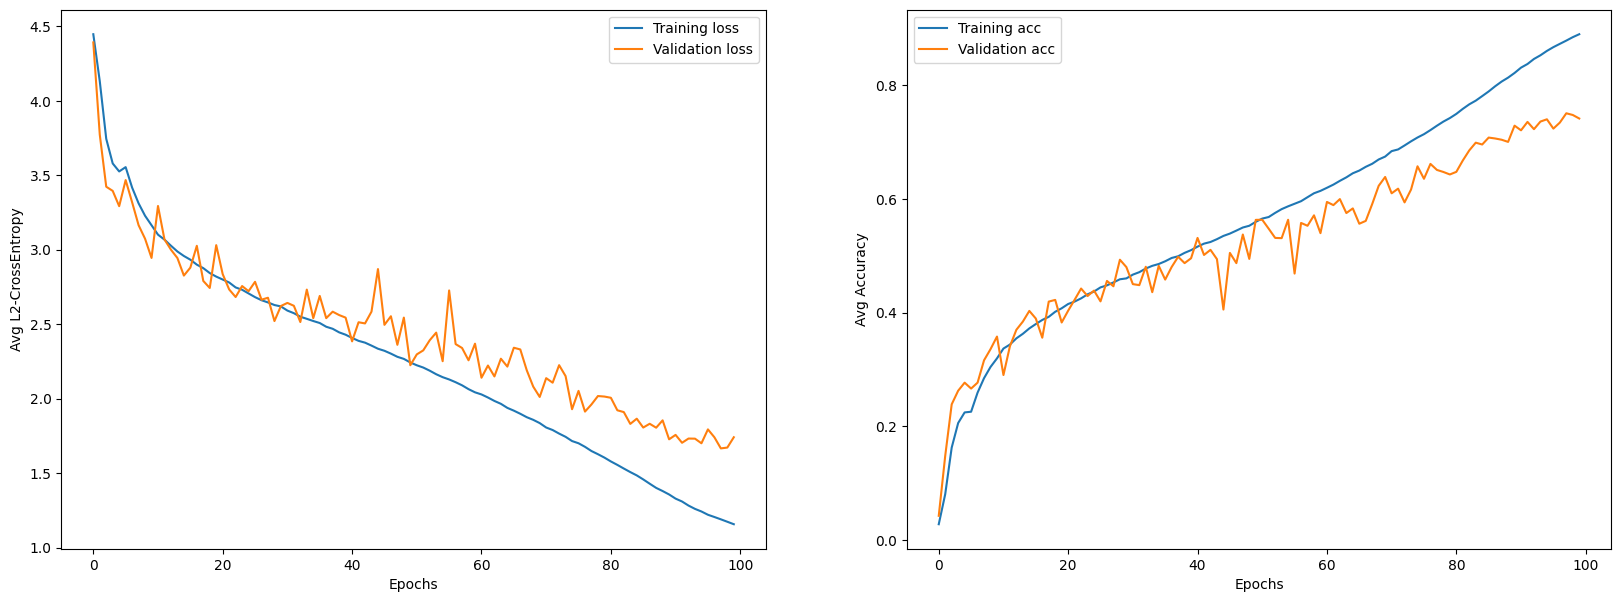

In [14]:
# Plot results
plt.figure(figsize=[20,7])
plt.subplot(1,2,1)
plt.plot(range(settings['epochs']), res_df['Loss'], label='Training loss')
plt.plot(range(settings['epochs']), res_df['Val_Loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Avg L2-CrossEntropy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(settings['epochs']), res_df['Accuracy'], label='Training acc')
plt.plot(range(settings['epochs']), res_df['Val_Accuracy'], label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Avg Accuracy')
plt.legend();

### 3.3.2 - Exporting best options and testing

In [15]:
# Export the best model
exported = SuperNet_model.export(verbose=1)

[BEST ALTERNATIVE for features.4.block.2]:
Identity()

[BEST ALTERNATIVE for features.5.block.2]:
DepthwiseSeparableConv(
  (depthwise): Conv2d(120, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=120)
  (depth_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pointwise): Conv2d(120, 120, kernel_size=(1, 1), stride=(1, 1), groups=2)
  (point_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)

[BEST ALTERNATIVE for features.6.block.2]:
DepthwiseSeparableConv(
  (depthwise): Conv2d(120, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=120)
  (depth_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pointwise): Conv2d(120, 120, kernel_size=(1, 1), stride=(1, 1), groups=2)
  (point_bn): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)

[BEST ALTERNATIVE for features.11.b

In [16]:
# Look at the model
exported

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [17]:
# Test the model on the test set
SuperNet_acc = utils.eval_model(
    model=exported,
    device=device,
    data_loader=test_dataloader
)  

  0%|          | 0/313 [00:00<?, ?batch/s]

EVALUATION COMPLETED - Avg Accuracy: 77.02%


In [18]:
# Save the exported model
utils.save_experiment(root='./experiments', model=exported, seed=SEED, settings=settings, exported=True, metrics_df=res_df)